In [309]:
import struct
import pandas as pd
import os
import librosa
import librosa.display
import matplotlib.pyplot as plt
import IPython.display as ipd

from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
import numpy as np

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D, Conv2D, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.utils import np_utils
from sklearn import metrics 


In [333]:
metadataImpact = pd.read_csv("golf-swing-dataset/data/golfDB.csv", sep=",", usecols=["id", "youtube_id", "sex", "club", "slow", "kf7"])
metadataImpact = metadataImpact.rename(columns={"kf7" : "impactFrame", "youtube_id" : "youtubeId"})
metadataImpact.slow = metadataImpact.slow.apply(lambda x: True if x == 1 else x).apply(lambda x: False if x == 0 else x)
metadataImpact = metadataImpact[metadataImpact["slow"] == False].drop("slow", axis=1)
metadataImpact.head()

,id,youtubeId,sex,club,impactFrame
0,0,f1BWA5F87Jc,f,driver,498
2,2,tA1iotgtMyc,m,driver,698
4,4,wDCKLePrwHA,f,driver,205
6,6,iPuVhnI8pJU,m,driver,332
8,8,-M5SITXMA2Y,f,driver,355


In [334]:
basePath = "/Users/metinozturk/Downloads/AI/"

<h1>Num Of Channels, Sample Rate, Bit Depth</h1>

<h2>Impact Sounds</h2>

In [335]:
audioImpactdata = []
for index, row in metadataImpact.iterrows():
    fileName = f"{basePath}audios/{row.id + 1}-{row.youtubeId}.wav"
    if not os.path.exists(fileName):
        continue       
    readImpactProperties = readFileProperties(fileName)
    audioImpactdata.append(readProperties)

# Convert into a Panda dataframe
audioImpactDf = pd.DataFrame(audioImpactdata, columns=['num_channels','sample_rate','bit_depth'])

In [336]:
audioImpactDf.head()

,num_channels,sample_rate,bit_depth
0,2,44100,16
1,2,44100,16
2,2,44100,16
3,2,44100,16
4,2,44100,16


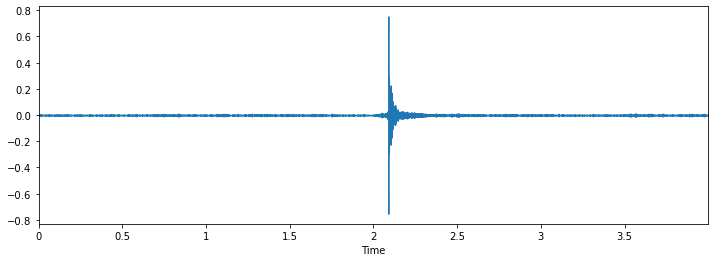

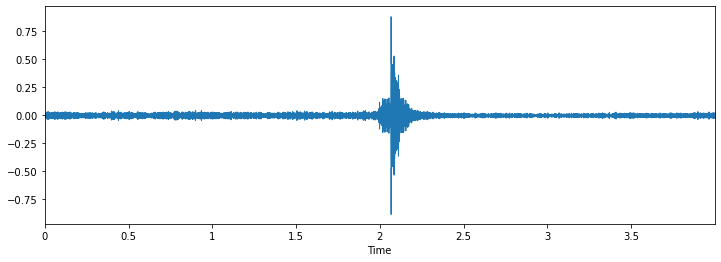

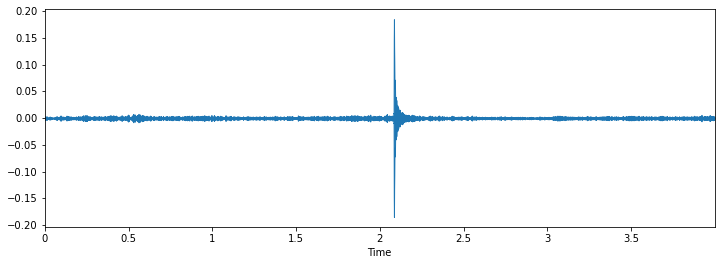

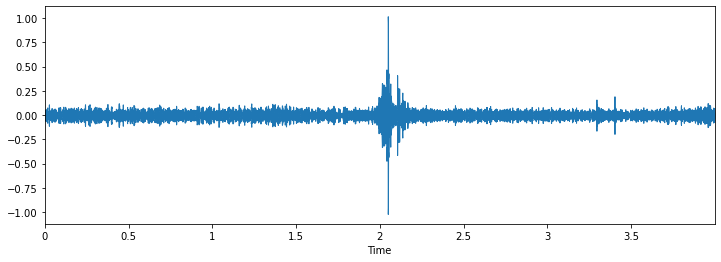

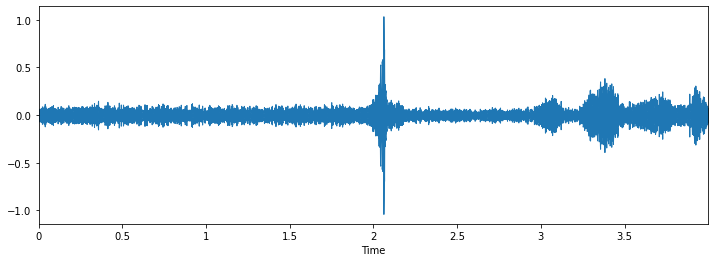

In [337]:
for index, row in metadataImpact.head().iterrows():
    fileName = f"{basePath}audios/{row.id + 1}-{row.youtubeId}.wav"

    plt.figure(figsize=(12,4))
    retrievedData ,sample_rate = librosa.load(fileName)
    _ = librosa.display.waveplot(retrievedData,sr=sample_rate)

<h2>Control Sounds</h2>

In [338]:
metadata = pd.read_csv(f'{basePath}UrbanSound8K/metadata/UrbanSound8K.csv')
metadata.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


In [339]:
audioControldata = []
for index, row in metadata.iterrows():
    fileName = f"{basePath}UrbanSound8K/audio/fold{row['fold']}/{row['slice_file_name']}"
    tempData = readFileProperties(fileName)
    audioControldata.append(tempData)

# Convert into a Panda dataframe
audioControldf = pd.DataFrame(audioControldata, columns=['num_channels','sample_rate','bit_depth'])
audioControldf = audioControldf[(audioControldf["sample_rate"] == 44100) & (audioControldf["bit_depth"] == 16) & (audioControldf["num_channels"] == 2)]

In [340]:
metadata = metadata.loc[audioControldf.index, :].reset_index()

# metadata = metadata.loc[0:len(data), :]

<h1>Features</h1>

In [288]:
features = []
for index, row in data.iterrows():
    fileName = f"{basePath}audios/{row.id + 1}-{row.youtubeId}.wav"
    if not os.path.exists(fileName):
        continue       
    class_label = "impact"
    readImpactFeatures = extract_features(fileName)
    features.append([readImpactFeatures, class_label])
    
for index,row in metadata.iterrows():
    fileName = f"{basePath}UrbanSound8K/audio/fold{row['fold']}/{row['slice_file_name']}"
    if not os.path.exists(file_name):
        continue     
    class_label = "control"
    readControlFeatures = extract_features(fileName)
    features.append([readControlFeatures, class_label])
    
featuresdf = pd.DataFrame(features, columns=['feature','class_label'])

/opt/anaconda3/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=2048 is too small for input signal of length=1323
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=2048 is too small for input signal of length=1103
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=2048 is too small for input signal of length=1523
  warnings.warn(


In [289]:
#Shuffle
featuresdf = featuresdf.sample(frac = 1)

In [290]:
X = np.array(featuresdf.feature.tolist())
y = np.array(featuresdf.class_label.tolist())

# Encode the classification labels
le = LabelEncoder()
yy = to_categorical(le.fit_transform(y)) 
# split the dataset 
from sklearn.model_selection import train_test_split 

x_train, x_test, y_train, y_test = train_test_split(X, yy, test_size=0.2, random_state = 42)

<h1> Model Training </h1>

<h3> Multilayer Perceptron </h3>

In [291]:
num_labels = yy.shape[1]
filter_size = 2

# Construct model 
model = Sequential()

model.add(Dense(256, input_shape=(40,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(num_labels))
model.add(Activation('softmax'))

In [292]:
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')
# Display model architecture summary 
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_21 (Dense)             (None, 256)               10496     
_________________________________________________________________
activation_21 (Activation)   (None, 256)               0         
_________________________________________________________________
dropout_14 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 256)               65792     
_________________________________________________________________
activation_22 (Activation)   (None, 256)               0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_23 (Dense)             (None, 2)                

In [293]:
# Calculate pre-training accuracy 
score = model.evaluate(x_test, y_test, verbose=0)
accuracy = 100*score[1]
accuracy

82.75862336158752

In [294]:
from keras.callbacks import ModelCheckpoint 
from datetime import datetime 

num_epochs = 100
num_batch_size = 32

checkpointer = ModelCheckpoint(filepath=f'{basePath}savedModels/weights.best.basic_mlp.hdf5', 
                               verbose=1, save_best_only=True)
start = datetime.now()

model.fit(x_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(x_test, y_test), callbacks=[checkpointer], verbose=1)


duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/100
112/124 [==========================>...] - ETA: 0s - loss: 5.3142 - accuracy: 0.7720
Epoch 00001: val_loss improved from inf to 0.74768, saving model to /Users/metinozturk/Downloads/AI/savedModels/weights.best.basic_mlp.hdf5
124/124 [==============================] - 0s 1ms/step - loss: 5.0637 - accuracy: 0.7753 - val_loss: 0.7477 - val_accuracy: 0.7911
Epoch 2/100
106/124 [========================>.....] - ETA: 0s - loss: 1.5757 - accuracy: 0.8031
Epoch 00002: val_loss improved from 0.74768 to 0.29856, saving model to /Users/metinozturk/Downloads/AI/savedModels/weights.best.basic_mlp.hdf5
124/124 [==============================] - 0s 1ms/step - loss: 1.4916 - accuracy: 0.8095 - val_loss: 0.2986 - val_accuracy: 0.8671
Epoch 3/100
106/124 [========================>.....] - ETA: 0s - loss: 0.6831 - accuracy: 0.8269
Epoch 00003: val_loss did not improve from 0.29856
124/124 [==============================] - 0s 1ms/step - loss: 0.6577 - accuracy: 0.8303 - val_loss: 0.3464 - va

Epoch 26/100
118/124 [===========================>..] - ETA: 0s - loss: 0.1468 - accuracy: 0.9415
Epoch 00026: val_loss did not improve from 0.15885
124/124 [==============================] - 0s 1ms/step - loss: 0.1451 - accuracy: 0.9422 - val_loss: 0.1758 - val_accuracy: 0.9148
Epoch 27/100
110/124 [=========================>....] - ETA: 0s - loss: 0.1558 - accuracy: 0.9338
Epoch 00027: val_loss improved from 0.15885 to 0.14968, saving model to /Users/metinozturk/Downloads/AI/savedModels/weights.best.basic_mlp.hdf5
124/124 [==============================] - 0s 1ms/step - loss: 0.1513 - accuracy: 0.9361 - val_loss: 0.1497 - val_accuracy: 0.9473
Epoch 28/100
107/124 [========================>.....] - ETA: 0s - loss: 0.1316 - accuracy: 0.9477
Epoch 00028: val_loss did not improve from 0.14968
124/124 [==============================] - 0s 1ms/step - loss: 0.1300 - accuracy: 0.9470 - val_loss: 0.1571 - val_accuracy: 0.9412
Epoch 29/100
111/124 [=========================>....] - ETA: 0s - l

115/124 [==========================>...] - ETA: 0s - loss: 0.0907 - accuracy: 0.9620
Epoch 00053: val_loss did not improve from 0.11952
124/124 [==============================] - 0s 1ms/step - loss: 0.0915 - accuracy: 0.9627 - val_loss: 0.1323 - val_accuracy: 0.9686
Epoch 54/100
105/124 [========================>.....] - ETA: 0s - loss: 0.0961 - accuracy: 0.9619
Epoch 00054: val_loss did not improve from 0.11952
124/124 [==============================] - 0s 1ms/step - loss: 0.0973 - accuracy: 0.9615 - val_loss: 0.1289 - val_accuracy: 0.9655
Epoch 55/100
112/124 [==========================>...] - ETA: 0s - loss: 0.0800 - accuracy: 0.9679
Epoch 00055: val_loss improved from 0.11952 to 0.11834, saving model to /Users/metinozturk/Downloads/AI/savedModels/weights.best.basic_mlp.hdf5
124/124 [==============================] - 0s 1ms/step - loss: 0.0785 - accuracy: 0.9686 - val_loss: 0.1183 - val_accuracy: 0.9625
Epoch 56/100
104/124 [========================>.....] - ETA: 0s - loss: 0.0863 -

Epoch 82/100
 98/124 [======================>.......] - ETA: 0s - loss: 0.0765 - accuracy: 0.9716
Epoch 00082: val_loss did not improve from 0.11796
124/124 [==============================] - 0s 1ms/step - loss: 0.0775 - accuracy: 0.9708 - val_loss: 0.1292 - val_accuracy: 0.9584
Epoch 83/100
106/124 [========================>.....] - ETA: 0s - loss: 0.0707 - accuracy: 0.9726
Epoch 00083: val_loss did not improve from 0.11796
124/124 [==============================] - 0s 1ms/step - loss: 0.0716 - accuracy: 0.9703 - val_loss: 0.1233 - val_accuracy: 0.9655
Epoch 84/100
107/124 [========================>.....] - ETA: 0s - loss: 0.0665 - accuracy: 0.9740
Epoch 00084: val_loss did not improve from 0.11796
124/124 [==============================] - 0s 1ms/step - loss: 0.0645 - accuracy: 0.9746 - val_loss: 0.1527 - val_accuracy: 0.9655
Epoch 85/100
106/124 [========================>.....] - ETA: 0s - loss: 0.0644 - accuracy: 0.9732
Epoch 00085: val_loss did not improve from 0.11796
124/124 [==

In [281]:
# Evaluating the model on the training and testing set
score = model.evaluate(x_train, y_train, verbose=0)
print("Training Accuracy: ", score[1])

score = model.evaluate(x_test, y_test, verbose=0)
print("Testing Accuracy: ", score[1])

Training Accuracy:  0.9991694092750549
Testing Accuracy:  0.9634551405906677


<h3>CNN</h3>

In [365]:
features = []
for index, row in metadataImpact.iterrows():
    fileName = f"{basePath}audios/{row.id + 1}-{row.youtubeId}.wav"
    if not os.path.exists(fileName):
        continue       
    class_label = "impact"
    readImpactFeatures = extractFeaturesForCNN(fileName)
    features.append([readImpactFeatures, class_label])
    
for index,row in metadata.iterrows():
    fileName = f"{basePath}UrbanSound8K/audio/fold{row['fold']}/{row['slice_file_name']}"
    if not os.path.exists(file_name):
        continue     
    class_label = "control"
    readControlFeatures = extractFeaturesForCNN(fileName)
    features.append([readControlFeatures, class_label])
    
featuresdf = pd.DataFrame(features, columns=['feature','class_label'])
featuresdf = featuresdf.sample(frac = 1)

[[-554.00146   -555.1159    -551.00183   ... -545.25806   -551.4584
     0.       ]
 [ 196.14899    198.91649    200.21603   ...  180.20668    176.75925
     0.       ]
 [   6.5299397    8.579995     9.069294  ...   12.165534    14.547577
     0.       ]
 ...
 [  -7.077254    -7.6504345   -6.4286575 ...   -3.4359295   -6.4880857
     0.       ]
 [ -11.921477    -7.7335997   -2.4537063 ...   -2.4868765   -3.0724044
     0.       ]
 [  -5.747808    -2.5307622   -3.8006659 ...   -2.7416759   -4.137784
     0.       ]]
[[-299.6576     -298.92603    -303.21756    ... -319.32034
  -323.3768        0.        ]
 [ 123.63498     126.69739     128.10864    ...  124.35908
   119.51665       0.        ]
 [  -4.376689     -9.531561    -15.796949   ...  -18.426214
   -13.992683      0.        ]
 ...
 [  -0.55793864   -1.3851786    -6.9559255  ...   -1.0204442
    -5.0454764     0.        ]
 [  -3.15788       0.33776903   -2.4649801  ...   -1.5881958
     0.9863018     0.        ]
 [  -3.121835      

[[-2.68172424e+02 -2.63688446e+02 -2.65390686e+02 ... -2.61472504e+02
  -2.70011688e+02  0.00000000e+00]
 [ 1.05103767e+02  1.10153336e+02  1.11831543e+02 ...  1.10657227e+02
   1.07094727e+02  0.00000000e+00]
 [ 1.23856764e+01  6.82943058e+00  1.23439419e+00 ...  6.22999966e-01
   2.03022599e+00  0.00000000e+00]
 ...
 [ 7.20414925e+00  3.79026246e+00 -1.87210858e-01 ...  1.49171555e+00
   1.52535450e+00  0.00000000e+00]
 [ 8.86505318e+00  2.72662377e+00 -9.19608593e-01 ... -2.00232983e+00
  -1.91380119e+00  0.00000000e+00]
 [ 2.82271922e-01 -5.24882197e-01  3.43236446e+00 ... -3.23895216e+00
  -5.02287197e+00  0.00000000e+00]]
[[-288.3536     -289.6186     -296.6875     ... -295.92734
  -296.59814       0.        ]
 [ 152.27264     153.92044     154.36243    ...  163.44719
   161.39502       0.        ]
 [ -14.87239     -22.795265    -34.512436   ...  -30.643227
   -18.758202      0.        ]
 ...
 [   2.2923884    -0.3509424     2.8440995  ...   -2.3122265
    -1.407875      0.      

[[-391.07837    -387.49234    -392.84763    ... -387.69
  -388.65546       0.        ]
 [ 124.627075    130.47707     129.84521    ...  125.21193
   123.102646      0.        ]
 [ -55.12021     -53.957954    -50.354397   ...  -54.862305
   -53.685856      0.        ]
 ...
 [  -4.207676     -3.210318     -4.550308   ...   -6.1515017
    -9.933193      0.        ]
 [   0.74505234    0.4053898    -0.7636764  ...   -2.826478
    -5.001795      0.        ]
 [  -4.58043      -1.575098     -1.904453   ...   -1.5577049
    -2.10531       0.        ]]
[[-476.5043    -476.28488   -483.8681    ... -466.60675   -467.70102
     0.       ]
 [ 146.93814    154.5007     157.4223    ...  172.45454    164.2247
     0.       ]
 [  37.319504    25.9383      13.172897  ...   29.76418     28.795944
     0.       ]
 ...
 [  -3.5959048   -1.4886484   -2.2970297 ...    3.6448221    8.839679
     0.       ]
 [  -3.8190937   -3.7154756   -2.1834424 ...    3.849311    10.342134
     0.       ]
 [  -6.0250607   -6

[[-4.1342517e+02 -4.1130490e+02 -4.0768399e+02 ... -1.4692091e+02
  -1.7944980e+02  0.0000000e+00]
 [ 1.0668559e+02  1.0813643e+02  1.0759918e+02 ...  4.3736835e+00
   1.0677388e+00  0.0000000e+00]
 [-2.1186659e+01 -2.3812243e+01 -2.3773483e+01 ... -6.8037216e+01
  -7.0160416e+01  0.0000000e+00]
 ...
 [ 1.3684869e+00  1.6514053e+00  3.3984523e+00 ...  6.0521686e-01
  -1.9902737e+00  0.0000000e+00]
 [-1.0714915e+00  6.8176150e-02  2.3274686e+00 ... -5.7362986e+00
  -4.8055716e+00  0.0000000e+00]
 [ 9.6182245e-01  7.7331543e-01  2.1836932e+00 ... -1.9182544e+00
  -2.3271956e+00  0.0000000e+00]]
[[-5.30214539e+02 -5.23895447e+02 -5.23075928e+02 ... -5.07160797e+02
  -5.06655609e+02  0.00000000e+00]
 [ 9.34516068e+01  9.79058533e+01  9.81873779e+01 ...  1.08821976e+02
   1.06511322e+02  0.00000000e+00]
 [-2.90199203e+01 -2.95289536e+01 -3.47483368e+01 ... -1.36290097e+00
   7.93768883e-01  0.00000000e+00]
 ...
 [ 1.75343788e+00 -2.94269109e+00 -7.07366848e+00 ...  1.87412763e+00
   5.84761

[[-655.62506   -654.5227    -656.8536    ... -627.39716   -626.2163
     0.       ]
 [ 155.77023    161.4198     163.91095   ...  182.43355    177.25055
     0.       ]
 [   8.749464     3.3768768    7.85755   ...    5.3137035    8.432073
     0.       ]
 ...
 [  -2.1852708   -3.6486802   -5.373522  ...   -3.0092545   -3.2903671
     0.       ]
 [   3.2576287   -1.3956373   -2.401518  ...   -4.5962853   -2.8684368
     0.       ]
 [   4.0028124   -3.0349045   -1.9562482 ...   -1.6426144   -2.9186246
     0.       ]]
[[-6.5299884e+02 -6.5539240e+02 -6.5758795e+02 ... -9.2434167e+02
  -9.2434167e+02  0.0000000e+00]
 [ 1.4826593e+02  1.5988680e+02  1.6977966e+02 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 1.4139616e+01  8.5922079e+00  1.0864471e+01 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 ...
 [ 1.8633382e+00 -2.7368343e+00 -9.1851127e-01 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [-1.9196504e-01 -3.1641197e+00 -6.3894355e-01 ...  0.0000000e+00
   0.000000

[[-3.1689291e+02 -3.0923477e+02 -3.0917245e+02 ... -7.4130389e+02
  -7.4130389e+02  0.0000000e+00]
 [ 1.7941113e+02  1.8443149e+02  1.8278177e+02 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [-4.3786308e+01 -4.0570507e+01 -3.8866135e+01 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 ...
 [-3.1953177e+00 -5.2843432e+00 -5.8481617e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [-1.0583786e+00 -2.0787497e+00 -2.9292657e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [-9.7418213e+00 -3.7770560e+00  2.8558722e-01 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]]
[[-1.95199966e+02 -1.90347626e+02 -1.86539459e+02 ... -1.97114670e+02
  -2.12029404e+02  0.00000000e+00]
 [ 1.09046768e+02  1.18658676e+02  1.26158859e+02 ...  1.18689667e+02
   1.09749275e+02  0.00000000e+00]
 [ 1.08121395e+01  8.53145719e-01 -7.45474052e+00 ... -2.53177166e+00
  -5.12265158e+00  0.00000000e+00]
 ...
 [ 6.85127139e-01  1.22954464e+00  6.52647853e-01 ... -3.40665531e+00
  -5.27009

[[-6.5049945e+02 -6.4341882e+02 -6.3379950e+02 ... -5.7643073e+02
  -5.6213251e+02  0.0000000e+00]
 [ 1.5929117e+02  1.7951277e+02  1.9111334e+02 ...  2.0201231e+02
   2.0167749e+02  0.0000000e+00]
 [-2.9313766e+01 -3.6508598e+01 -3.3726631e+01 ... -5.5153664e+01
  -4.2916878e+01  0.0000000e+00]
 ...
 [ 5.2579422e+00 -4.5727059e-01 -1.6941416e+00 ... -5.3861938e+00
  -3.4746540e-01  0.0000000e+00]
 [ 1.1331503e+00 -4.2525482e+00 -5.3417110e+00 ... -6.8224907e+00
  -3.0011742e+00  0.0000000e+00]
 [-3.6686805e-01 -1.8779976e+00  6.7040706e-01 ... -3.3647037e+00
  -3.9989376e+00  0.0000000e+00]]
[[-6.4989172e+02 -6.4783197e+02 -6.5898596e+02 ... -7.1201190e+02
  -7.2092462e+02  0.0000000e+00]
 [ 1.6170663e+02  1.7826514e+02  1.8743314e+02 ...  1.5293062e+02
   1.4902682e+02  0.0000000e+00]
 [-4.5820652e+01 -5.5617455e+01 -6.7498825e+01 ... -3.7515144e+01
  -3.3963600e+01  0.0000000e+00]
 ...
 [ 6.1954761e-01 -3.1363378e+00 -6.7080016e+00 ... -5.9679127e+00
  -2.7301908e+00  0.0000000e+00]

[[-3.83192383e+02 -3.84191010e+02 -3.88835175e+02 ... -3.96321259e+02
  -3.94275726e+02  0.00000000e+00]
 [ 1.16941231e+02  1.17622650e+02  1.12730965e+02 ...  1.13961205e+02
   1.13426315e+02  0.00000000e+00]
 [-4.26711502e+01 -4.41927490e+01 -4.90044022e+01 ... -3.60451202e+01
  -3.75257645e+01  0.00000000e+00]
 ...
 [-9.79966298e-02  1.54567647e+00 -2.93161249e+00 ... -2.25605583e+00
   2.27241230e+00  0.00000000e+00]
 [ 3.81712174e+00  4.84027958e+00  4.87676907e+00 ... -4.73156548e+00
  -2.09795666e+00  0.00000000e+00]
 [ 4.16563940e+00  1.12922788e+00 -1.67602390e-01 ... -5.39724922e+00
  -1.78953183e+00  0.00000000e+00]]
[[-225.29118   -222.96426   -226.90886   ... -736.0733    -736.0733
     0.       ]
 [ 134.9875     137.20502    135.44722   ...    0.           0.
     0.       ]
 [ -36.35965    -31.704353   -29.356895  ...    0.           0.
     0.       ]
 ...
 [  -8.720632    -2.4001122    4.8187237 ...    0.           0.
     0.       ]
 [  -8.2420635   -1.4362543    2.03

[[-325.1226     -326.12073    -335.84216    ... -330.7513
  -333.58246       0.        ]
 [ 146.47903     151.383       154.48651    ...  161.10333
   163.23274       0.        ]
 [ -20.505125    -20.468721    -23.352737   ...  -22.941889
   -24.048134      0.        ]
 ...
 [  -4.0323114    -3.71832      -0.4610132  ...   -2.5010834
     3.7808068     0.        ]
 [  -5.975194     -3.087781      3.009057   ...   -4.566273
     0.78587157    0.        ]
 [   5.4157104     3.4401374     3.747725   ...   -1.2642121
     4.741811      0.        ]]
[[-3.16640991e+02 -3.17479462e+02 -3.23174866e+02 ... -2.57322479e+02
  -2.99674744e+02  0.00000000e+00]
 [ 5.42848663e+01  5.93708572e+01  6.04682159e+01 ...  1.00443405e+02
   5.75356216e+01  0.00000000e+00]
 [-4.25253372e+01 -4.72266312e+01 -5.30360947e+01 ... -4.81831398e+01
  -5.06040878e+01  0.00000000e+00]
 ...
 [-4.47369957e+00 -2.33534908e+00 -2.00332451e+00 ...  6.65900469e-01
  -8.58281493e-01  0.00000000e+00]
 [-5.57839775e+00 -2.918

[[-5.1440558e+02 -4.9522601e+02 -4.9338141e+02 ... -4.7449966e+02
  -4.5957712e+02  0.0000000e+00]
 [ 1.4464545e+02  1.5855609e+02  1.5799474e+02 ...  1.9612579e+02
   1.9540207e+02  0.0000000e+00]
 [ 5.1671028e+00  4.3702176e-01  1.1047835e+00 ...  1.8478119e+01
   1.4892089e+01  0.0000000e+00]
 ...
 [ 3.4198606e+00  1.7434439e-01 -4.9073367e+00 ...  1.5394168e+00
   7.3902111e+00  0.0000000e+00]
 [ 2.0498331e+00  1.4834142e+00 -3.0564132e+00 ... -1.7470071e+00
  -3.7179923e+00  0.0000000e+00]
 [-2.5753677e+00  4.8520315e-01  5.4163432e-01 ... -4.2561588e+00
  -1.4849069e+00  0.0000000e+00]]
[[-1.8711424e+02 -1.9658932e+02 -2.0517995e+02 ... -6.3581683e+02
  -6.3581683e+02  0.0000000e+00]
 [ 1.7916730e+02  1.8862564e+02  1.9796939e+02 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [-3.3573826e+01 -3.6917927e+01 -4.0828362e+01 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 ...
 [-2.2414346e+00 -2.4465537e+00 -2.7034204e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]

[[-2.6052335e+02 -2.5565977e+02 -2.5525063e+02 ... -5.9905273e+02
  -5.9905273e+02  0.0000000e+00]
 [ 1.3123782e+02  1.3112933e+02  1.2689116e+02 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [-8.2341890e+00 -1.5093211e+01 -1.8841709e+01 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 ...
 [-4.4789410e+00 -2.8798275e+00 -2.3295016e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [-2.4589181e+00 -2.7536380e-01  2.3990552e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [-3.1119385e+00 -1.5117161e+00 -2.6531196e-01 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]]
[[-263.064     -260.76147   -256.1793    ... -599.08746   -599.08746
     0.       ]
 [ 121.28534    125.27688    126.52792   ...    0.           0.
     0.       ]
 [   0.8545743   -8.804992   -14.960704  ...    0.           0.
     0.       ]
 ...
 [  -6.997199    -4.1318493   -3.7807205 ...    0.           0.
     0.       ]
 [  -5.0563707   -3.9602528   -3.7283244 ...    0.           0.
     0

[[-329.52167    -323.51688    -322.25       ... -256.49622
  -249.90182       0.        ]
 [ 137.75146     139.57605     140.19508    ...  174.4498
   171.85732       0.        ]
 [  -9.051901    -11.934246    -15.242      ...  -18.835215
   -17.966522      0.        ]
 ...
 [  -3.5185723    -5.1067076    -1.7900645  ...   -9.012311
    -2.3352528     0.        ]
 [  -2.465259     -0.41358045   -0.7351521  ...  -14.41337
    -9.97279       0.        ]
 [  -1.3304244     1.2199469     2.929906   ...  -22.206253
   -17.427673      0.        ]]
[[-3.45891388e+02 -3.44872986e+02 -3.44758301e+02 ... -3.41164581e+02
  -3.46350952e+02  0.00000000e+00]
 [ 1.00922134e+02  1.08151367e+02  1.10802567e+02 ...  1.00259216e+02
   9.88527832e+01  0.00000000e+00]
 [ 1.20656042e+01  1.72554817e+01  2.38764381e+01 ...  1.03551235e+01
   1.05096922e+01  0.00000000e+00]
 ...
 [-3.16708064e+00  2.24036217e+00 -2.88207173e+00 ...  6.14808178e+00
   2.15443611e+00  0.00000000e+00]
 [-8.60646057e+00  3.942138

[[-4.30475342e+02 -4.20029968e+02 -4.41143982e+02 ... -3.30037994e+02
  -3.18435760e+02  0.00000000e+00]
 [ 1.04641624e+02  1.11016312e+02  1.19132561e+02 ...  1.13665787e+02
   1.05726395e+02  0.00000000e+00]
 [ 2.91879787e+01  1.14909277e+01  1.10167961e+01 ...  1.37946577e+01
   1.10549030e+01  0.00000000e+00]
 ...
 [ 3.09808731e-01  1.94800258e+00  3.74182653e+00 ...  7.10966825e-01
  -7.00027227e-01  0.00000000e+00]
 [ 3.85492420e+00  3.22108221e+00  2.24331808e+00 ... -3.91847301e+00
   3.17526746e+00  0.00000000e+00]
 [ 8.51195097e-01  4.76613522e+00  7.43674088e+00 ... -8.06223297e+00
  -1.49513495e+00  0.00000000e+00]]
[[-3.2207083e+02 -3.1753741e+02 -3.1428964e+02 ... -3.2052914e+02
  -3.1799957e+02  0.0000000e+00]
 [ 1.2551712e+02  1.2986397e+02  1.3441531e+02 ...  1.4218835e+02
   1.4127121e+02  0.0000000e+00]
 [ 1.3245183e+00 -5.2729993e+00 -1.7347677e+01 ... -9.8170547e+00
  -7.2498903e+00  0.0000000e+00]
 ...
 [ 2.7496758e+00  3.1189253e+00 -4.6091080e-01 ... -1.4355277e

[[-3.11226013e+02 -3.07782776e+02 -3.11910126e+02 ... -3.34285706e+02
  -3.24156830e+02  0.00000000e+00]
 [ 1.13514771e+02  1.19455009e+02  1.25585091e+02 ...  1.27345871e+02
   1.21139267e+02  0.00000000e+00]
 [-1.08407860e+01 -1.37358971e+01 -1.41878929e+01 ...  4.63997275e-01
   1.35933411e+00  0.00000000e+00]
 ...
 [-1.29485035e+00  2.36959815e-01 -1.01109159e+00 ... -1.18181658e+00
  -6.88316822e-02  0.00000000e+00]
 [-3.34189606e+00 -1.39736485e+00  1.32685280e+00 ... -3.71110559e+00
   9.15476978e-01  0.00000000e+00]
 [ 1.54502869e+00  1.12029076e-01 -3.31743383e+00 ... -1.25832725e+00
  -9.81185198e-01  0.00000000e+00]]
[[-3.8202414e+02 -3.7829178e+02 -3.8424597e+02 ... -3.7145599e+02
  -3.7763196e+02  0.0000000e+00]
 [ 1.3897374e+02  1.4535243e+02  1.5035866e+02 ...  1.5745905e+02
   1.5248798e+02  0.0000000e+00]
 [ 9.8520899e+00  2.8384149e+00 -2.2830930e+00 ... -5.8612299e+00
   1.0910001e+00  0.0000000e+00]
 ...
 [ 3.8921447e+00  3.2442787e+00  9.9968135e-01 ... -2.6477945e

[[-289.32953    -294.22888    -301.73334    ... -318.3207
  -318.79684       0.        ]
 [ 177.54828     183.90363     188.18713    ...  199.78223
   191.41312       0.        ]
 [ -21.814838    -25.421024    -27.790115   ...  -29.367226
   -23.057846      0.        ]
 ...
 [  -3.1040356    -1.776134     -1.6632042  ...    3.5134416
     0.39456093    0.        ]
 [ -12.691707     -6.7892094    -1.6239237  ...   -2.6126714
    -3.7328658     0.        ]
 [ -11.000044     -6.6937585    -1.0499848  ...   -6.3876963
    -5.2498407     0.        ]]
[[-187.50085    -187.19565    -187.48344    ... -213.16028
  -203.61964       0.        ]
 [ 189.01111     196.77179     207.20549    ...  209.52687
   197.3995        0.        ]
 [ -53.69352     -59.32525     -67.69833    ...  -62.21408
   -50.31616       0.        ]
 ...
 [ -11.058449     -8.563166     -2.51024    ...   -0.29306486
    -1.3224864     0.        ]
 [  -9.481638     -6.978657     -2.7268267  ...   -2.5036297
    -0.40560436    

[[-6.8878778e+02 -6.8989294e+02 -7.0150238e+02 ... -6.6923254e+02
  -6.7437811e+02  0.0000000e+00]
 [ 1.5873447e+02  1.6558618e+02  1.6083565e+02 ...  1.9100040e+02
   1.8060423e+02  0.0000000e+00]
 [ 4.7786552e+01  3.1839638e+01  1.6990547e+01 ...  2.5412216e+01
   2.1321386e+01  0.0000000e+00]
 ...
 [-3.1220851e+00 -2.8441644e+00 -1.2598046e+00 ...  1.6993051e+00
   8.4542322e+00  0.0000000e+00]
 [ 1.5228312e+00  1.8056544e+00  5.7143807e-01 ...  3.1887093e+00
   9.9167424e-01  0.0000000e+00]
 [ 2.5877173e+00 -4.5103249e-01 -2.5222943e+00 ... -1.3825412e+00
  -3.8309107e+00  0.0000000e+00]]
[[-2.07917007e+02 -2.07650894e+02 -2.13103485e+02 ... -1.80591995e+02
  -1.90983093e+02  0.00000000e+00]
 [ 1.23400406e+02  1.29332336e+02  1.38178162e+02 ...  1.55474243e+02
   1.51927124e+02  0.00000000e+00]
 [-1.79335270e+01 -2.07625198e+01 -2.60824318e+01 ... -4.78398018e+01
  -4.50888710e+01  0.00000000e+00]
 ...
 [-1.27375591e+00 -4.09775877e+00 -7.21616745e+00 ... -1.22632980e-02
  -2.36391

[[-407.5569     -410.9271     -419.43127    ... -381.70105
  -382.54886       0.        ]
 [ 146.32263     164.14212     175.62953    ...  174.608
   172.2915        0.        ]
 [   9.514161      2.90976      -3.317228   ...  -18.156685
   -21.015987      0.        ]
 ...
 [   2.7897902    -1.4475138    -1.270636   ...    2.0399227
     2.579749      0.        ]
 [  -2.210596     -1.0106578     2.604116   ...   -0.47325695
     1.1770914     0.        ]
 [  -5.951747     -3.6853664     1.9996705  ...   -4.5201383
    -4.2236023     0.        ]]
[[-453.7126    -458.54855   -459.73978   ... -469.2207    -466.6018
     0.       ]
 [ 148.6992     145.26067    142.0816    ...  152.78445    152.46027
     0.       ]
 [  16.619997     5.8612323   -4.5245066 ...   -9.875209    -2.8236287
     0.       ]
 ...
 [  -1.9781827   -2.4641607   -2.666772  ...    0.6032081    1.9634299
     0.       ]
 [  -2.0802035   -1.7895882   -2.7403715 ...    1.8122287    2.4145308
     0.       ]
 [   2.721658

[[-3.46784241e+02 -3.44621582e+02 -3.46100952e+02 ... -3.20374390e+02
  -3.14659485e+02  0.00000000e+00]
 [ 9.03308716e+01  9.67227020e+01  9.64703369e+01 ...  1.24191055e+02
   1.23540466e+02  0.00000000e+00]
 [-5.15365219e+01 -5.99249916e+01 -6.67403259e+01 ... -4.65578079e+01
  -3.29692993e+01  0.00000000e+00]
 ...
 [-8.78580666e+00 -5.31783676e+00 -3.77781153e+00 ... -1.07903767e+01
  -7.72532368e+00  0.00000000e+00]
 [-1.34443164e-01  3.13018966e+00  1.36330986e+00 ... -8.51442814e+00
  -4.18825579e+00  0.00000000e+00]
 [ 3.90072727e+00  5.03189659e+00  3.92692637e+00 ... -1.64120674e+00
   2.41978931e+00  0.00000000e+00]]
[[-368.24326   -362.6757    -360.14075   ... -330.49176   -341.5743
     0.       ]
 [  74.527504    82.18417     85.360794  ...  113.569595   102.60489
     0.       ]
 [ -47.58723    -42.45218    -41.317646  ...  -24.864151   -30.304516
     0.       ]
 ...
 [   1.9511938    2.080355     5.5137596 ...    2.5844197    1.6867754
     0.       ]
 [   3.5885367   

[[-1.3526884e+02 -1.2826923e+02 -1.2467774e+02 ... -1.2086116e+02
  -1.1484005e+02  0.0000000e+00]
 [ 1.7717401e+02  1.7450745e+02  1.7135962e+02 ...  1.8170648e+02
   1.7415491e+02  0.0000000e+00]
 [-2.9447433e+01 -3.1469069e+01 -3.3095787e+01 ... -2.7666058e+01
  -2.0636189e+01  0.0000000e+00]
 ...
 [-1.2983159e+00 -6.7077056e-02 -4.0212333e-01 ...  3.4401302e+00
  -1.2491257e+00  0.0000000e+00]
 [ 7.4526548e-02 -1.7878610e+00 -2.8238590e+00 ...  1.6620243e-01
  -2.1424069e+00  0.0000000e+00]
 [ 3.1345755e-01 -3.9462636e+00 -4.4418111e+00 ... -4.4454765e+00
  -2.1704128e+00  0.0000000e+00]]
[[-227.44191    -230.1805     -237.76585    ... -151.8144
  -127.249504      0.        ]
 [ 139.18481     148.94926     151.43167    ...  172.34174
   181.03436       0.        ]
 [  -3.8648362    -5.573413    -13.346754   ...  -39.240265
   -25.149511      0.        ]
 ...
 [  -3.7714455    -3.5163603    -2.3805158  ...   -4.075165
     0.7685622     0.        ]
 [  -8.377256     -1.4947202     0

[[-347.1231    -345.07376   -353.88104   ... -841.9219    -841.9219
     0.       ]
 [ 140.66116    153.27649    164.82951   ...    0.           0.
     0.       ]
 [   1.6445804   -4.364301   -18.006523  ...    0.           0.
     0.       ]
 ...
 [   6.2221007    5.9621625    2.9900832 ...    0.           0.
     0.       ]
 [   3.523952     1.390011    -5.2449226 ...    0.           0.
     0.       ]
 [   7.283235     4.256576    -4.3574424 ...    0.           0.
     0.       ]]
[[-347.1231    -345.07376   -353.88104   ... -841.9219    -841.9219
     0.       ]
 [ 140.66116    153.27649    164.82951   ...    0.           0.
     0.       ]
 [   1.6445804   -4.364301   -18.006523  ...    0.           0.
     0.       ]
 ...
 [   6.2221007    5.9621625    2.9900832 ...    0.           0.
     0.       ]
 [   3.523952     1.390011    -5.2449226 ...    0.           0.
     0.       ]
 [   7.283235     4.256576    -4.3574424 ...    0.           0.
     0.       ]]
[[-2.2511018e+02 -2.

[[-226.99353    -228.598      -238.3832     ... -215.79387
  -208.09793       0.        ]
 [  86.420395     90.96309      97.53413    ...  119.915924
   122.87399       0.        ]
 [  26.088533     21.55518       8.061745   ...  -27.144943
   -28.068325      0.        ]
 ...
 [  -5.142833     -4.0384       -5.371475   ...    1.740071
     1.060022      0.        ]
 [   0.29569113   -3.0631163    -4.713031   ...    2.5557466
    -0.5496786     0.        ]
 [   7.3007345     4.054582     -0.2925254  ...   -1.0895667
     2.6518626     0.        ]]
[[-5.4377087e+02 -5.4143237e+02 -5.3772864e+02 ... -5.8091760e+02
  -5.9242023e+02  0.0000000e+00]
 [ 1.9837814e+02  2.0026813e+02  2.0154205e+02 ...  1.5780000e+02
   1.5497980e+02  0.0000000e+00]
 [-6.6394913e+01 -7.1314766e+01 -7.7721802e+01 ... -4.1013924e+01
  -4.1980637e+01  0.0000000e+00]
 ...
 [-4.0577531e+00  1.1700301e+00 -3.1627998e+00 ... -6.4137640e+00
  -4.8361025e+00  0.0000000e+00]
 [-3.6742908e-01 -1.5318758e+00 -5.0861597e+00

[[-2.99244354e+02 -2.99642029e+02 -3.04927673e+02 ... -2.94715027e+02
  -3.03676239e+02  0.00000000e+00]
 [ 1.19249359e+02  1.21612274e+02  1.24257065e+02 ...  1.17621796e+02
   1.16814415e+02  0.00000000e+00]
 [-1.96090240e+01 -2.43494053e+01 -2.92643394e+01 ... -2.71491508e+01
  -2.70362816e+01  0.00000000e+00]
 ...
 [-7.44785547e+00 -6.34002590e+00 -3.48249412e+00 ... -2.85386777e+00
  -1.80851960e+00  0.00000000e+00]
 [-1.41935229e+00  2.67010629e-01  6.94041252e-01 ... -7.75751066e+00
  -9.12874699e+00  0.00000000e+00]
 [-1.83158040e+00 -5.54919004e-01 -5.16711295e-01 ...  5.80072641e-01
  -2.59136701e+00  0.00000000e+00]]
[[-313.5864     -310.52133    -305.33563    ... -303.94235
  -304.09384       0.        ]
 [  76.99948      81.4238       84.61923    ...   91.07733
    91.46844       0.        ]
 [ -38.247826    -35.69513     -35.448025   ...  -33.63392
   -31.989767      0.        ]
 ...
 [   4.8911085     2.2514472    -0.32759193 ...    1.8540173
     5.7057724     0.       

[[-1.7823518e+02 -1.7283940e+02 -1.7536760e+02 ... -1.6177174e+02
  -1.6669199e+02  0.0000000e+00]
 [ 4.2169121e+01  5.0941910e+01  5.3142567e+01 ...  7.7266083e+01
   7.5971634e+01  0.0000000e+00]
 [-2.9416935e+01 -2.7938511e+01 -3.1334126e+01 ... -2.5137688e+01
  -2.1004566e+01  0.0000000e+00]
 ...
 [-5.9378920e+00 -5.9624300e+00 -5.8961954e+00 ... -1.8227775e+00
  -2.8724148e+00  0.0000000e+00]
 [-7.5820575e+00 -5.8631992e+00 -7.3235993e+00 ...  3.8433208e+00
   3.4240685e+00  0.0000000e+00]
 [-4.2975321e+00 -1.8446943e+00 -2.8276930e+00 ...  3.0759134e+00
  -6.8544269e-02  0.0000000e+00]]
[[-4.2603357e+02 -4.2293604e+02 -4.2244000e+02 ... -4.4209454e+02
  -4.3964365e+02  0.0000000e+00]
 [ 1.7309384e+02  1.8269794e+02  1.8456140e+02 ...  1.7574359e+02
   1.7212396e+02  0.0000000e+00]
 [ 1.1536034e+01  3.8698430e+00 -2.8596823e+00 ...  4.2041225e+00
   8.2949896e+00  0.0000000e+00]
 ...
 [-4.9236131e+00 -4.1617427e+00 -1.5382443e-01 ...  8.2991238e+00
   6.4965925e+00  0.0000000e+00]

[[-355.1992    -346.8263    -344.72647   ... -652.7708    -652.7708
     0.       ]
 [  92.09776     96.32204     96.307976  ...    0.           0.
     0.       ]
 [ -29.432693   -32.79148    -32.07962   ...    0.           0.
     0.       ]
 ...
 [   1.8836269    3.4628916    3.4525723 ...    0.           0.
     0.       ]
 [   2.4723396    3.3992367    3.4275956 ...    0.           0.
     0.       ]
 [   2.712491     0.6649051   -3.3529596 ...    0.           0.
     0.       ]]
[[-2.5570926e+02 -2.5184555e+02 -2.5307478e+02 ... -2.6337128e+02
  -2.7171939e+02  0.0000000e+00]
 [ 1.2143942e+02  1.2929312e+02  1.3443118e+02 ...  1.2741259e+02
   1.1645696e+02  0.0000000e+00]
 [-4.6826912e+01 -5.4747105e+01 -6.6227005e+01 ... -5.4766884e+01
  -5.6760345e+01  0.0000000e+00]
 ...
 [-2.6955209e+00 -7.4117069e+00 -1.3758575e+01 ... -8.0572295e-01
  -1.1250639e+00  0.0000000e+00]
 [ 6.4972574e-01 -6.0396967e+00 -8.5969534e+00 ...  2.1167798e+00
   2.9575162e+00  0.0000000e+00]
 [ 1.76951

[[-2.1607787e+02 -2.1544180e+02 -2.1874718e+02 ... -1.9500903e+02
  -1.6909247e+02  0.0000000e+00]
 [ 1.3950620e+02  1.4675076e+02  1.5190125e+02 ...  1.8134964e+02
   1.7685464e+02  0.0000000e+00]
 [ 3.6775775e+00 -3.6148338e+00 -1.1201673e+01 ... -6.3748693e+00
  -7.5597963e+00  0.0000000e+00]
 ...
 [-2.8251123e+00 -1.8497151e+00  1.2586939e-01 ... -3.3730102e+00
  -6.6557837e+00  0.0000000e+00]
 [ 4.1983838e+00  3.3374181e+00  2.5318584e+00 ... -1.3570673e+01
  -1.1738051e+01  0.0000000e+00]
 [ 2.3195119e+00  1.2567319e+00 -8.6463809e-02 ... -5.6338305e+00
  -1.0954717e-01  0.0000000e+00]]
[[-289.98267    -291.6895     -300.18863    ... -360.36737
  -331.7413        0.        ]
 [ 152.8682      156.29124     159.64484    ...  248.24078
   258.91278       0.        ]
 [  21.46311       9.201461     -3.4233847  ...   49.04203
    56.820877      0.        ]
 ...
 [   0.93194664    1.0169213     2.3626482  ...   -4.298287
    -1.1456962     0.        ]
 [  -1.657855     -0.7468892     2

[[-295.6793     -287.3449     -294.7811     ... -239.3042
  -269.9444        0.        ]
 [ 143.34094     154.62173     158.53677    ...  109.0845
   121.87683       0.        ]
 [ -10.068853    -15.878214    -19.257969   ...  -38.203434
   -39.988647      0.        ]
 ...
 [   5.074096     -2.806379     -3.9447455  ...   -3.659281
    -3.5509882     0.        ]
 [   2.7809       -1.4546273    -5.69303    ...    2.9203472
     4.008214      0.        ]
 [  -2.590383     -0.38523656   -2.6731393  ...   -6.491938
    -3.4685292     0.        ]]
[[-4.07607086e+02 -3.95279755e+02 -3.94207916e+02 ... -3.97914581e+02
  -3.97057983e+02  0.00000000e+00]
 [ 1.36391998e+02  1.43378876e+02  1.41752945e+02 ...  1.45986847e+02
   1.41823059e+02  0.00000000e+00]
 [ 1.17855682e+01  4.92474461e+00  7.13820553e+00 ...  7.76086998e+00
   8.97704792e+00  0.00000000e+00]
 ...
 [ 9.47797060e-01  4.37395722e-01 -1.21437520e-01 ... -3.61458516e+00
  -4.77361107e+00  0.00000000e+00]
 [ 5.77167988e+00  1.42315

[[-442.60403   -437.69226   -440.80502   ... -396.23593   -396.439
     0.       ]
 [  94.60968     97.34653     96.27673   ...  106.924416   106.427574
     0.       ]
 [ -24.901493   -24.885334   -27.745333  ...  -27.783428   -22.729368
     0.       ]
 ...
 [   3.7824368    5.1307254    2.7135262 ...   -6.788007    -3.3702857
     0.       ]
 [  -5.615323    -3.6936238   -4.064704  ...   -1.9678111   -1.4779365
     0.       ]
 [   0.7073412   -2.540978    -6.4884315 ...    4.8152084    3.3814287
     0.       ]]
[[-4.68585938e+02 -4.54146667e+02 -4.47647430e+02 ... -4.40074524e+02
  -4.45945709e+02  0.00000000e+00]
 [ 1.21101685e+02  1.29757202e+02  1.34507172e+02 ...  1.37620087e+02
   1.34688858e+02  0.00000000e+00]
 [-1.42038040e+01 -1.20119152e+01 -7.96613836e+00 ... -1.05888672e+01
  -1.04238663e+01  0.00000000e+00]
 ...
 [-8.82150459e+00 -5.58639526e+00 -3.60833240e+00 ... -1.50904655e-01
   3.00939107e+00  0.00000000e+00]
 [-7.90845299e+00 -4.35568714e+00 -3.06280732e+00 ...

[[-279.3441     -275.82816    -276.81564    ... -256.3095
  -249.33496       0.        ]
 [ 196.3197      200.52112     199.54428    ...  207.51389
   198.55559       0.        ]
 [ -20.778233    -21.784664    -27.508621   ...  -35.91169
   -30.734299      0.        ]
 ...
 [  -4.588037     -2.6054087    -2.3482075  ...   -1.2517396
     1.113909      0.        ]
 [  -4.409382     -0.8218942     2.4194098  ...    0.3995791
    -0.70339257    0.        ]
 [  -5.995414     -6.467929     -3.4371557  ...   -3.7194538
    -5.7016044     0.        ]]
[[-2.0012227e+02 -1.8340913e+02 -1.6815321e+02 ... -1.6328261e+02
  -1.7044275e+02  0.0000000e+00]
 [ 1.2918826e+02  1.2731758e+02  1.2283884e+02 ...  9.4531235e+01
   8.5753281e+01  0.0000000e+00]
 [ 1.0650963e+01  9.4755573e+00  5.5053930e+00 ... -2.5268501e+01
  -2.5193462e+01  0.0000000e+00]
 ...
 [-1.0343109e-01 -3.3896723e+00 -1.9978390e+00 ... -4.0624121e-01
  -4.7395980e-01  0.0000000e+00]
 [-2.4917951e+00  2.9959853e+00  2.1481743e+00 .

[[-2.8367471e+02 -2.8265787e+02 -2.8553879e+02 ... -2.5861615e+02
  -2.5228952e+02  0.0000000e+00]
 [ 1.4553500e+02  1.5139618e+02  1.5246597e+02 ...  1.7874167e+02
   1.7507649e+02  0.0000000e+00]
 [-8.2999697e+00 -1.1893984e+01 -1.6546825e+01 ... -2.9570877e+01
  -2.6544367e+01  0.0000000e+00]
 ...
 [ 1.0909603e+00 -1.3767886e-01 -4.4126618e-01 ... -2.4475396e+00
  -2.9063301e+00  0.0000000e+00]
 [ 4.0822492e+00  1.1741307e+00 -1.4917197e+00 ...  6.2490177e+00
   6.7587667e+00  0.0000000e+00]
 [-1.0784327e+00 -6.4593154e-01 -2.8162056e-01 ... -2.7603612e+00
  -6.2278509e+00  0.0000000e+00]]
[[-6.18430359e+02 -6.10659119e+02 -6.06948792e+02 ... -5.93494446e+02
  -5.93941101e+02  0.00000000e+00]
 [ 9.16048660e+01  9.76411896e+01  9.57563477e+01 ...  1.08950905e+02
   1.14134567e+02  0.00000000e+00]
 [-3.12939301e+01 -3.28903885e+01 -3.89820709e+01 ...  1.90398347e+00
   1.03080082e+01  0.00000000e+00]
 ...
 [-9.14885521e+00 -8.19297791e+00 -3.90206385e+00 ...  4.35517931e+00
   5.49271

[[-3.96232178e+02 -3.86339691e+02 -3.83603088e+02 ... -3.69956116e+02
  -3.77604523e+02  0.00000000e+00]
 [ 1.20232437e+02  1.25495438e+02  1.26414291e+02 ...  1.23322975e+02
   1.15821342e+02  0.00000000e+00]
 [-1.82929726e+01 -1.89515381e+01 -1.77010841e+01 ... -1.96732502e+01
  -2.34902020e+01  0.00000000e+00]
 ...
 [ 1.21369958e+00 -9.44822133e-01 -3.84907603e+00 ... -1.20936245e-01
   3.11743999e+00  0.00000000e+00]
 [-3.68441772e+00 -2.17884493e+00 -3.13635498e-01 ...  3.84347260e-01
  -1.79596531e+00  0.00000000e+00]
 [-1.17504215e+00  3.31259441e+00  5.87604380e+00 ...  9.51613009e-01
   2.79937935e+00  0.00000000e+00]]
[[-2.7590448e+02 -2.8106125e+02 -2.7852142e+02 ... -2.5653137e+02
  -2.5206186e+02  0.0000000e+00]
 [ 1.5020068e+02  1.6048897e+02  1.7533154e+02 ...  2.0322940e+02
   1.9851186e+02  0.0000000e+00]
 [-9.3921871e+00 -1.5219055e+01 -1.4047535e+01 ... -2.4844017e+01
  -3.2930248e+01  0.0000000e+00]
 ...
 [-2.2463050e+00  2.9664218e-02  1.4090080e+00 ... -1.5417864e

[[-560.2436    -563.03687   -564.5447    ... -552.2418    -545.6743
     0.       ]
 [ 172.08267    180.98532    182.2207    ...  180.08142    181.36432
     0.       ]
 [ -39.300552   -42.243153   -43.020195  ...  -43.411995   -35.18238
     0.       ]
 ...
 [  -3.2856193   -1.6692932   -4.8435698 ...    8.674929     6.679042
     0.       ]
 [  -4.3158636   -1.3539631   -5.1174097 ...    0.6196587   -4.2815266
     0.       ]
 [  -1.3693051   -4.4787407   -3.3364494 ...   -4.2339954   -9.048
     0.       ]]
[[-181.86858    -182.44684    -187.27794    ... -224.91463
  -222.98276       0.        ]
 [ 145.35724     148.47475     155.62909    ...  156.82214
   157.10995       0.        ]
 [ -18.68132     -24.202946    -25.947758   ...  -16.860378
   -11.790718      0.        ]
 ...
 [   2.5075214     1.3016472     0.26849115 ...   -0.34359476
     3.2574203     0.        ]
 [  -0.8148887    -3.148275     -2.417626   ...   -0.2950784
     3.530549      0.        ]
 [  -3.4439225    -4.80

[[-269.5704     -268.9574     -272.40375    ... -240.00136
  -235.47795       0.        ]
 [ 104.0752      105.3454      108.98192    ...  125.59302
   126.18497       0.        ]
 [ -25.452892    -29.359844    -26.28645    ...  -34.862404
   -26.268833      0.        ]
 ...
 [  -9.627144     -7.130225      1.5032129  ...    6.878212
     4.1544256     0.        ]
 [  -5.888122     -7.3958483    -1.3691982  ...    9.130756
     3.325366      0.        ]
 [  -0.57832897   -3.2441103    -1.5753201  ...    6.7193327
     2.831625      0.        ]]
[[-3.16771790e+02 -3.17012024e+02 -3.18571533e+02 ... -3.53458191e+02
  -3.52521729e+02  0.00000000e+00]
 [ 1.08120674e+02  1.13456757e+02  1.12639519e+02 ...  1.26223007e+02
   1.19198288e+02  0.00000000e+00]
 [-1.06670523e+01 -2.10484161e+01 -3.13625431e+01 ... -3.60641022e+01
  -3.08516464e+01  0.00000000e+00]
 ...
 [-7.07589030e-01 -7.29224682e-01 -1.28300095e+00 ... -1.87268817e+00
  -2.23481178e+00  0.00000000e+00]
 [-3.01987720e+00 -3.614

[[-2.30072769e+02 -2.26053299e+02 -2.26398834e+02 ... -7.15503540e+02
  -7.15503540e+02  0.00000000e+00]
 [ 1.02579514e+02  1.05966354e+02  1.06733444e+02 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-3.05194378e+01 -3.54270935e+01 -3.76912308e+01 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 ...
 [ 4.08839655e+00  2.15755486e+00 -3.05970907e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 6.54157162e-01 -4.01178312e+00 -5.45076370e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 7.23551035e-01 -2.12877035e+00 -4.53972054e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]]
[[-2.2932919e+02 -2.2498083e+02 -2.2329201e+02 ... -7.1738763e+02
  -7.1738763e+02  0.0000000e+00]
 [ 9.6831566e+01  1.0317595e+02  1.0736305e+02 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [-3.4013794e+01 -3.2597744e+01 -3.5417885e+01 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 ...
 [-7.8851781e+00 -9.3066740e+00 -4.4302473e+00 ...  0.0000000e

[[-341.56744    -341.89392    -340.12054    ... -343.47107
  -342.68484       0.        ]
 [ 127.50514     133.07367     140.03731    ...  138.16516
   136.11992       0.        ]
 [ -26.05378     -31.505455    -34.055607   ...  -33.772587
   -31.882618      0.        ]
 ...
 [   1.9637262    -2.9493027    -0.45533323 ...   -3.5487506
    -2.1907122     0.        ]
 [   1.7731698    -1.5204462    -2.462496   ...   -0.54063106
     2.9114625     0.        ]
 [  -3.204206     -4.4929147    -2.642927   ...   -2.6724749
    -0.49363774    0.        ]]
[[-225.6822    -231.62083   -243.96568   ... -234.17514   -237.60255
     0.       ]
 [ 105.63353    110.982056   116.06347   ...  109.41877    101.15371
     0.       ]
 [  12.297009    12.409994    10.098173  ...    7.6319633    9.272137
     0.       ]
 ...
 [   2.298016     1.7261214   -0.5864006 ...    5.6749425    4.7106457
     0.       ]
 [  -2.1621556   -1.0846376    4.553055  ...    4.135653     3.2972097
     0.       ]
 [  -6.3443

[[-6.3558783e+02 -6.3367426e+02 -6.3375586e+02 ... -8.8039154e+02
  -8.8039154e+02  0.0000000e+00]
 [ 1.1657762e+02  1.2402472e+02  1.3022693e+02 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 1.7748714e+01  1.1615553e+01  1.4145651e+01 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 ...
 [ 6.4696960e+00  2.4847913e+00 -3.3317220e-01 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 1.5264707e+00  1.9100716e+00  1.2104713e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 1.7373042e+00  3.0250597e+00  3.0291703e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]]
[[-312.23215    -303.78088    -307.7808     ... -295.6731
  -291.6382        0.        ]
 [ 154.02676     167.3652      176.22093    ...  183.29776
   172.6847        0.        ]
 [ -22.537872    -25.254398    -32.361183   ...  -30.678616
   -28.76936       0.        ]
 ...
 [   9.2901535     5.666044      2.9095948  ...   -3.6632175
     0.8340295     0.        ]
 [   1.4761789    -1.8805578    -

[[-3.6725177e+02 -3.5371454e+02 -3.4826138e+02 ... -3.2462247e+02
  -3.3661334e+02  0.0000000e+00]
 [ 6.8881996e+01  7.6774384e+01  8.0023903e+01 ...  7.6456322e+01
   6.9786980e+01  0.0000000e+00]
 [-3.1214005e+01 -3.0880917e+01 -3.6757431e+01 ... -2.0814651e+01
  -1.6859600e+01  0.0000000e+00]
 ...
 [ 6.3832226e+00  5.3893194e+00  3.7730489e+00 ... -6.1832309e+00
  -6.8196754e+00  0.0000000e+00]
 [-1.8669641e-01 -1.4633539e+00 -3.8115540e+00 ... -5.2911148e+00
  -5.1458607e+00  0.0000000e+00]
 [-1.0713871e+01 -5.5198002e+00 -5.0958743e+00 ... -8.6848903e-01
  -1.7695978e+00  0.0000000e+00]]
[[-6.7108295e+02 -6.8492230e+02 -7.0141583e+02 ... -7.5125037e+02
  -7.5580463e+02  0.0000000e+00]
 [ 1.4287411e+02  1.5605617e+02  1.6780151e+02 ...  1.0911377e+02
   9.9789490e+01  0.0000000e+00]
 [ 4.6689644e+01  3.4816097e+01  1.3701098e+01 ... -1.8000086e+01
  -1.8374691e+01  0.0000000e+00]
 ...
 [ 1.1786938e+00  6.5333164e-01 -2.9095445e+00 ... -5.0868764e+00
  -4.8258777e+00  0.0000000e+00]

[[-4.9113339e+02 -4.8120566e+02 -4.8009018e+02 ... -4.5203458e+02
  -4.4923853e+02  0.0000000e+00]
 [ 1.8580499e+02  1.9730347e+02  2.0131357e+02 ...  1.7819141e+02
   1.8026428e+02  0.0000000e+00]
 [ 2.8620930e+01  2.5077545e+01  2.4557405e+01 ...  2.4185991e+01
   3.1048508e+01  0.0000000e+00]
 ...
 [-3.1627226e-01 -1.7422217e+00 -4.2815390e+00 ... -4.4335766e+00
  -6.5225086e+00  0.0000000e+00]
 [ 3.8899460e+00  7.4561679e-01 -6.4849625e+00 ...  7.1955881e+00
   2.7279046e+00  0.0000000e+00]
 [ 5.3839159e+00  2.6826853e-01 -6.8552608e+00 ... -1.7228302e+00
   1.6622406e-01  0.0000000e+00]]
[[-464.47073   -467.80643   -474.03976   ... -458.64694   -460.46027
     0.       ]
 [ 136.30522    144.20793    153.16904   ...  137.2879     136.60466
     0.       ]
 [  40.164963    31.6572      17.565165  ...   14.607409    15.501139
     0.       ]
 ...
 [  -5.3903985    0.4957323    4.785005  ...    0.789052    -4.8106837
     0.       ]
 [   3.0653882    5.4627123    6.3157463 ...    3.10

[[-305.6718     -300.5867     -300.4191     ... -250.65834
  -252.106         0.        ]
 [ 118.34166     124.373695    129.44766    ...  132.53644
   129.14436       0.        ]
 [  -9.87702      -6.7951107    -4.935411   ...  -22.566196
   -16.458862      0.        ]
 ...
 [   4.9257        2.3498032    -1.8715048  ...   -4.5263004
    -4.290284      0.        ]
 [  -1.5465436    -0.96830416   -1.0635535  ...   -4.306231
    -3.8979633     0.        ]
 [  -2.058939     -6.067514     -4.0227456  ...   -2.3553162
     2.5504935     0.        ]]
[[-2.0973549e+02 -1.9784320e+02 -1.9809103e+02 ... -1.6111992e+02
  -1.6302751e+02  0.0000000e+00]
 [ 1.4896695e+02  1.5043587e+02  1.4297549e+02 ...  1.7780618e+02
   1.7307639e+02  0.0000000e+00]
 [-1.9977164e+00 -3.5042391e+00 -5.3798180e+00 ...  1.1342762e+01
   6.9061337e+00  0.0000000e+00]
 ...
 [ 4.8770247e+00  1.3809397e+00 -2.8996897e+00 ... -1.0367743e+01
  -1.2868601e+01  0.0000000e+00]
 [ 3.4321301e+00  9.5990494e-02 -3.2412486e+00 

[[-3.5237280e+02 -3.4920404e+02 -3.5375281e+02 ... -3.5129727e+02
  -3.6023898e+02  0.0000000e+00]
 [ 1.1402072e+02  1.2273828e+02  1.2931198e+02 ...  1.3525589e+02
   1.3058430e+02  0.0000000e+00]
 [-1.3739779e+01 -1.3887472e+01 -1.7012674e+01 ... -1.7755192e+01
  -1.8328608e+01  0.0000000e+00]
 ...
 [-4.8617797e+00  4.1185141e-02 -4.5584410e-01 ... -1.4564692e+00
   8.1175308e+00  0.0000000e+00]
 [-5.1656775e+00 -5.7243860e-01 -2.5000296e+00 ... -3.6098132e+00
   1.1327252e+00  0.0000000e+00]
 [-3.9734669e+00  1.5615156e+00 -1.6935201e+00 ...  1.6118789e+00
   2.1089208e+00  0.0000000e+00]]
[[-2.6770758e+02 -2.5994455e+02 -2.4727615e+02 ... -2.1976546e+02
  -2.2392628e+02  0.0000000e+00]
 [ 6.7453987e+01  7.2511971e+01  7.6237320e+01 ...  8.5791550e+01
   8.0766602e+01  0.0000000e+00]
 [-4.7966099e+01 -4.9914406e+01 -4.8451263e+01 ... -4.9864334e+01
  -4.4969742e+01  0.0000000e+00]
 ...
 [-2.7702088e+00 -5.6109204e+00 -6.1411405e-01 ... -1.7530075e+00
  -4.5275135e+00  0.0000000e+00]

[[-2.5610657e+02 -2.4632092e+02 -2.4316420e+02 ... -2.5649487e+02
  -2.5868887e+02  0.0000000e+00]
 [ 8.0667435e+01  9.6850311e+01  1.0579129e+02 ...  9.8026733e+01
   9.6738022e+01  0.0000000e+00]
 [-2.4209705e+01 -2.1992432e+01 -2.0176826e+01 ... -3.3989136e+01
  -3.2621315e+01  0.0000000e+00]
 ...
 [-6.9864578e+00 -2.4619861e+00  3.2834635e+00 ... -1.1658553e+00
   2.0410532e-01  0.0000000e+00]
 [-4.1743422e+00 -2.1986728e+00  5.9966660e-01 ... -2.2131431e-01
  -1.3350805e+00  0.0000000e+00]
 [-1.2583728e+00 -7.7981019e-01  5.9791410e-01 ... -5.8159704e+00
  -7.6247559e+00  0.0000000e+00]]
[[-277.99402   -268.37378   -271.05975   ... -255.16971   -252.01263
     0.       ]
 [ 127.1621     135.23099    143.38672   ...  154.80423    151.00494
     0.       ]
 [ -31.313728   -41.54172    -47.735916  ...  -41.415478   -41.493435
     0.       ]
 ...
 [   4.7722597    1.0630769   -1.3702228 ...   -3.2055068   -2.962194
     0.       ]
 [  -1.8975453    4.318736     3.4346275 ...   -5.268

[[-2.15511551e+02 -2.15000534e+02 -2.13986618e+02 ... -1.31860260e+02
  -1.11611801e+02  0.00000000e+00]
 [ 1.43399048e+02  1.46223633e+02  1.53261261e+02 ...  1.22880005e+02
   1.19515518e+02  0.00000000e+00]
 [-2.08264122e+01 -2.62355938e+01 -3.59739456e+01 ... -3.60096550e+01
  -2.84210529e+01  0.00000000e+00]
 ...
 [-5.08879328e+00 -5.34060144e+00 -6.48513556e+00 ... -3.05197930e+00
  -2.10548073e-01  0.00000000e+00]
 [-6.49268103e+00 -2.90156174e+00  1.94202423e-01 ...  4.49907494e+00
   4.25710487e+00  0.00000000e+00]
 [ 6.61252141e-01  4.07669020e+00  5.24413872e+00 ...  1.55415783e+01
   1.84446716e+01  0.00000000e+00]]
[[-106.42315     -94.48002     -78.36992    ... -175.10301
  -182.12846       0.        ]
 [  60.506275     56.01275      47.99978    ...  115.48238
   115.11308       0.        ]
 [  -3.4520938   -15.072733    -28.298378   ...   -6.6524267
    -1.8067883     0.        ]
 ...
 [  -3.0550933    -5.403827     -9.145733   ...   -5.7336493
    -5.7823853     0.     

[[-4.9825616e+02 -5.1208221e+02 -5.3330957e+02 ... -5.0367926e+02
  -5.1564313e+02  0.0000000e+00]
 [ 1.6693794e+02  1.8652164e+02  2.1873981e+02 ...  1.5884201e+02
   1.6116541e+02  0.0000000e+00]
 [-4.0587807e+01 -5.2447041e+01 -6.9528137e+01 ... -4.8174431e+01
  -4.3994385e+01  0.0000000e+00]
 ...
 [ 4.8491416e+00  5.1561337e+00  1.9693809e+00 ... -2.1134882e+00
   1.1207515e+00  0.0000000e+00]
 [ 5.8103561e-01 -2.4447012e-01 -4.7648054e-01 ... -2.0625415e+00
   4.0165216e-01  0.0000000e+00]
 [-4.0068297e+00 -3.0210710e+00 -2.1190267e+00 ... -1.2406638e+00
  -1.0131326e+00  0.0000000e+00]]
[[-1.23529175e+02 -1.33086578e+02 -1.52852600e+02 ... -1.86016724e+02
  -1.84319031e+02  0.00000000e+00]
 [ 1.64706390e+02  1.88188568e+02  2.21126282e+02 ...  2.22591156e+02
   2.15809937e+02  0.00000000e+00]
 [ 6.62131977e+00 -9.45861530e+00 -3.57226486e+01 ... -3.43703003e+01
  -2.77888107e+01  0.00000000e+00]
 ...
 [ 5.32465172e+00  4.07679558e+00  9.65849876e-01 ... -2.10419583e+00
   2.27668

[[-3.84058197e+02 -3.81671844e+02 -3.86503967e+02 ... -3.85314148e+02
  -3.82598877e+02  0.00000000e+00]
 [ 1.02725449e+02  1.08106346e+02  1.11504677e+02 ...  1.01840797e+02
   1.03652481e+02  0.00000000e+00]
 [-5.00527496e+01 -5.31459198e+01 -4.83848152e+01 ... -5.44356461e+01
  -4.95494614e+01  0.00000000e+00]
 ...
 [ 2.12519336e+00  6.63012266e-02 -9.99719858e-01 ... -1.22932398e+00
  -3.24593115e+00  0.00000000e+00]
 [-6.12834930e-01  1.33903670e+00 -9.28848207e-01 ... -5.84403157e-01
  -1.30313444e+00  0.00000000e+00]
 [ 2.28062534e+00 -4.66461003e-01 -5.52142048e+00 ... -2.06621599e+00
  -9.55453873e-01  0.00000000e+00]]
[[-3.5853079e+02 -3.5365698e+02 -3.5476447e+02 ... -3.5989835e+02
  -3.5491620e+02  0.0000000e+00]
 [ 1.2628960e+02  1.2923450e+02  1.2884883e+02 ...  1.3029852e+02
   1.3067685e+02  0.0000000e+00]
 [-4.1623474e+01 -4.6895058e+01 -5.1188889e+01 ... -3.4426369e+01
  -3.1156227e+01  0.0000000e+00]
 ...
 [-2.1468298e-01  2.6179738e+00  3.8408139e-01 ...  2.8475802e

[[-322.016      -326.3559     -329.96036    ... -269.3549
  -268.16022       0.        ]
 [  78.39137      90.08235     106.66427    ...  103.0845
    99.14274       0.        ]
 [  28.951672     23.352886      4.915704   ...    7.225098
     7.2453623     0.        ]
 ...
 [   3.7182784     3.829677     -0.72744447 ...    5.7019315
     6.5216813     0.        ]
 [   1.1188945     1.3862087     3.4135344  ...   11.352396
    11.75619       0.        ]
 [   3.670585      3.5915918     5.553021   ...    7.31756
     6.4220366     0.        ]]
[[-2.7071936e+02 -2.6997635e+02 -2.7924756e+02 ... -2.4081099e+02
  -2.4360416e+02  0.0000000e+00]
 [ 8.9780441e+01  9.0438728e+01  8.7340424e+01 ...  1.0440048e+02
   1.0031143e+02  0.0000000e+00]
 [-3.5648556e+01 -4.2419048e+01 -4.5832970e+01 ... -3.5625160e+01
  -3.2523796e+01  0.0000000e+00]
 ...
 [ 6.2546372e+00  8.5449857e-01 -5.4717159e-01 ... -3.5514376e+00
   1.3672202e+00  0.0000000e+00]
 [-2.3912189e+00 -3.6390257e+00 -7.2651162e+00 ... 

[[-3.5559625e+02 -3.5450662e+02 -3.5806180e+02 ... -3.5665271e+02
  -3.6278638e+02  0.0000000e+00]
 [ 1.0405846e+02  1.1338701e+02  1.2301898e+02 ...  1.1814340e+02
   1.0989630e+02  0.0000000e+00]
 [-2.7994173e+01 -3.5503262e+01 -4.2509628e+01 ... -3.9181458e+01
  -3.7607082e+01  0.0000000e+00]
 ...
 [ 8.4033573e-01 -7.9372847e-01 -3.3704906e+00 ...  4.9312127e-01
   1.4045611e-01  0.0000000e+00]
 [ 4.3769722e+00  5.0596815e-01 -2.3576279e+00 ...  1.1985487e+00
  -5.3135829e+00  0.0000000e+00]
 [ 4.8276460e-01 -1.8302896e+00 -4.5235395e+00 ... -5.6202135e+00
  -1.0302949e+01  0.0000000e+00]]
[[-557.14777   -548.0523    -552.43365   ... -530.5868    -527.43475
     0.       ]
 [ 134.38202    139.22687    141.02264   ...  166.72615    168.03247
     0.       ]
 [  -6.1491694   -6.2267823   -4.8298674 ...   11.033026     6.9725366
     0.       ]
 ...
 [  -1.6477616   -1.5230374   -4.5667763 ...   -5.90405     -3.9425795
     0.       ]
 [  -7.6197443   -3.0117974   -3.5337577 ...   -6.2

[[-6.1868201e+02 -6.2178308e+02 -6.4434100e+02 ... -6.2533881e+02
  -6.2982892e+02  0.0000000e+00]
 [ 1.5044656e+02  1.7158319e+02  1.8384265e+02 ...  1.8150111e+02
   1.8145708e+02  0.0000000e+00]
 [ 4.6331650e+01  3.2571011e+01  5.6623230e+00 ... -6.2886243e+00
  -3.4328871e+00  0.0000000e+00]
 ...
 [-4.6162462e+00 -3.6259758e+00 -1.3695294e+00 ... -3.5282445e+00
  -2.1106241e+00  0.0000000e+00]
 [-9.6053779e-02 -6.2301655e+00 -1.0902449e+01 ... -4.2957973e+00
  -2.4749093e+00  0.0000000e+00]
 [ 3.0657232e-02 -3.5940158e+00 -8.2368698e+00 ... -3.5717905e-02
  -3.9272497e+00  0.0000000e+00]]
[[-2.75069458e+02 -2.75593903e+02 -2.79775665e+02 ... -2.79848755e+02
  -2.83033142e+02  0.00000000e+00]
 [ 1.60878662e+02  1.68150772e+02  1.70416550e+02 ...  1.84180573e+02
   1.74250641e+02  0.00000000e+00]
 [ 7.75293767e-01 -1.02940617e+01 -2.17282028e+01 ... -1.55280552e+01
  -1.26546059e+01  0.00000000e+00]
 ...
 [-1.90156090e+00 -7.48355389e-01 -1.05437112e+00 ...  4.82854009e-01
   1.74746

[[-354.38635   -350.4666    -352.0666    ... -329.07968   -328.33322
     0.       ]
 [  83.81229     91.3654      95.63931   ...  115.59996    110.72548
     0.       ]
 [ -28.933804   -32.4038     -39.64491   ...  -43.958214   -50.259415
     0.       ]
 ...
 [  -4.782879    -2.805935     1.3915349 ...   -4.27352     -6.076743
     0.       ]
 [  -2.4806      -0.7017367   -2.3255258 ...    1.3108408    2.2066317
     0.       ]
 [  -6.164738    -3.4263206    1.915714  ...    0.6542456   -2.7206335
     0.       ]]
[[-318.93213   -313.44934   -314.43448   ... -287.91827   -299.501
     0.       ]
 [ 107.30177    112.25586    113.982864  ...  126.11096    117.56111
     0.       ]
 [  26.42621     19.965773    16.218626  ...   23.432549    22.12827
     0.       ]
 ...
 [  -3.2796688   -5.9879584   -9.351612  ...    3.176088     4.868557
     0.       ]
 [   1.6243815   -0.4299072   -1.4539952 ...    4.531504     4.1239023
     0.       ]
 [  -2.4126472   -2.1584609   -3.739592  ...   

[[-1.7009966e+02 -1.5604749e+02 -1.5768709e+02 ... -1.6372147e+02
  -1.5432306e+02  0.0000000e+00]
 [ 1.3752487e+02  1.4516756e+02  1.4590738e+02 ...  1.5037842e+02
   1.5146277e+02  0.0000000e+00]
 [-1.4117729e+01 -1.6769266e+01 -2.0189907e+01 ... -3.9972982e+00
   4.3288760e+00  0.0000000e+00]
 ...
 [ 1.7174485e+00  4.9488487e+00  8.0496702e+00 ... -7.3112507e+00
  -3.2748921e+00  0.0000000e+00]
 [ 4.0811533e-01  6.7676103e-01 -2.8702691e+00 ... -3.9773934e+00
  -2.7907400e+00  0.0000000e+00]
 [ 1.9975250e+00  6.7422253e-01 -1.2142545e-01 ... -1.9181665e+00
  -4.2848825e-02  0.0000000e+00]]
[[-3.5329602e+02 -3.7379752e+02 -3.9110501e+02 ... -4.6307355e+02
  -4.5951935e+02  0.0000000e+00]
 [ 1.7944293e+02  1.8040085e+02  1.8089357e+02 ...  1.5756583e+02
   1.5891238e+02  0.0000000e+00]
 [ 5.6049984e+01  6.3528919e+01  6.3547169e+01 ...  6.0404430e+01
   5.9851921e+01  0.0000000e+00]
 ...
 [-1.1476423e+01 -1.1579921e+01 -1.2617334e+01 ... -3.0506265e+00
   3.3457704e+00  0.0000000e+00]

[[-4.4398434e+02 -4.3959198e+02 -4.4280368e+02 ... -4.5412802e+02
  -4.6230841e+02  0.0000000e+00]
 [ 1.4071986e+02  1.4983047e+02  1.5305206e+02 ...  1.4143607e+02
   1.3582597e+02  0.0000000e+00]
 [ 2.6737343e+01  2.5158695e+01  1.7576424e+01 ...  1.5309358e+01
   1.7945045e+01  0.0000000e+00]
 ...
 [-4.0058336e+00 -5.7304449e+00 -6.0651722e+00 ... -2.1926103e+00
  -6.3194246e+00  0.0000000e+00]
 [-2.9348471e+00 -2.6395900e+00  3.3805156e-01 ...  3.9500979e-01
  -3.4354031e-01  0.0000000e+00]
 [-1.9672270e+00 -2.1357651e+00 -2.3780086e+00 ... -1.8003923e+00
   4.6795404e-01  0.0000000e+00]]
[[-291.1482     -286.63895    -282.5026     ... -711.35986
  -711.35986       0.        ]
 [ 136.17046     137.00449     137.80222    ...    0.
     0.            0.        ]
 [ -18.830761    -15.848799    -19.426025   ...    0.
     0.            0.        ]
 ...
 [  -3.481862     -2.0610764    -3.9315932  ...    0.
     0.            0.        ]
 [  -0.80983186   -0.8501044    -2.740453   ...   

[[-1.7672404e+02 -1.7248755e+02 -1.7602136e+02 ... -1.7164253e+02
  -1.8382027e+02  0.0000000e+00]
 [ 5.6472668e+01  6.1754620e+01  6.2821106e+01 ...  6.7098053e+01
   5.7944923e+01  0.0000000e+00]
 [-2.2771240e+01 -2.5488525e+01 -2.9986885e+01 ... -2.5108513e+01
  -2.0676115e+01  0.0000000e+00]
 ...
 [-6.3344316e+00 -6.1755295e+00 -6.6376390e+00 ... -3.2971065e+00
  -5.9752903e+00  0.0000000e+00]
 [ 1.2403923e-01 -1.8587470e+00 -4.5748186e+00 ... -2.2795305e+00
  -6.5354166e+00  0.0000000e+00]
 [ 8.8969760e-02 -2.3664975e+00 -3.6869857e+00 ...  1.3505152e+00
   5.4232097e+00  0.0000000e+00]]
[[-2.9265149e+02 -2.9176031e+02 -2.9378619e+02 ... -3.0011438e+02
  -3.0368677e+02  0.0000000e+00]
 [ 9.6467361e+01  9.7015923e+01  9.6662300e+01 ...  9.8885178e+01
   9.6314224e+01  0.0000000e+00]
 [-9.3977451e+00 -1.2495071e+01 -1.8858932e+01 ... -9.6093035e+00
  -8.8823109e+00  0.0000000e+00]
 ...
 [-4.7101593e-01 -7.7134407e-01 -2.4829030e-02 ...  6.2813330e-01
   3.3978357e+00  0.0000000e+00]

[[-4.0386475e+02 -4.0125723e+02 -4.0464743e+02 ... -3.4836337e+02
  -3.5904111e+02  0.0000000e+00]
 [ 6.7288193e+01  7.2347687e+01  7.5961029e+01 ...  8.9831985e+01
   8.6182320e+01  0.0000000e+00]
 [-4.3288315e+01 -4.5907982e+01 -4.7116447e+01 ... -8.9997353e+01
  -8.6407021e+01  0.0000000e+00]
 ...
 [ 1.8633058e+00  2.8515071e-01 -2.2981696e+00 ...  5.6674123e+00
   4.9413204e+00  0.0000000e+00]
 [ 8.1609285e-01 -6.5561026e-01 -3.9342902e+00 ...  1.2653434e+01
   1.2334093e+01  0.0000000e+00]
 [-1.4857714e+00  5.6409717e-02 -4.4485059e+00 ...  1.8716389e-01
  -5.9475236e+00  0.0000000e+00]]
[[-419.4554     -293.43723    -207.60191    ... -189.71475
  -203.24266       0.        ]
 [  64.89743     104.04932     136.4317     ...   73.34711
    71.34006       0.        ]
 [ -12.067046    -37.347496    -46.88595    ... -176.6207
  -166.30939       0.        ]
 ...
 [   5.7124147     3.6242251     1.0841684  ...   -0.73967445
    -2.3824148     0.        ]
 [   2.6658404     3.0229583     

[[-53.30613    -47.677345   -51.893173   ... -61.991478   -66.62865
    0.        ]
 [ 78.75989     85.65953     88.46187    ...  76.49439     72.76883
    0.        ]
 [-39.580322   -43.23542    -49.516945   ... -49.88086    -46.875626
    0.        ]
 ...
 [  3.9095054    0.48897648  -1.3874708  ...   3.3142834    4.6235943
    0.        ]
 [  6.2302785    2.801177    -2.3099427  ...   1.304992     2.489244
    0.        ]
 [  4.178634     2.5315466   -0.49226177 ...  -1.1206458    3.8124905
    0.        ]]
[[-54.709755   -51.424416   -54.623177   ... -57.415634   -60.60328
    0.        ]
 [ 77.09584     81.29686     81.922455   ...  77.97116     74.17863
    0.        ]
 [-46.935204   -50.973877   -54.73599    ... -45.83189    -48.379356
    0.        ]
 ...
 [  8.055059     3.5471714   -1.0451739  ...   2.1201065    3.6733036
    0.        ]
 [  4.6080065    2.2739418   -2.1444533  ...  -3.1146426   -0.6286889
    0.        ]
 [ -0.12263417  -1.1852689    1.8119723  ...   2.82128

[[-224.51007    -233.0647     -245.84615    ... -234.36319
  -231.71588       0.        ]
 [ 153.7298      161.98575     167.50818    ...  169.08273
   166.39487       0.        ]
 [   7.2204385    -0.96425724   -1.9772198  ...  -17.598526
   -14.784044      0.        ]
 ...
 [   2.1259537     1.2662266     0.7103102  ...   -4.23026
    -3.0857654     0.        ]
 [   5.874151      3.383903     -0.51134735 ...   -9.652694
    -8.770413      0.        ]
 [   2.4415855     2.1377494    -1.6156715  ...   -2.5111969
    -2.2221613     0.        ]]
[[-264.35806    -259.6459     -267.92532    ... -196.83853
  -184.71071       0.        ]
 [ 151.37018     158.44496     164.74669    ...  131.36288
   139.34271       0.        ]
 [  -8.951605     -7.413316     -7.419717   ...  -10.126049
   -12.944298      0.        ]
 ...
 [  -0.88477385    0.31056547   -1.3426011  ...    6.183775
     7.7414474     0.        ]
 [   2.073208      4.2316337     1.9258159  ...   -0.381274
    -0.90320504    0.  

[[-1.87988510e+02 -1.98364655e+02 -2.17522125e+02 ... -2.34329681e+02
  -2.33675613e+02  0.00000000e+00]
 [ 1.20510078e+02  1.26636734e+02  1.38649933e+02 ...  1.33311859e+02
   1.29592331e+02  0.00000000e+00]
 [-3.96309166e+01 -4.61707802e+01 -5.60631905e+01 ... -3.37945557e+01
  -2.96733742e+01  0.00000000e+00]
 ...
 [ 5.49275112e+00 -1.08609045e+00 -2.35013056e+00 ...  4.17405987e+00
   4.79511690e+00  0.00000000e+00]
 [-2.51564217e+00 -2.27158213e+00  1.57235825e+00 ... -3.75214529e+00
   1.84700251e-01  0.00000000e+00]
 [ 2.04837227e+00  2.31420755e+00  2.75064349e-01 ... -2.26070929e+00
   9.78352189e-01  0.00000000e+00]]
[[-2.2465720e+02 -2.2577936e+02 -2.3545703e+02 ... -2.3225021e+02
  -2.3756526e+02  0.0000000e+00]
 [ 1.3248508e+02  1.3776318e+02  1.4607213e+02 ...  1.2961993e+02
   1.2067047e+02  0.0000000e+00]
 [-5.0772316e+01 -5.0901886e+01 -4.8523750e+01 ... -3.5504711e+01
  -3.3238102e+01  0.0000000e+00]
 ...
 [ 1.1251054e+00 -4.9816999e+00 -7.1452708e+00 ... -3.4575182e

[[-1.5421361e+02 -1.5837141e+02 -1.6239499e+02 ... -1.6279361e+02
  -1.6037657e+02  0.0000000e+00]
 [ 9.9274040e+01  1.1087204e+02  1.1403998e+02 ...  1.1521710e+02
   1.1420995e+02  0.0000000e+00]
 [-9.6414232e+00 -1.8007071e+01 -2.6993111e+01 ... -2.6057919e+01
  -2.4188557e+01  0.0000000e+00]
 ...
 [-4.6747656e+00 -3.6414027e-02  5.7710466e+00 ...  9.1467066e+00
   5.7641749e+00  0.0000000e+00]
 [ 1.0557175e-01 -1.3708550e+00 -2.6297355e+00 ... -3.0257037e+00
  -9.1884842e+00  0.0000000e+00]
 [ 1.0343306e+01  7.0647635e+00  4.7081022e+00 ...  4.8805676e+00
   1.9086115e+00  0.0000000e+00]]
[[-1.65992798e+02 -1.57100525e+02 -1.59889343e+02 ... -1.65019165e+02
  -1.74691422e+02  0.00000000e+00]
 [ 1.06720383e+02  1.17436584e+02  1.21599884e+02 ...  1.23093849e+02
   1.15352753e+02  0.00000000e+00]
 [-9.40175438e+00 -1.69811897e+01 -2.50276146e+01 ... -1.93043175e+01
  -1.66011086e+01  0.00000000e+00]
 ...
 [ 6.67470360e+00  3.98973322e+00  1.74073458e+00 ...  6.97434711e+00
   4.06200

[[-1.58857712e+02 -1.59195251e+02 -1.57276138e+02 ... -1.59781555e+02
  -1.52333496e+02  0.00000000e+00]
 [ 1.11134064e+02  1.20281555e+02  1.18811302e+02 ...  1.17843925e+02
   1.18947968e+02  0.00000000e+00]
 [-1.55025969e+01 -2.35034065e+01 -2.94032307e+01 ... -2.38064575e+01
  -2.89463997e+01  0.00000000e+00]
 ...
 [-2.03566003e+00  5.18479705e-01  4.75235844e+00 ...  6.55027103e+00
   2.94598794e+00  0.00000000e+00]
 [-9.17026639e-01  1.09309837e-01  3.76571894e+00 ...  2.78288066e-01
  -1.49401939e+00  0.00000000e+00]
 [ 4.69283104e+00  4.83341169e+00  3.82505512e+00 ...  5.08199835e+00
   4.80988026e+00  0.00000000e+00]]
[[-170.5002     -160.84985    -155.832      ... -154.83275
  -152.82593       0.        ]
 [ 111.926315    119.08341     114.8241     ...  120.542816
   118.22935       0.        ]
 [ -23.165459    -22.100655    -23.081982   ...  -24.997189
   -27.701147      0.        ]
 ...
 [  -2.5754185     2.6273499     7.8715343  ...    8.980515
     6.559784      0.      

[[-283.33768    -276.2228     -277.88928    ... -304.23883
  -291.23575       0.        ]
 [ 134.12004     135.27492     147.57019    ...  161.83372
   154.11588       0.        ]
 [ -36.057293    -39.31359     -54.986904   ...  -51.91398
   -56.1584        0.        ]
 ...
 [   1.2506206     1.8342061    -1.6355878  ...   -3.2749782
    -2.9996145     0.        ]
 [   0.32292545    3.3173459    -1.8937641  ...   -4.023452
    -2.629069      0.        ]
 [  -5.8086276    -6.3045073    -2.6980495  ...   -1.8474168
    -2.5911002     0.        ]]
[[-3.0437292e+02 -3.0522546e+02 -2.9990204e+02 ... -3.0513007e+02
  -3.0503275e+02  0.0000000e+00]
 [ 1.5797449e+02  1.5820706e+02  1.5244034e+02 ...  1.4840176e+02
   1.4813925e+02  0.0000000e+00]
 [-4.9951813e+01 -5.1451454e+01 -4.6338142e+01 ... -4.1263512e+01
  -3.8455833e+01  0.0000000e+00]
 ...
 [ 2.2070906e+00  7.5096738e-01 -9.9487031e-01 ... -7.1758592e-01
   2.4948788e-01  0.0000000e+00]
 [ 4.5441318e-01 -3.6377662e-01 -1.5935378e+00 .

[[-2.43660782e+02 -1.28581085e+02 -8.82284546e+01 ... -5.14637642e+01
  -4.58470955e+01  0.00000000e+00]
 [ 6.38140106e+01  6.49999847e+01  6.34520035e+01 ...  6.47080688e+01
   5.89196053e+01  0.00000000e+00]
 [-1.23852448e+02 -1.29789169e+02 -1.31030167e+02 ... -1.18700394e+02
  -1.11135735e+02  0.00000000e+00]
 ...
 [-6.40775204e+00 -4.59471178e+00  2.16837883e-01 ...  9.12743855e+00
   8.90765476e+00  0.00000000e+00]
 [-2.12111259e+00 -8.88998795e+00 -8.42182064e+00 ...  1.39531112e+00
   4.20563889e+00  0.00000000e+00]
 [ 3.54712582e+00  2.05928707e+00  5.52465725e+00 ...  8.89430809e+00
   7.19844437e+00  0.00000000e+00]]
[[ -87.01734     -78.284256    -74.91001    ...  -52.129845
   -52.545036      0.        ]
 [  34.1819       40.687916     43.348087   ...   75.84891
    69.47594       0.        ]
 [-121.51573    -127.46956    -132.41022    ... -117.30858
  -111.0809        0.        ]
 ...
 [   1.8364618     2.5497317    -1.4397722  ...   -0.6090536
    -4.6336927     0.      

[[-1.65635696e+02 -1.70175049e+02 -2.06123520e+02 ... -2.16796356e+02
  -1.83677063e+02  0.00000000e+00]
 [ 1.03530441e+02  1.11874146e+02  1.29207062e+02 ...  1.22002831e+02
   9.78144150e+01  0.00000000e+00]
 [-7.12359810e+00 -1.13844147e+01 -1.32291317e+01 ...  9.06390953e+00
   2.94735107e+01  0.00000000e+00]
 ...
 [ 3.68088722e+00 -5.82453489e-01 -5.13475835e-01 ... -1.06120396e+00
  -4.59170341e-03  0.00000000e+00]
 [ 1.24370122e+00 -3.61342597e+00 -5.89636707e+00 ...  1.43108165e+00
   7.48427868e+00  0.00000000e+00]
 [-7.09487438e-01  9.08491731e-01 -2.13391733e+00 ... -1.12708998e+00
   3.23108816e+00  0.00000000e+00]]
[[-165.768     -161.87477   -180.4019    ... -207.49147   -196.75293
     0.       ]
 [ 100.443726   110.990135   136.90225   ...  122.96802    114.557144
     0.       ]
 [   3.7369952    4.919919    -2.9317393 ...    3.9508152    6.665779
     0.       ]
 ...
 [  -5.8937616   -7.949141    -4.3162    ...   -4.977457    -2.1536038
     0.       ]
 [  -9.208142  

[[-146.00935    -113.99444    -140.23302    ... -115.689186
  -156.43097       0.        ]
 [  20.153772     12.661649     20.793343   ...    9.3556385
    10.169798      0.        ]
 [ -48.636864    -56.47752     -48.56896    ...  -50.670174
   -46.277214      0.        ]
 ...
 [  -0.8747661     0.42838305    1.367235   ...    4.573883
     1.0179279     0.        ]
 [   4.2900343     6.7327776     8.652035   ...    1.7708426
     1.8072596     0.        ]
 [   1.4515982     0.7543814     1.2945446  ...    4.035014
     2.6751642     0.        ]]
[[-161.81984    -149.42938    -112.150665   ... -131.42844
  -105.39253       0.        ]
 [  19.213505     25.447273     17.042915   ...   15.996571
     9.591986      0.        ]
 [ -39.979645    -46.5363      -64.037674   ...  -50.083862
   -63.853058      0.        ]
 ...
 [  -3.5269194    -1.0184568     0.35085893 ...    0.4442773
    -6.701848      0.        ]
 [   9.625824      4.5385046     1.8781672  ...    0.73516154
     1.7788241 

[[ -97.28236   -128.06934   -114.19997   ... -132.09692    -94.23063
     0.       ]
 [  -2.673129    14.196728    14.745472  ...   26.024586    14.411596
     0.       ]
 [ -46.60308    -41.831116   -51.60727   ...  -42.642204   -52.06606
     0.       ]
 ...
 [   0.8650737    2.0335662    1.9173813 ...   -6.6597524   -2.6414452
     0.       ]
 [   6.309171     3.4891164   -6.648885  ...    5.5584154   10.7586975
     0.       ]
 [   7.309327     5.548258     6.5952086 ...    7.048149     9.283878
     0.       ]]
[[-107.07333    -102.075      -134.57526    ... -126.36938
   -91.06212       0.        ]
 [   8.256496     10.433588     23.810917   ...   20.17817
     6.8157015     0.        ]
 [ -46.859833    -47.012367    -37.543076   ...  -46.70767
   -57.85478       0.        ]
 ...
 [  -1.3226525     1.5469344    -0.8787539  ...   -2.9811597
    -0.78169405    0.        ]
 [  -2.4672763    -1.1314342     3.5169308  ...   -0.15663648
     2.863912      0.        ]
 [  10.465988     

[[-1.3870776e+02 -1.4626604e+02 -1.1280200e+02 ... -1.3504410e+02
  -1.0443888e+02  0.0000000e+00]
 [-4.3388314e+00  1.0410500e-01 -7.5124960e+00 ...  5.5800800e+00
  -1.2745253e+01  0.0000000e+00]
 [-2.8190712e+01 -3.1251987e+01 -4.9478699e+01 ... -4.6736477e+01
  -5.8561863e+01  0.0000000e+00]
 ...
 [-4.8603425e+00 -2.0849226e+00  6.2510657e+00 ...  4.9063673e+00
   5.8995371e+00  0.0000000e+00]
 [-4.7293921e+00 -1.6452074e-03  1.3143387e+00 ...  2.8501973e+00
   2.0311666e+00  0.0000000e+00]
 [ 7.5132332e+00  3.3904231e+00  1.2455900e+00 ...  3.0484576e+00
   2.9831848e+00  0.0000000e+00]]
[[-104.24501   -137.46175   -135.76991   ... -129.7544    -225.31764
     0.       ]
 [  -7.6544533    7.9695716    7.6141157 ...    2.3063731   36.14496
     0.       ]
 [ -56.45709    -46.30944    -49.661476  ...  -51.56009    -24.535519
     0.       ]
 ...
 [   6.5816245    6.662623     7.229457  ...    5.241352    -0.3875054
     0.       ]
 [  -5.1128616   -3.451931    -4.330006  ...    0.22

[[-236.50029   -205.83488   -159.41989   ... -148.16743   -186.79608
     0.       ]
 [  39.679882    31.891283    19.02097   ...   14.551582    23.215757
     0.       ]
 [ -14.82556    -23.517895   -33.995155  ...  -34.18847    -26.933561
     0.       ]
 ...
 [  -8.009868     3.9664502    4.0595794 ...    2.8368216   -0.4061541
     0.       ]
 [   4.374841    -0.5272251   -5.0456886 ...   -6.427391    -4.483592
     0.       ]
 [   8.187546     4.345908    -1.0211027 ...    2.7072558    3.3449917
     0.       ]]
[[-214.59491    -202.4635     -155.93225    ... -170.59642
  -145.45789       0.        ]
 [  35.949394     34.548325     19.999233   ...   27.684914
    23.950867      0.        ]
 [ -15.788387    -15.564804    -27.752949   ...  -25.653812
   -29.0377        0.        ]
 ...
 [   8.691526      4.5798926     2.7431927  ...    1.745631
    -0.79185605    0.        ]
 [   3.8340902    -0.5786006    -8.444508   ...   -0.28665668
     0.65307486    0.        ]
 [   5.276311   

[[-1.32593292e+02 -1.44002457e+02 -1.74142410e+02 ... -4.37468292e+02
  -4.48920471e+02  0.00000000e+00]
 [ 2.95891857e+01  3.92603455e+01  4.72753220e+01 ...  1.06281357e+02
   1.02820885e+02  0.00000000e+00]
 [-4.76525917e+01 -4.55482712e+01 -3.29944611e+01 ... -6.86428595e+00
  -7.26495934e+00  0.00000000e+00]
 ...
 [-7.86730111e-01 -4.00152683e-01 -1.66816998e+00 ... -1.02329004e+00
   2.44961786e+00  0.00000000e+00]
 [ 1.19089127e+00  3.29282784e+00  7.31936789e+00 ...  4.06452847e+00
   1.13787804e+01  0.00000000e+00]
 [ 6.35989857e+00  6.95094776e+00  3.81071758e+00 ... -5.50755501e+00
  -2.43076026e-01  0.00000000e+00]]
[[-4.47583252e+02 -4.45742249e+02 -4.50688904e+02 ... -1.02070435e+02
  -1.95009338e+02  0.00000000e+00]
 [ 9.88102264e+01  1.06856606e+02  1.07335739e+02 ... -3.93332779e-01
   2.38009205e+01  0.00000000e+00]
 [ 1.52553921e+01  8.84576511e+00 -6.73331618e-02 ... -5.08973160e+01
  -2.12910805e+01  0.00000000e+00]
 ...
 [ 2.92463017e+00  6.47726417e-01 -1.4633610

[[-405.21835    -403.6067     -400.09357    ... -104.03337
  -118.04516       0.        ]
 [ 118.38034     124.01104     125.82631    ...   14.868296
    12.825494      0.        ]
 [  22.975876     19.272766     19.676542   ...  -50.712555
   -45.59799       0.        ]
 ...
 [   4.561467      2.0581203     3.2513514  ...    4.446675
     3.4876885     0.        ]
 [   0.5757525     0.91022635    3.063313   ...    7.242631
     5.235843      0.        ]
 [   2.298784      3.8729649     3.8766556  ...    3.1635928
     2.5674653     0.        ]]
[[ -88.16242    -108.47201    -143.01561    ... -104.97549
  -166.77608       0.        ]
 [   7.1591024    12.559013     15.10407    ...    6.490373
    15.586391      0.        ]
 [ -39.928333    -38.78505     -36.245316   ...  -35.911205
   -24.809078      0.        ]
 ...
 [  -2.7750094    -0.6381229     0.85847473 ...    2.0764658
    -1.7309998     0.        ]
 [  11.990406      9.849464      7.546221   ...    5.4346423
     0.8609065    

[[-113.83806     -96.09175    -124.14141    ... -107.92849
  -157.88028       0.        ]
 [  25.373547     26.367489     29.675232   ...   18.496536
    34.95447       0.        ]
 [ -60.97518     -61.030937    -52.359524   ...  -58.35305
   -43.93804       0.        ]
 ...
 [   2.2010875     1.3021309     1.844079   ...    0.87844217
     0.41904008    0.        ]
 [   8.40061       8.210566      7.890936   ...    2.8494773
     3.5211093     0.        ]
 [   5.7415037     4.7688627     4.9915056  ...    1.1085196
     0.86095166    0.        ]]
[[-161.03053   -133.32314    -97.590485  ... -122.41854    -81.81349
     0.       ]
 [  26.84682     25.161903    16.102081  ...   22.157286     5.706439
     0.       ]
 [ -52.82637    -54.638756   -61.911102  ...  -54.353966   -65.74928
     0.       ]
 ...
 [   6.3673606    2.9567792    3.8318317 ...    4.2724595    3.1566758
     0.       ]
 [   6.4686046    3.9362783    3.319337  ...   -1.468033    -6.789073
     0.       ]
 [  -1.54376

[[-6.3894794e+02 -6.3608728e+02 -6.2273010e+02 ... -6.5671338e+02
  -6.5605646e+02  0.0000000e+00]
 [ 9.5831165e+00  8.4118719e+00  1.7839165e+01 ...  3.5429964e+00
   4.4602652e+00  0.0000000e+00]
 [-1.3524931e+01 -1.6409340e+01 -1.2456670e+00 ...  3.5203762e+00
   4.4026804e+00  0.0000000e+00]
 ...
 [ 1.5753502e+00  4.1459411e-01 -6.4816151e+00 ...  7.2023308e-01
   2.1818726e+00  0.0000000e+00]
 [ 4.3826923e+00  3.4344115e+00  1.0544546e+00 ...  6.8580818e-01
   2.1749585e+00  0.0000000e+00]
 [ 6.8072023e+00  5.8195214e+00 -2.2766221e-01 ...  6.5001535e-01
   2.1428151e+00  0.0000000e+00]]
[[-6.0708221e+02 -6.0669269e+02 -6.0660992e+02 ... -6.0261987e+02
  -6.0555029e+02  0.0000000e+00]
 [ 1.8953930e+00  2.4474444e+00  2.5628643e+00 ...  7.9097157e+00
   4.0111198e+00  0.0000000e+00]
 [ 1.8869447e+00  2.4425216e+00  2.5532904e+00 ...  7.1019516e+00
   3.8633671e+00  0.0000000e+00]
 ...
 [-1.4499280e-01  8.4642714e-01  1.3534566e+00 ...  3.3181894e+00
   2.9144421e+00  0.0000000e+00]

[[-370.39673    -371.61856    -371.1386     ... -374.10272
  -373.06046       0.        ]
 [ 141.24924     148.31345     153.89055    ...   94.04905
    92.768265      0.        ]
 [   5.38923      -1.2851985   -11.318346   ...  -15.30348
    -7.3940897     0.        ]
 ...
 [   8.966805      6.4527416     2.5302658  ...    4.897151
     7.9938517     0.        ]
 [   2.3531828    -0.557389      0.81598294 ...   -0.41423202
     3.0596569     0.        ]
 [  -3.887627     -7.699457     -8.804586   ...   -2.458425
    -4.4251275     0.        ]]
[[-3.80022675e+02 -3.80281891e+02 -3.89021942e+02 ... -3.72485748e+02
  -3.82156158e+02  0.00000000e+00]
 [ 1.31523499e+02  1.37997253e+02  1.42904816e+02 ...  9.26324615e+01
   8.41233063e+01  0.00000000e+00]
 [-1.80941927e+00 -5.61144924e+00 -1.51538315e+01 ... -1.70554771e+01
  -1.91780472e+01  0.00000000e+00]
 ...
 [ 4.49074650e+00  5.94266891e+00  8.30126095e+00 ...  8.47041607e-02
  -9.22499776e-01  0.00000000e+00]
 [-4.81294918e+00 -5.472

[[-147.9487     -154.67468    -166.25348    ... -165.75432
  -149.88852       0.        ]
 [ 115.34465     111.66984     109.20828    ...  134.70367
   140.84973       0.        ]
 [ -75.61602     -83.996475    -92.2599     ...  -76.932495
   -79.14943       0.        ]
 ...
 [  -1.9942027    -1.3819137    -5.446069   ...   -4.387147
    -7.040017      0.        ]
 [   5.9417906     2.2085495    -5.7841177  ...  -12.1238365
    -9.821518      0.        ]
 [   0.4896213     4.1075206    -0.36849535 ...   -3.016952
    -4.876824      0.        ]]
[[-309.73462   -289.88025   -275.20633   ... -287.07535   -285.55185
     0.       ]
 [  78.54126     86.800766    91.26865   ...   82.91171     81.41736
     0.       ]
 [ -15.667664   -12.308596   -15.276549  ...  -20.227476   -15.343128
     0.       ]
 ...
 [  10.855885     6.35515      2.3787057 ...    1.5480826   -6.829629
     0.       ]
 [   5.7171445    2.5413527    0.9256227 ...    2.2207322   -6.9947643
     0.       ]
 [   5.1009536 

[[-2.3134575e+02 -2.4233568e+02 -2.5929663e+02 ... -6.5461533e+01
  -1.7774879e+02  0.0000000e+00]
 [ 6.7564667e+01  8.9638809e+01  1.0639972e+02 ...  9.2539764e+01
   8.9209648e+01  0.0000000e+00]
 [ 1.2496122e+01  9.4432716e+00  3.6761537e-01 ... -1.8632496e+01
  -9.8544493e+00  0.0000000e+00]
 ...
 [-2.4487904e-01  1.4854487e+00  4.2687788e+00 ... -2.7315865e+00
   4.4629073e+00  0.0000000e+00]
 [-8.7763619e-01 -1.1629605e+00  1.2861354e+00 ... -1.3949766e+01
  -7.2274828e+00  0.0000000e+00]
 [-6.9159260e+00 -9.6162567e+00 -1.0420548e+00 ... -1.9160843e-01
   2.4704771e+00  0.0000000e+00]]
[[-187.27965    -222.44873    -204.53801    ... -120.17609
  -228.46046       0.        ]
 [  97.67606      95.40191      92.58719    ...   94.21354
   100.83115       0.        ]
 [  -3.5417173    -2.875184    -16.008778   ...   -6.1855297
    -9.233526      0.        ]
 ...
 [   3.5420156     1.8632154     4.0338216  ...    4.1658278
     4.77238       0.        ]
 [  -4.8030257    -4.4867268   

[[-174.32349    -179.7641     -189.28218    ... -279.4313
  -274.1911        0.        ]
 [ 129.27821     130.92023     131.98773    ...  112.009186
   104.71101       0.        ]
 [ -29.14814     -28.205238    -27.518093   ...  -13.946369
   -17.192963      0.        ]
 ...
 [  -3.5192738    -1.048227     -1.1881957  ...   -0.46009636
    -0.85867023    0.        ]
 [  18.399618     15.213524     11.073202   ...   13.17181
    13.061287      0.        ]
 [  -6.0490475    -2.3313634    -0.4729954  ...   -4.758778
    -4.962305      0.        ]]
[[-240.9872     -247.47487    -262.32053    ... -304.4368
  -290.0095        0.        ]
 [ 113.82007     122.65427     125.75254    ...  118.88963
   112.94635       0.        ]
 [ -11.486179    -10.669724    -14.278841   ...  -14.35085
   -22.633186      0.        ]
 ...
 [   0.47891188    2.8723674    -1.1821833  ...    0.49359798
    -4.0088673     0.        ]
 [  16.270023     18.721775     10.395151   ...   15.091671
    11.234454      0. 

[[-2.43982040e+02 -2.44117828e+02 -2.52780457e+02 ... -2.15134262e+02
  -2.16030655e+02  0.00000000e+00]
 [ 1.16206879e+02  1.20775223e+02  1.21038605e+02 ...  1.26784660e+02
   1.30430099e+02  0.00000000e+00]
 [-6.88198757e+00 -1.00733051e+01 -1.11609154e+01 ... -2.19915724e+00
  -1.66240263e+00  0.00000000e+00]
 ...
 [ 6.46221733e+00  6.12932777e+00  6.23430395e+00 ... -5.59762287e+00
  -8.50622272e+00  0.00000000e+00]
 [ 8.41693759e-01 -2.03844762e+00 -2.21621418e+00 ... -2.52361035e+00
  -2.44176805e-01  0.00000000e+00]
 [-2.06194973e+00 -2.69672012e+00 -4.41122055e+00 ... -4.31624985e+00
  -4.62170887e+00  0.00000000e+00]]
[[-2.17741943e+02 -2.22385818e+02 -2.21261169e+02 ... -2.40121796e+02
  -2.39576447e+02  0.00000000e+00]
 [ 1.22770630e+02  1.25002281e+02  1.25858894e+02 ...  1.29747986e+02
   1.27816444e+02  0.00000000e+00]
 [ 4.37107325e+00  4.16845846e+00 -1.09662056e-01 ... -1.15360775e+01
  -1.28733912e+01  0.00000000e+00]
 ...
 [ 4.11847687e+00  3.24840403e+00 -2.3679089

[[-214.83124   -214.88187   -223.62317   ...    0.           0.
     0.       ]
 [ -21.080545   -18.554594   -22.838102  ...    0.           0.
     0.       ]
 [ -45.224995   -45.089386   -44.441246  ...    0.           0.
     0.       ]
 ...
 [   2.3137891    4.1876936    0.4361977 ...    0.           0.
     0.       ]
 [  -4.39973     -3.7931526   -3.8763437 ...    0.           0.
     0.       ]
 [  -1.9371095   -4.0168138    1.2814581 ...    0.           0.
     0.       ]]
[[-128.15944   -118.25644   -110.49758   ...  -32.20611    -34.342537
     0.       ]
 [ -10.880503    -3.3478634    4.2082367 ...   22.11119     23.681427
     0.       ]
 [ -48.891766   -46.980843   -40.54554   ...  -20.469152   -14.631797
     0.       ]
 ...
 [  -2.5619533   -5.374217    -6.714322  ...   -1.5391467   -3.7789462
     0.       ]
 [  -4.4901075   -5.328885    -7.0327826 ...   -8.036108    -6.9245863
     0.       ]
 [  -2.6521344   -3.332267    -3.1269898 ...   -1.7655265   -3.1009736
     0

[[-57.633038  -52.349724  -50.94439   ... -73.12485   -75.32613
    0.       ]
 [ 84.17848    85.99991    79.50267   ...  82.28999    77.71838
    0.       ]
 [ 25.331419   21.5806     24.207909  ...  24.347622   30.43023
    0.       ]
 ...
 [  3.591164   -0.5510814  -2.243662  ...   1.8340098  -3.8189213
    0.       ]
 [ -2.3856795  -2.2540934   0.2635007 ...   5.1117144   4.6296225
    0.       ]
 [  2.8788111   5.418261    6.4617777 ...   6.17739     5.067282
    0.       ]]
[[-6.4147736e+01 -6.0639122e+01 -6.4247643e+01 ... -2.4445570e+02
  -2.6089218e+02  0.0000000e+00]
 [ 8.3390930e+01  8.4678757e+01  8.4120438e+01 ...  1.4095322e+02
   1.3918546e+02  0.0000000e+00]
 [ 3.3124256e+01  3.1581795e+01  2.3295507e+01 ...  2.2887142e+00
  -5.0516419e+00  0.0000000e+00]
 ...
 [-1.3211050e+00 -5.5797732e-01 -1.6390402e+00 ...  3.9350460e+00
   1.3804811e+00  0.0000000e+00]
 [ 3.3470356e-01  4.1429052e+00  3.5521529e+00 ...  1.5947344e+00
  -3.4188275e+00  0.0000000e+00]
 [-5.0874352e-0

[[-1.4313684e+02 -1.3577827e+02 -1.4047060e+02 ... -1.5411725e+02
  -1.4546365e+02  0.0000000e+00]
 [ 1.2909924e+02  1.2735862e+02  1.2305681e+02 ...  1.1464400e+02
   1.1078468e+02  0.0000000e+00]
 [-1.6299139e+01 -1.8957165e+01 -1.9253292e+01 ... -2.8195637e+01
  -3.2479645e+01  0.0000000e+00]
 ...
 [ 6.1707008e-01  3.3785245e+00  3.6798680e+00 ...  7.3061628e+00
   1.2628105e+01  0.0000000e+00]
 [ 2.8534682e+00  9.5711452e-01 -3.7285054e+00 ...  5.7720888e-01
   2.8978305e+00  0.0000000e+00]
 [-3.0499945e+00  9.7275138e-02  4.1265707e+00 ...  1.2744756e+00
   2.1963046e+00  0.0000000e+00]]
[[-143.47899    -135.80989    -135.76407    ... -154.8742
  -145.21973       0.        ]
 [ 120.75012     119.2166      120.03914    ...  121.62558
   104.45653       0.        ]
 [  -7.9538965   -13.256571    -30.666021   ...  -22.425686
   -18.400967      0.        ]
 ...
 [  -1.5205756    -3.148631      1.6602515  ...    3.7723658
    10.140728      0.        ]
 [  -4.3129005    -2.429788     -

[[-1.77969391e+02 -1.64335129e+02 -1.43641479e+02 ... -1.07764137e+02
  -1.03778633e+02  0.00000000e+00]
 [ 1.31822128e+02  1.29057129e+02  1.21571770e+02 ...  1.27320038e+02
   1.13541794e+02  0.00000000e+00]
 [-2.51093826e+01 -3.04826126e+01 -3.11800957e+01 ... -3.49418526e+01
  -3.56290436e+01  0.00000000e+00]
 ...
 [ 1.15423622e+01  7.05795288e+00 -1.97326541e-02 ...  6.55993223e+00
   6.40850186e-01  0.00000000e+00]
 [ 6.04001760e+00  1.47955668e+00 -2.32127190e+00 ...  5.34847736e+00
   6.34828091e+00  0.00000000e+00]
 [ 1.49285889e+00 -1.40014064e+00  2.99944210e+00 ...  7.64540434e-01
   1.35701764e+00  0.00000000e+00]]
[[-1.38671646e+02 -1.35757797e+02 -1.36355789e+02 ... -6.65477829e+01
  -6.65565338e+01  0.00000000e+00]
 [ 1.18643875e+02  1.17803955e+02  1.16239548e+02 ...  1.22356033e+02
   1.33806915e+02  0.00000000e+00]
 [-3.00455017e+01 -2.99076233e+01 -2.36598339e+01 ... -3.40226784e+01
  -2.78987999e+01  0.00000000e+00]
 ...
 [ 4.52510357e+00  8.65002275e-01  9.2845904

[[-3.8943201e+02 -3.9921313e+02 -4.0923615e+02 ... -4.0398987e+02
  -3.9042401e+02  0.0000000e+00]
 [ 1.9252573e+02  2.0031775e+02  1.9533389e+02 ...  2.0544572e+02
   2.0697374e+02  0.0000000e+00]
 [-6.6767235e+00 -9.0863152e+00 -6.7962461e+00 ... -7.3709145e+00
  -1.1208708e+01  0.0000000e+00]
 ...
 [ 1.5629952e+00 -2.7669082e+00 -9.3978119e+00 ...  7.5634599e+00
   5.3250198e+00  0.0000000e+00]
 [ 3.5671945e+00 -3.9631433e+00 -8.3610973e+00 ... -7.9934149e+00
  -5.4589386e+00  0.0000000e+00]
 [ 9.9320955e+00  1.0121306e+01  1.2613810e+01 ... -5.5976052e+00
  -8.5323095e-02  0.0000000e+00]]
[[-386.81183   -397.4477    -407.8657    ... -440.71802   -446.35565
     0.       ]
 [ 163.6323     182.57439    203.8646    ...  199.36023    189.01106
     0.       ]
 [  16.83026      4.9044156  -10.323669  ...   -1.9551343   -1.359861
     0.       ]
 ...
 [   8.8491       7.4582458    1.429331  ...    9.338232    10.269656
     0.       ]
 [   1.2808118   -2.7471974   -6.0702114 ...    1.932

[[-3.71138184e+02 -3.84657013e+02 -4.04527222e+02 ... -4.23421967e+02
  -4.11257599e+02  0.00000000e+00]
 [ 1.11952835e+02  1.22650764e+02  1.42629517e+02 ...  1.50525024e+02
   1.36046967e+02  0.00000000e+00]
 [-1.09419763e-01 -5.20343351e+00 -1.28537083e+01 ... -9.56939983e+00
  -1.66585846e+01  0.00000000e+00]
 ...
 [-2.29392586e+01 -1.85824451e+01 -1.37978468e+01 ... -7.34770203e+00
  -7.55790043e+00  0.00000000e+00]
 [ 1.19787636e+01  1.53513927e+01  1.85138569e+01 ... -2.35378456e+01
  -2.39885998e+01  0.00000000e+00]
 [ 2.07901096e+00  5.87358856e+00  5.60881901e+00 ...  1.80103054e+01
   1.25763016e+01  0.00000000e+00]]
[[-2.9790570e+02 -3.0051443e+02 -3.0695197e+02 ... -2.7867560e+02
  -2.7794034e+02  0.0000000e+00]
 [ 1.1061522e+02  1.1952875e+02  1.2823756e+02 ...  1.1663138e+02
   1.2480349e+02  0.0000000e+00]
 [ 2.9338844e+01  2.4191372e+01  2.0911083e+01 ... -6.9925632e+00
  -1.2615626e+01  0.0000000e+00]
 ...
 [-2.4735937e+00 -2.6415043e+00 -8.0110788e-02 ... -5.5389981e

[[-1.06891724e+02 -7.84652100e+01 -6.73407974e+01 ... -1.89060104e+02
  -2.44237549e+02  0.00000000e+00]
 [ 1.11439621e+02  1.08258118e+02  1.09474365e+02 ...  1.56547302e+02
   1.69945312e+02  0.00000000e+00]
 [-5.01126289e+01 -6.59829712e+01 -8.45319519e+01 ... -4.37130089e+01
  -2.29771805e+01  0.00000000e+00]
 ...
 [ 5.21894360e+00  8.06344032e+00  6.37831926e+00 ... -3.21676636e+00
   1.84024417e+00  0.00000000e+00]
 [-3.21702957e-01  9.11077261e-01  4.52152157e+00 ...  2.18293691e+00
   1.26953328e+00  0.00000000e+00]
 [ 1.97637939e+00  2.67889071e+00  4.34565067e+00 ...  6.97884560e-02
   1.65476573e+00  0.00000000e+00]]
[[-5.5524823e+02 -5.5113019e+02 -5.4961810e+02 ... -5.3764099e+02
  -5.4036493e+02  0.0000000e+00]
 [ 6.8725006e+01  7.1531525e+01  7.2032005e+01 ...  8.0030510e+01
   7.5930008e+01  0.0000000e+00]
 [ 3.1805000e+01  2.9593967e+01  2.7607239e+01 ...  2.3652184e+01
   2.1903008e+01  0.0000000e+00]
 ...
 [ 1.2533899e-01  4.0247655e+00  2.6771889e+00 ... -2.1481307e

[[-3.0178271e+02 -3.0597244e+02 -3.1543509e+02 ... -3.9049921e+02
  -3.8233597e+02  0.0000000e+00]
 [ 1.9837914e+02  2.1445308e+02  2.2561327e+02 ...  1.9519980e+02
   1.8879837e+02  0.0000000e+00]
 [-3.2901852e+01 -4.0191254e+01 -4.1903450e+01 ...  1.1399231e+01
   1.8781600e+00  0.0000000e+00]
 ...
 [-3.6178160e-01  4.2563438e-01  3.8345833e+00 ...  2.8483882e+00
   5.7961035e+00  0.0000000e+00]
 [ 6.6868291e+00  9.1780338e+00  6.5175185e+00 ... -1.0095934e+00
  -1.8565221e+00  0.0000000e+00]
 [ 2.3896301e+00  4.8817391e+00  4.7796173e+00 ... -3.7131829e+00
  -2.1098504e+00  0.0000000e+00]]
[[-2.8217419e+02 -2.8864810e+02 -2.9147620e+02 ... -3.4362570e+02
  -3.4540308e+02  0.0000000e+00]
 [ 1.9238318e+02  2.0833284e+02  2.2377127e+02 ...  2.1163493e+02
   2.0476373e+02  0.0000000e+00]
 [-7.3014160e+01 -7.2390923e+01 -6.7408577e+01 ... -2.2874382e+01
  -2.3160374e+01  0.0000000e+00]
 ...
 [ 8.1295328e+00  2.8761241e+00 -1.3679702e+00 ...  8.3209305e+00
   9.2146835e+00  0.0000000e+00]

[[-148.9577     -159.79236    -166.49826    ... -205.29503
  -203.07497       0.        ]
 [ 122.26297     122.285675    122.721085   ...  130.46231
   130.92142       0.        ]
 [ -45.346283    -60.632862    -82.95806    ...  -68.73854
   -53.07148       0.        ]
 ...
 [  -2.6769598    -3.32405      -4.6690454  ...   -0.96917844
     1.1135011     0.        ]
 [   6.8740926     3.6591911     3.0599136  ...    2.5052795
     2.638047      0.        ]
 [  13.435834     14.980448     13.076553   ...    1.8705401
     3.7726731     0.        ]]
[[-179.66539   -185.51263   -193.61113   ... -254.75633   -233.99706
     0.       ]
 [ 138.1836     132.43147    125.4388    ...  135.24335    138.38449
     0.       ]
 [ -60.42502    -65.58612    -71.42493   ...  -62.60108    -47.4271
     0.       ]
 ...
 [   4.4086657    8.490688     9.782364  ...   -4.863106    -9.993679
     0.       ]
 [   0.7492666    2.6631322    7.447508  ...    9.131575     3.3511152
     0.       ]
 [  -6.428036  

[[-364.21265    -370.75546    -388.6844     ... -432.65988
  -443.77295       0.        ]
 [ 132.13019     139.51776     148.64645    ...  158.81903
   155.7421        0.        ]
 [  22.244175     16.620625     15.56197    ...   24.888565
    19.686148      0.        ]
 ...
 [   0.82713926    1.0188899    -2.4496465  ...   -5.6710052
    -5.5721407     0.        ]
 [  -2.1808674    -3.131092     -2.5508442  ...   -6.095358
    -7.5845737     0.        ]
 [  -1.3781874    -1.0852561     1.871291   ...   -2.603826
    -4.830713      0.        ]]
[[-4.7834866e+02 -2.4732417e+02 -1.3238795e+02 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 3.2787598e+01  5.5671093e+01  6.8196762e+01 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [-1.2935098e+01 -2.9350136e+01 -2.7420910e+01 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 ...
 [-6.6565871e-02 -9.5069008e+00 -8.4597988e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 3.7349880e-02 -8.2226002e-01  1.0512376e+00 .

[[-1.8249648e+02 -1.8045105e+02 -1.8014886e+02 ... -1.8620280e+02
  -1.8538631e+02  0.0000000e+00]
 [ 9.0502213e+01  9.4107269e+01  9.7782295e+01 ...  1.1042563e+02
   1.0565028e+02  0.0000000e+00]
 [-5.2550816e+01 -5.5952171e+01 -5.8954765e+01 ... -5.1383362e+01
  -5.1007771e+01  0.0000000e+00]
 ...
 [ 1.0649050e+01  8.1492043e+00  7.8785429e+00 ...  7.5834813e+00
   5.9259009e+00  0.0000000e+00]
 [ 5.3478127e+00  1.1272385e+00 -5.4957762e+00 ...  5.6067228e-02
  -2.0521979e+00  0.0000000e+00]
 [ 3.5465052e+00  1.5141087e+00 -3.1884086e-01 ...  4.5530348e+00
   6.6170278e+00  0.0000000e+00]]
[[-195.78732   -184.85887   -182.76488   ... -204.43025   -204.68521
     0.       ]
 [  86.43176     97.31477    103.0113    ...  102.74198     99.68682
     0.       ]
 [ -53.55004    -52.68055    -59.36052   ...  -62.255436   -60.95838
     0.       ]
 ...
 [   7.0041595    6.0591006    6.5705543 ...    6.35649      7.722212
     0.       ]
 [   2.6219866    1.5152988   -1.7104952 ...   -3.6646

[[-258.17334    -249.83652    -226.88417    ... -305.70767
  -306.02222       0.        ]
 [ 126.774506    127.550095    111.29884    ...  107.7791
   111.41263       0.        ]
 [ -30.643177    -33.68652     -33.88268    ...  -30.586914
   -24.853264      0.        ]
 ...
 [   7.837074     -0.96186686   -3.8592856  ...    0.6483921
     0.85511076    0.        ]
 [   7.349         4.4595866    -1.9549606  ...   -4.2037697
    -6.194553      0.        ]
 [   2.2202513    -3.8278701    -3.995038   ...   -2.3563237
    -7.8238115     0.        ]]
[[-2.4171420e+02 -2.4440161e+02 -2.5275542e+02 ... -2.7526736e+02
  -2.7029263e+02  0.0000000e+00]
 [ 1.4432736e+02  1.4493173e+02  1.4571829e+02 ...  1.4419560e+02
   1.4712181e+02  0.0000000e+00]
 [-1.9626759e+01 -2.4083357e+01 -2.4775204e+01 ... -3.0208309e+01
  -2.8045244e+01  0.0000000e+00]
 ...
 [-3.8965447e+00 -4.6656914e+00 -3.8491931e+00 ...  3.8043005e+00
   5.6222186e+00  0.0000000e+00]
 [-4.1169758e+00 -6.6152434e+00 -5.8682885e+00 

[[-3.29368500e+02 -3.26046967e+02 -3.34563049e+02 ... -3.06981628e+02
  -3.12130463e+02  0.00000000e+00]
 [ 1.33551422e+02  1.44214569e+02  1.48705383e+02 ...  1.17907104e+02
   1.23525284e+02  0.00000000e+00]
 [-4.36089287e+01 -4.01498260e+01 -4.14545021e+01 ... -3.19863930e+01
  -3.06024208e+01  0.00000000e+00]
 ...
 [-1.49356675e+00  2.08428049e+00  1.37517858e+00 ...  3.06282711e+00
   1.10356784e+00  0.00000000e+00]
 [-2.98010492e+00 -2.10948133e+00 -2.04915047e+00 ...  4.88502681e-02
  -5.82159996e-01  0.00000000e+00]
 [-6.67126560e+00 -4.63321114e+00 -6.12903476e-01 ...  1.64141273e+00
   3.28605318e+00  0.00000000e+00]]
[[-3.5797305e+02 -3.5589221e+02 -3.6156293e+02 ... -2.6684888e+02
  -2.6530499e+02  0.0000000e+00]
 [ 1.3353522e+02  1.4381163e+02  1.5186044e+02 ...  1.0035947e+02
   9.5568268e+01  0.0000000e+00]
 [-2.8360193e+01 -3.3458553e+01 -4.1727840e+01 ... -3.0964993e+01
  -2.8102823e+01  0.0000000e+00]
 ...
 [ 2.0846670e+00  1.2322400e+00 -3.2290989e-01 ...  7.7543855e

[[-3.5079578e+02 -3.4292679e+02 -3.4337497e+02 ... -3.1988687e+02
  -3.1748370e+02  0.0000000e+00]
 [ 1.3823904e+02  1.4553419e+02  1.4772473e+02 ...  1.4151822e+02
   1.3638567e+02  0.0000000e+00]
 [-3.4567993e+01 -3.8317116e+01 -4.3148808e+01 ... -3.4101273e+01
  -3.2237953e+01  0.0000000e+00]
 ...
 [ 6.5432501e-01  1.9286356e+00 -5.3566945e-01 ... -5.4552083e+00
  -7.4201126e+00  0.0000000e+00]
 [-8.3476400e-01 -2.1627750e+00 -2.7916422e+00 ... -8.4098113e-01
  -3.5697165e+00  0.0000000e+00]
 [-2.0341954e+00  1.2181783e+00 -4.5564926e-01 ...  1.5256798e-01
  -3.9303193e+00  0.0000000e+00]]
[[-288.22446    -296.11273    -298.8866     ... -187.62532
  -166.91505       0.        ]
 [ 116.61748     126.93404     133.4925     ...  100.83269
   128.92528       0.        ]
 [ -71.43823     -75.66177     -82.7612     ... -109.63845
   -89.649895      0.        ]
 ...
 [  -2.5362306    -6.2836976    -7.0169783  ...   -3.3265119
    -3.85897       0.        ]
 [   2.0289888     3.5961556    -

[[-105.81943    -105.642944   -107.234055   ... -106.21841
  -108.404106      0.        ]
 [ 161.82716     165.6915      166.32234    ...  163.92975
   159.98242       0.        ]
 [ -37.323006    -36.664543    -42.711872   ...  -44.860718
   -41.603043      0.        ]
 ...
 [  -6.7995415    -2.8600287    -3.2355201  ...    3.436273
     5.6093254     0.        ]
 [   3.52168       1.6409173    -0.9522182  ...   -3.3045566
     0.66059303    0.        ]
 [  -0.63715494   -1.1297605     1.0516078  ...   -4.794203
    -5.3257456     0.        ]]
[[-9.40407639e+01 -9.59723969e+01 -1.05052956e+02 ... -1.08443153e+02
  -1.13117416e+02  0.00000000e+00]
 [ 1.53727310e+02  1.65207672e+02  1.69715393e+02 ...  1.64390442e+02
   1.55762726e+02  0.00000000e+00]
 [-4.46199722e+01 -4.40821228e+01 -5.15562744e+01 ... -4.05676270e+01
  -3.65273590e+01  0.00000000e+00]
 ...
 [ 4.36283064e+00  2.43626261e+00  6.87091541e+00 ... -1.68992150e+00
   1.81049943e+00  0.00000000e+00]
 [-6.69694853e+00 -3.930

[[-121.12682    -110.34858    -111.254005   ... -102.422264
  -110.099266      0.        ]
 [ 158.1763      168.47859     170.60713    ...  162.68466
   156.45985       0.        ]
 [ -44.333916    -40.48179     -40.864822   ...  -47.37795
   -49.238045      0.        ]
 ...
 [   0.22668262    6.695627      7.5325537  ...   -3.3163679
    -1.0625244     0.        ]
 [   0.19778752    2.5063567     3.9562373  ...   -2.7158186
    -1.0156147     0.        ]
 [   6.376253      4.2210274     0.23041415 ...    0.5073455
    -1.2342006     0.        ]]
[[-144.96968   -136.49193   -135.55324   ... -161.29704   -164.90723
     0.       ]
 [  91.79649     96.60562    102.23319   ...  103.727005   100.89847
     0.       ]
 [ -17.518963   -16.246756   -15.283337  ...  -16.640247   -14.624718
     0.       ]
 ...
 [   7.879991     7.042556     8.209418  ...    6.6254425    4.5450006
     0.       ]
 [   2.5470216   -0.4657703   -1.1217067 ...  -16.733284   -10.228175
     0.       ]
 [ -10.280868

[[-104.79342    -96.142365   -97.749214  ... -102.791695  -111.49258
     0.       ]
 [  27.349596    30.357122    35.927948  ...   55.3163      44.91386
     0.       ]
 [  -2.0141268   -2.1418085   -1.2942336 ...   -2.1833138   -4.9931393
     0.       ]
 ...
 [  -3.1760921   -1.0327396   -1.1902468 ...   -2.5834792    2.5699468
     0.       ]
 [   7.4012327    6.8619766    2.396797  ...   -0.2592178    2.1384447
     0.       ]
 [  -2.1995955    0.7156394    3.2206874 ...    3.2246547   -1.2831484
     0.       ]]
[[-109.42968    -99.35054   -100.24807   ... -106.16655   -103.932915
     0.       ]
 [  46.992374    46.851044    51.53737   ...   58.737217    56.054436
     0.       ]
 [   3.7244916   -0.678495    -7.0235596 ...   -5.5298147   -5.767338
     0.       ]
 ...
 [  -5.0465097   -1.748576     0.9739394 ...    4.6662617    2.754846
     0.       ]
 [  -0.3726034    2.0218391    0.6324718 ...    6.2714014    6.080533
     0.       ]
 [   0.8178929    2.1469398    4.421982  

[[-174.04245   -163.9779    -155.93001   ...  -75.82533    -79.42595
     0.       ]
 [  91.270874   100.8401     103.64063   ...   50.465034    49.107777
     0.       ]
 [ -24.24009    -26.667688   -28.710558  ...   -6.086446    -0.4177093
     0.       ]
 ...
 [   6.7159796    7.765625     4.4385576 ...    1.0450289    3.4262075
     0.       ]
 [  -2.1186714   -2.0795403   -2.1053374 ...    0.6536625    2.2820106
     0.       ]
 [  -2.570743    -0.9119015   -2.6642163 ...   -5.723783    -1.4495487
     0.       ]]
[[-6.4737709e+01 -6.0903973e+01 -6.5070587e+01 ... -9.9738007e+01
  -9.8831337e+01  0.0000000e+00]
 [ 3.2071106e+01  4.0347206e+01  4.5662796e+01 ...  3.7583115e+01
   2.3376457e+01  0.0000000e+00]
 [-6.0313330e+00 -8.8719940e+00 -1.2682072e+01 ... -8.0462322e+00
  -1.1556492e+01  0.0000000e+00]
 ...
 [-6.4456177e-01  2.5450895e+00  3.7305574e+00 ... -4.1663537e+00
  -6.8629961e+00  0.0000000e+00]
 [ 2.3291206e+00  3.5598485e+00  2.5467536e+00 ...  3.0798655e+00
   8.592

[[-94.726166  -91.46491   -88.302986  ... -87.12432   -85.98354
    0.       ]
 [ 39.24135    46.56969    46.536293  ...  59.918533   57.067543
    0.       ]
 [ -9.268736  -14.277729  -21.835308  ...  -3.7786007  -3.3892262
    0.       ]
 ...
 [ -3.092024   -3.9563744  -0.3859961 ...  -5.6239815  -5.3598185
    0.       ]
 [ -5.61716    -4.7195616  -6.1421804 ...  -6.3905597  -7.9016857
    0.       ]
 [ -5.5234184  -6.9026375  -4.059237  ...  -4.9205656  -7.011882
    0.       ]]
[[ -85.93785     -87.8257      -89.60241    ...  -97.79834
  -104.71742       0.        ]
 [  46.737988     51.17749      50.980515   ...   45.060707
    47.150703      0.        ]
 [ -10.096433    -10.7855625   -13.269192   ...   -3.6673336
    -2.3943553     0.        ]
 ...
 [  -5.508621     -4.113368      1.0994048  ...   -0.68755364
    -0.43670794    0.        ]
 [  -4.0221424    -3.3913856    -3.6734717  ...   -4.019535
    -2.0744839     0.        ]
 [   3.6848679     3.0080605     0.44706124 ...   

[[-1.11987427e+02 -1.15211876e+02 -1.25785004e+02 ... -1.04800171e+02
  -1.14111816e+02  0.00000000e+00]
 [ 1.37284546e+02  1.49341766e+02  1.60457916e+02 ...  1.66814789e+02
   1.64497437e+02  0.00000000e+00]
 [ 2.98950410e+00 -4.39715624e+00 -1.56185179e+01 ... -3.48176804e+01
  -3.39914246e+01  0.00000000e+00]
 ...
 [-2.19006109e+00 -3.62477517e+00 -6.95925856e+00 ... -1.45368874e-01
   3.50131661e-01  0.00000000e+00]
 [-4.60620785e+00 -2.97974539e+00  8.28008354e-01 ...  1.00470543e+00
   4.34373617e+00  0.00000000e+00]
 [ 1.81391215e+00 -6.44922256e-01  1.65802741e+00 ... -1.58000529e+00
  -2.12186909e+00  0.00000000e+00]]
[[-118.54755    -116.29294    -123.14521    ... -138.4361
  -143.10335       0.        ]
 [ 151.58241     160.51288     161.70546    ...  154.02524
   151.15277       0.        ]
 [ -26.893715    -27.98563     -28.507977   ...  -15.49079
   -12.025949      0.        ]
 ...
 [   3.6741996     2.7463505     2.298542   ...   -0.5779945
     1.476701      0.        

[[-196.74905   -210.28053   -222.8033    ... -138.96404   -118.731995
     0.       ]
 [ 162.4004     163.53433    166.55574   ...  147.25858    140.60812
     0.       ]
 [ -44.893143   -42.111908   -39.59157   ...  -49.231842   -42.724895
     0.       ]
 ...
 [  -4.471407    -4.317461    -5.175152  ...    5.4200306    1.3728597
     0.       ]
 [  17.562063    18.72284     20.331337  ...   24.708717    19.717596
     0.       ]
 [   5.501318     4.542904     4.195071  ...   10.932035    12.725565
     0.       ]]
[[-225.60619   -226.3292    -225.85225   ... -339.20145   -324.55533
     0.       ]
 [ 165.4849     169.03862    171.06209   ...  184.29388    182.59451
     0.       ]
 [ -40.28808    -40.425274   -37.91712   ...   -8.694817    -7.495091
     0.       ]
 ...
 [  15.065976    12.072716    10.170634  ...   11.251137    10.548617
     0.       ]
 [   6.4116364    2.4614716   -1.2229459 ...    8.926866     5.465827
     0.       ]
 [  -6.2205067   -6.8575315   -5.618843  ... 

[[-190.4776     -189.10109    -178.5926     ... -137.24142
  -179.71971       0.        ]
 [ 115.71824     116.4863      116.78961    ...  155.17354
   149.57373       0.        ]
 [ -33.240585    -38.24884     -41.007874   ...  -52.567215
   -44.19027       0.        ]
 ...
 [   5.816312      6.984562      8.819773   ...   -3.4253707
     5.670507      0.        ]
 [   2.8916707     4.142358      3.888825   ...   -0.99277514
    -2.876666      0.        ]
 [   3.827457      2.4651165    -0.55720603 ...    3.7066348
    -1.0409784     0.        ]]
[[-4.1217255e+02 -4.0965244e+02 -4.1660699e+02 ... -3.8538831e+02
  -3.9470514e+02  0.0000000e+00]
 [ 1.5398999e+02  1.5638541e+02  1.5323085e+02 ...  1.3590900e+02
   1.3722717e+02  0.0000000e+00]
 [ 4.5381756e+00 -6.0153332e+00 -6.9426599e+00 ...  1.3295882e+00
   1.1166501e-01  0.0000000e+00]
 ...
 [-3.8945599e+00 -2.6715639e+00 -1.3620282e+00 ... -1.0553063e+00
   7.5141388e-01  0.0000000e+00]
 [ 3.7967377e+00  1.0073180e+00 -2.6968541e+0

[[-148.81082    -142.12814    -141.352      ... -228.7449
  -227.34631       0.        ]
 [  85.374115     90.13941      89.23808    ...  101.89032
   104.29521       0.        ]
 [ -28.943903    -31.51496     -29.512566   ...  -32.508873
   -30.991663      0.        ]
 ...
 [  -1.6097275     1.2335324     3.9984713  ...   -0.90265495
     2.4618015     0.        ]
 [  -0.26984724   -0.37838316   -1.6155263  ...   -0.5121648
     3.1986787     0.        ]
 [  -8.571782     -1.2385112     2.7635007  ...    0.5843026
     0.64014626    0.        ]]
[[-178.2116    -173.28615   -173.11131   ... -142.60582   -148.2746
     0.       ]
 [ 105.78844    104.20502     98.72074   ...  100.45599     94.01947
     0.       ]
 [ -13.482315   -21.581459   -29.244457  ...  -26.606762   -22.15458
     0.       ]
 ...
 [  -1.081267     1.663833     1.3982253 ...   -1.370296     1.5385604
     0.       ]
 [   1.9284136    5.18536      3.7259028 ...   -3.3183656   -2.7632437
     0.       ]
 [  -2.5841613

[[-348.97894    -350.64038    -351.91986    ... -329.38358
  -351.04688       0.        ]
 [ 130.86005     139.87941     147.45923    ...  154.51706
   155.34341       0.        ]
 [  21.967604     19.976484     11.965925   ...   17.981812
    14.305935      0.        ]
 ...
 [  -3.7477887    -6.346189     -1.6820097  ...   -4.0937934
    -2.3025467     0.        ]
 [  -1.1066856    -5.7250166    -0.9199121  ...    0.84856796
    -0.52738154    0.        ]
 [   1.3553611    -0.5281905    -4.1371326  ...   -1.5737343
    -3.6060505     0.        ]]
[[-320.8433     -324.15805    -336.55893    ... -322.3928
  -317.15915       0.        ]
 [ 141.999       146.83157     142.02408    ...  184.58923
   186.00204       0.        ]
 [  30.201237     19.807468      8.202986   ...   27.102592
    29.021667      0.        ]
 ...
 [   3.4018178     2.4123216     1.6367435  ...   -3.8316627
    -4.2205524     0.        ]
 [  -0.78991807    1.8460511     3.6387103  ...   -3.8106437
    -1.5192513    

[[-220.38754   -218.2405    -224.33817   ... -252.94458   -258.0484
     0.       ]
 [ 137.45044    143.28418    143.25818   ...  142.90402    133.26683
     0.       ]
 [  13.882353    10.236149     0.7589144 ...    1.4514902    2.8472388
     0.       ]
 ...
 [   1.518441     4.114378     0.7036784 ...    3.0804653   -5.4250183
     0.       ]
 [   3.7435727    4.6147184    2.5527325 ...   -2.2236507   -3.7726872
     0.       ]
 [  -4.675485    -4.3210826   -3.9212317 ...   -6.2446856   -3.86675
     0.       ]]
[[-236.48405    -235.28891    -246.09996    ... -244.59114
  -253.70796       0.        ]
 [ 122.10817     132.29903     144.56961    ...  148.12515
   140.01678       0.        ]
 [  11.649073      7.00084      -7.0361366  ...    9.389108
    12.127149      0.        ]
 ...
 [  -4.9363246    -3.434151     -4.9259286  ...    1.220381
    -5.1347647     0.        ]
 [   3.6811967     2.1513484    -5.213385   ...   -0.29745573
    -2.7170725     0.        ]
 [   4.406322      

[[-1.9339983e+02 -1.8704225e+02 -1.8715033e+02 ... -2.5350835e+02
   0.0000000e+00  0.0000000e+00]
 [ 1.0739044e+02  9.7508995e+01  9.8084366e+01 ...  1.1846074e+02
   0.0000000e+00  0.0000000e+00]
 [ 2.8977489e+01  2.3027122e+01  1.8107071e+01 ...  5.8937483e+00
   0.0000000e+00  0.0000000e+00]
 ...
 [-8.8414288e-01 -1.3183796e-01  1.2456839e+00 ... -2.4876781e+00
   0.0000000e+00  0.0000000e+00]
 [ 6.8822861e+00  1.1146195e+00 -5.9032440e-02 ... -3.8845570e+00
   0.0000000e+00  0.0000000e+00]
 [-1.1122396e+00 -1.9638038e+00 -1.7464015e+00 ... -7.4143801e+00
   0.0000000e+00  0.0000000e+00]]
[[-2.7397870e+02 -2.6702808e+02 -2.6016739e+02 ... -2.7000665e+02
  -2.7226538e+02  0.0000000e+00]
 [ 1.3958743e+02  1.4174402e+02  1.4272067e+02 ...  1.4320795e+02
   1.4051303e+02  0.0000000e+00]
 [-4.5544365e+01 -4.9320507e+01 -5.3144447e+01 ... -5.2464840e+01
  -5.1456455e+01  0.0000000e+00]
 ...
 [-1.6362935e-01  3.0693960e+00  3.5944571e+00 ...  2.5249121e+00
  -5.2327023e+00  0.0000000e+00]

[[-250.95956    -244.16435    -244.33263    ... -256.88654
  -263.94705       0.        ]
 [  91.595215     93.86984      91.74986    ...  158.95508
   150.43097       0.        ]
 [ -37.836258    -37.706745    -38.807053   ...  -41.860992
   -41.21941       0.        ]
 ...
 [  -1.1851308    -0.52775574   -2.714621   ...   -1.9257917
     4.208628      0.        ]
 [  -2.07056      -0.64105976   -0.8310075  ...   -2.5484715
     0.8985076     0.        ]
 [  -0.7518865    -0.981446     -3.836237   ...    7.784234
     4.4305162     0.        ]]
[[-2.8181149e+02 -2.7833279e+02 -2.7941644e+02 ... -2.6406561e+02
  -2.6752380e+02  0.0000000e+00]
 [ 1.3706613e+02  1.4119647e+02  1.4415155e+02 ...  1.4990736e+02
   1.4518109e+02  0.0000000e+00]
 [-5.3096111e+01 -5.3795273e+01 -5.1480595e+01 ... -5.2917000e+01
  -5.9102959e+01  0.0000000e+00]
 ...
 [-5.5702436e-01 -3.3081858e+00 -3.8357749e+00 ...  7.5271688e+00
   7.1714258e+00  0.0000000e+00]
 [-8.8212132e-01 -2.0953858e+00 -7.6267624e+00 

[[-4.72976044e+02 -4.72986511e+02 -4.88699005e+02 ... -4.89408264e+02
  -4.92640076e+02  0.00000000e+00]
 [ 1.00039810e+02  1.10662354e+02  1.18719986e+02 ...  1.25450653e+02
   1.16796783e+02  0.00000000e+00]
 [-5.19887085e+01 -4.75314713e+01 -3.09310036e+01 ... -2.87388115e+01
  -1.96651688e+01  0.00000000e+00]
 ...
 [ 9.96380031e-01 -3.44328403e+00 -3.59677458e+00 ...  5.34338665e+00
   9.25554085e+00  0.00000000e+00]
 [-3.05100489e+00 -3.50799584e+00 -4.64230895e-01 ...  4.17976379e+00
   8.01883125e+00  0.00000000e+00]
 [-4.61892891e+00 -2.69116735e+00 -1.57572269e+00 ... -1.47740006e+00
  -3.38081694e+00  0.00000000e+00]]
[[-504.08902    -491.64157    -490.17273    ... -440.954
  -408.39017       0.        ]
 [ 110.225525    111.941734    108.74725    ...  119.851654
   115.05548       0.        ]
 [  -2.4385386    -6.353297    -10.017761   ...  -57.38333
   -64.07908       0.        ]
 ...
 [   0.90143335   -0.5731596    -1.0217149  ...   13.22563
    13.365841      0.        ]


[[-1.8542830e+02 -1.8325606e+02 -1.9400856e+02 ... -2.0578775e+02
  -2.0392905e+02  0.0000000e+00]
 [ 1.6982315e+02  1.8022775e+02  1.8271306e+02 ...  1.7769901e+02
   1.8483736e+02  0.0000000e+00]
 [ 6.9795685e+00  4.2079294e-01 -5.5024443e+00 ... -3.5962715e+00
  -5.3269368e-01  0.0000000e+00]
 ...
 [ 4.0928016e+00  5.6908140e+00  4.3774395e+00 ...  1.1806505e+00
   4.3850255e-01  0.0000000e+00]
 [-1.5073347e-01  1.4881523e+00  4.0987358e+00 ...  1.7299657e+00
   1.1288133e+00  0.0000000e+00]
 [ 1.6024042e+00  4.4561857e-01  1.7148352e+00 ... -4.8407516e+00
  -1.0914142e+00  0.0000000e+00]]
[[-202.70284   -201.89345   -194.42389   ... -195.41028   -189.94153
     0.       ]
 [ 181.2887     186.33244    188.93979   ...  188.55942    189.31628
     0.       ]
 [  -1.0314478   -5.437288    -3.4816275 ...   -3.2813294    4.4411135
     0.       ]
 ...
 [  -1.5996147   -1.0685208    1.3055292 ...    2.8485472    2.8902042
     0.       ]
 [  -1.787843    -5.186619    -6.5438156 ...    0.9

[[-1.8044626e+02 -1.8651524e+02 -2.0090248e+02 ... -1.8251427e+02
  -1.8281020e+02  0.0000000e+00]
 [ 1.8562157e+02  1.8473512e+02  1.8155316e+02 ...  2.0080582e+02
   1.9720319e+02  0.0000000e+00]
 [ 1.1316393e+01  4.0808005e+00 -9.7036266e+00 ... -1.0276783e+00
   1.0631062e+01  0.0000000e+00]
 ...
 [ 6.4564610e+00  4.2992682e+00 -7.6511842e-01 ... -1.4021130e+00
  -5.1467566e+00  0.0000000e+00]
 [ 7.7636547e+00  3.7508502e+00 -2.0245621e+00 ... -1.9764575e+00
  -3.4298041e+00  0.0000000e+00]
 [-3.5407038e+00 -3.6477838e+00 -6.0675955e+00 ... -4.1050549e+00
  -1.5167475e-01  0.0000000e+00]]
[[-185.03111    -187.43103    -199.10071    ... -196.06036
  -189.41493       0.        ]
 [ 170.61745     178.75323     189.36555    ...  187.2732
   186.33913       0.        ]
 [  17.147968      8.0151615    -7.675962   ...   -7.1925497
    -0.25354117    0.        ]
 ...
 [   6.2311096     4.4209757     3.088018   ...    4.345524
    -0.9138013     0.        ]
 [   7.9526167     3.921314     -

[[-1.2353810e+02 -5.1754383e+01 -3.5338535e+01 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 1.7354832e+02  1.7652878e+02  1.7524103e+02 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [-2.9271709e+01 -3.7344902e+01 -4.1108284e+01 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 ...
 [-1.9096652e+00 -3.8597574e+00  1.3257176e-01 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 2.2604716e-01  5.3044140e-01 -6.9300503e-01 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [-4.1871128e+00 -1.2928674e+00 -3.2216377e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]]
[[-2.93568787e+02 -7.70576630e+01  5.75948219e+01 ...  4.34784470e+01
   3.05956841e+01  0.00000000e+00]
 [ 1.24246475e+02  1.32830750e+02  8.46053619e+01 ...  7.53226166e+01
   8.31495667e+01  0.00000000e+00]
 [-1.62075882e+01 -3.81924515e+01 -1.91531601e+01 ... -2.99681072e+01
  -2.57541618e+01  0.00000000e+00]
 ...
 [-7.16087151e+00 -5.31411743e+00  4.69482231e+00 ...  5.81671906e+00
   6.19574

[[-4.2690697e+01 -4.2092888e+01 -5.1402161e+01 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 1.7684689e+02  1.8012979e+02  1.8289615e+02 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [-2.6816536e+01 -3.7634533e+01 -5.0551743e+01 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 ...
 [-2.0182526e+00 -3.2029879e+00 -3.0195951e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 3.0637355e+00 -3.6833882e-02  3.6870542e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [-1.3922199e+00 -2.6204593e+00  1.7989440e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]]
[[-8.1873116e+01 -5.9540794e+01 -5.0632050e+01 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 1.9246326e+02  1.9489969e+02  1.9503961e+02 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [-4.5920433e+01 -4.5467381e+01 -4.5548103e+01 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 ...
 [-9.9106512e+00 -3.3772962e+00 -5.1009446e-02 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]

[[-6.8343582e+01 -7.0459267e+01 -7.8213348e+01 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 1.8967561e+02  1.9561945e+02  2.0998035e+02 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [-4.2026409e+01 -5.1248871e+01 -5.6664040e+01 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 ...
 [ 1.9359267e-01 -1.9267210e+00 -5.6883925e-01 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 5.9686679e-01 -3.1463776e+00 -5.8475858e-01 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [-3.2828646e+00 -3.5381250e+00  2.0048375e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]]
[[-109.82649     -72.15212     -66.129196   ...    0.
     0.            0.        ]
 [ 197.00903     206.03796     212.26294    ...    0.
     0.            0.        ]
 [ -56.03147     -57.96254     -63.03977    ...    0.
     0.            0.        ]
 ...
 [   0.861262     -1.6398792    -1.1648942  ...    0.
     0.            0.        ]
 [  -2.5094       -2.9754176    -0.92545784 ...    0.
 

[[-4.33987976e+02 -4.24859741e+02 -4.34316711e+02 ... -3.11659546e+02
  -3.08381287e+02  0.00000000e+00]
 [ 1.05264618e+02  1.03033295e+02  1.12170586e+02 ...  1.32392090e+02
   1.43305969e+02  0.00000000e+00]
 [ 7.19538975e+00 -3.13954496e+00 -7.18350410e+00 ... -4.46855087e+01
  -4.50097961e+01  0.00000000e+00]
 ...
 [-9.22314358e+00 -8.67838383e+00 -1.09032879e+01 ...  3.18515480e-01
   2.60407448e+00  0.00000000e+00]
 [-4.59116650e+00 -5.87544632e+00 -8.05627823e+00 ...  2.88246536e+00
   5.66669941e+00  0.00000000e+00]
 [-4.87846565e+00 -4.17759037e+00 -1.80263793e+00 ...  6.47678494e-01
   6.74286270e+00  0.00000000e+00]]
[[-409.76077    -408.68854    -417.90726    ... -348.6045
  -352.61688       0.        ]
 [ 143.6662      151.70093     150.49762    ...  132.36008
   130.71454       0.        ]
 [ -15.335821    -21.007252    -27.200851   ...  -43.025703
   -40.08606       0.        ]
 ...
 [  -3.5894065    -4.457078     -6.3701825  ...   -6.393879
    -3.6788986     0.        

[[-2.0378954e+01 -1.4251229e+01 -1.8050463e+01 ... -1.9785439e+01
  -1.8519461e+01  0.0000000e+00]
 [-1.8943264e+01 -1.7020176e+01 -1.9859200e+01 ... -8.5483656e+00
  -1.2494160e+01  0.0000000e+00]
 [-4.4725060e+01 -4.8797173e+01 -5.2557587e+01 ... -4.3457520e+01
  -3.6430252e+01  0.0000000e+00]
 ...
 [-6.2694464e+00 -5.6287203e+00 -4.0086012e+00 ... -5.7789345e+00
  -9.7392452e-01  0.0000000e+00]
 [-7.1730351e-01 -3.4419956e+00  3.0977488e-02 ... -1.9134061e+00
  -2.4270289e+00  0.0000000e+00]
 [ 1.4774015e+00 -2.7034848e+00 -3.7300529e+00 ...  5.6299620e+00
   1.1067760e+00  0.0000000e+00]]
[[-1.0594537e+02 -9.6799744e+01 -9.2251526e+01 ... -1.4894605e+01
  -1.7725880e+01  0.0000000e+00]
 [-1.0334642e+01 -2.9881098e+00 -3.0093539e+00 ... -7.9670534e+00
  -8.7788658e+00  0.0000000e+00]
 [-5.2780140e+01 -5.5378246e+01 -5.7619534e+01 ... -4.3199429e+01
  -4.2615913e+01  0.0000000e+00]
 ...
 [ 3.5320134e+00 -1.8111322e+00 -3.0826979e+00 ... -3.4940879e+00
  -3.3080382e+00  0.0000000e+00]

[[-3.38817810e+02 -1.40357544e+02 -7.25453415e+01 ... -3.94306274e+02
  -4.26213104e+02  0.00000000e+00]
 [ 3.46465302e+01  7.81287689e+01  8.47602539e+01 ...  5.87024536e+01
   7.22531509e+01  0.00000000e+00]
 [ 2.67092972e+01 -1.68643799e+01 -1.70721474e+01 ...  3.62627258e+01
   4.54566727e+01  0.00000000e+00]
 ...
 [ 1.27129269e+00 -2.87490940e+00 -5.61290884e+00 ...  1.88645720e+00
   4.31708574e+00  0.00000000e+00]
 [-5.37771463e-01 -6.66365528e+00 -4.59902763e+00 ...  8.89371777e+00
   1.33636875e+01  0.00000000e+00]
 [ 2.64731836e+00 -3.02753639e+00  8.02880526e-03 ... -5.97820818e-01
   3.68493295e+00  0.00000000e+00]]
[[-346.22998    -320.8275     -188.45992    ... -320.65436
  -316.6077        0.        ]
 [  24.45866      31.263935     19.079523   ...   -3.3390036
     9.724133      0.        ]
 [   3.6623693     3.1580255   -12.352484   ...   -6.3873005
     0.8994283     0.        ]
 ...
 [  11.804217      9.230766      6.913394   ...    6.272214
     6.1176157     0.    

[[-122.40735    -132.91068    -157.42348    ... -133.97781
  -129.58904       0.        ]
 [ 132.91757     138.86955     141.70886    ...  151.5515
   154.6035        0.        ]
 [   8.607231      1.3137507    -9.299445   ...  -29.22847
   -31.06582       0.        ]
 ...
 [   5.6199503    11.397859     10.9087515  ...   -6.7205067
     0.90281117    0.        ]
 [   7.9728365     8.434254      5.7964945  ...  -10.589114
    -8.554219      0.        ]
 [   1.4445078     0.71471      -2.9591796  ...    0.2731662
    -1.2997779     0.        ]]
[[-1.5068913e+02 -1.3578720e+02 -1.2059334e+02 ... -1.6096692e+02
  -1.4302963e+02  0.0000000e+00]
 [ 1.1436957e+02  1.1626715e+02  1.2800279e+02 ...  1.3418555e+02
   1.3961365e+02  0.0000000e+00]
 [-4.7550168e+00 -1.2889182e+01 -1.1709962e+01 ... -4.6618218e+00
  -2.3932691e+00  0.0000000e+00]
 ...
 [ 9.8617035e-01 -9.6474826e-02 -1.0230017e+00 ...  7.3930497e+00
   2.1339061e+00  0.0000000e+00]
 [-5.0179691e+00 -1.0337805e+01 -5.5576258e+00 ..

[[-281.62982   -278.5075    -279.54868   ... -166.00735   -160.2212
     0.       ]
 [ -13.233332   -12.176144    -8.461445  ...   26.660774    29.60779
     0.       ]
 [ -68.4361     -69.56677    -72.09024   ...  -61.17698    -60.85324
     0.       ]
 ...
 [   3.988329     5.1854734    7.7260513 ...    3.0850587    1.6163391
     0.       ]
 [   0.7537068   -1.8874815   -2.3223162 ...   -5.9232187   -3.201276
     0.       ]
 [  -1.7206331   -4.626066    -4.096863  ...   -6.942647    -5.1457014
     0.       ]]
[[-206.7954     -209.32867    -213.16533    ...  -83.531494
   -80.30022       0.        ]
 [   8.759915      7.355261      4.5706697  ...   70.12874
    73.75685       0.        ]
 [ -55.2443      -60.941017    -69.828964   ...  -33.467056
   -23.28852       0.        ]
 ...
 [   3.528646      6.8319426     6.3003736  ...   -1.2899293
    -2.248579      0.        ]
 [  -3.433814     -0.71913517    0.88247514 ...   -6.071352
    -4.7156305     0.        ]
 [  -6.1266747    -4

[[ -88.76081     -93.21981     -96.38038    ... -174.7254
  -180.58531       0.        ]
 [  49.48976      43.166878     44.28705    ...   31.874508
    38.92257       0.        ]
 [ -26.82563     -30.713017    -29.404732   ...  -60.190556
   -52.050606      0.        ]
 ...
 [   7.7598467     7.2380095     1.8057091  ...    5.870085
     1.7240107     0.        ]
 [   5.378454      2.657323     -3.8711102  ...    0.35932797
    -1.5781763     0.        ]
 [   2.9222393    -0.3153816    -1.8476299  ...   -4.519539
    -2.9821358     0.        ]]
[[-2.5186526e+02 -2.3073878e+02 -2.1992651e+02 ... -2.7949356e+02
  -2.8203040e+02  0.0000000e+00]
 [ 3.1602898e+01  1.9360653e+01  9.5010459e-01 ...  4.3554905e+01
   4.3918575e+01  0.0000000e+00]
 [-1.6886065e+01 -2.2491177e+01 -2.8268616e+01 ... -1.3875893e+01
  -1.8549938e+01  0.0000000e+00]
 ...
 [-4.0430183e+00 -1.6535380e+00  1.2351766e-01 ... -2.2085345e+00
  -1.4232249e+00  0.0000000e+00]
 [-9.1661739e+00 -5.3886676e+00 -5.5203342e+00 

[[-4.0072086e+01 -3.8873497e+01 -4.8088387e+01 ... -1.3497823e+02
  -1.2663537e+02  0.0000000e+00]
 [ 1.3227289e+02  1.2598906e+02  1.1731174e+02 ...  1.1197929e+02
   1.0544620e+02  0.0000000e+00]
 [-5.2438450e+00 -2.7907093e+00 -3.6746011e+00 ... -5.6505890e+00
  -1.1294832e+01  0.0000000e+00]
 ...
 [-3.4494312e+00 -1.1688654e-01 -3.1602125e+00 ... -7.5267234e+00
  -5.7833414e+00  0.0000000e+00]
 [ 3.6015472e+00  3.5840921e+00  3.0383658e+00 ... -1.1286150e+01
  -3.9443603e+00  0.0000000e+00]
 [ 3.6933424e+00  6.4430556e+00  9.2091923e+00 ...  3.1003532e+00
  -1.3967030e+00  0.0000000e+00]]
[[-110.358475  -106.53364    -66.227264  ...  -47.435978   -37.98083
     0.       ]
 [  98.820885    88.085365    90.4267    ...   83.19038     71.73131
     0.       ]
 [ -29.748318   -32.10619    -28.68242   ...  -19.852118   -11.645153
     0.       ]
 ...
 [  -6.149311    -1.3019044    3.3225543 ...    1.5727181    1.3311992
     0.       ]
 [   9.177975     8.614564     9.171072  ...  -10.83

[[-3.1628873e+02 -3.2034711e+02 -3.3474289e+02 ... -3.8976550e+02
  -3.9639462e+02  0.0000000e+00]
 [ 1.3442070e+02  1.4740530e+02  1.6454901e+02 ...  1.6309818e+02
   1.6573831e+02  0.0000000e+00]
 [ 5.0606194e+00 -4.7412890e-01 -1.3856995e+01 ... -1.9112816e+01
  -1.6882187e+01  0.0000000e+00]
 ...
 [-4.5365846e-01 -8.8260257e-01 -1.6346647e+00 ... -5.8497162e+00
  -7.3615360e+00  0.0000000e+00]
 [ 4.3014235e+00  2.0156207e+00  2.5506291e-01 ...  5.0402279e+00
   4.5014663e+00  0.0000000e+00]
 [ 6.6558170e+00  6.4601932e+00  7.8571258e+00 ...  8.1135120e+00
   1.1022668e+01  0.0000000e+00]]
[[-324.07703   -294.0686    -264.0197    ... -281.9597    -273.46158
     0.       ]
 [ 157.24353    159.12065    155.93063   ...  158.73853    168.78676
     0.       ]
 [ -35.46229    -55.445816   -72.01674   ...  -58.116276   -59.58161
     0.       ]
 ...
 [  10.70075      7.8143625    4.061219  ...   -6.0363326  -10.838169
     0.       ]
 [  17.968319    21.562628    18.367285  ...   18.5660

[[-4.09995300e+02 -4.16971558e+02 -4.22478851e+02 ... -3.67332825e+02
  -3.41289246e+02  0.00000000e+00]
 [ 1.15480675e+02  1.19490982e+02  1.21140335e+02 ...  1.21428513e+02
   1.12005325e+02  0.00000000e+00]
 [-1.27122612e+01 -1.45112190e+01 -1.16648035e+01 ... -6.93992972e-01
   1.60143471e+01  0.00000000e+00]
 ...
 [-8.30722141e+00 -9.42495823e+00 -7.72997856e+00 ...  3.66140723e+00
   5.53906918e+00  0.00000000e+00]
 [-4.17927790e+00 -3.95809698e+00 -7.47280741e+00 ... -2.71869040e+00
   2.51427579e+00  0.00000000e+00]
 [-2.10007906e-01  8.01032901e-01 -3.16704893e+00 ... -5.59949732e+00
  -5.16688943e-01  0.00000000e+00]]
[[-4.2935114e+02 -4.2768567e+02 -4.2560007e+02 ... -3.2076532e+02
  -3.5856519e+02  0.0000000e+00]
 [ 1.2732205e+02  1.3584605e+02  1.4058821e+02 ...  1.3042987e+02
   1.0449649e+02  0.0000000e+00]
 [-1.6131168e+01 -1.5052685e+01 -1.1158130e+01 ... -3.2247028e+01
  -1.8829729e+01  0.0000000e+00]
 ...
 [-1.4262056e+00 -4.9491820e+00 -9.4374418e+00 ... -6.7031574e

[[-1.0998698e+02 -1.0700861e+02 -1.1189020e+02 ... -8.3794922e+01
  -7.9557678e+01  0.0000000e+00]
 [ 6.2831917e+01  6.6390991e+01  6.4098320e+01 ...  5.9348083e+01
   5.6215046e+01  0.0000000e+00]
 [-3.1058599e+01 -3.5811039e+01 -3.8474007e+01 ... -4.4200233e+01
  -4.4919201e+01  0.0000000e+00]
 ...
 [ 3.1697466e+00  4.5367365e+00  5.1863613e+00 ...  5.9096456e-02
   1.2912935e+00  0.0000000e+00]
 [ 4.0928559e+00  3.8339522e+00  2.9721963e+00 ...  1.3003211e+00
  -3.3717861e+00  0.0000000e+00]
 [ 9.9620914e-01  1.4322654e+00  1.7247906e+00 ...  6.5850778e+00
   3.6267376e+00  0.0000000e+00]]
[[-97.68743    -89.874916   -83.30541    ... -85.345406   -75.04778
    0.        ]
 [ 49.028168    52.738846    58.91854    ...  56.97426     60.10672
    0.        ]
 [-35.69229    -34.19709    -37.33761    ... -43.9052     -46.67855
    0.        ]
 ...
 [ -1.2055929    1.0813324    0.63145113 ...   1.3485609    1.6338108
    0.        ]
 [  2.8566852    1.5562761    0.47640863 ...  -3.780567  

[[-99.64062    42.068775   82.57161   ...   0.          0.
    0.       ]
 [ 93.63405    58.387405   49.22354   ...   0.          0.
    0.       ]
 [-15.875458  -16.415903  -23.186314  ...   0.          0.
    0.       ]
 ...
 [ -0.3884015  -1.3173443   1.1243105 ...   0.          0.
    0.       ]
 [ -3.5504766  -6.4431996  -5.695221  ...   0.          0.
    0.       ]
 [ -1.0887687  -5.2915497  -6.3838105 ...   0.          0.
    0.       ]]
[[ 49.77166    82.651596   80.49656   ...   0.          0.
    0.       ]
 [120.71846   116.33499    99.711044  ...   0.          0.
    0.       ]
 [-26.137115  -22.543993  -23.346394  ...   0.          0.
    0.       ]
 ...
 [ -1.7050481  -3.0349355  -2.3160863 ...   0.          0.
    0.       ]
 [ -4.4630947  -7.312858  -10.301564  ...   0.          0.
    0.       ]
 [ -1.4972081  -1.532988   -1.8090348 ...   0.          0.
    0.       ]]
[[-72.3943      62.020096    89.00512    ...   0.           0.
    0.        ]
 [121.448105   122.28

[[-2.9299469e+02 -2.9322617e+02 -2.9929510e+02 ... -2.5107486e+02
  -2.4885493e+02  0.0000000e+00]
 [ 1.4927846e+02  1.5577921e+02  1.5922037e+02 ...  1.3392636e+02
   1.2772246e+02  0.0000000e+00]
 [-1.2589033e+01 -1.9968983e+01 -2.0519417e+01 ... -1.6091166e+01
  -2.1764084e+01  0.0000000e+00]
 ...
 [-1.1950024e+01 -1.1530872e+01 -7.8414831e+00 ... -3.3131537e+00
  -2.0364184e+00  0.0000000e+00]
 [-2.0997620e-01 -9.6566868e-01 -2.8647408e+00 ... -9.7080345e+00
  -6.7818947e+00  0.0000000e+00]
 [ 4.5127583e+00  6.7525072e+00  7.3618178e+00 ...  6.6800399e+00
   6.9470959e+00  0.0000000e+00]]
[[-259.6552    -256.9696    -259.21863   ... -322.07584   -326.68225
     0.       ]
 [ 121.47247    130.74202    140.29128   ...  131.65274    126.774155
     0.       ]
 [ -22.66183    -20.624355   -19.573895  ...    2.3933015    4.1215734
     0.       ]
 ...
 [  -8.830065   -17.562735   -19.31306   ...   -3.825614    -9.857893
     0.       ]
 [  -1.6527059   -7.3640556   -5.2744327 ...   -4.5

[[-4.3102276e+01 -4.9764931e+01 -5.8127243e+01 ... -6.4841766e+01
  -6.3981678e+01  0.0000000e+00]
 [ 4.4627396e+01  3.6661312e+01  2.9904181e+01 ...  2.1957783e+01
   2.5005405e+01  0.0000000e+00]
 [-2.5274456e+01 -3.4588726e+01 -4.4329338e+01 ... -4.3004219e+01
  -4.0100479e+01  0.0000000e+00]
 ...
 [-8.2089281e-01 -4.6254456e-02  4.2636614e+00 ...  5.9363756e+00
   5.6864958e+00  0.0000000e+00]
 [ 3.3383701e+00  4.9772388e-01 -3.5926437e-01 ...  1.4853917e+00
   2.9879200e+00  0.0000000e+00]
 [ 1.1969072e+00  6.7202430e+00  1.0507902e+01 ...  4.2900147e+00
   5.0357771e+00  0.0000000e+00]]
[[ -60.180984    -57.09416     -62.13701    ... -133.69464
  -137.94394       0.        ]
 [  19.90873      24.780277     26.13763    ...   21.890327
    23.634907      0.        ]
 [ -42.7677      -40.46369     -38.478996   ...  -43.265076
   -39.25512       0.        ]
 ...
 [  -2.2234626     0.47033215    0.5504735  ...    4.1919084
     5.6362553     0.        ]
 [   5.091627      2.2989998   

[[-160.92638    -165.08366    -173.91095    ... -150.80418
  -151.74005       0.        ]
 [ 113.40343     117.09469     124.147385   ...  114.01495
   106.80904       0.        ]
 [  14.391054      8.390431     -2.4916675  ...   -2.820332
    -0.4420547     0.        ]
 ...
 [   8.629618      9.600668      9.257541   ...    7.5006447
     5.872899      0.        ]
 [   8.5807905     6.805835      4.4123807  ...   -0.52433765
     0.6920546     0.        ]
 [   7.6917953     7.5082006     9.721508   ...    4.064681
     3.2670608     0.        ]]
[[-251.95123   -220.00711   -213.87123   ...    0.           0.
     0.       ]
 [  98.249725    81.39494     76.85506   ...    0.           0.
     0.       ]
 [  14.476332    11.623304    11.863556  ...    0.           0.
     0.       ]
 ...
 [  -5.1248665   -7.348281   -13.2715    ...    0.           0.
     0.       ]
 [ -15.161317   -21.069788   -27.513863  ...    0.           0.
     0.       ]
 [   4.581479    13.176439    18.36727   .

[[-2.8165042e+02 -2.2831987e+02 -1.9000769e+02 ... -5.1495691e+02
  -5.1955048e+02  0.0000000e+00]
 [ 1.5420148e+02  1.4540952e+02  1.3764046e+02 ...  4.9683182e+01
   5.4607910e+01  0.0000000e+00]
 [-6.2589235e+00 -1.9573082e+01 -3.1572348e+01 ...  2.3177404e+01
   2.0510933e+01  0.0000000e+00]
 ...
 [ 1.6388596e+01  1.1692463e+01  5.5861092e+00 ... -8.6819881e-01
  -1.0089676e+00  0.0000000e+00]
 [ 4.3376389e+00  4.0066781e+00  2.7828326e+00 ...  4.9577274e+00
   2.7468126e+00  0.0000000e+00]
 [-4.4330525e-01  6.5722027e+00  6.0086679e+00 ... -2.2245688e+00
  -3.8361490e-01  0.0000000e+00]]
[[-495.61453    -483.43478    -374.0127     ... -192.50905
  -171.2351        0.        ]
 [  60.517517     74.36571     131.92482    ...  137.88849
   148.16803       0.        ]
 [   0.59514976    5.1820393     2.108646   ...    8.047537
    11.288261      0.        ]
 ...
 [   3.6349158     6.042145      4.267813   ...  -11.360512
    -7.497864      0.        ]
 [  -1.6824741     1.7266426     

[[-3.37862640e+02 -3.30181915e+02 -3.25732208e+02 ... -3.13425629e+02
  -3.05854950e+02  0.00000000e+00]
 [ 1.18156883e+02  1.21888954e+02  1.34159241e+02 ...  1.61664963e+02
   1.54987900e+02  0.00000000e+00]
 [ 1.69744182e+00 -5.91115856e+00 -1.13760014e+01 ... -1.26867580e+01
  -8.59424019e+00  0.00000000e+00]
 ...
 [-2.42421818e+00 -4.17367315e+00 -5.44597101e+00 ... -1.05395985e+01
  -1.07666340e+01  0.00000000e+00]
 [-7.04853439e+00 -6.26996899e+00 -3.68121457e+00 ... -4.14910364e+00
  -5.02836049e-01  0.00000000e+00]
 [ 5.71745217e-01 -9.39051986e-01  2.42074847e-01 ... -3.48493719e+00
  -9.03422534e-01  0.00000000e+00]]
[[-2.96458466e+02 -2.94309448e+02 -2.99025238e+02 ... -3.14323029e+02
  -3.10029449e+02  0.00000000e+00]
 [ 1.86614441e+02  1.91351776e+02  1.95757080e+02 ...  1.47092865e+02
   1.50443909e+02  0.00000000e+00]
 [-1.59773855e+01 -2.35689163e+01 -2.54633484e+01 ...  6.02570534e+00
   1.02150307e+01  0.00000000e+00]
 ...
 [-2.26963377e+00 -4.39380980e+00 -7.3461589

[[-2.1670021e+02 -2.6797412e+02 -3.7045200e+02 ... -2.1451228e+02
  -1.5482620e+02  0.0000000e+00]
 [ 4.4154732e+01  5.6310352e+01  1.0065001e+02 ...  1.7228519e+02
   1.5923415e+02  0.0000000e+00]
 [-3.7345238e+01 -3.3162785e+01 -3.6876297e+01 ... -9.9718613e+01
  -6.7621758e+01  0.0000000e+00]
 ...
 [-7.4009814e+00 -6.6082411e+00 -9.8496084e+00 ... -4.1230421e+00
  -2.0941368e-01  0.0000000e+00]
 [ 1.3149445e+01  1.6576550e+01  1.8400757e+01 ...  4.8824720e+00
   2.9534283e+00  0.0000000e+00]
 [ 8.7610569e+00  1.0092654e+01  8.6338310e+00 ...  2.0518010e+00
  -2.7053130e+00  0.0000000e+00]]
[[-1.8953810e+02 -2.2836238e+02 -2.8798148e+02 ... -2.8543423e+02
  -2.1793266e+02  0.0000000e+00]
 [ 1.7368411e+02  1.7657474e+02  1.7432399e+02 ...  1.7499631e+02
   1.6887094e+02  0.0000000e+00]
 [-8.9500900e+01 -1.0093324e+02 -9.4518845e+01 ... -7.9553436e+01
  -5.7904564e+01  0.0000000e+00]
 ...
 [-4.4874272e-01 -2.8891008e+00 -1.7797232e+00 ...  9.2825800e-02
   1.9045820e+00  0.0000000e+00]

[[-3.6596072e+02 -3.7903745e+02 -4.1171646e+02 ... -1.7020679e+02
  -1.2840883e+02  0.0000000e+00]
 [ 1.5628534e+02  1.5049704e+02  1.2509113e+02 ...  1.5553799e+02
   1.4096194e+02  0.0000000e+00]
 [ 2.4802738e+01  2.5176270e+01  2.0674423e+01 ... -5.8608749e+01
  -5.1257221e+01  0.0000000e+00]
 ...
 [-2.0698297e-01  4.3631828e-01 -2.6078920e+00 ...  1.1358397e+00
   4.6932421e+00  0.0000000e+00]
 [-4.9824958e+00 -1.5131847e+00 -4.3866321e-02 ... -3.7985568e+00
   1.5805161e+00  0.0000000e+00]
 [-4.0507278e+00 -1.0713005e+00  3.7966621e-01 ... -2.2164230e+00
  -4.0666409e+00  0.0000000e+00]]
[[-5.4263470e+02 -5.4503375e+02 -5.4931226e+02 ... -5.2059479e+02
  -5.2486224e+02  0.0000000e+00]
 [ 1.3728290e+00  3.2947631e+00  5.7285128e+00 ... -2.6995776e+00
  -1.3270682e+00  0.0000000e+00]
 [-1.4678793e+01 -1.1726761e+01 -2.8033528e+00 ... -2.4171230e+01
  -2.2893354e+01  0.0000000e+00]
 ...
 [-8.5106277e+00 -4.8559613e+00 -2.4459462e+00 ... -3.7435987e+00
   1.3562241e-01  0.0000000e+00]

[[-286.3606     -225.27263    -189.6702     ...    0.
     0.            0.        ]
 [ 178.48422     162.17288     146.77887    ...    0.
     0.            0.        ]
 [ -27.52697     -54.278408    -72.5672     ...    0.
     0.            0.        ]
 ...
 [  -3.2918007    -1.6403159     3.9037232  ...    0.
     0.            0.        ]
 [   3.6272619     0.44304729   -1.3807038  ...    0.
     0.            0.        ]
 [   5.1966987     4.290433      1.3453834  ...    0.
     0.            0.        ]]
[[-4.0138239e+02 -2.9917697e+02 -2.1204279e+02 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 1.8634482e+02  1.8525436e+02  1.6744937e+02 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [-1.3061445e+01 -4.3222404e+01 -7.0779053e+01 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 ...
 [ 7.4261580e+00 -3.6120570e+00 -3.8103652e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 1.4588487e-01 -7.5674486e+00 -6.8625941e+00 ...  0.0000000e+00
   0.0000000e+00 

[[-3.08743774e+02 -2.99411987e+02 -2.72039490e+02 ... -3.00443817e+02
  -2.92055176e+02  0.00000000e+00]
 [ 1.23536743e+02  1.26961311e+02  1.17318787e+02 ...  1.15850296e+02
   1.11939362e+02  0.00000000e+00]
 [-2.21011734e+01 -1.77124805e+01 -1.76055794e+01 ... -2.03878975e+01
  -2.30992432e+01  0.00000000e+00]
 ...
 [ 1.22103286e+00 -4.29648012e-02  1.93151689e+00 ... -5.53292894e+00
   2.04316467e-01  0.00000000e+00]
 [ 3.15298057e+00  4.75553870e-02  3.31046581e-01 ... -1.59518967e+01
  -1.32230682e+01  0.00000000e+00]
 [ 1.33812404e+00  5.33596277e-01 -3.86339331e+00 ...  1.08450756e+01
   7.95484686e+00  0.00000000e+00]]
[[-362.84625    -328.1939     -263.99673    ... -277.09268
  -254.04019       0.        ]
 [ 124.16232     115.53152     112.786316   ...  128.67264
   129.71698       0.        ]
 [ -10.614737      0.86363345    3.4265547  ...  -16.881823
    -4.836154      0.        ]
 ...
 [   5.504098      7.901657     11.022914   ...    1.9788016
    -3.7340336     0.      

[[-136.04552   -138.85315   -156.49966   ... -148.95525   -144.57915
     0.       ]
 [ 114.06998    126.61452    146.83392   ...  143.95682    139.38779
     0.       ]
 [ -47.03753    -51.631905   -75.78376   ...  -71.0222     -59.475037
     0.       ]
 ...
 [   0.7593094    0.5652994    0.4568014 ...   -1.0577499   -2.5211375
     0.       ]
 [   1.8279598    3.8581471    1.6610521 ...   -4.2820244   -1.8346578
     0.       ]
 [  -3.3046172    2.4017615    1.0047681 ...   -6.3485003   -2.7145
     0.       ]]
[[-155.77324    -151.85735    -157.0383     ... -158.08107
  -149.57393       0.        ]
 [ 151.00552     158.05997     154.95877    ...  146.50894
   144.34122       0.        ]
 [ -69.14191     -68.25311     -70.93883    ...  -79.617805
   -71.09766       0.        ]
 ...
 [   0.4693879    -1.656966      0.88695383 ...    5.88023
     3.2358754     0.        ]
 [  -1.2021389    -2.4116197     0.48573792 ...    6.1804943
     1.4801672     0.        ]
 [  -1.2587082    -3.4

[[-246.20418   -254.80461   -264.51074   ... -230.73923   -235.97401
     0.       ]
 [ 137.59259    142.28621    145.23541   ...  148.26663    157.01282
     0.       ]
 [ -30.140163   -31.886383   -25.250607  ...   -5.659704   -12.294435
     0.       ]
 ...
 [ -12.780155   -14.23254    -16.354355  ...    9.737837     5.066737
     0.       ]
 [  -7.1375465   -3.3032715   -4.568486  ...    2.1347852    6.2900963
     0.       ]
 [   6.8713965    8.324733     5.888199  ...    1.5026232    5.779412
     0.       ]]
[[-2.6997156e+02 -2.5520042e+02 -2.4743916e+02 ... -2.4178641e+02
  -2.5027855e+02  0.0000000e+00]
 [ 1.5052310e+02  1.4527042e+02  1.2868633e+02 ...  1.3562720e+02
   1.4518599e+02  0.0000000e+00]
 [ 3.4696567e+00 -9.2035427e+00 -1.2962414e+01 ... -2.0815299e+00
  -9.1770115e+00  0.0000000e+00]
 ...
 [-1.2276354e+00 -4.1809816e+00 -6.6426773e+00 ... -1.3465847e+00
  -1.0745323e+01  0.0000000e+00]
 [-2.7796860e+00  1.6115388e-01 -2.3993154e+00 ... -6.3613529e+00
  -1.4062961

[[-134.80862   -136.47826   -130.67416   ... -111.680435  -106.24836
     0.       ]
 [ 114.56171    116.79274    121.32565   ...  108.68895    101.02811
     0.       ]
 [ -21.201788   -22.207386   -15.649683  ...  -16.135744   -17.473797
     0.       ]
 ...
 [ -11.9158      -7.9080877   -6.475463  ...    5.032669     4.4954324
     0.       ]
 [  -7.0936327   -1.7054327   -1.8053548 ...   -3.5322967    1.1276482
     0.       ]
 [  -6.5411477   -3.759192    -4.7760935 ...   -8.926067   -10.198897
     0.       ]]
[[-116.21571   -106.341736  -111.475746  ...    0.           0.
     0.       ]
 [ 122.83717    119.29373    110.958755  ...    0.           0.
     0.       ]
 [  -9.46139    -18.358942   -28.161709  ...    0.           0.
     0.       ]
 ...
 [   1.3769475    1.5911014    2.271748  ...    0.           0.
     0.       ]
 [  -4.234869    -7.041742    -4.3777285 ...    0.           0.
     0.       ]
 [  -4.8587217   -4.470466    -2.3552375 ...    0.           0.
     0.  

[[-158.28592    -139.25153    -112.74298    ... -133.48041
  -149.4897        0.        ]
 [  99.09033     108.18831     110.009186   ...   92.22707
    97.396454      0.        ]
 [ -19.325974     -7.144945     -2.333315   ...  -11.453234
     0.5412481     0.        ]
 ...
 [   7.0408773     1.4073293    -2.3235872  ...    7.2373514
     4.5286756     0.        ]
 [  -3.945633     -6.111775     -6.0745707  ...   -0.9825867
    -3.0381267     0.        ]
 [  -5.805172     -2.6040297     4.3297787  ...    0.90727067
    -0.44529843    0.        ]]
[[-1.74627853e+02 -1.58153168e+02 -1.38485458e+02 ... -1.94383316e+02
  -1.96496643e+02  0.00000000e+00]
 [ 1.01355347e+02  1.05120590e+02  1.07284317e+02 ...  1.13772125e+02
   1.07248840e+02  0.00000000e+00]
 [ 6.25168324e+00  4.77250385e+00  9.19074237e-01 ... -4.26663494e+00
  -3.56697583e+00  0.00000000e+00]
 ...
 [-2.84708929e+00 -2.37302637e+00  2.43573546e+00 ...  4.21999741e+00
   1.65874267e+00  0.00000000e+00]
 [-2.59998178e+00  4.

[[-183.91257    -189.9034     -193.3548     ...  -56.511898
   -59.647923      0.        ]
 [ 118.15993     118.780136    120.19162    ...  145.39157
   145.07121       0.        ]
 [ -29.457726    -37.61163     -38.790977   ...  -36.47014
   -25.094944      0.        ]
 ...
 [  13.550552      5.5216465    -1.9248505  ...   -0.86496717
    -6.7327337     0.        ]
 [   3.3489482     5.085414      1.9959025  ...   -0.85428816
    -3.6951854     0.        ]
 [  -0.7098199     2.0792582     1.5404432  ...   -2.6356883
    -4.827031      0.        ]]
[[-137.93466    -137.99078    -146.05614    ...  -45.00015
   -41.984062      0.        ]
 [ 122.00801     122.331055    121.757416   ...  125.27847
   117.03878       0.        ]
 [ -40.435135    -45.29492     -48.55742    ...  -44.508186
   -47.47873       0.        ]
 ...
 [   5.503268      1.592731     -2.057413   ...    5.4020953
     4.7743955     0.        ]
 [   7.239004      7.735029      4.57757    ...    0.76660717
     1.790978  

[[-151.76518   -156.50838   -160.64865   ... -167.71748   -156.30472
     0.       ]
 [ 134.2138     138.10263    149.24873   ...  141.46977    142.60422
     0.       ]
 [ -35.5715     -33.89283    -33.40735   ...  -37.168533   -40.046646
     0.       ]
 ...
 [  -7.184087    -6.2782865   -3.014884  ...   -5.325982    -8.893808
     0.       ]
 [  -8.282421    -9.134657    -8.692977  ...   -2.3647344   -6.8036284
     0.       ]
 [ -10.3811245   -7.5459523   -5.7272363 ...   -2.0399928   -0.3893112
     0.       ]]
[[-248.38254    -252.51657    -298.52267    ... -212.1001
  -209.05418       0.        ]
 [ 167.37611     172.45308     181.12163    ...  161.46509
   159.93073       0.        ]
 [  26.603233     33.286705     44.701454   ...   -1.1189339
    -7.4415426     0.        ]
 ...
 [   2.6197598     3.1051412    -0.414356   ...   -2.7581284
    -0.35186237    0.        ]
 [  -6.1859727    -4.7892904    -1.5006533  ...   -0.98118055
    -0.5256474     0.        ]
 [  -7.3768473   

[[-6.1626038e+02 -6.0491498e+02 -5.4664789e+02 ... -7.7034981e+01
  -6.6785126e+01  0.0000000e+00]
 [ 8.3157911e+00  2.3362673e+01  8.0454636e+01 ...  1.7967566e+02
   1.7219763e+02  0.0000000e+00]
 [ 8.2686901e+00  2.0891453e+01  2.9534649e+01 ... -8.4619934e+01
  -7.9704956e+01  0.0000000e+00]
 ...
 [ 4.6743484e+00  4.0947819e+00  3.7807271e+00 ... -2.6249752e+00
  -4.9470186e-01  0.0000000e+00]
 [ 4.4471340e+00  3.1168299e+00  3.9095724e+00 ... -2.1185594e+00
  -3.1343727e+00  0.0000000e+00]
 [ 4.2137332e+00  1.8800993e+00  3.3386118e+00 ... -7.9890013e-02
  -1.4064875e+00  0.0000000e+00]]
[[-61.130165   -74.997185   -86.65539    ... -87.12122    -60.705734
    0.        ]
 [157.12184    165.58923    175.89156    ... 172.21274    161.2485
    0.        ]
 [-55.41078    -67.13692    -95.24193    ... -65.22931    -52.90749
    0.        ]
 ...
 [ -1.2716603   -2.429415    -4.891731   ...  -3.5374634   -5.6650343
    0.        ]
 [  3.1441536    0.2619053   -0.26716995 ...  -3.0844183 

[[-305.98514   -255.70412   -217.91232   ...    0.           0.
     0.       ]
 [ 157.85039    125.17244    107.49161   ...    0.           0.
     0.       ]
 [ -39.735794   -40.40703    -48.402775  ...    0.           0.
     0.       ]
 ...
 [  -0.9612005   -2.6594713   -3.2780533 ...    0.           0.
     0.       ]
 [  -1.5543797   -2.1375284   -5.750725  ...    0.           0.
     0.       ]
 [  -8.846512   -10.43944     -9.679682  ...    0.           0.
     0.       ]]
[[-376.82642   -356.21777   -324.1249    ... -231.571     -255.21742
     0.       ]
 [ 179.90079    180.18597    175.26344   ...  144.43712    149.00668
     0.       ]
 [ -30.95701    -45.197327   -61.588406  ...  -48.80873    -43.901814
     0.       ]
 ...
 [  -4.749085    -0.8801578   -3.9437723 ...   -9.992769    -4.798025
     0.       ]
 [   1.0908575   -4.8665586   -8.023083  ...   -2.3931642   -1.28649
     0.       ]
 [  -2.9963818   -2.5933154   -3.8488736 ...    2.3543568    4.334962
     0.     

[[-7.96303329e+01 -8.30776901e+01 -8.79658203e+01 ... -4.72123230e+02
  -4.83769928e+02  0.00000000e+00]
 [ 9.50032349e+01  9.47782440e+01  9.40462646e+01 ...  1.06525620e+02
   1.05637115e+02  0.00000000e+00]
 [-6.83374481e+01 -7.31100464e+01 -8.48023758e+01 ... -3.67314758e+01
  -2.56834488e+01  0.00000000e+00]
 ...
 [ 2.23407364e+00  1.08370972e+00  9.56352949e-02 ...  2.54239821e+00
   5.24264145e+00  0.00000000e+00]
 [-4.25917625e+00 -2.36724496e+00 -1.82713079e+00 ... -3.29411340e+00
  -4.41900921e+00  0.00000000e+00]
 [ 7.78656483e+00  8.54045296e+00  9.70326328e+00 ... -4.18949652e+00
  -2.46719551e+00  0.00000000e+00]]
[[-5.2050232e+02 -4.9978766e+02 -4.7902902e+02 ... -1.0021014e+02
  -8.6641708e+01  0.0000000e+00]
 [ 1.1444913e+02  1.2256859e+02  1.2804272e+02 ...  1.0642030e+02
   1.2281999e+02  0.0000000e+00]
 [ 1.3736893e+00 -2.1853943e+00 -7.6363454e+00 ... -7.6251312e+01
  -6.3606495e+01  0.0000000e+00]
 ...
 [ 1.9300110e+00 -1.4253620e+00 -2.6155331e+00 ...  1.6600186e

[[-2.3741013e+02 -2.3581696e+02 -2.4722855e+02 ... -2.5137085e+02
  -2.5233737e+02  0.0000000e+00]
 [ 1.5931158e+02  1.7965549e+02  2.0104225e+02 ...  1.9987453e+02
   2.0109889e+02  0.0000000e+00]
 [ 8.1401879e-01 -9.4943790e+00 -2.4670952e+01 ... -2.4189137e+01
  -1.6140644e+01  0.0000000e+00]
 ...
 [-2.0842338e+00 -5.0889134e-02  5.4520311e+00 ...  4.1305280e+00
   6.4155436e+00  0.0000000e+00]
 [ 5.8503203e+00  2.0787616e+00  3.0940938e+00 ... -6.2616950e-01
   1.4092541e-01  0.0000000e+00]
 [ 1.3612697e+00 -3.3652452e-01 -1.4004457e-01 ... -1.3817110e+00
  -1.2925642e+00  0.0000000e+00]]
[[-249.94157    -238.39407    -238.46738    ... -247.89944
  -249.91986       0.        ]
 [ 197.35233     199.40372     194.25208    ...  194.6724
   187.1308        0.        ]
 [ -21.118496    -24.818085    -28.70581    ...  -30.291157
   -35.98175       0.        ]
 ...
 [   8.868242      4.424654      1.214306   ...    9.336004
     9.877517      0.        ]
 [   7.452112      4.6519265     0

[[-149.83327   -130.8104    -146.79291   ...    0.           0.
     0.       ]
 [ 160.4465     154.01866    125.44519   ...    0.           0.
     0.       ]
 [-134.25337   -149.02089   -154.19676   ...    0.           0.
     0.       ]
 ...
 [  -1.8420742   -9.658766   -16.814354  ...    0.           0.
     0.       ]
 [ -10.022291   -13.19573    -15.016745  ...    0.           0.
     0.       ]
 [   1.6399274    3.8145237    7.263608  ...    0.           0.
     0.       ]]
[[-264.0862    -247.63475   -238.62488   ... -254.46524   -253.06525
     0.       ]
 [ 157.80695    151.30994    128.03218   ...  143.03833    143.6335
     0.       ]
 [ -21.244717   -29.331337   -44.8693    ...  -43.04615    -34.958427
     0.       ]
 ...
 [   4.1543374    3.300613    -6.780612  ...    0.5361659    3.6350179
     0.       ]
 [   6.200735     3.3592887   -6.412408  ...    0.8403619   -1.5824242
     0.       ]
 [   4.2060113   -5.6681423  -15.314417  ...   -3.538929     1.9269706
     0.  

[[-238.39996    -250.3834     -269.20584    ... -223.48569
  -215.53152       0.        ]
 [ 118.62807     125.939705    137.1005     ...  125.072914
   112.23439       0.        ]
 [ -41.611202    -45.402763    -53.244125   ...  -36.936813
   -33.969963      0.        ]
 ...
 [  -5.3411436    -1.1619465    -0.45157236 ...   -4.6809325
    -5.505165      0.        ]
 [  -8.119999     -4.2198906    -1.9745243  ...    3.673672
     0.707467      0.        ]
 [  -2.1933267     1.6327765     2.7984753  ...    6.1050067
    -2.1915555     0.        ]]
[[-2.52163406e+02 -2.54454666e+02 -2.58686401e+02 ... -1.96688278e+02
  -2.05562241e+02  0.00000000e+00]
 [ 1.34106049e+02  1.37247818e+02  1.36614426e+02 ...  1.29798996e+02
   1.19979515e+02  0.00000000e+00]
 [-3.18411026e+01 -2.36547470e+01 -2.22382431e+01 ... -5.84919739e+01
  -4.74146347e+01  0.00000000e+00]
 ...
 [-4.96046400e+00  1.41240430e+00  1.60594940e+00 ... -7.21128988e+00
  -6.77276850e+00  0.00000000e+00]
 [-4.67463350e+00 -3.5

[[-3.5496243e+02 -3.5632776e+02 -3.5651501e+02 ... -3.7870471e+02
  -3.8808182e+02  0.0000000e+00]
 [ 9.6652374e+01  9.6858208e+01  9.5867012e+01 ...  1.1419565e+02
   1.1809981e+02  0.0000000e+00]
 [-4.6592937e+00  5.9692913e-01 -1.0181808e+00 ... -1.5623899e+01
  -5.9533634e+00  0.0000000e+00]
 ...
 [ 6.9259076e+00  7.5699549e+00  8.8638992e+00 ...  9.9905527e-01
  -1.9895701e+00  0.0000000e+00]
 [-1.6766969e+00  5.7689438e+00  1.0074317e+01 ...  3.6574349e-01
   2.7251589e+00  0.0000000e+00]
 [ 2.3259813e-01 -7.1459448e-01  5.2065053e+00 ... -6.7274308e-01
   2.0403616e+00  0.0000000e+00]]
[[-385.20694    -382.53613    -391.80762    ... -396.61612
  -395.52155       0.        ]
 [  95.840294     99.39761     100.62816    ...  114.45296
   107.31484       0.        ]
 [  -4.764679    -11.780745    -14.717968   ...   14.832598
    13.603925      0.        ]
 ...
 [  -6.6274433    -3.8830247     0.65939236 ...    4.7942395
     0.49833035    0.        ]
 [  -6.6043906    -7.3443055    

[[-4.9294604e+02 -4.5846051e+02 -4.4443311e+02 ... -4.5125299e+02
  -4.4436487e+02  0.0000000e+00]
 [-4.0289764e+00 -1.1214952e+01 -5.4346414e+00 ...  6.2274574e+01
   5.8553734e+01  0.0000000e+00]
 [-1.2923597e+01 -2.1365162e+01 -2.1707165e+01 ... -1.1882858e+01
  -9.6022730e+00  0.0000000e+00]
 ...
 [-4.9400311e+00  2.0000823e-01  5.2006702e+00 ... -2.8951082e+00
  -3.0036783e+00  0.0000000e+00]
 [ 4.7720046e+00  6.8617997e+00  4.3670063e+00 ... -4.9872317e+00
  -5.5250072e+00  0.0000000e+00]
 [ 3.9150283e+00  3.3349712e+00 -5.8012033e-01 ...  4.6860647e-01
  -5.8233523e-01  0.0000000e+00]]
[[-74.31287    -61.657055   -61.04493    ... -60.71507    -71.069336
    0.        ]
 [ 89.170395   100.80003    102.40489    ...  90.408356    89.05441
    0.        ]
 [ 15.346411    20.37461     19.998806   ...  23.16357     26.37159
    0.        ]
 ...
 [  2.5892353    6.8838906    9.924318   ...   6.459263     7.932765
    0.        ]
 [ -1.307262    -3.0889564   -1.2344688  ...  -3.474196  

[[-63.019833   -63.880455   -68.62942    ... -66.3561     -76.71219
    0.        ]
 [ 83.47469     85.2504      84.39952    ...  89.126465    76.58104
    0.        ]
 [ 29.017284    27.021431    19.107069   ...  23.11243     26.62138
    0.        ]
 ...
 [  6.4170666    6.0727887    6.469983   ...   3.3983579    1.9348699
    0.        ]
 [  3.764437     3.8000054    3.8616717  ...  -1.6858033    1.4267744
    0.        ]
 [  1.5297937    0.43995      2.6259782  ...  -0.59239495   0.8218546
    0.        ]]
[[-67.56778    -62.40953    -65.86044    ... -56.371166   -62.19558
    0.        ]
 [ 71.16004     78.590256    85.608055   ...  90.14496     86.089195
    0.        ]
 [ 24.19043     23.40488     20.77538    ...  19.084267    16.780933
    0.        ]
 ...
 [ 12.729426     7.7652206    5.970327   ...  10.672037     9.505062
    0.        ]
 [ -0.4312083   -1.0040337    0.35298264 ...  -1.8271453   -4.528371
    0.        ]
 [ -0.20472157  -0.53753996   0.5291294  ...  -1.511209

[[-231.14377   -233.26144   -244.75479   ... -248.63733   -267.3567
     0.       ]
 [ 148.56955    149.79616    144.70953   ...  143.82507    140.15619
     0.       ]
 [   4.560109    -5.4266148  -14.598067  ...  -19.268295    -3.8748615
     0.       ]
 ...
 [  -0.5230907   -2.1329455   -4.3430142 ...   -5.9243197   -6.9528384
     0.       ]
 [   7.941805     1.0515455   -2.6320305 ...    6.2429485   -1.3851829
     0.       ]
 [   2.9848456    1.4688125    0.5500649 ...    5.786507     7.0496464
     0.       ]]
[[-241.62054   -240.10367   -254.34663   ... -260.70502   -248.39873
     0.       ]
 [ 122.40069    132.4123     141.10709   ...  146.61592    147.5726
     0.       ]
 [  13.992996     4.4900093   -3.3244886 ...  -12.521162   -14.750154
     0.       ]
 ...
 [   3.3487835    1.1897132   -1.5890067 ...   -1.5008057   -8.862516
     0.       ]
 [   7.8882036    4.8330894    3.8452442 ...    4.4725294    5.284807
     0.       ]
 [   7.4734864    6.0141444    5.446063  ... 

[[-1.89461548e+02 -1.94994659e+02 -2.09336273e+02 ... -2.39818207e+02
  -2.43188812e+02  0.00000000e+00]
 [ 1.31295639e+02  1.27266602e+02  1.21007111e+02 ...  1.09378235e+02
   1.08547089e+02  0.00000000e+00]
 [ 1.34930859e+01  4.36153460e+00 -4.23867226e+00 ... -4.74105895e-01
   3.76773262e+00  0.00000000e+00]
 ...
 [ 9.11449718e+00  6.65599489e+00  2.93950987e+00 ...  1.66413927e+00
   3.72942781e+00  0.00000000e+00]
 [ 1.02371101e+01  6.47493553e+00  1.99174023e+00 ...  3.41887832e+00
   3.32480550e+00  0.00000000e+00]
 [ 2.69950962e+00 -3.96365166e-01  3.66100526e+00 ...  6.02128506e-02
  -5.17715454e+00  0.00000000e+00]]
[[-2.8877634e+02 -2.7919937e+02 -2.8078598e+02 ... -2.8880872e+02
  -2.9061325e+02  0.0000000e+00]
 [ 1.3431064e+02  1.3938620e+02  1.3662155e+02 ...  1.4662219e+02
   1.4537073e+02  0.0000000e+00]
 [-7.2239347e+00 -3.1210613e+00  1.0548208e+00 ... -2.2758565e+00
   1.1152612e+00  0.0000000e+00]
 ...
 [-2.4679822e-01 -2.8715258e+00 -2.2134976e+00 ... -7.7869630e

[[-147.31642    -143.60077    -142.51978    ... -180.493
  -177.36304       0.        ]
 [ 120.77106     136.78372     146.27179    ...  107.64612
    94.772804      0.        ]
 [-108.193665   -114.54596    -118.46553    ... -131.22018
  -122.36212       0.        ]
 ...
 [   2.546694     -1.4954664    -1.1720088  ...   -0.71414566
    -3.030496      0.        ]
 [  -4.1341543    -5.1578255    -2.3974557  ...    9.3367195
     1.5658817     0.        ]
 [   4.6688414     1.8840361    -4.6255608  ...  -13.203772
    -6.193989      0.        ]]
[[-2.09551270e+02 -2.12166779e+02 -2.08716614e+02 ... -1.86892883e+02
  -1.98370041e+02  0.00000000e+00]
 [ 9.76623611e+01  1.06179657e+02  1.16325272e+02 ...  1.16327225e+02
   1.12615486e+02  0.00000000e+00]
 [-9.92862244e+01 -1.11932510e+02 -1.25692337e+02 ... -1.33188019e+02
  -1.21220886e+02  0.00000000e+00]
 ...
 [-3.61884665e+00 -8.43048513e-01 -2.93015599e-01 ... -5.81881237e+00
  -2.12763965e-01  0.00000000e+00]
 [-3.94180000e-01  1.1288

[[-75.017265   -71.13758    -68.96223    ... -67.85149    -71.65156
    0.        ]
 [ 98.47327    101.66631    101.35664    ... 106.3026     107.00687
    0.        ]
 [-23.718943   -22.91389    -21.818535   ... -21.963867   -19.37764
    0.        ]
 ...
 [ -5.0547924   -4.9698215   -4.603852   ...  -2.3019137    0.96101016
    0.        ]
 [ -0.49183488  -1.753533    -5.388697   ...  -3.9015214   -3.8183713
    0.        ]
 [ -2.425483    -2.3913019   -1.1280184  ...  -5.4633727   -3.75111
    0.        ]]
[[-8.67842331e+01 -7.00478973e+01 -5.76715622e+01 ... -5.33385468e+01
  -5.58175011e+01  0.00000000e+00]
 [ 1.02891785e+02  1.05387474e+02  1.04219574e+02 ...  1.00478714e+02
   9.75386963e+01  0.00000000e+00]
 [-1.94359398e+01 -1.83811054e+01 -2.18444405e+01 ... -2.71943092e+01
  -3.13674927e+01  0.00000000e+00]
 ...
 [-3.43852997e-01  2.30587339e+00  2.76529789e-02 ... -5.45118427e+00
  -7.77058315e+00  0.00000000e+00]
 [-8.91818714e+00 -1.95854366e+00 -3.44561195e+00 ... -4.985

[[-352.46558   -353.76776   -345.7634    ...    0.           0.
     0.       ]
 [ 109.40288    114.348114   106.36188   ...    0.           0.
     0.       ]
 [ -45.724125   -44.225113   -43.126892  ...    0.           0.
     0.       ]
 ...
 [   5.0381927    6.651798     7.496624  ...    0.           0.
     0.       ]
 [   4.080666     7.063242     3.2761679 ...    0.           0.
     0.       ]
 [   4.707408     5.297479     5.250139  ...    0.           0.
     0.       ]]
[[-404.78595    -398.05585    -388.80035    ... -177.41402
  -186.7815        0.        ]
 [ 124.173584    125.41447     122.90524    ...   77.60127
    71.612595      0.        ]
 [ -15.359247    -24.52788     -29.734192   ...  -55.476646
   -55.574833      0.        ]
 ...
 [   4.7575097     5.998459      5.4307957  ...   -3.7331133
    -8.498291      0.        ]
 [   6.846349      4.2856116     4.097946   ...   -5.53305
    -7.7714453     0.        ]
 [   1.8039292    -0.6659399    -0.7852391  ...   -0.846

[[-101.32923    -104.05149    -118.36511    ... -114.256096
  -103.40792       0.        ]
 [ 110.38438     119.363556    135.16324    ...  122.158035
   110.77281       0.        ]
 [ -19.080635    -33.47946     -51.198467   ...  -38.09404
   -24.149628      0.        ]
 ...
 [  -1.2451373     1.1338265     2.6661155  ...    3.8840606
     1.3915673     0.        ]
 [  -8.283106     -2.911657      0.29120326 ...   -2.5297928
    -0.9284202     0.        ]
 [   1.4434067     1.9220217     2.7994342  ...   -0.7943136
     4.241886      0.        ]]
[[-198.43004    -203.42183    -209.40305    ... -171.16856
  -163.17986       0.        ]
 [ 108.6922      114.08591     114.78711    ...  153.99399
   140.35724       0.        ]
 [ -28.717503    -30.330738    -36.018227   ...  -43.91784
   -31.44806       0.        ]
 ...
 [  -6.4055276     1.283361      5.205016   ...   -0.8177101
    -1.7488685     0.        ]
 [ -10.369165     -5.3935385     0.67999214 ...    0.5409839
     1.3646852    

[[-417.9511     -373.24197    -328.70425    ... -286.09
  -307.5289        0.        ]
 [  96.966705     95.971054     94.226204   ...   72.28693
    73.14813       0.        ]
 [  16.52164      -5.167613    -14.501583   ...    3.1634138
     2.898311      0.        ]
 ...
 [  -6.3825593    -3.4077456    -2.4146626  ...   -5.5597196
    -3.9299898     0.        ]
 [  -0.92925507   -4.1161375    -5.1169863  ...    1.3865898
     0.6922002     0.        ]
 [   1.9742521     3.944977      1.6298087  ...   -3.5498576
    -9.663239      0.        ]]
[[-3.4193961e+02 -3.4852240e+02 -3.5708908e+02 ... -1.6722466e+02
  -1.6426372e+02  0.0000000e+00]
 [ 1.1679919e+02  1.1774419e+02  1.1281167e+02 ...  4.4530830e+01
   4.2382919e+01  0.0000000e+00]
 [ 9.5371075e+00  1.3815308e+01  1.5499750e+01 ...  8.7109547e+00
  -8.8858825e-01  0.0000000e+00]
 ...
 [-1.1881890e+01 -7.9138508e+00 -2.6053300e+00 ... -5.3945503e+00
  -7.1072960e+00  0.0000000e+00]
 [-4.0260925e+00 -5.9644098e+00 -7.4306793e+00 .

[[-3.2296997e+02 -3.1678275e+02 -2.4770549e+02 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 1.0696797e+02  1.0932158e+02  8.9845734e+01 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [-2.7011564e+01 -3.0236952e+01 -2.9218578e+01 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 ...
 [ 3.0147443e+00 -1.4062201e+00  1.8334577e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 1.9434752e+00  5.6440024e+00  6.8443418e-02 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [-4.2681015e-01  3.4253120e-01  8.0920291e-01 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]]
[[-3.2497772e+02 -3.0904367e+02 -2.9001721e+02 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 9.2265976e+01  9.0527054e+01  8.4681931e+01 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [-2.9913849e+01 -3.2866188e+01 -3.7231583e+01 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 ...
 [ 3.0941281e+00 -1.5320188e-01 -2.1725261e-01 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]

[[-7.94230881e+01 -7.80905609e+01 -8.63601227e+01 ... -8.44599075e+01
  -9.68356934e+01  0.00000000e+00]
 [ 6.47594833e+00  7.85222149e+00  1.41917610e+01 ...  1.28419008e+01
   1.74447384e+01  0.00000000e+00]
 [-1.43238945e+01 -1.47317085e+01 -1.32268543e+01 ... -7.84767532e+00
  -5.26339245e+00  0.00000000e+00]
 ...
 [ 4.19404221e+00  2.13204575e+00  2.77772045e+00 ...  1.29442215e-02
  -3.58559370e+00  0.00000000e+00]
 [ 1.00137579e+00  9.10817623e-01 -2.56974965e-01 ... -1.70440865e+00
  -6.56439304e+00  0.00000000e+00]
 [-4.98481846e+00  2.38505244e-01  6.09298468e+00 ...  5.58926582e+00
   3.14998984e+00  0.00000000e+00]]
[[-89.11499    -85.92146    -92.24261    ... -86.58501    -85.41222
    0.        ]
 [  8.718428     9.359266    12.195274   ...  10.0538845   11.859287
    0.        ]
 [ -4.1069174  -10.880669   -11.620638   ...  -8.878931    -7.054694
    0.        ]
 ...
 [  3.2872028    2.626372     3.945971   ...   6.30344      6.437972
    0.        ]
 [  2.1637058   -1.1

[[-4.0231699e+02 -4.0484003e+02 -4.1159631e+02 ... -2.3326816e+02
  -2.6258255e+02  0.0000000e+00]
 [ 9.3009201e+01  9.3405807e+01  9.4892014e+01 ...  1.7393394e+02
   1.7656061e+02  0.0000000e+00]
 [ 7.9827013e+00  7.8477268e+00  1.4261993e+01 ... -2.7517962e+01
  -1.5653492e+01  0.0000000e+00]
 ...
 [-5.3132792e+00 -8.8305342e-01  2.2842324e+00 ...  1.6421772e+00
  -3.3670306e+00  0.0000000e+00]
 [-1.8273439e+00  1.7483404e+00 -2.5058919e-01 ... -5.4414046e-01
  -5.8207030e+00  0.0000000e+00]
 [ 1.3675945e+00  3.1904435e+00  1.6243273e-01 ... -5.7108994e+00
  -4.2497816e+00  0.0000000e+00]]
[[-2.2012131e+02 -2.0945161e+02 -1.9255307e+02 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 1.2847076e+02  1.3835489e+02  1.5137320e+02 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [-4.2774307e+01 -4.8746185e+01 -6.4104248e+01 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 ...
 [ 3.2836211e-01 -1.5491519e+00 -3.5355978e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]

[[-3.1797574e+02 -3.1534128e+02 -3.1666632e+02 ... -2.9701859e+02
  -2.7654630e+02  0.0000000e+00]
 [ 1.4740562e+02  1.5371106e+02  1.5234348e+02 ...  1.3748206e+02
   1.1078960e+02  0.0000000e+00]
 [-1.3312591e+00 -5.8350487e+00 -1.5606916e+01 ... -1.8633568e+01
  -1.3068850e+01  0.0000000e+00]
 ...
 [ 5.7084923e+00  3.8085108e+00  2.3016222e+00 ... -2.5490828e+00
  -4.3331242e+00  0.0000000e+00]
 [ 6.4416246e+00  2.2601354e-01 -4.4853883e+00 ... -1.4005213e+00
  -3.1348813e+00  0.0000000e+00]
 [-2.3873727e+00 -2.2337837e+00 -1.6987065e+00 ...  2.9347832e+00
   1.5367540e+00  0.0000000e+00]]
[[-3.1698514e+02 -3.2056754e+02 -3.3033862e+02 ... -3.0433084e+02
  -3.0707959e+02  0.0000000e+00]
 [ 1.3241251e+02  1.4513675e+02  1.6104919e+02 ...  1.4417410e+02
   1.3679758e+02  0.0000000e+00]
 [ 3.7894979e+00  3.2686734e+00 -6.4782491e+00 ... -2.4173664e+01
  -1.5823870e+01  0.0000000e+00]
 ...
 [-4.6491494e+00 -4.2682705e+00 -1.8351349e+00 ... -7.8134222e+00
  -4.4130993e+00  0.0000000e+00]

[[-3.0956641e+02 -3.1508002e+02 -3.2013339e+02 ... -3.3704349e+02
  -3.4766861e+02  0.0000000e+00]
 [ 1.5615378e+02  1.6613574e+02  1.7610208e+02 ...  1.7912247e+02
   1.7382617e+02  0.0000000e+00]
 [-2.3936760e+01 -2.8437689e+01 -2.9607170e+01 ... -1.9976112e+01
  -1.4746344e+01  0.0000000e+00]
 ...
 [-2.8098845e+00  1.1894679e+00  5.7481022e+00 ...  2.4835229e+00
   5.3683157e+00  0.0000000e+00]
 [-3.5648131e+00 -2.5802884e+00 -5.1744347e+00 ...  6.9100523e-01
   2.8923137e+00  0.0000000e+00]
 [ 9.2736006e+00  7.7826014e+00  1.6750708e-01 ... -4.4182653e+00
  -3.2000532e+00  0.0000000e+00]]
[[-332.00385   -332.43372   -339.51056   ... -331.69745   -333.95615
     0.       ]
 [ 162.77838    172.78351    181.11377   ...  178.4224     170.58772
     0.       ]
 [   0.6015641   -4.6782093  -13.695424  ...  -17.200516   -15.863049
     0.       ]
 ...
 [   2.6095524    1.518556     4.6938915 ...    1.8242848    1.9733268
     0.       ]
 [   4.019219     2.3179677    0.6300496 ...    1.09

[[-196.80424    -148.28938    -141.5442     ...  -65.64565
   -70.708084      0.        ]
 [  52.376663     43.593086     35.56103    ...   34.98816
    33.44619       0.        ]
 [ -28.137358    -24.75459     -21.22157    ...   -6.8063154
    -7.2613373     0.        ]
 ...
 [   3.8970237     5.651531      7.115908   ...   -0.90209883
     0.74042386    0.        ]
 [   0.41389763    1.5847661     5.288457   ...   -4.1769085
    -3.4936824     0.        ]
 [  -1.573026      2.4657526     2.9011424  ...    1.9595528
     3.4013252     0.        ]]
[[-1.4837550e+02 -1.4473192e+02 -1.3743753e+02 ... -1.0695476e+02
  -1.1458533e+02  0.0000000e+00]
 [ 2.1051615e+01  2.3344444e+01  2.4238659e+01 ...  1.2457414e+00
  -6.2390614e+00  0.0000000e+00]
 [-2.1724735e+01 -2.7834097e+01 -3.3396919e+01 ... -2.1663307e+01
  -2.2065617e+01  0.0000000e+00]
 ...
 [ 4.9460500e-01  4.0262203e+00  3.2979417e+00 ... -9.0867108e-01
   9.5849532e-01  0.0000000e+00]
 [ 2.0962391e+00  1.6945927e+00  1.4832096e+

[[-325.99603   -326.557     -337.38223   ... -339.5678    -330.6045
     0.       ]
 [ 133.79715    147.04846    163.5735    ...  163.2261     163.59027
     0.       ]
 [  13.024906     4.6149015   -9.430031  ...   -7.340992     2.3064027
     0.       ]
 ...
 [   9.0611      10.57213      6.6764126 ...    6.155272     3.492896
     0.       ]
 [   9.040961     5.4664717    2.911242  ...    3.6161835   -0.5856942
     0.       ]
 [  10.29653      5.307771     4.2718163 ...    2.557837     2.4786859
     0.       ]]
[[-320.12845   -323.42682   -334.82416   ... -335.97302   -334.26215
     0.       ]
 [ 137.29115    155.79474    169.8298    ...  170.36914    164.06017
     0.       ]
 [  15.978588     7.566945    -6.753356  ...  -10.668474    -7.840565
     0.       ]
 ...
 [   4.5154443    3.8168287    4.5878277 ...    6.7374096    6.557747
     0.       ]
 [   5.6122384    6.461137     8.293301  ...    7.841055     3.9226184
     0.       ]
 [   9.89851     13.781744    12.727789  ...

[[-163.5572     -165.75156    -175.11028    ... -229.00708
  -237.82913       0.        ]
 [  50.41835      54.316055     58.11901    ...   75.07088
    83.27678       0.        ]
 [ -32.688026    -35.844437    -42.23428    ...   15.27829
    17.065475      0.        ]
 ...
 [   1.2200971     6.653803     10.892889   ...    1.3746866
    -1.2898563     0.        ]
 [  -6.194801     -9.891688    -12.142635   ...    2.472899
     0.27616382    0.        ]
 [  -3.6851025    -4.307848     -9.05483    ...   -1.4653907
     1.4976263     0.        ]]
[[-148.76451    -160.36404    -186.04318    ... -183.95561
  -207.8171        0.        ]
 [  34.44831      39.43644      42.627754   ...   73.52379
    82.71249       0.        ]
 [  -4.230562      7.5522857    10.887592   ...    9.037157
     4.965225      0.        ]
 ...
 [   7.3665395     8.481508      7.7544003  ...    1.2753673
    -2.8557935     0.        ]
 [   7.2826815     4.7632856     1.8243482  ...    3.4693105
     0.2111268     0

[[-379.25882    -408.57193    -446.14157    ... -369.0261
  -345.55878       0.        ]
 [ 136.24124     157.08232     177.02528    ...  176.74136
   182.89172       0.        ]
 [  21.149918     17.854893      6.7240343  ...   -9.894705
   -14.474016      0.        ]
 ...
 [  12.915065      9.050589      5.774571   ...    6.339714
     3.5305004     0.        ]
 [  14.341969     12.308376     13.04247    ...    8.408443
     3.7928925     0.        ]
 [  -0.89023554   -3.0908272    -3.695077   ...   -9.953414
    -6.764564      0.        ]]
[[-356.3931     -374.83554    -401.0239     ... -420.42807
  -423.28372       0.        ]
 [ 141.46692     165.97366     199.18925    ...  183.84195
   179.941         0.        ]
 [  23.609825     18.261238      3.6685274  ...   13.7669115
    15.884926      0.        ]
 ...
 [   4.4572906     7.652772      6.657279   ...    5.6956124
     0.48237225    0.        ]
 [   9.748585     10.421562      9.288203   ...    2.1314235
     3.5890799     0.

[[-262.27216    -254.00706    -251.21948    ... -142.61343
  -127.93054       0.        ]
 [ 124.81109     120.39725     121.255554   ...  124.09407
   116.916664      0.        ]
 [ -18.843718    -16.450577    -21.732393   ...  -77.67231
   -79.412766      0.        ]
 ...
 [   9.035191      9.2338295     9.304565   ...   -0.49879992
    -3.6827922     0.        ]
 [  10.285055     12.85879      10.932622   ...   -7.980967
    -7.5793467     0.        ]
 [   3.9731472     5.554575      1.8784332  ...   -3.295236
     4.1086383     0.        ]]
[[-113.28958    -126.53429    -136.39943    ... -165.19957
  -173.59334       0.        ]
 [ 135.22107     135.2453      139.93831    ...   47.779076
    63.37413       0.        ]
 [ -85.37278     -87.452805    -85.820114   ...  -49.731514
   -58.11534       0.        ]
 ...
 [  -6.828266     -4.8068514    -3.5700586  ...    2.117152
    -9.148123      0.        ]
 [ -11.890959     -7.6769943    -7.817916   ...  -11.678211
   -10.772733      0.

[[-97.8078     -27.76795     23.609087   ...  40.304836    67.95169
    0.        ]
 [163.3764     143.23534    116.21188    ...  97.7832      80.00778
    0.        ]
 [ -1.0835667    4.8053675    3.2368927  ...  -2.0167334   -0.23174477
    0.        ]
 ...
 [  8.597013     4.219799     4.2692204  ...   0.9821131    3.0050273
    0.        ]
 [  3.8667922    2.0184972   -1.6373968  ...  -5.057046    -2.7358062
    0.        ]
 [ -7.9885416    2.403884     3.4838521  ...  -9.511799    -6.681545
    0.        ]]
[[ 6.65823698e+00  2.44032536e+01  2.33955708e+01 ...  2.24677963e+01
   4.63950844e+01  0.00000000e+00]
 [ 1.02077591e+02  8.99489975e+01  8.83867798e+01 ...  1.29494400e+02
   1.09159348e+02  0.00000000e+00]
 [ 2.09805369e-02  4.20743346e-01  5.71107984e-01 ... -1.27672396e+01
  -8.54091549e+00  0.00000000e+00]
 ...
 [ 2.04670572e+00  1.81780744e+00 -2.01271966e-01 ... -1.78837466e+00
  -2.93066621e-01  0.00000000e+00]
 [ 7.95114279e+00 -3.88801813e-01 -2.90737677e+00 ...  1.

[[-1.35668823e+02 -1.31684616e+02 -1.48759979e+02 ... -5.06054657e+02
  -5.10386292e+02  0.00000000e+00]
 [ 1.04820122e+02  1.14927872e+02  1.34645432e+02 ...  1.20546028e+02
   1.15452240e+02  0.00000000e+00]
 [-1.05383625e+01 -8.39357090e+00 -1.57859793e+01 ...  1.63380241e+01
   1.11348906e+01  0.00000000e+00]
 ...
 [ 3.79000616e+00  5.31050324e-01  4.88141537e-01 ... -4.23935986e+00
   1.51104069e+00  0.00000000e+00]
 [ 1.67590320e+00  1.88805747e+00  3.96040916e+00 ...  5.87454939e+00
   7.59542608e+00  0.00000000e+00]
 [-6.99943542e-01  2.24920464e+00  7.13221359e+00 ...  4.48081017e+00
   6.78771782e+00  0.00000000e+00]]
[[-1.63294662e+02 -1.61606476e+02 -1.63763412e+02 ... -1.64524368e+02
  -1.66060211e+02  0.00000000e+00]
 [ 1.22648224e+02  1.29574631e+02  1.32647095e+02 ...  1.37766357e+02
   1.32873810e+02  0.00000000e+00]
 [-1.11588697e+01 -1.41780090e+01 -1.95505409e+01 ... -1.27353048e+01
  -1.35075521e+01  0.00000000e+00]
 ...
 [-7.53802347e+00 -4.97459745e+00 -1.9308753

[[-144.97838    -145.08896    -145.91873    ... -133.32841
  -135.73994       0.        ]
 [ 126.1167      129.66354     129.73325    ...  131.7998
   125.933655      0.        ]
 [  -5.0374126   -11.7711735   -16.747948   ...  -17.825027
   -13.320522      0.        ]
 ...
 [  -3.2597063     0.9872194     3.4431217  ...   -4.873413
    -2.952221      0.        ]
 [  -1.2954768    -1.1273181     1.5780998  ...    0.31229198
     1.0252082     0.        ]
 [   3.0580943    -0.94341457   -3.9399555  ...    1.0383133
     0.98869485    0.        ]]
[[-127.385      -122.56667    -125.12296    ... -121.13144
  -117.066246      0.        ]
 [ 123.10127     132.1466      130.8324     ...  129.73405
   118.21206       0.        ]
 [ -20.123053    -19.942093    -26.491179   ...  -17.349659
   -15.348508      0.        ]
 ...
 [  -3.9371552    -0.66297317    2.5573168  ...   -6.6765814
     0.22314061    0.        ]
 [  -4.9531026    -3.7294157     1.3307481  ...    0.18937895
     7.063037     

[[-154.71497    -148.3647     -146.56966    ... -148.35533
  -157.19815       0.        ]
 [ 130.14246     137.04166     136.19235    ...  134.84091
   124.29817       0.        ]
 [ -16.038998    -18.128883    -19.32124    ...  -11.349728
   -11.943398      0.        ]
 ...
 [   3.2398129    -3.5717468    -7.3081775  ...    0.7187796
    -2.1205719     0.        ]
 [   0.619202      0.5121994    -2.2617671  ...   -1.389451
    -4.1893477     0.        ]
 [  -3.4074702     0.56136936    1.6397392  ...   -2.194861
    -2.2815723     0.        ]]
[[-142.69217    -139.84824    -142.2567     ... -147.3334
  -160.19594       0.        ]
 [ 124.03737     132.15881     136.9089     ...  134.50513
   123.66095       0.        ]
 [ -10.431806    -11.929167    -15.977985   ...  -14.015459
    -7.7150927     0.        ]
 ...
 [   1.597284      1.1072598     1.6976064  ...    0.92452675
     3.1515179     0.        ]
 [   1.9220934     0.21626338   -2.6694815  ...    1.4813985
     2.490972      0

[[-1.19462883e+02 -1.15420883e+02 -1.16701813e+02 ... -1.22015450e+02
  -1.21451187e+02  0.00000000e+00]
 [ 1.20270096e+02  1.28660187e+02  1.38770905e+02 ...  1.35553497e+02
   1.29889160e+02  0.00000000e+00]
 [-1.79786224e+01 -1.96970711e+01 -1.92578697e+01 ... -1.87745304e+01
  -1.80140419e+01  0.00000000e+00]
 ...
 [-6.11688495e-01 -8.14162016e-01 -1.53010035e+00 ...  2.27546239e+00
   2.17864394e+00  0.00000000e+00]
 [ 4.10143137e-02 -6.31478190e-01 -4.20879304e-01 ... -4.84250879e+00
  -4.87827921e+00  0.00000000e+00]
 [ 2.81055856e+00  2.46837854e+00 -6.47482872e-01 ... -1.60528231e+00
  -2.16497374e+00  0.00000000e+00]]
[[-1.22072250e+02 -1.14006874e+02 -1.13062538e+02 ... -1.20540924e+02
  -1.22915306e+02  0.00000000e+00]
 [ 1.12853836e+02  1.26392166e+02  1.34065674e+02 ...  1.33281860e+02
   1.30313507e+02  0.00000000e+00]
 [-1.68543053e+01 -1.68317413e+01 -2.31475182e+01 ... -2.78873482e+01
  -2.24549370e+01  0.00000000e+00]
 ...
 [ 7.00267792e+00  3.52430749e+00  1.5325453

[[-126.13008    -131.12239    -134.63058    ... -122.62086
  -127.591385      0.        ]
 [ 133.88779     134.74812     133.43655    ...  133.29257
   132.35944       0.        ]
 [ -18.813053    -18.864151    -21.792236   ...  -17.64849
   -18.631155      0.        ]
 ...
 [  -2.3047292    -1.8411083     0.66420007 ...   -0.8222802
     5.337193      0.        ]
 [   1.2385821    -2.9926538    -0.35998657 ...   -3.9070237
    -3.3361235     0.        ]
 [   0.8703859     1.1394391     1.8723265  ...    1.7242639
    -0.4256763     0.        ]]
[[-1.24580917e+02 -1.27437721e+02 -1.28739410e+02 ... -1.25663574e+02
  -1.22382622e+02  0.00000000e+00]
 [ 1.37111664e+02  1.36893524e+02  1.36900665e+02 ...  1.28005249e+02
   1.19932571e+02  0.00000000e+00]
 [-1.91462059e+01 -1.83499222e+01 -1.42257528e+01 ... -1.69668388e+01
  -1.08403931e+01  0.00000000e+00]
 ...
 [ 5.13855219e-02  9.70972896e-01  2.60642862e+00 ...  4.73991013e+00
   3.01888847e+00  0.00000000e+00]
 [-9.96468353e+00 -6.94

[[-2.49069336e+02 -2.44360550e+02 -2.46611511e+02 ... -1.30843567e+02
  -1.08874275e+02  0.00000000e+00]
 [ 1.02617729e+02  1.02910751e+02  1.01386261e+02 ...  9.01741028e+01
   9.02630463e+01  0.00000000e+00]
 [-1.83248844e+01 -2.82184124e+01 -3.01865005e+01 ... -1.28933334e+02
  -1.12924355e+02  0.00000000e+00]
 ...
 [ 2.05762315e+00 -2.11848974e-01 -7.19556808e-01 ...  1.94836283e+00
   4.82134056e+00  0.00000000e+00]
 [-1.16599693e+01 -1.22883759e+01 -1.28880806e+01 ... -3.11574388e+00
  -7.47594833e+00  0.00000000e+00]
 [-7.19853282e-01 -2.48861051e+00 -3.63460803e+00 ...  2.63310099e+00
  -7.75959551e-01  0.00000000e+00]]
[[-2.3297444e+02 -2.1250095e+02 -2.0037396e+02 ... -2.6225357e+02
  -2.7555142e+02  0.0000000e+00]
 [ 1.1030889e+02  1.1412601e+02  1.0803498e+02 ...  5.5232758e+01
   5.0650513e+01  0.0000000e+00]
 [-4.8017883e+01 -4.6912292e+01 -4.7369751e+01 ... -3.0871784e+01
  -4.0112431e+01  0.0000000e+00]
 ...
 [ 1.3415015e+01  8.8782673e+00  4.6921506e+00 ...  1.9466197e

[[-370.63974   -378.905     -392.67618   ... -369.6179    -356.18063
     0.       ]
 [ 136.09296    136.57858    139.0931    ...  105.893326   113.42297
     0.       ]
 [ -40.112885   -43.72336    -54.96245   ...  -43.007248   -46.052475
     0.       ]
 ...
 [   8.811731     6.5569124    5.286539  ...   -1.0702107   -1.079722
     0.       ]
 [  17.370264    13.278752    14.503826  ...   -3.6594758   -3.5944428
     0.       ]
 [   5.392332     6.945199     7.914977  ...    6.526363     7.063199
     0.       ]]
[[-4.45232727e+02 -4.35649414e+02 -4.29649109e+02 ... -3.82949585e+02
  -3.86119537e+02  0.00000000e+00]
 [ 1.03562241e+02  1.12382011e+02  1.18425896e+02 ...  1.23474045e+02
   1.19856781e+02  0.00000000e+00]
 [-1.36584225e+01 -1.84890900e+01 -2.10864887e+01 ... -4.53291473e+01
  -3.54561653e+01  0.00000000e+00]
 ...
 [ 5.57847619e-01 -5.06477356e+00 -6.12331247e+00 ... -5.28222179e+00
  -2.76556432e-01  0.00000000e+00]
 [ 7.03442001e+00 -1.67431307e+00 -7.00849915e+00 ... 

[[-3.5005591e+02 -3.5017020e+02 -3.5721948e+02 ... -1.2211916e+02
  -1.2356626e+02  0.0000000e+00]
 [ 1.8570624e+02  1.8701285e+02  1.7931546e+02 ...  2.5225296e+02
   2.5846411e+02  0.0000000e+00]
 [ 7.7047501e+00  8.9499569e+00  7.3683481e+00 ... -6.6451782e+01
  -7.7061356e+01  0.0000000e+00]
 ...
 [ 3.3916807e+00 -1.6675711e-02  1.1671667e+00 ... -7.3881688e+00
  -1.1198781e+01  0.0000000e+00]
 [-1.0317178e+00 -5.1234274e+00 -4.7052083e+00 ...  2.3575397e+00
   3.2628193e+00  0.0000000e+00]
 [ 4.1878872e+00  3.1612821e+00  4.4247141e+00 ... -2.9614034e+00
  -1.6689062e-01  0.0000000e+00]]
[[-2.2303560e+02 -2.3089038e+02 -2.3787421e+02 ... -2.9929761e+02
  -2.9615387e+02  0.0000000e+00]
 [ 2.0123166e+02  2.0982031e+02  2.1283044e+02 ...  1.9867365e+02
   2.0987491e+02  0.0000000e+00]
 [-2.9517361e+01 -3.7338787e+01 -4.6340435e+01 ... -1.4686771e+01
  -1.3620538e+00  0.0000000e+00]
 ...
 [-6.8975091e+00 -2.9992733e+00 -1.8980978e+00 ... -8.3475037e+00
  -9.3514938e+00  0.0000000e+00]

[[-71.26236    -68.379745   -80.38389    ... -79.0826     -76.98661
    0.        ]
 [ 89.86038     85.16623     86.46486    ...  87.17176     82.051025
    0.        ]
 [-10.0524845  -16.67788    -21.167343   ... -14.326561   -13.080732
    0.        ]
 ...
 [ -2.2720175   -8.534545   -15.037762   ...   0.22991979  -1.0643218
    0.        ]
 [ -1.4723184    1.104853    -2.2596326  ...   2.0347214   -5.5159616
    0.        ]
 [ -3.1465352   -0.9699804    2.321132   ...   4.5536485    1.2089436
    0.        ]]
[[-85.66191    -81.21763    -84.67546    ... -80.93261    -83.21971
    0.        ]
 [ 92.42464     86.35739     87.664856   ...  81.33272     76.0504
    0.        ]
 [-11.064898   -16.368092   -21.591494   ... -24.253963   -14.36137
    0.        ]
 ...
 [ -1.1751847   -3.2322474   -4.0134454  ...  -1.0315936    3.2274299
    0.        ]
 [ -2.35945     -2.4256983   -3.2153301  ...   1.3997881    5.6643534
    0.        ]
 [-11.453121    -6.2241       0.26661265 ...   5.58855

[[-325.64993   -345.1955    -392.01923   ... -300.2612    -378.2717
     0.       ]
 [  78.72868     80.65291     76.19849   ...  101.27969    110.16698
     0.       ]
 [  29.584011    16.340036     1.7652841 ...  -20.583984    -8.630792
     0.       ]
 ...
 [   2.0694604    2.0009325    6.23277   ...   -3.7163599   -3.5982943
     0.       ]
 [  -2.4733708    0.95671      7.3074565 ...   12.500933    10.41205
     0.       ]
 [   4.748304     3.6724677    3.0984921 ...   -3.4305856   -2.699755
     0.       ]]
[[-3.4308780e+02 -3.3935794e+02 -3.1319025e+02 ... -5.3677533e+02
  -5.4412878e+02  0.0000000e+00]
 [ 1.2005484e+02  1.2429193e+02  1.3080374e+02 ...  6.7066788e+01
   5.6037872e+01  0.0000000e+00]
 [-1.7287628e+01 -1.8619164e+01 -2.2861786e+01 ...  2.6966091e+01
   2.6244690e+01  0.0000000e+00]
 ...
 [-5.7267818e+00 -8.5906162e+00 -4.7146540e+00 ...  1.6877639e+00
   6.8869200e+00  0.0000000e+00]
 [ 2.4358954e+00  1.0670972e+00 -1.4921399e+00 ... -6.7649627e-01
   2.7910094e+

[[-5.7193494e+02 -4.8194043e+02 -3.3673529e+02 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 6.3737373e+01  6.8357277e+01  7.5345459e+01 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 3.0622498e+01 -1.2394812e+01 -1.1206635e+01 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 ...
 [ 8.4275258e-01 -9.4891548e-02  6.6844711e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 3.0449257e+00 -3.2444410e+00  5.3094034e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 2.3673756e+00  2.2738996e+00  5.0119104e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]]
[[-7.0263647e+02 -6.5755261e+02 -5.6196002e+02 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  5.2926079e+01  8.6707970e+01 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  3.4392006e+01  1.4580713e+01 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 ...
 [ 0.0000000e+00  7.9136863e-02  3.5378966e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]

[[-2.3664520e+02 -2.2348639e+02 -2.1241937e+02 ... -3.0658047e+02
  -3.2758694e+02  0.0000000e+00]
 [ 1.0953021e+02  1.1963640e+02  1.2068775e+02 ...  9.1436783e+01
   8.6598869e+01  0.0000000e+00]
 [-1.5016544e+01 -9.1050329e+00 -6.0913420e+00 ...  1.9515507e+01
   1.6178654e+01  0.0000000e+00]
 ...
 [-3.8436627e+00  3.9314170e+00  9.3727407e+00 ... -4.3634295e+00
  -1.5785557e-01  0.0000000e+00]
 [-6.0471420e+00  5.6878343e+00  1.5805354e+00 ... -1.4183095e-01
   3.7534404e-01  0.0000000e+00]
 [-1.4682496e-01  8.2820380e-01  6.4346027e+00 ...  4.1072369e+00
   8.8345566e+00  0.0000000e+00]]
[[-3.4834256e+02 -3.6147928e+02 -4.0390186e+02 ... -4.1089627e+02
  -4.2006146e+02  0.0000000e+00]
 [ 1.1531005e+02  1.1844855e+02  1.2463905e+02 ...  7.6704689e+01
   7.3794922e+01  0.0000000e+00]
 [-1.2785067e+01 -8.5942326e+00  4.4405789e+00 ...  1.5404495e+01
   1.9068970e+01  0.0000000e+00]
 ...
 [-2.7335370e-01 -9.1879553e-01 -4.5975571e+00 ...  9.8647499e+00
   5.9218631e+00  0.0000000e+00]

[[-144.97308   -168.61516   -214.58675   ... -180.40828   -148.4063
     0.       ]
 [ 151.51096    147.04163    127.251495  ...  134.73262    135.45284
     0.       ]
 [ -26.960072   -20.666203   -10.513239  ...  -29.30648    -40.36583
     0.       ]
 ...
 [ -20.565765   -28.271744   -43.699715  ...  -36.78327    -29.164314
     0.       ]
 [  -5.1830325   -6.5598     -12.681917  ...  -10.468079    -4.3577824
     0.       ]
 [  25.75703     32.81519     41.916054  ...   35.784237    27.726536
     0.       ]]
[[-1.01197685e+02 -1.30303589e+02 -1.94214706e+02 ... -1.54560654e+02
  -1.22413605e+02  0.00000000e+00]
 [ 1.66988220e+02  1.53300690e+02  1.08484879e+02 ...  1.46405090e+02
   1.73639130e+02  0.00000000e+00]
 [-2.93668823e+01 -3.03194942e+01 -2.98444595e+01 ... -3.44481392e+01
  -3.88769379e+01  0.00000000e+00]
 ...
 [-1.31575184e+01 -2.13022118e+01 -4.56401291e+01 ... -2.75885868e+01
  -2.11490440e+01  0.00000000e+00]
 [ 2.37300396e-02 -2.45036745e+00 -1.16251383e+01 ... -1

[[-332.41937    -241.22543    -186.14732    ...    0.
     0.            0.        ]
 [  36.126312     23.734985     10.009159   ...    0.
     0.            0.        ]
 [ -37.75157     -52.809998    -52.4858     ...    0.
     0.            0.        ]
 ...
 [   6.2994175     7.942351      5.7974443  ...    0.
     0.            0.        ]
 [  -0.97931224    5.55545      -0.60321045 ...    0.
     0.            0.        ]
 [   2.4940934     8.705469      6.261162   ...    0.
     0.            0.        ]]
[[-2.0923499e+02 -2.0028192e+02 -2.0306131e+02 ... -1.8633084e+02
  -1.8178156e+02  0.0000000e+00]
 [ 7.7925491e+01  8.6755058e+01  9.2083481e+01 ...  9.0895554e+01
   9.2064896e+01  0.0000000e+00]
 [ 1.0054260e+01  8.9619360e+00  4.9303041e+00 ... -1.7305008e+01
  -2.2961714e+01  0.0000000e+00]
 ...
 [-3.8331561e+00 -2.9068856e+00  4.7404795e+00 ...  4.7136955e+00
   5.5026662e-01  0.0000000e+00]
 [ 6.1220592e-01  1.4628191e+00 -7.3073578e-01 ... -1.1693382e-01
  -1.1265536e+01 

[[-3.6480270e+02 -3.5124158e+02 -2.6374133e+02 ... -2.7544791e+02
  -3.6192725e+02  0.0000000e+00]
 [ 6.6858902e+01  8.8454147e+01  7.7594666e+01 ...  8.5880325e+01
   1.1225910e+02  0.0000000e+00]
 [ 1.0662190e+00  7.1732130e+00  4.9867797e+00 ...  1.6739594e+01
   4.0841087e+01  0.0000000e+00]
 ...
 [-2.2227275e+00  6.4500465e+00  6.3850923e+00 ... -3.1292825e+00
  -3.1042757e+00  0.0000000e+00]
 [ 4.3312407e+00  1.5931281e+00  2.4544537e+00 ...  1.4482188e+00
   1.5698731e-01  0.0000000e+00]
 [ 2.8093438e+00  8.8620007e-02 -2.9872699e+00 ... -5.4180408e-01
  -3.1689019e+00  0.0000000e+00]]
[[-3.3251816e+02 -3.4958401e+02 -3.4459177e+02 ... -2.7346054e+02
  -2.8708511e+02  0.0000000e+00]
 [ 8.2672272e+01  9.6058929e+01  1.1070238e+02 ...  8.5099854e+01
   9.8849579e+01  0.0000000e+00]
 [ 3.7570206e+01  3.6048065e+01  2.3239048e+01 ...  2.3753185e+01
   3.7239788e+01  0.0000000e+00]
 ...
 [ 4.4859519e+00  2.7513192e+00  5.5518332e+00 ... -3.4686559e-01
   4.2211027e+00  0.0000000e+00]

[[-273.05908    -258.13153    -278.82953    ... -269.26038
  -252.71532       0.        ]
 [  99.33267     104.424484    113.922745   ...  112.25458
   108.00197       0.        ]
 [  30.654238     15.444087     13.278351   ...   21.944359
    16.486185      0.        ]
 ...
 [   1.1577168     3.515865      3.0395012  ...   -1.1326153
    -3.6536546     0.        ]
 [  -0.44845176    0.54826736   -3.6761055  ...   -5.666491
    -5.342378      0.        ]
 [  -1.4552096    -1.0866364    -0.76313937 ...   -1.8619356
    -3.5285187     0.        ]]
[[-2.45263245e+02 -2.53295517e+02 -2.60662323e+02 ... -2.60188019e+02
  -2.62257538e+02  0.00000000e+00]
 [ 1.00667053e+02  1.02586899e+02  1.05499016e+02 ...  1.09809128e+02
   1.16403992e+02  0.00000000e+00]
 [ 9.35577393e+00  1.45628605e+01  1.21299572e+01 ...  2.00927048e+01
   2.55155602e+01  0.00000000e+00]
 ...
 [-2.78679276e+00 -4.67679977e+00 -3.58721805e+00 ... -3.88555670e+00
   2.54094601e-03  0.00000000e+00]
 [ 4.04890251e+00 -1.24

[[-1.15625916e+02 -1.22259903e+02 -1.33103119e+02 ... -1.44784622e+02
  -1.36643188e+02  0.00000000e+00]
 [ 1.55040161e+02  1.50464050e+02  1.40842224e+02 ...  1.40108551e+02
   1.44542572e+02  0.00000000e+00]
 [-2.28177719e+01 -2.51459522e+01 -2.75887413e+01 ... -3.12407417e+01
  -2.72232018e+01  0.00000000e+00]
 ...
 [-2.19744759e+01 -2.38974113e+01 -2.75592003e+01 ...  2.20814590e+01
   2.11276493e+01  0.00000000e+00]
 [-1.42125444e+01 -1.37760544e+01 -1.25644970e+01 ... -1.81329918e+00
   4.82686758e-02  0.00000000e+00]
 [ 5.42821169e+00  5.26244926e+00  8.05153608e-01 ... -3.73726349e+01
  -2.75430794e+01  0.00000000e+00]]
[[-174.65262   -177.25468   -170.15053   ...  -87.39263    -74.068214
     0.       ]
 [ 119.918686   128.57434    120.31481   ...  106.36447    111.74786
     0.       ]
 [   2.9428725   -2.1584942   -5.2829566 ...  -39.60471    -32.396774
     0.       ]
 ...
 [  -6.334263    -3.228747    -2.1257477 ...    6.7609234    3.4300919
     0.       ]
 [ -19.103603  

[[-8.7916008e+01 -9.2115005e+01 -1.0770851e+02 ... -2.4885135e+02
  -2.4461691e+02  0.0000000e+00]
 [ 1.0732995e+02  1.1621013e+02  1.3130653e+02 ...  1.0978836e+02
   1.0210617e+02  0.0000000e+00]
 [-8.3006134e+01 -9.5015930e+01 -1.0939053e+02 ... -6.9727905e+01
  -6.9435272e+01  0.0000000e+00]
 ...
 [ 3.7525678e+00  2.3478484e+00  9.0895569e-01 ... -1.1934518e+01
  -5.4446602e+00  0.0000000e+00]
 [ 1.1004836e+01  6.5534973e+00 -4.4806042e+00 ...  7.5807681e+00
   3.9373140e+00  0.0000000e+00]
 [-1.6773498e-01  3.3185432e+00  6.6479883e+00 ...  9.9122515e+00
   2.1552358e+00  0.0000000e+00]]
[[-122.938385  -113.79999   -114.15103   ... -204.23314   -184.41046
     0.       ]
 [ 139.72702    138.96179    134.90254   ...  104.03686    103.49691
     0.       ]
 [ -32.66131    -39.956497   -44.247093  ...  -67.01294    -64.87397
     0.       ]
 ...
 [  -4.09275     -3.6115785   -4.619162  ...    4.424074    -1.1669166
     0.       ]
 [  -4.2354593   -5.663007    -5.23907   ...   10.131

[[-119.92944    -113.400696   -113.962074   ... -118.49379
  -121.18484       0.        ]
 [  51.519238     60.285034     64.8992     ...   62.93277
    62.69969       0.        ]
 [ -35.271244    -33.172127    -29.507833   ...  -32.50956
   -25.9241        0.        ]
 ...
 [  -0.5158584    -3.048572     -1.036407   ...    1.4207739
     1.762353      0.        ]
 [  -1.4649144    -2.2907119     0.6379794  ...    3.1772451
     5.4848986     0.        ]
 [  -8.064665     -0.67736614    5.8658304  ...    5.55634
     2.594207      0.        ]]
[[-363.69797   -363.12173   -373.54694   ... -390.39423   -380.6962
     0.       ]
 [ 167.28809    174.57254    184.30936   ...  188.22354    187.07578
     0.       ]
 [   1.2132545  -16.03957    -26.832535  ...  -26.994434   -32.761787
     0.       ]
 ...
 [   3.4619007    0.9587184   -3.512875  ...    1.7567203    3.6121876
     0.       ]
 [   2.485001    -1.4003311   -2.3848045 ...    4.0274987    0.7836694
     0.       ]
 [   4.208151   

[[-289.13937   -282.1683    -251.43102   ...    0.           0.
     0.       ]
 [  22.262947    30.637913    50.85897   ...    0.           0.
     0.       ]
 [ -17.006287   -16.891273     8.905035  ...    0.           0.
     0.       ]
 ...
 [   3.691728    -1.408586    -1.8283772 ...    0.           0.
     0.       ]
 [   3.0374908    1.3693017   -3.0621753 ...    0.           0.
     0.       ]
 [  -1.1563575    1.9600272   -1.5294502 ...    0.           0.
     0.       ]]
[[-2.6011700e+02 -2.5118091e+02 -2.4149979e+02 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 5.3797764e+01  5.8284531e+01  6.3413956e+01 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [-9.8613720e+00 -6.8462973e+00 -5.6967897e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 ...
 [-4.1429830e+00 -2.8097372e+00  8.1372309e-01 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 8.2922029e+00  4.5729160e+00  3.5854733e-01 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [-1.4365363e-

[[ -49.900772   -35.328888   -52.378704  ... -134.21587   -117.50872
     0.       ]
 [  77.029076    75.654816    72.61615   ...  136.23816    147.77036
     0.       ]
 [-140.10727   -135.01746   -122.3085    ...  -57.87142    -43.74226
     0.       ]
 ...
 [   3.2280383    5.0985155    8.637084  ...    6.1202974   11.810644
     0.       ]
 [   8.654011    11.749578    14.94672   ...    5.8726335    7.35956
     0.       ]
 [  12.046638    11.115619     1.8107016 ...   10.159327    10.786375
     0.       ]]
[[ -53.464733    -76.16665    -106.49745    ...  -61.00972
   -54.542126      0.        ]
 [  78.014915     75.02024      65.50607    ...   41.211807
    41.160255      0.        ]
 [ -98.57628    -107.19159    -120.95245    ... -148.9364
  -148.89392       0.        ]
 ...
 [  -2.8596087    -3.6733453    -5.4436398  ...   -2.4560604
    -1.4388193     0.        ]
 [  -3.1172798    -7.566581     -7.895615   ...    8.029402
     9.851758      0.        ]
 [   3.590386     -0.494

[[-6.1276691e+02 -6.0469263e+02 -6.0206622e+02 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 4.4854027e+01  4.7645523e+01  5.1336433e+01 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 1.6468597e+01  1.5019142e+01  1.6289787e+01 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 ...
 [ 2.8010616e+00  1.0080990e+00  4.7477186e-01 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 1.3620837e+00 -1.6638377e+00  1.2075267e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [-1.2650055e-01 -2.0932097e+00 -3.0067668e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]]
[[-471.69458   -477.94806   -495.79666   ...    0.           0.
     0.       ]
 [  91.60826     95.58586     98.200554  ...    0.           0.
     0.       ]
 [  14.234673    14.997159    24.52076   ...    0.           0.
     0.       ]
 ...
 [   9.7415905    4.164255     0.6166818 ...    0.           0.
     0.       ]
 [  17.160358    11.006545     3.889473  ...    0.           0.
     0.    

[[-196.77715    -177.471      -155.5477     ... -189.14366
  -191.56476       0.        ]
 [  95.862595    120.18773     144.49728    ...  116.846085
   115.568756      0.        ]
 [  15.5611515     3.7279043   -14.727369   ...    6.7103558
     9.647511      0.        ]
 ...
 [  -7.3090377    -1.7526929    -7.009457   ...    5.9197135
     3.9988847     0.        ]
 [   8.185755      3.4618936    -3.8369813  ...    5.7216544
     4.845259      0.        ]
 [   3.4870872     0.9197417    -2.047148   ...    0.32781506
    -4.5469313     0.        ]]
[[-133.84007   -121.67718   -115.134926  ... -107.54529   -104.167114
     0.       ]
 [ 125.4404     134.22397    141.88376   ...  134.21634    138.57518
     0.       ]
 [  26.583412    10.026466    -7.4183493 ...   -7.7167273  -13.134998
     0.       ]
 ...
 [  -4.2753124  -11.658029   -17.977331  ...   -8.747513    -9.539915
     0.       ]
 [  -3.081583    -9.441166   -14.237177  ...  -10.234321   -11.017882
     0.       ]
 [   5.972

[[-276.47858   -260.44727   -258.75806   ... -224.0733    -218.28236
     0.       ]
 [ 160.56464    156.49799    155.24318   ...  145.60336    138.8453
     0.       ]
 [ -24.510715   -38.783577   -50.615227  ...  -62.744144   -61.04014
     0.       ]
 ...
 [  -9.989733    -9.700104   -10.248067  ...  -23.818613   -23.528782
     0.       ]
 [  -3.7703338   -4.161472    -4.558073  ...  -10.437665   -12.025581
     0.       ]
 [   5.542532     9.818684     9.274465  ...   18.07567      9.969555
     0.       ]]
[[-180.00461   -182.41145   -179.74045   ... -137.12405   -110.63158
     0.       ]
 [  96.84715     99.15144    102.05689   ...  123.78673    129.07002
     0.       ]
 [ -52.603096   -56.074593   -56.50756   ...  -68.29666    -67.47119
     0.       ]
 ...
 [  -8.863167    -7.3235154   -7.42519   ...  -19.297493   -13.2035055
     0.       ]
 [  -7.4118943   -7.0851393   -6.4784036 ...  -15.079628    -8.893713
     0.       ]
 [   4.910205     3.6283703    4.151246  ...    5

[[-5.7828333e+02 -5.9384167e+02 -3.6055585e+02 ... -3.4752445e+01
  -3.0614601e+01  0.0000000e+00]
 [ 5.2428818e+01  4.9241127e+01  2.4347301e+01 ... -2.1627628e+01
  -1.9574413e+01  0.0000000e+00]
 [-5.9218174e+01 -5.8264664e+01 -5.7075943e+01 ... -6.4592110e+01
  -5.8988464e+01  0.0000000e+00]
 ...
 [ 3.1411121e+00  2.7793469e+00 -2.4650924e+00 ...  6.2353349e+00
   5.3254128e+00  0.0000000e+00]
 [ 8.4606218e+00  6.9643364e+00  9.8267841e+00 ... -4.1466546e-01
   2.8657861e+00  0.0000000e+00]
 [ 4.7560143e-01  1.4824384e+00  6.8869448e-01 ...  8.4794587e-01
   5.5487490e+00  0.0000000e+00]]
[[-19.00692    -22.170294   -36.394592   ... -51.654037   -45.969044
    0.        ]
 [ 20.086494    10.716574   -10.715124   ... -15.747027   -10.484306
    0.        ]
 [-39.626617   -49.852673   -68.84271    ... -62.90387    -54.685837
    0.        ]
 ...
 [ -8.378422    -2.5162144    2.447305   ...   3.5376496   -1.1741157
    0.        ]
 [ -1.8594551   -3.2120302   -1.8321178  ...  -3.18092

[[-1.3137880e+02 -1.1441252e+02 -1.2020733e+02 ... -1.8816360e+02
  -1.9794907e+02  0.0000000e+00]
 [ 8.0145920e+01  7.8641418e+01  7.8918381e+01 ...  1.1946933e+02
   1.1593921e+02  0.0000000e+00]
 [-1.2513618e+01 -1.7649128e+01 -2.1813511e+01 ... -1.7619479e+00
   6.1997080e+00  0.0000000e+00]
 ...
 [-1.2921933e+00 -7.6336396e-01  1.3518763e-01 ... -1.1533857e+01
  -1.4257910e+01  0.0000000e+00]
 [ 8.7320538e+00  9.9487190e+00  6.8888445e+00 ...  3.3857112e+00
   2.0773101e+00  0.0000000e+00]
 [ 2.1596365e+00 -9.1391993e-01 -2.7950194e+00 ... -9.5445881e+00
  -5.0792055e+00  0.0000000e+00]]
[[-112.06301   -116.92992   -114.13831   ...    0.           0.
     0.       ]
 [  79.219284    88.17289     94.46637   ...    0.           0.
     0.       ]
 [   1.9865527   -1.1622815   -6.5998983 ...    0.           0.
     0.       ]
 ...
 [  -5.3328724   -6.1985292   -3.9552033 ...    0.           0.
     0.       ]
 [   2.2279103    4.2214336    6.740419  ...    0.           0.
     0.    

[[-3.51476776e+02 -3.55452026e+02 -3.64892609e+02 ... -3.75109436e+02
  -3.75153900e+02  0.00000000e+00]
 [ 8.70057373e+01  1.00879837e+02  1.14215302e+02 ...  1.12785545e+02
   1.07992973e+02  0.00000000e+00]
 [ 4.66720581e+01  3.16634941e+01  1.60002480e+01 ...  2.03787193e+01
   2.05259552e+01  0.00000000e+00]
 ...
 [-6.14923668e+00 -2.73733687e+00 -1.41925561e+00 ... -1.34524369e+00
  -2.93208957e-01  0.00000000e+00]
 [-5.90083408e+00 -3.39491415e+00 -1.69336522e+00 ... -2.81162930e+00
   1.80519223e+00  0.00000000e+00]
 [ 2.56729698e+00  1.35747743e+00  4.56114674e+00 ... -7.26248682e-01
  -3.17828655e-01  0.00000000e+00]]
[[-3.74466278e+02 -3.73309143e+02 -3.72989197e+02 ... -3.59310394e+02
  -3.64679169e+02  0.00000000e+00]
 [ 9.82259827e+01  1.07047043e+02  1.16058243e+02 ...  1.12580666e+02
   1.08023743e+02  0.00000000e+00]
 [ 2.99790382e+01  2.16038017e+01  1.74291840e+01 ...  1.38742390e+01
   1.26294193e+01  0.00000000e+00]
 ...
 [ 1.70801759e-01 -9.02540565e-01 -4.7183837

[[-4.3129666e+02 -1.7241405e+02 -7.0027328e+01 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 7.9964745e+01  4.8138454e+01  5.0561222e+01 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [-2.1849764e+01 -8.0653275e+01 -9.5000763e+01 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 ...
 [ 3.5200067e+00 -4.4438481e-02  2.1639550e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 4.1296768e+00  4.2582464e+00  4.7809372e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 3.2062688e+00  3.4335270e+00 -1.1234535e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]]
[[-2.6788303e+02 -2.3967992e+02 -2.3049075e+02 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 1.5564685e+02  1.4746039e+02  1.4440921e+02 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 1.6951691e+01 -4.2055540e+00 -2.1674660e+01 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 ...
 [-2.0007317e+01 -2.5362736e+01 -2.6365971e+01 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]

[[-3.2511887e+02 -3.2513339e+02 -3.2912613e+02 ... -3.3156271e+02
  -3.2671426e+02  0.0000000e+00]
 [ 1.2455815e+02  1.2849396e+02  1.3065924e+02 ...  1.7717838e+02
   1.8315291e+02  0.0000000e+00]
 [-3.3898232e+01 -3.5017941e+01 -2.9449831e+01 ... -4.4380779e+00
  -6.5329852e+00  0.0000000e+00]
 ...
 [-3.6333588e-01 -1.2635040e+00 -2.1057308e-01 ... -5.8252363e+00
  -3.9823678e+00  0.0000000e+00]
 [ 3.6056125e-01 -1.0003047e+00  1.0595231e+00 ... -7.8434920e-01
   5.4739079e+00  0.0000000e+00]
 [ 4.2941356e+00  5.1704156e-01 -3.3746972e+00 ... -2.5411305e+00
   4.3176782e-01  0.0000000e+00]]
[[-380.07968    -368.41168    -360.5982     ... -370.01434
  -376.96332       0.        ]
 [ 125.954124    131.24509     139.25427    ...  142.51105
   135.33057       0.        ]
 [ -26.398907    -25.18031     -22.310966   ...  -13.324375
   -13.994387      0.        ]
 ...
 [   4.231819      2.8491507    -0.78386873 ...   -1.487186
    -0.7554623     0.        ]
 [   8.322692      7.855997      

[[-308.1847    -303.22113   -304.43524   ...    0.           0.
     0.       ]
 [ 108.37825    119.03961    125.87062   ...    0.           0.
     0.       ]
 [ -54.66136    -54.054573   -58.383778  ...    0.           0.
     0.       ]
 ...
 [   6.2678924    5.926079     8.533205  ...    0.           0.
     0.       ]
 [  -4.2260623   -7.937515    -9.136903  ...    0.           0.
     0.       ]
 [ -11.998554   -15.515566   -13.937929  ...    0.           0.
     0.       ]]
[[-323.59665   -254.92809   -212.02966   ...  -87.4153     -72.42535
     0.       ]
 [ 114.20949    120.12416    120.19999   ...  110.29068    108.56207
     0.       ]
 [ -62.175865   -59.646774   -57.147545  ...  -55.820084   -53.89769
     0.       ]
 ...
 [ -12.519415   -16.478058   -20.476852  ...  -19.847794   -16.086536
     0.       ]
 [ -11.798925    -8.375107    -7.176912  ...   -6.5819616   -3.4722176
     0.       ]
 [   4.4276824    5.376533     8.772797  ...   22.283966    20.677347
     0.    

[[-261.00998    -260.59116    -267.07462    ...    0.
     0.            0.        ]
 [ 128.33382     134.2645      142.86465    ...    0.
     0.            0.        ]
 [  -5.4513264   -13.815069    -25.10403    ...    0.
     0.            0.        ]
 ...
 [  -2.9733815    -0.71671313   -2.2675414  ...    0.
     0.            0.        ]
 [ -10.126137     -8.774031     -9.485934   ...    0.
     0.            0.        ]
 [  -7.5486965    -8.455037     -7.0234447  ...    0.
     0.            0.        ]]
[[-223.53943    -218.94713    -215.42694    ...    0.
     0.            0.        ]
 [ 125.53421     128.62094     125.22395    ...    0.
     0.            0.        ]
 [ -38.676273    -38.849976    -37.342335   ...    0.
     0.            0.        ]
 ...
 [   0.3422401     2.1225545     1.1327932  ...    0.
     0.            0.        ]
 [   5.2228837     3.076052      2.8269792  ...    0.
     0.            0.        ]
 [   8.120622      5.3890657     0.87577736 ...    0.


[[-103.60835    -103.57511    -115.755516   ... -162.01196
  -175.18562       0.        ]
 [  68.96356      69.94469      73.6219     ...  111.31789
   119.93059       0.        ]
 [  16.944176     19.532303     15.328411   ...    9.580366
     0.25627118    0.        ]
 ...
 [   0.34015742    1.7086174     3.8312933  ...    2.130063
    -1.988588      0.        ]
 [  -3.2139442    -0.56763875    2.5832791  ...    0.8027423
    -0.32810712    0.        ]
 [   6.4609365     5.59982       1.745533   ...   -1.3755443
     0.38037893    0.        ]]
[[-1.16784012e+02 -1.11785828e+02 -1.14917442e+02 ... -1.67119400e+02
  -1.67908936e+02  0.00000000e+00]
 [ 6.53263550e+01  6.71096191e+01  6.80484085e+01 ...  1.14650696e+02
   9.51336212e+01  0.00000000e+00]
 [ 1.30988827e+01  1.31747379e+01  1.84648399e+01 ...  7.02426100e+00
   2.08393135e+01  0.00000000e+00]
 ...
 [ 1.15041912e+00  1.18893647e+00 -5.66808224e-01 ... -3.82662249e+00
   6.81452751e-02  0.00000000e+00]
 [ 3.12004852e+00  2.85

[[-143.44052    -114.1987     -104.52425    ... -121.30589
  -113.9596        0.        ]
 [ 124.13935     115.76299     110.648575   ...   93.250626
    88.96466       0.        ]
 [   9.338083     -4.5466084   -10.839872   ...  -14.625929
   -14.922518      0.        ]
 ...
 [   4.1420445     3.0143166     4.9121857  ...    4.1923933
     3.6650574     0.        ]
 [   4.300049      1.4424455    -1.0753633  ...   -1.4222649
    -0.66574603    0.        ]
 [  -2.9944727    -4.342594     -2.0471778  ...   -7.594251
    -6.1249247     0.        ]]
[[-121.76866   -114.70926   -133.97917   ... -170.61351   -189.37303
     0.       ]
 [  94.42091    100.41679    108.50011   ...  110.82895    107.1048
     0.       ]
 [  -6.7574325   -9.425844   -11.764532  ...   -6.2541904   -3.6870441
     0.       ]
 ...
 [  -1.1848918    3.051387     2.368524  ...   -2.5244465   -5.629025
     0.       ]
 [  -0.4194309   -1.9179953   -0.8772792 ...   -3.7658856   -2.220511
     0.       ]
 [  -1.6178701

[[ -67.4462      -66.44361     -94.22489    ... -164.5501
  -118.64947       0.        ]
 [  97.7516      101.346214    101.06459    ...  102.16545
    92.06149       0.        ]
 [ -32.43009     -24.02496     -16.16417    ...   13.9326725
    21.802088      0.        ]
 ...
 [  -0.88265944   -2.5551314    -2.6536095  ...    0.49581826
     3.4997187     0.        ]
 [  -2.4582868    -0.22731686   -0.56600344 ...    0.43006372
    -2.477558      0.        ]
 [   2.104886      4.939418      2.3704855  ...    0.2738791
    -6.160877      0.        ]]
[[-2.0592081e+02 -1.8119594e+02 -1.6342676e+02 ... -1.4104482e+02
  -1.5384401e+02  0.0000000e+00]
 [ 9.2390678e+01  9.5347862e+01  1.0544577e+02 ...  9.8904449e+01
   9.1314850e+01  0.0000000e+00]
 [ 1.4127287e+01  1.3204014e+01  1.2151932e+01 ...  3.2784820e-02
  -1.8574089e+00  0.0000000e+00]
 ...
 [ 2.4588928e+00  5.4473877e+00  2.2253182e+00 ... -6.6222639e+00
  -1.2012327e+00  0.0000000e+00]
 [ 7.1725494e-01  2.4852741e+00 -7.4072285e+

[[-1.3783221e+02 -1.4675885e+02 -1.7284987e+02 ... -6.5079208e+01
  -8.0957726e+01  0.0000000e+00]
 [ 9.9739410e+01  1.0768346e+02  1.1253347e+02 ...  7.9553070e+01
   6.8875793e+01  0.0000000e+00]
 [ 4.5693541e-01 -2.5199552e+00 -8.1322498e+00 ... -1.6405990e+00
  -5.5461855e+00  0.0000000e+00]
 ...
 [-4.0121160e+00 -3.9297948e+00  1.1456099e-01 ... -1.3398254e+00
   3.8842835e+00  0.0000000e+00]
 [-5.7469749e+00 -5.1019726e+00 -7.9836216e+00 ... -3.4492326e+00
   5.1123037e+00  0.0000000e+00]
 [-3.3146362e+00 -3.0636935e+00 -2.4847755e+00 ... -2.0865531e+00
   4.2822294e+00  0.0000000e+00]]
[[ -97.51587   -116.98275    -99.150406  ... -102.28935   -105.51356
     0.       ]
 [ 105.50658    111.56293     78.42705   ...   98.26933     87.61471
     0.       ]
 [ -11.769983    -9.028282   -14.092333  ...   -1.7217005   -3.4289055
     0.       ]
 ...
 [  -5.300071    -8.017554   -13.126452  ...   -3.0419164   -4.1593184
     0.       ]
 [  -7.8426027   -8.368729    -4.58557   ...   -3.5

[[ -82.30362     -85.558685   -106.303604   ...  -92.28408
  -104.000046      0.        ]
 [ 112.5161      120.78931     139.74101    ...  124.84299
   116.28827       0.        ]
 [ -74.54796     -84.406746   -109.110916   ... -155.0123
  -146.68396       0.        ]
 ...
 [  -2.1788182    -2.940146     -0.86340463 ...    0.8426486
     0.41619062    0.        ]
 [  -0.47428533   -3.2215567    -1.1526031  ...    0.39166832
    -3.304038      0.        ]
 [   1.9899273    -3.2965593    -6.3591747  ...    3.941179
     8.83013       0.        ]]
[[ -45.70671    -53.31824    -83.970856  ...  -67.553505   -58.133884
     0.       ]
 [ 105.18918    115.84766    136.6893    ...  131.71533    113.5538
     0.       ]
 [ -82.94662    -95.1278    -124.88747   ... -101.52696    -84.51566
     0.       ]
 ...
 [   6.8766713    3.864697     3.2637439 ...    3.2412167    2.5071545
     0.       ]
 [   8.450523     8.43222      6.454089  ...   -4.193635    -6.0558057
     0.       ]
 [   1.8506736 

[[ -80.43559     -77.63144     -76.847084   ... -151.46927
  -156.28857       0.        ]
 [  87.74876      90.93006      90.46776    ...   74.207504
    68.65171       0.        ]
 [   5.63791       2.0385857     1.6081142  ...   11.558616
     8.383554      0.        ]
 ...
 [  -4.282185     -1.5911462    -1.5708314  ...    0.81462836
     1.6408956     0.        ]
 [   0.49132493   -0.70381695   -4.542453   ...   -1.1276286
    -3.049377      0.        ]
 [   8.470179      5.667826      2.927538   ...    0.7330765
    -3.3448026     0.        ]]
[[-138.58089   -152.02019   -151.30519   ... -169.04233   -169.77437
     0.       ]
 [  68.31131     68.453705    71.31604   ...   80.14634     66.01895
     0.       ]
 [   8.672344     6.1948977    9.126219  ...   -9.466516    -9.1794
     0.       ]
 ...
 [   3.365379     3.8220174    0.9647282 ...    2.6724908    3.8422294
     0.       ]
 [   1.3305298   -3.2937176   -4.552948  ...   -2.4372444    2.111362
     0.       ]
 [   5.692903

[[-251.37524    -193.32236    -177.26556    ... -364.7225
  -377.77585       0.        ]
 [ 135.30264     133.36171     108.54812    ...   41.713142
    49.35701       0.        ]
 [ -12.295115    -46.296173    -64.76874    ...   22.229607
    22.542652      0.        ]
 ...
 [ -10.0107      -14.894353    -14.369404   ...    1.8368033
     0.678274      0.        ]
 [  -8.39152      -8.639405     -9.621581   ...    0.4629954
    -0.97314966    0.        ]
 [  -5.3000345    -6.4619837     4.7706184  ...    1.3861678
     1.1753511     0.        ]]
[[-5.6392249e+02 -5.6673120e+02 -5.3680048e+02 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 2.5368454e+00  6.4333130e+01  1.3124362e+02 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 3.7633564e+01  6.6269798e+01  3.8937668e+01 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 ...
 [ 4.9875460e+00  3.8204863e+00  3.2903337e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 4.8734765e+00  3.8117182e+00  3.4578152e+00

[[-5.2187695e+02 -5.1466956e+02 -4.6991855e+02 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 5.1122833e+01  6.1602661e+01  1.1261160e+02 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 2.7330776e+01  3.7631851e+01  6.2900749e+01 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 ...
 [-4.5637388e+00 -7.0298350e-01  9.2282838e-01 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [-4.3575382e+00 -1.5088972e+00 -1.1344135e-01 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [-1.3039968e+00 -6.9802243e-01 -3.0643830e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]]
[[-4.9839944e+02 -4.7626239e+02 -3.6602646e+02 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 6.4733994e+01  8.9373085e+01  1.6798749e+02 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 2.1027136e+01  3.6086121e+01  2.8534855e+01 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 ...
 [-5.9408073e+00 -4.8508120e+00 -5.9177198e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]

[[-189.87125   -170.5205    -180.35843   ... -177.82      -170.14229
     0.       ]
 [  92.78877     98.39455     92.84183   ...   96.803406    87.79199
     0.       ]
 [  -4.6191196   -7.047453   -22.89081   ...  -26.542646   -23.833233
     0.       ]
 ...
 [  -0.7579087    2.282514     3.5402527 ...   -2.5768318   -2.9470642
     0.       ]
 [  -2.9134586   -2.6542187   -6.3730154 ...   -3.3836079   -1.2663405
     0.       ]
 [  -4.272291    -4.757509    -2.9033222 ...   -2.5338717   -5.5161943
     0.       ]]
[[-309.45575    -300.86713    -312.6208     ... -297.5629
  -282.76654       0.        ]
 [  97.50198     103.379425     99.320755   ...  123.231705
   114.75299       0.        ]
 [ -19.515432    -19.406544    -14.196844   ...  -61.839703
   -62.19947       0.        ]
 ...
 [  15.567095     15.924444      7.7470274  ...   -6.4258814
    -9.899604      0.        ]
 [  -4.900758      0.39486206    4.957363   ...   -0.51640415
     1.6994584     0.        ]
 [ -11.725981   

[[-4.61104431e+02 -4.43753937e+02 -4.24706940e+02 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 1.12403946e+02  1.20136742e+02  1.25509201e+02 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 6.84798288e+00 -7.84146404e+00 -1.79993362e+01 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 ...
 [ 4.13933516e+00  3.26661897e+00  1.16486955e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-7.61402416e+00 -4.67178392e+00 -6.26214409e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-5.97047567e+00 -3.48526597e-01  1.68783164e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]]
[[-4.4330682e+02 -4.2368228e+02 -3.7153091e+02 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 1.5191367e+02  1.6088104e+02  1.3678482e+02 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 2.2705164e+00  1.9872153e+00 -1.6354889e+01 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 ...
 [-1.0887262e+00 -3.4450455e+00 -6.5133319e+00 ...  0.0000000e

[[-173.10654    -166.465      -164.88147    ...   38.98268
    44.593246      0.        ]
 [  78.529236     83.57461      84.31265    ...  162.34187
   158.07047       0.        ]
 [ -37.98895     -38.478294    -36.36908    ...  -42.94461
   -37.358288      0.        ]
 ...
 [  -1.3276577    -0.20565343    2.8368142  ...    1.5547304
     0.22182941    0.        ]
 [  -2.4843023    -5.170512     -3.7248948  ...    0.7726129
     0.47003353    0.        ]
 [   4.1957793    -0.2635404    -0.68982935 ...    0.39740074
     7.487365      0.        ]]
[[ 4.6113861e+01  5.5159107e+01  5.7178146e+01 ...  3.4415634e+01
   4.3452042e+01  0.0000000e+00]
 [ 1.5499866e+02  1.5963248e+02  1.6851465e+02 ...  1.7229099e+02
   1.6595505e+02  0.0000000e+00]
 [-4.2154694e+01 -4.2736931e+01 -4.2931450e+01 ... -3.6985661e+01
  -4.4326851e+01  0.0000000e+00]
 ...
 [-7.3407912e-01 -2.0562801e+00 -3.3746114e+00 ... -3.4756279e-01
  -1.4635038e-01  0.0000000e+00]
 [ 2.8728352e+00  2.4913973e-01 -4.3129539e+00

[[-5.8633575e+02 -5.4427454e+02 -4.0896628e+02 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 4.2514572e+01  8.4927277e+01  1.3515353e+02 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 2.1953508e+01  3.1239256e+01 -4.5207596e+01 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 ...
 [-4.8893752e+00  2.7407787e+00 -5.0646389e-01 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [-3.6473770e+00  2.2737899e+00  3.7143700e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [-5.6963718e-01  1.4833570e+00  3.1954405e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]]
[[-470.89572    -477.6683     -488.29053    ... -478.18344
  -473.9812        0.        ]
 [ 108.9732      116.25136     116.49771    ...  143.3754
   150.02147       0.        ]
 [ -13.955385    -16.40831     -22.42283    ...  -27.413855
   -27.64909       0.        ]
 ...
 [   9.0053425     8.076185      8.817307   ...   -6.3335996
     1.8585637     0.        ]
 [   5.455375      5.6787634     

[[-256.02795    -255.74348    -256.32086    ... -276.16394
  -270.77704       0.        ]
 [ 114.314156    118.254326    135.22552    ...  155.65805
   145.69397       0.        ]
 [ -15.474602    -21.398033    -27.89499    ...  -18.126455
    -9.109592      0.        ]
 ...
 [   8.14204       6.917772      5.292134   ...   -3.4675498
    -1.8939352     0.        ]
 [  -5.2086616    -3.2690077    -3.1463404  ...   -5.081438
    -1.213434      0.        ]
 [  -5.6393323    -2.3692741    -3.2577639  ...   -3.7501736
     0.76531076    0.        ]]
[[-2.4322656e+02 -2.2744318e+02 -2.2642076e+02 ... -2.7948239e+02
  -2.8864191e+02  0.0000000e+00]
 [ 7.2013374e+01  7.1051003e+01  7.8306473e+01 ...  1.4228998e+02
   1.3912907e+02  0.0000000e+00]
 [-1.1344878e+01  5.3199184e-01  4.0696502e+00 ... -1.7717678e+01
  -1.2732419e+01  0.0000000e+00]
 ...
 [-2.0673962e+00 -7.3515105e-01  9.4648468e-01 ...  5.1271887e+00
   4.0029950e+00  0.0000000e+00]
 [ 8.1220655e+00  7.8229280e+00  5.0724430e+00 

[[-2.73264675e+01 -5.95483971e+00 -9.84354687e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 1.00880295e+02  1.07541840e+02  1.09837898e+02 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 3.71323633e+00 -3.52580965e-01 -6.47465706e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 ...
 [-3.52710813e-01  3.20771599e+00  1.33035231e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 2.50359654e+00  2.17955089e+00 -7.33411014e-01 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 6.86303806e+00  4.27314472e+00 -4.50130701e-02 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]]
[[-5.7326746e+02 -5.7161676e+02 -5.7101886e+02 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 4.4513718e+01  4.5388584e+01  4.6259556e+01 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 3.0034849e+01  2.8389196e+01  2.9380032e+01 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 ...
 [-3.3533459e+00 -1.8589630e+00 -1.6240659e-01 ...  0.0000000e

[[ 85.084145   78.87479    34.202072  ...  69.87017    71.475655
    0.       ]
 [ 77.23159    92.631256  139.37883   ... 101.3596     88.74625
    0.       ]
 [-14.477957  -11.506624  -20.466904  ...  -6.8872204  -7.669896
    0.       ]
 ...
 [  6.553531    5.6671352   0.7896365 ...  -1.5264443   0.8035345
    0.       ]
 [  5.006815    5.0843673   6.697053  ...  -1.1347216   4.5001097
    0.       ]
 [ -5.674922   -7.3266206   1.7279636 ...   6.984487    6.7239733
    0.       ]]
[[ 2.30870209e+01  6.47561722e+01  5.97731857e+01 ...  7.23713379e+01
   4.21105957e+01  0.00000000e+00]
 [ 1.24521667e+02  1.07735916e+02  1.17652641e+02 ...  1.11459686e+02
   1.19662590e+02  0.00000000e+00]
 [-1.40228748e+01 -2.87771835e+01 -3.10020866e+01 ... -1.15892124e+01
  -1.27021160e+01  0.00000000e+00]
 ...
 [ 1.23209000e-01 -2.37859488e+00 -1.05022216e+00 ... -5.01287937e-01
  -8.26556921e-01  0.00000000e+00]
 [ 5.41864872e+00  4.40240574e+00  5.35596943e+00 ...  6.34536743e-01
   1.59541294e-01

[[ 13.261306    27.80683      7.932643   ...  19.91727     37.88806
    0.        ]
 [163.12923    167.526      168.98651    ... 175.74458    160.06323
    0.        ]
 [ -4.92891    -18.01972    -28.83756    ... -45.44719    -53.23781
    0.        ]
 ...
 [  2.6013992   -1.1213577   -2.5480108  ...  -6.4855957   -3.2769942
    0.        ]
 [ 11.652742     3.0335894    1.8482379  ...   1.8351042    2.1528146
    0.        ]
 [  7.9339614    1.5227138   -3.2334695  ...  -0.42648846  -4.507041
    0.        ]]
[[-71.10629    -17.055157   -10.120538   ...  43.932537    61.338875
    0.        ]
 [ 92.235596   107.16772    126.69495    ... 128.82149    118.74042
    0.        ]
 [-55.94066    -56.32273    -48.733162   ... -28.518982   -15.446333
    0.        ]
 ...
 [ -0.95751745   0.42116416   0.37529302 ...   2.3455389    6.222096
    0.        ]
 [  4.378339     3.9181757    2.1104224  ...   5.114456    12.391505
    0.        ]
 [ -2.1716106   -6.9770055   -8.215179   ...  -1.9192003

[[  1.4757999   49.75159     56.351337   ...  60.807415    45.586464
    0.        ]
 [112.153915    97.43858     99.2957     ... 110.015      112.55345
    0.        ]
 [ 10.604971     5.007561    -2.0266683  ... -26.699162   -24.889118
    0.        ]
 ...
 [  3.04989     -2.9292016   -1.9095445  ...   1.7096064    2.0054264
    0.        ]
 [  1.5458038    2.5879872    1.3846043  ...   5.9761       2.81698
    0.        ]
 [  3.0123734   -3.1977472   -5.9522724  ...   7.551819     0.36742902
    0.        ]]
[[ 38.792225    32.069813    49.582745   ...  39.3254      58.455555
    0.        ]
 [ 97.102005   118.1468     129.18547    ... 149.48416    116.574615
    0.        ]
 [  6.1860623   -4.122108   -24.995756   ... -28.336214   -15.763279
    0.        ]
 ...
 [ -8.021853    -8.104058    -6.138268   ...  -3.1036124  -10.232565
    0.        ]
 [  0.96948475   3.3592699    2.2647865  ...   6.0098495   -3.4754786
    0.        ]
 [ -2.2943096    2.2488868    4.201309   ...  -0.256

[[  3.2446842  16.925457    4.4807925 ...  70.84621   104.84505
    0.       ]
 [133.35129   139.34756   139.80972   ... 118.50409    84.60594
    0.       ]
 [-50.84605   -71.36871   -68.52892   ... -40.83169   -34.954666
    0.       ]
 ...
 [ -3.6801367  -6.307478   -7.3329525 ...   4.2917323   3.8907387
    0.       ]
 [  2.9274657   0.8058662  -2.2387164 ...   3.4734905   2.7701626
    0.       ]
 [ -1.6103272  -4.019614   -4.2561483 ...  -1.0242577   1.4700171
    0.       ]]
[[-5.7920514e+02 -5.8462537e+02 -5.7572009e+02 ... -5.5959296e+02
  -5.6134747e+02  0.0000000e+00]
 [ 1.3196976e+02  1.3119986e+02  1.2972757e+02 ...  1.0969400e+02
   1.1486496e+02  0.0000000e+00]
 [-2.0325599e+00 -3.4445109e+00  6.7683727e-01 ...  1.3448191e+01
   1.3177944e+01  0.0000000e+00]
 ...
 [ 2.3832715e+00  3.1457319e+00  1.4744236e+00 ...  4.2220864e+00
   5.7980022e+00  0.0000000e+00]
 [ 2.0062006e+00  2.4299507e+00 -3.8420105e+00 ...  2.2404659e-01
   2.1307826e-01  0.0000000e+00]
 [ 1.0645464e

[[-363.75128    -375.0642     -366.85367    ... -371.2344
  -386.69858       0.        ]
 [ 138.62341     141.91814     146.04268    ...  140.60413
   144.35873       0.        ]
 [  37.220345     31.388556     20.99339    ...   14.822448
    15.129753      0.        ]
 ...
 [  -0.8807709    -5.9304085    -5.8860216  ...   -1.0995584
    -3.484965      0.        ]
 [  -1.7167764    -0.47417533   -4.607297   ...    2.0557199
    -0.97745943    0.        ]
 [  -2.5826635    -0.6063148    -3.185618   ...   -5.905358
    -5.001423      0.        ]]
[[-3.1152859e+02 -3.1436816e+02 -3.2849799e+02 ... -2.9598114e+02
  -3.0316226e+02  0.0000000e+00]
 [ 1.3371948e+02  1.4026306e+02  1.4159843e+02 ...  1.4284952e+02
   1.3921237e+02  0.0000000e+00]
 [-1.2602196e+01 -1.2020224e+01 -8.2372627e+00 ...  2.2174431e+01
   2.3640385e+01  0.0000000e+00]
 ...
 [ 2.7402439e+00  3.9154208e-01 -4.2669721e+00 ...  1.8536919e-01
   5.7519083e+00  0.0000000e+00]
 [-1.4444147e+00 -9.5205986e-01 -2.7517145e+00 .

[[-210.59128   -231.23643   -255.91106   ... -217.23575   -178.5585
     0.       ]
 [ 136.8462     137.86304    136.4854    ...  114.38881    123.88924
     0.       ]
 [  -7.2744837   -6.2331667   -7.491243  ...  -22.410416   -16.612202
     0.       ]
 ...
 [ -11.43627    -15.846638   -19.62936   ...   -7.208095    -3.1145759
     0.       ]
 [  -1.6084795   -5.9264603   -9.778008  ...    7.4256926    3.803792
     0.       ]
 [  15.973184    11.825357     5.594207  ...   -6.481857   -13.444743
     0.       ]]
[[-216.62613   -223.2271    -237.08873   ... -253.47327   -240.2308
     0.       ]
 [ 111.37036    113.90332    113.78373   ...   75.336395    79.91139
     0.       ]
 [ -21.926231   -20.231655   -23.76057   ...  -25.120298   -40.73295
     0.       ]
 ...
 [  -6.628285    -3.485351     1.2062888 ...    7.605812     4.3692155
     0.       ]
 [  -2.2539444    2.7065916    6.7799387 ...   -7.6077704   -7.5614376
     0.       ]
 [  -9.314591    -9.829777    -9.790005  ...   

[[-2.0114243e+02 -2.0308426e+02 -2.0990871e+02 ... -2.4176756e+02
  -2.4929845e+02  0.0000000e+00]
 [ 1.4720844e+02  1.5459747e+02  1.6539296e+02 ...  1.7263788e+02
   1.6659036e+02  0.0000000e+00]
 [-1.7746851e+00 -1.1673625e+01 -1.6604156e+01 ... -1.8820259e+01
  -2.4902948e+01  0.0000000e+00]
 ...
 [ 6.3906417e+00  1.6486728e+00 -3.7621751e+00 ...  3.5753369e+00
   2.6770592e-01  0.0000000e+00]
 [ 3.3956192e+00  2.0486593e+00  1.5003121e+00 ... -6.7484200e-02
   2.0770121e-01  0.0000000e+00]
 [-2.2189198e+00 -5.8063626e-01 -1.2139370e+00 ... -6.6834850e+00
  -2.7274766e+00  0.0000000e+00]]
[[-2.2086555e+02 -2.2115871e+02 -2.3026083e+02 ... -2.4021346e+02
  -2.4082889e+02  0.0000000e+00]
 [ 1.4512772e+02  1.5344693e+02  1.7172128e+02 ...  1.6780019e+02
   1.6087762e+02  0.0000000e+00]
 [ 1.8282146e+00 -6.4345689e+00 -1.7145344e+01 ... -3.1123159e+01
  -2.3751228e+01  0.0000000e+00]
 ...
 [ 1.0047443e+00 -7.9752868e-01  1.9678080e+00 ... -1.9859686e+00
  -2.3477800e+00  0.0000000e+00]

[[-167.29735    -169.33484    -181.05412    ... -153.69557
  -152.72699       0.        ]
 [ 143.26886     146.21283     144.2746     ...  147.69543
   146.7733        0.        ]
 [ -18.815231    -19.225868    -22.749924   ...  -25.986729
   -24.467785      0.        ]
 ...
 [  -4.8323827    -5.9423356    -2.5808358  ...   -2.9679587
     0.5123149     0.        ]
 [  -1.6912947    -2.045059     -1.8552508  ...   -3.4577184
    -0.20783293    0.        ]
 [   3.6713383     4.242298      0.28674448 ...   -0.52487236
    -2.9267125     0.        ]]
[[-2.6616675e+02 -2.6044449e+02 -2.7596136e+02 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 3.8770061e+00  2.8824856e+01  4.3727127e+01 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [-8.1796906e+01 -8.6266708e+01 -1.0144827e+02 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 ...
 [ 2.2150701e-01  1.3755839e+00  1.5475419e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [-5.2223377e+00 -4.1230826e+00 -6.4031057e+0

[[-180.67648    -208.77919    -250.01474    ... -320.37958
  -275.88788       0.        ]
 [ 129.3044      123.51048      85.79765    ...   75.50485
    95.19899       0.        ]
 [ -73.97246     -81.39259    -100.12932    ...  -65.088295
   -85.0822        0.        ]
 ...
 [  -2.907928     -3.5803528    -1.7074987  ...    8.124195
    11.111893      0.        ]
 [  -1.4834859    -0.94458187    6.744625   ...  -17.88951
   -10.757712      0.        ]
 [  -0.36331463    3.443802      9.003326   ...   -6.7652473
    -1.7115402     0.        ]]
[[-285.47067   -308.6767    -335.17288   ... -250.6467    -194.24992
     0.       ]
 [  62.857925    62.3103      55.720192  ...   87.489456   109.278946
     0.       ]
 [ -62.310127   -65.02711    -72.94504   ...  -73.76083    -71.78969
     0.       ]
 ...
 [   8.968101    10.928541    14.931839  ...   19.080242    10.028843
     0.       ]
 [ -17.136604   -18.519836   -14.98916   ...   -9.672577    -7.9665575
     0.       ]
 [ -24.12043    

[[-87.24653    -84.65504    -89.662186   ... -99.75897    -94.86972
    0.        ]
 [151.35529    156.4542     164.72726    ... 163.13472    156.974
    0.        ]
 [ -3.748664   -11.283243   -21.372631   ... -15.128153   -11.324406
    0.        ]
 ...
 [  2.5133123    1.1286232   -0.82800424 ...  -0.66833365   3.739303
    0.        ]
 [  0.98195887  -0.76274335   0.3203206  ...   1.4751554    4.9121337
    0.        ]
 [ -2.6155438   -4.962381    -2.2348492  ...  -0.27328944   1.6194794
    0.        ]]
[[-2.3734682e+02 -1.2685477e+02 -8.2578423e+01 ... -7.9622765e+01
  -7.9328629e+01  0.0000000e+00]
 [ 1.3529926e+02  1.5239377e+02  1.6000934e+02 ...  1.5302762e+02
   1.4662048e+02  0.0000000e+00]
 [-1.9331554e+01 -2.2762466e+01 -2.2563557e+01 ... -1.0690065e+01
  -2.2415967e+00  0.0000000e+00]
 ...
 [ 1.6818044e+00  8.9039087e-02  2.2108965e+00 ... -2.4555693e+00
  -1.5858694e+00  0.0000000e+00]
 [-1.8738141e+00  1.4230207e+00  3.4151037e+00 ... -1.7002523e+00
   6.7452699e-01  0

[[-382.76736    -339.8939      -16.219671   ...    0.
     0.            0.        ]
 [  88.47995      81.12839      52.301163   ...    0.
     0.            0.        ]
 [ -17.844845    -28.803715    -61.740257   ...    0.
     0.            0.        ]
 ...
 [   2.4984438     2.3519487     5.971399   ...    0.
     0.            0.        ]
 [   4.34219       0.85790896   -6.178201   ...    0.
     0.            0.        ]
 [   3.664909      5.9691076    -2.3226597  ...    0.
     0.            0.        ]]
[[-3.8572391e+02 -3.7721323e+02 -3.7020648e+02 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 9.0258537e+01  9.6288506e+01  9.7151192e+01 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [-1.7560122e+01 -1.8596663e+01 -2.3078167e+01 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 ...
 [ 5.2142873e+00  1.4826901e+00 -4.9918741e-01 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 8.2651889e-01  1.5485446e+00 -1.1136727e-01 ...  0.0000000e+00
   0.0000000e+00 

[[-277.77075   -282.96826   -299.00012   ... -197.15369   -195.29138
     0.       ]
 [ 140.11171    139.86325    138.83081   ...  125.67084    112.67383
     0.       ]
 [  -8.197736   -17.573885   -30.980076  ...  -74.09098    -62.248108
     0.       ]
 ...
 [  -0.771161     4.0435925    5.7091055 ...    6.145933     6.171962
     0.       ]
 [   2.4758544    8.11484      5.392894  ...    3.4852993    5.071466
     0.       ]
 [   1.2776773    4.58582      4.5059857 ...   -6.6934586   -5.9040666
     0.       ]]
[[-227.34727    -219.18147    -223.08865    ... -223.887
  -226.16139       0.        ]
 [ 111.30388     114.52007     122.236565   ...  122.82145
   126.129486      0.        ]
 [ -41.61507     -38.124485    -39.964844   ...  -65.49441
   -67.24142       0.        ]
 ...
 [  -4.366836     -1.0564666     0.5403055  ...    0.33947468
     0.9707093     0.        ]
 [   2.4488907     2.7080824     1.9830043  ...   -3.0568535
     1.6314218     0.        ]
 [  -2.04181       0.

[[-236.5026     -233.60643    -240.72546    ... -273.61826
  -275.42694       0.        ]
 [ 124.50924     122.9341      117.66037    ...  127.48066
   127.152405      0.        ]
 [ -43.655746    -49.177143    -49.399036   ...  -37.785866
   -23.044754      0.        ]
 ...
 [  -8.353048     -0.56150025    3.7200885  ...  -11.54015
    -8.926833      0.        ]
 [  -7.879453     -5.719625     -7.841321   ...   -2.7269049
     0.8337354     0.        ]
 [   5.492506      9.499973      8.803125   ...    7.5790043
     6.5766873     0.        ]]
[[-244.73607    -238.52696    -247.14267    ... -273.4196
  -263.97095       0.        ]
 [ 108.91091     123.77028     129.36266    ...  130.91986
   128.25154       0.        ]
 [ -26.813934    -21.958885    -28.135654   ...  -41.034477
   -36.66387       0.        ]
 ...
 [   3.075563      2.182525     -0.90764683 ...    1.016067
    -3.327538      0.        ]
 [  11.201805      9.056235      3.7597704  ...   -9.073071
   -11.182726      0.  

[[-115.6716    -126.409996  -172.80139   ... -163.74321   -162.18251
     0.       ]
 [ 114.942444   126.35929    145.3793    ...  127.76752    126.88961
     0.       ]
 [  48.91838     51.18927     53.423866  ...   35.139282    33.27252
     0.       ]
 ...
 [   1.8082759   -0.2605812    3.1463    ...    5.435234     4.040049
     0.       ]
 [   7.674043     5.2147613    2.7939434 ...    4.499168     1.4359148
     0.       ]
 [  -3.1150608   -3.214415    -5.850677  ...   -1.6913483   -5.9020433
     0.       ]]
[[-277.0152    -246.04385   -209.72961   ... -289.2802    -260.03635
     0.       ]
 [ 136.78691    117.29495     95.920555  ...  145.3566     119.25714
     0.       ]
 [  36.803146    33.775936    35.672997  ...   49.384914    50.396137
     0.       ]
 ...
 [   3.6675558    3.09025      2.3232284 ...    0.4676025    3.9182954
     0.       ]
 [   8.57307      9.94728      8.047339  ...    3.5386317    8.618601
     0.       ]
 [  -6.712087    -6.8724613   -3.6231847 ... 

[[-199.56859    -235.03061    -283.89548    ... -274.9435
  -275.86627       0.        ]
 [ 138.26645     150.03485     147.56357    ...  172.44475
   169.22658       0.        ]
 [ -36.35797     -28.339424    -23.146742   ...  -34.031082
   -34.520737      0.        ]
 ...
 [   1.7478788     0.45258963   -9.816904   ...   -7.191211
    -8.80128       0.        ]
 [  -4.539956     -3.2006419    -9.746429   ...   -6.026661
    -4.7745237     0.        ]
 [  -3.6767516    -2.4065268    -5.032288   ...  -10.807442
    -0.9236002     0.        ]]
[[-259.7224     -259.55148    -262.82297    ...    0.
     0.            0.        ]
 [  80.247696     82.67622      89.8703     ...    0.
     0.            0.        ]
 [ -43.71337     -49.47608     -53.23284    ...    0.
     0.            0.        ]
 ...
 [  -6.4807568    -8.480917     -8.292536   ...    0.
     0.            0.        ]
 [   5.8686705    -2.0520754    -3.4976392  ...    0.
     0.            0.        ]
 [   2.7878792    -3.

[[-400.3518     -394.22876    -392.17807    ...    0.
     0.            0.        ]
 [ 125.29591     136.86719     150.28728    ...    0.
     0.            0.        ]
 [ -16.783329    -23.80919     -37.5651     ...    0.
     0.            0.        ]
 ...
 [   4.822563     -0.78455037    0.7195703  ...    0.
     0.            0.        ]
 [  -2.6563737    -4.641119     -6.0669746  ...    0.
     0.            0.        ]
 [  -1.9077913     0.758148     -1.2876269  ...    0.
     0.            0.        ]]
[[-4.1285519e+02 -4.1186707e+02 -4.2267291e+02 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 1.4192709e+02  1.5195572e+02  1.6021568e+02 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 3.1043613e+00 -5.5427189e+00 -1.0689533e+01 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 ...
 [ 4.5873847e+00 -1.1660314e+00 -6.1050525e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 8.4438190e+00  4.2624383e+00 -1.2083542e+00 ...  0.0000000e+00
   0.0000000e+00 

[[-138.69438    -158.42244    -190.32532    ... -491.84335
  -506.79388       0.        ]
 [ 123.50965     130.61932     150.93462    ...   74.81433
    61.72852       0.        ]
 [ -64.9162      -71.8967      -74.09935    ...  -25.51337
   -23.443222      0.        ]
 ...
 [   0.7195924    -0.79723525   -0.5513221  ...   -2.515688
    -1.8669206     0.        ]
 [   9.847919      8.15852       7.264966   ...    6.8096695
     7.715454      0.        ]
 [  -1.2414386     2.52278       6.360409   ...    7.6603494
     8.626541      0.        ]]
[[-353.25012   -359.56848   -380.17685   ... -276.44965   -206.52118
     0.       ]
 [ 109.726      111.03292    110.256836  ...  114.20853    106.55556
     0.       ]
 [ -51.846573   -52.652473   -55.604015  ...  -40.058647   -47.007317
     0.       ]
 ...
 [  -1.5585527   -1.2096395    1.9678347 ...    2.8982377    1.8824713
     0.       ]
 [  -1.798897    -2.6839705   -1.9938681 ...   10.273119     7.8478856
     0.       ]
 [  -3.5920777

[[-1.9820685e+02 -1.9137543e+02 -1.9956741e+02 ... -1.4947165e+02
  -1.4212216e+02  0.0000000e+00]
 [ 1.0509472e+02  1.0164043e+02  1.0143808e+02 ... -7.0212317e+00
  -7.5151739e+00  0.0000000e+00]
 [-1.7218487e+01 -2.9718788e+01 -3.1173756e+01 ...  6.5513733e+01
   6.5289299e+01  0.0000000e+00]
 ...
 [-4.2718101e-01  6.6258402e+00  1.1281277e+01 ...  3.8494165e+00
   5.7180457e+00  0.0000000e+00]
 [ 1.2753939e+01  8.3305378e+00 -2.3510396e+00 ...  5.9516221e-02
  -3.1948533e+00  0.0000000e+00]
 [ 5.1425004e+00 -4.3837876e+00 -1.0714949e+01 ...  4.4450154e+00
   1.0435160e+01  0.0000000e+00]]
[[-173.44502    -157.49669    -156.97978    ... -204.04102
  -201.59505       0.        ]
 [ 101.07054      99.33556      94.61136    ...  136.77539
   133.3181        0.        ]
 [  23.561924     24.462492     36.904137   ...    0.5654292
    -4.808874      0.        ]
 ...
 [  -4.149483     -3.8341799    -3.544034   ...    1.953835
    -0.56090057    0.        ]
 [  10.912125      1.9028385    

[[ -97.45441     -99.94387    -102.30334    ... -106.160034
  -105.43532       0.        ]
 [ 127.1264      130.69653     133.8416     ...  137.65948
   137.96356       0.        ]
 [ -15.55493     -19.328386    -26.567295   ...  -25.458405
   -15.770727      0.        ]
 ...
 [  -5.2437954    -3.5606365    -1.7108686  ...   -3.3936133
    -4.482807      0.        ]
 [  -3.596686     -2.5252955    -0.966955   ...   -2.906311
    -1.9399718     0.        ]
 [  -0.76602054   -1.7319645    -0.21401206 ...   -1.3362045
    -2.3588078     0.        ]]
[[-9.31804657e+01 -9.03369370e+01 -9.33372192e+01 ... -1.11951454e+02
  -1.11921707e+02  0.00000000e+00]
 [ 1.29829880e+02  1.40757324e+02  1.45262268e+02 ...  1.33783875e+02
   1.28510590e+02  0.00000000e+00]
 [-1.58269672e+01 -1.83013859e+01 -2.33521538e+01 ... -2.58609962e+01
  -2.07872391e+01  0.00000000e+00]
 ...
 [ 4.61952984e-02  4.75839424e+00  1.14407272e+01 ...  8.07500076e+00
   3.28304720e+00  0.00000000e+00]
 [-2.96144390e+00 -7.6

[[-103.84045    -104.27842    -106.16001    ...  -80.128746
   -86.604546      0.        ]
 [ 132.97806     136.94656     135.95126    ...  135.68594
   128.4345        0.        ]
 [ -28.64168     -34.75014     -44.121086   ...  -36.232635
   -37.818027      0.        ]
 ...
 [   3.545437     -1.2970486    -1.3769624  ...    1.5298381
     1.1949587     0.        ]
 [  -4.8459206    -3.6589036     0.7739569  ...   -2.5041368
    -3.2172272     0.        ]
 [  -1.1682682    -0.92423165   -2.334433   ...   -1.0919709
    -1.4266899     0.        ]]
[[-109.20925   -104.04001   -108.32496   ... -128.58887   -135.31432
     0.       ]
 [ 165.73927    168.639      168.33281   ...  145.68121    138.404
     0.       ]
 [ -19.1254     -24.11032    -27.153126  ...  -36.728615   -30.167164
     0.       ]
 ...
 [  -1.0128555   -2.6510696   -6.077359  ...   -3.8003302   -2.06785
     0.       ]
 [   3.1057875    2.011053    -3.0128481 ...   -5.865483    -8.441671
     0.       ]
 [  -5.035078   

[[-196.33382   -201.12775   -208.83328   ... -217.47707   -213.95949
     0.       ]
 [ 137.74152    151.29575    166.2421    ...  158.46822    154.95822
     0.       ]
 [  15.716478     7.7283783   -4.7485743 ...   -3.6482363   -6.8202963
     0.       ]
 ...
 [   1.2672031    0.7576691   -3.6475222 ...   -2.353219    -5.013122
     0.       ]
 [  -1.1508517   -1.2901485    1.1944447 ...   -1.1900175    2.7116184
     0.       ]
 [  -4.6717176   -4.4231853   -0.9760751 ...   -4.178635    -3.5403237
     0.       ]]
[[-200.21263   -195.00761   -190.73471   ... -200.33958   -196.29364
     0.       ]
 [ 149.87195    156.01518    163.45859   ...  168.85138    167.40968
     0.       ]
 [  -8.557972   -10.116966    -9.293084  ...   -3.936974     5.696523
     0.       ]
 ...
 [   6.6125727    6.6754017    4.077034  ...   -3.6208525   -2.1354284
     0.       ]
 [   1.7680578   -0.6189623   -5.992371  ...   -4.0181313   -2.1308103
     0.       ]
 [  -3.8926744   -2.5952942   -7.056162  .

[[-232.21765    -224.62932    -216.19034    ... -237.82799
  -233.65572       0.        ]
 [ 115.723755    122.89437     125.96852    ...  128.78297
   127.2846        0.        ]
 [  -1.669384     -9.862522    -25.132238   ...   -8.370063
     0.5483316     0.        ]
 ...
 [   2.854433      7.886794      8.485814   ...    2.3083825
     0.9393344     0.        ]
 [   0.79020584    1.2176336     1.5792937  ...   -1.4746491
     4.424245      0.        ]
 [  -0.6520512    -4.079864     -2.3890862  ...    0.67482626
     0.776587      0.        ]]
[[-2.62935608e+02 -2.60064941e+02 -2.61458466e+02 ... -2.36762772e+02
  -2.37885315e+02  0.00000000e+00]
 [ 9.60136719e+01  1.02339966e+02  1.08927444e+02 ...  1.01060081e+02
   9.76674728e+01  0.00000000e+00]
 [ 4.37094307e+00  7.58130491e-01 -3.67914343e+00 ...  3.10114670e+00
   8.78203964e+00  0.00000000e+00]
 ...
 [-4.54490304e-01 -7.03425407e-01 -4.79950845e-01 ...  1.52203059e+00
   8.00784945e-01  0.00000000e+00]
 [ 1.54757309e+00  2.

[[-181.58894   -177.9776    -181.0445    ... -139.85434   -131.3661
     0.       ]
 [ -59.09336    -47.741352   -45.765915  ...  -38.603424   -48.45536
     0.       ]
 [  12.505243    13.532021    14.11194   ...   20.359867    11.553638
     0.       ]
 ...
 [   7.645512     3.510747     3.715047  ...    7.7605925    1.8721316
     0.       ]
 [  -2.5171485   -4.211637    -1.5716661 ...   -6.660412   -10.0788355
     0.       ]
 [  -5.4874883   -2.185175     3.2621047 ...    1.365977     1.6545854
     0.       ]]
[[-151.5642    -151.8131    -156.83781   ... -192.98569   -202.1921
     0.       ]
 [ -40.87018    -36.097816   -39.103092  ...  -37.983124   -43.74095
     0.       ]
 [  15.499963    18.659676    18.87598   ...   20.475506    19.019152
     0.       ]
 ...
 [  -2.3581436   -0.4300956    2.2720137 ...    4.5524826    7.0551395
     0.       ]
 [   1.2885091    1.7192407    1.8415215 ...   -8.109253    -4.308565
     0.       ]
 [  -6.571542    -6.254739    -2.9099677 ... 

[[-165.69777   -150.67561   -180.04306   ... -190.95435   -217.26187
     0.       ]
 [ 110.27463     84.43051     74.4648    ...  135.07213    135.35956
     0.       ]
 [  -6.9509153   -8.81627     -6.1085424 ...  -22.521938   -15.195986
     0.       ]
 ...
 [  -1.6544425    2.3584073    7.0392437 ...    3.3925188    2.7016654
     0.       ]
 [  -4.2413063   -0.8506856    5.4256935 ...   -4.3390446   -2.457222
     0.       ]
 [  -9.399399    -2.9200673    4.077834  ...   -6.3159804   -6.9186907
     0.       ]]
[[-2.64151611e+02 -2.43450729e+02 -2.10790359e+02 ... -3.00480377e+02
  -3.06264984e+02  0.00000000e+00]
 [ 1.29109192e+02  1.39261520e+02  1.56816528e+02 ...  1.06441696e+02
   9.45947723e+01  0.00000000e+00]
 [-8.83138657e+00 -2.77499237e+01 -3.56556091e+01 ...  2.09907949e-01
   2.37943382e+01  0.00000000e+00]
 ...
 [ 7.27578783e+00  7.62841415e+00  4.43481398e+00 ...  1.16483390e+00
   4.74271488e+00  0.00000000e+00]
 [ 6.83178568e+00  5.96528435e+00  3.09569836e+00 ...

[[-1.8649309e+02 -1.8396843e+02 -1.9404984e+02 ... -2.0411101e+02
  -2.1868951e+02  0.0000000e+00]
 [ 7.0594765e+01  8.0206299e+01  8.9028389e+01 ...  8.5575668e+01
   7.7066925e+01  0.0000000e+00]
 [-3.0808384e+01 -3.4878304e+01 -3.8904572e+01 ... -4.4707367e+01
  -4.1960354e+01  0.0000000e+00]
 ...
 [-2.4428689e+00 -1.1646215e+00 -2.6847587e+00 ...  1.0312772e+00
  -6.8676353e-01  0.0000000e+00]
 [-8.6819515e+00 -5.6549416e+00 -7.4846258e+00 ... -8.1863651e+00
  -3.8799438e+00  0.0000000e+00]
 [ 7.1165204e-02 -2.0771160e+00 -3.6244812e+00 ...  4.2990928e+00
   4.6533699e+00  0.0000000e+00]]
[[-1.9007387e+02 -1.9420598e+02 -2.1298471e+02 ... -1.7329620e+02
  -1.7233403e+02  0.0000000e+00]
 [ 5.7025322e+01  6.9861588e+01  8.1382980e+01 ...  5.1002678e+01
   3.8689011e+01  0.0000000e+00]
 [-4.9589882e+01 -4.7498310e+01 -3.5995949e+01 ... -6.4167160e+01
  -6.2717262e+01  0.0000000e+00]
 ...
 [-7.2946548e-03  1.5613015e+00  1.0432314e+00 ... -6.6058969e+00
  -9.1117115e+00  0.0000000e+00]

[[-2.6707434e+02 -2.6441449e+02 -2.7012787e+02 ... -1.5733165e+02
  -1.1465222e+02  0.0000000e+00]
 [ 1.0705350e+02  1.0810516e+02  1.0565601e+02 ...  5.3042858e+01
   3.9744591e+01  0.0000000e+00]
 [ 2.9815388e+01  2.8197159e+01  2.8300461e+01 ... -5.9550575e+01
  -5.8811634e+01  0.0000000e+00]
 ...
 [ 1.7448587e+00  4.2955194e+00  6.5692410e+00 ... -4.3020039e+00
  -3.3567886e+00  0.0000000e+00]
 [-1.3685049e+00 -1.8658857e+00 -4.0968761e+00 ... -4.4883552e+00
  -6.9895277e+00  0.0000000e+00]
 [-3.2153721e+00  9.6634328e-03  4.4111645e-01 ...  2.3054349e-01
   2.0863428e+00  0.0000000e+00]]
[[-1.3501306e+02 -1.3740720e+02 -1.4780128e+02 ... -2.3037038e+02
  -2.3777490e+02  0.0000000e+00]
 [ 5.1243996e+01  5.8446198e+01  5.8868057e+01 ...  9.7313522e+01
   9.0602501e+01  0.0000000e+00]
 [-6.9413429e+01 -6.8873703e+01 -7.1637444e+01 ... -1.0065570e+00
   2.9771166e+00  0.0000000e+00]
 ...
 [-1.4309933e+00 -2.8387899e+00 -2.5273426e+00 ...  2.4031796e+00
   1.3473712e+00  0.0000000e+00]

[[-125.74654    -130.89108    -144.72816    ... -130.17897
  -118.60959       0.        ]
 [ 140.31339     153.14774     159.67285    ...  121.55976
   102.29556       0.        ]
 [-117.83905    -129.23965    -140.4411     ... -109.84892
   -97.14324       0.        ]
 ...
 [   7.3937335     6.173171      5.7011023  ...   -5.0802503
    -0.21977729    0.        ]
 [   5.9704247     2.3109941    -4.9464607  ...   -5.966357
    -2.0489097     0.        ]
 [  -3.8445415    -4.8118167    -2.4881244  ...  -10.267096
    -9.575728      0.        ]]
[[ -89.589165    -94.764435   -114.934616   ...  -90.326706
   -85.93563       0.        ]
 [  92.62941      97.71452     117.031075   ...  103.41525
    87.03073       0.        ]
 [ -87.810135    -97.039444   -123.03985    ... -100.27333
   -86.85521       0.        ]
 ...
 [   0.579499     -2.3608365     0.57255685 ...   -1.2866852
    -2.0784228     0.        ]
 [  -6.526183     -6.644367     -7.3013387  ...    5.544733
     5.1942        0. 

[[-1.12927528e+02 -1.14183342e+02 -1.09351273e+02 ... -1.16374199e+02
  -1.20502945e+02  0.00000000e+00]
 [ 1.20083752e+01  1.84786224e+01  2.29322548e+01 ...  6.12884483e+01
   6.23788223e+01  0.00000000e+00]
 [ 3.88774300e+00  6.98872805e-02 -3.98867321e+00 ...  4.68877888e+00
   2.36702609e+00  0.00000000e+00]
 ...
 [ 4.74173689e+00  5.27907753e+00  6.34794140e+00 ...  7.93057537e+00
   6.23713636e+00  0.00000000e+00]
 [-4.83080387e+00 -5.07357979e+00 -6.71408939e+00 ... -4.26595259e+00
  -8.42363834e-02  0.00000000e+00]
 [-4.86048603e+00 -6.24971581e+00 -7.08690834e+00 ... -1.27705717e+00
   2.71117449e-01  0.00000000e+00]]
[[-156.39745    -148.60551    -141.89836    ...  -64.43493
   -74.36801       0.        ]
 [  69.949196     68.21065      60.59651    ...   29.917065
    21.851887      0.        ]
 [ -13.1247425   -17.572996    -26.417257   ...   -0.45993227
    -3.6952481     0.        ]
 ...
 [   3.5433197     5.387802      8.272798   ...    9.772935
     9.054413      0.    

[[-88.293564   -82.27713    -77.35372    ... -59.832684   -59.9609
    0.        ]
 [ 36.591595    38.23087     37.85064    ...  37.653275    36.107002
    0.        ]
 [-24.601757   -29.23627    -31.8016     ... -27.689337   -27.273796
    0.        ]
 ...
 [ -0.10882682  -1.380782     2.1030538  ...  -4.3023405   -6.806597
    0.        ]
 [ -3.5620885   -3.2068994    0.8080125  ...  -2.6069627   -0.97403336
    0.        ]
 [ -6.0194473   -2.3409426    1.3920966  ...   1.320252     1.5123951
    0.        ]]
[[-62.927246   -59.238792   -58.328312   ... -59.5049     -59.033188
    0.        ]
 [ 38.20748     40.078014    41.43695    ...  37.17634     41.042576
    0.        ]
 [-16.81627    -21.016415   -23.074623   ... -19.338211   -18.765558
    0.        ]
 ...
 [  1.9300222    1.8204833    1.4986051  ...  -1.1891468    1.4936802
    0.        ]
 [ -2.9338083   -0.333771    -5.1890492  ...  -0.66397965   0.6820022
    0.        ]
 [  3.2182183    1.9828455   -1.8018801  ...   2.81

[[-4.25788208e+02 -4.35071899e+02 -4.51752319e+02 ... -1.93926529e+02
  -2.26672867e+02  0.00000000e+00]
 [ 9.20115814e+01  9.84839172e+01  1.07363815e+02 ...  4.38323822e+01
   4.58524017e+01  0.00000000e+00]
 [ 1.70304146e+01  1.08183641e+01  3.53151536e+00 ... -1.47346134e+01
  -1.80115013e+01  0.00000000e+00]
 ...
 [ 1.46327710e+00  3.08674526e+00  1.02562809e+00 ... -4.63387299e+00
  -3.18193650e+00  0.00000000e+00]
 [-3.64911056e+00 -1.29116297e+00 -3.44486904e+00 ...  2.49855042e+00
   3.62518120e+00  0.00000000e+00]
 [-2.25620651e+00  2.16480827e+00  6.06545508e-01 ...  2.37971306e-01
   5.04895401e+00  0.00000000e+00]]
[[-116.617836   -114.144226   -120.14194    ... -125.6395
  -137.85934       0.        ]
 [  93.72301      94.9828       98.95247    ...   84.429855
    78.71247       0.        ]
 [ -12.832177    -15.782224    -21.628075   ...   -8.974851
    -9.005774      0.        ]
 ...
 [  -4.151101     -1.5540649     5.484333   ...    1.7291176
     5.2974014     0.      

[[-350.10687    -355.74817    -376.79953    ... -173.09299
  -174.12312       0.        ]
 [  83.94049      90.758026     95.03093    ...   97.63585
    88.25458       0.        ]
 [  12.318033      7.7257085     4.5389657  ...  -11.740033
   -10.857779      0.        ]
 ...
 [  -3.0605807    -0.96986735   -0.60855025 ...   -1.1371632
    -3.1365235     0.        ]
 [  -2.4738152    -1.3429939    -2.3357959  ...   -5.974374
    -4.658132      0.        ]
 [  -1.4328241    -0.83265966    1.0072222  ...   -5.476906
    -5.77976       0.        ]]
[[-2.7110416e+02 -2.8463977e+02 -3.1636353e+02 ... -4.3582895e+02
  -4.3285599e+02  0.0000000e+00]
 [ 1.7845923e+02  1.7129395e+02  1.6781317e+02 ...  1.7435313e+02
   1.7909669e+02  0.0000000e+00]
 [-4.5968351e+00 -7.0659690e+00 -3.1358067e+01 ...  2.2361681e+00
   7.7081513e+00  0.0000000e+00]
 ...
 [ 5.9664211e+00  6.8398339e-01 -4.5518479e-01 ...  1.2015547e+01
   1.0921454e+01  0.0000000e+00]
 [ 2.5345011e+00  8.8368827e-01  1.3144581e+00 .

[[ -74.75307     -79.51553     -95.68624    ...  -95.57473
  -100.638054      0.        ]
 [ 144.53806     150.89154     159.75775    ...  162.38197
   153.48314       0.        ]
 [  16.421804      8.736294     -9.199926   ...   -4.2364492
    -7.927726      0.        ]
 ...
 [   0.59389395   -0.7808979     1.0415955  ...   -1.3541079
    -5.6989512     0.        ]
 [  -0.92592776   -1.3039467     1.8156383  ...   -0.27355403
    -5.6503963     0.        ]
 [   5.3346186     4.7371216    -0.23275316 ...    5.129442
     1.793453      0.        ]]
[[-5.21630310e+02 -4.39138000e+02 -3.22140991e+02 ... -4.59022552e+02
  -4.65075470e+02  0.00000000e+00]
 [ 8.66093369e+01  1.59184982e+02  2.23043152e+02 ...  1.16235504e+02
   1.08541206e+02  0.00000000e+00]
 [ 3.26670532e+01  4.48283653e+01 -3.07783067e-01 ...  1.09272738e+01
   7.96881056e+00  0.00000000e+00]
 ...
 [ 6.03081989e+00  2.11955714e+00 -9.28467631e-01 ...  2.75113583e+00
   3.59363461e+00  0.00000000e+00]
 [ 1.74674153e+00  4.

[[-2.4033159e+02 -2.4124443e+02 -2.4503239e+02 ... -2.8914136e+02
  -2.9895050e+02  0.0000000e+00]
 [ 1.2871703e+02  1.3756323e+02  1.4975262e+02 ...  1.3845369e+02
   1.3793057e+02  0.0000000e+00]
 [ 7.0196805e+00  2.0351088e+00 -1.1373724e+01 ... -3.6626415e+00
   1.1490068e+00  0.0000000e+00]
 ...
 [-4.5680137e+00 -3.2644234e+00  6.9266915e-02 ...  3.3152418e+00
  -3.0823536e+00  0.0000000e+00]
 [ 9.7726908e+00  1.3244192e+01  1.5087928e+01 ... -6.3383389e-01
  -9.6709621e-01  0.0000000e+00]
 [ 5.0231481e-01 -1.9204092e+00  7.0182109e-01 ...  2.0417857e+00
   2.3786130e+00  0.0000000e+00]]
[[-264.84894    -260.69858    -270.91534    ... -287.38168
  -296.57803       0.        ]
 [ 144.72147     149.48477     149.78331    ...  151.78606
   143.68361       0.        ]
 [ -15.870937    -11.220102    -14.487091   ...    0.40838814
    -2.804803      0.        ]
 ...
 [  -6.433333     -8.281691     -9.810713   ...   -2.2563965
     1.1788352     0.        ]
 [   3.2144954     4.9277706  

[[-282.1505    -292.59448   -284.54562   ... -208.21196   -182.69022
     0.       ]
 [  93.470276    98.149704   101.56401   ...  137.31601    150.49725
     0.       ]
 [ -44.811424   -39.38528    -39.491844  ...  -55.6158     -57.272655
     0.       ]
 ...
 [   4.376417     7.6457577    7.16272   ...    4.544704     9.169467
     0.       ]
 [   2.0878122    3.176569     6.95346   ...    4.4623976    4.102647
     0.       ]
 [ -10.489309    -8.437031    -8.144091  ...  -15.260004   -13.211945
     0.       ]]
[[-172.70155    -162.51482    -131.02956    ... -218.76283
  -205.43541       0.        ]
 [ 155.96365     142.41132     112.32085    ...  123.122955
   134.70232       0.        ]
 [ -49.92862     -50.352768    -76.282715   ...  -58.258347
   -59.45092       0.        ]
 ...
 [   5.076685      5.310772      5.140655   ...   10.591535
     1.5019665     0.        ]
 [  11.206253      7.414099      0.28996927 ...   10.194973
     9.452196      0.        ]
 [  -2.1193726    -8.

[[-3.7452344e+02 -3.8026678e+02 -3.9350598e+02 ... -5.7654010e+02
  -5.8038910e+02  0.0000000e+00]
 [ 1.9526331e+02  2.0042026e+02  2.0787566e+02 ...  1.4179959e+02
   1.3534412e+02  0.0000000e+00]
 [-2.2331154e+01 -4.0215240e+01 -6.7707420e+01 ...  2.1878922e+01
   2.0367306e+01  0.0000000e+00]
 ...
 [ 8.6108952e+00  9.7269630e+00  6.7036066e+00 ...  1.9098916e+00
   3.0398581e+00  0.0000000e+00]
 [ 1.0420264e+00  2.1004729e+00  4.5538855e+00 ...  4.9654722e+00
   6.2787318e+00  0.0000000e+00]
 [ 3.6859102e+00 -1.7196722e+00 -2.7972504e-02 ...  3.3522639e+00
   2.6192374e+00  0.0000000e+00]]
[[-266.4133     -257.631      -257.1116     ... -218.8847
  -224.14206       0.        ]
 [ 143.64612     145.41727     154.49219    ...  140.13916
   138.6518        0.        ]
 [  -6.5024557   -19.103544    -30.032606   ...  -20.930765
   -14.73387       0.        ]
 ...
 [  -1.5444045    -1.7520435    -0.88777876 ...  -11.531086
    -7.1629453     0.        ]
 [   1.0639572     2.6101775     2

[[-1.7639482e+02 -1.8725084e+02 -2.1982924e+02 ... -2.2418974e+02
  -2.3026140e+02  0.0000000e+00]
 [ 1.7640591e+02  1.7699600e+02  1.6588220e+02 ...  1.5357675e+02
   1.7223218e+02  0.0000000e+00]
 [-5.7989616e+01 -5.0676926e+01 -3.7251289e+01 ... -2.5408356e+01
  -2.6760265e+01  0.0000000e+00]
 ...
 [ 6.5720825e+00  6.3201170e+00 -6.2760997e-01 ... -4.0158906e+00
  -8.7954483e+00  0.0000000e+00]
 [-1.1733866e+01 -1.1573191e+01 -1.3543629e+01 ...  4.3344512e+00
  -6.9984913e-02  0.0000000e+00]
 [ 9.5501080e+00  1.0021293e+01  1.1205424e+01 ...  8.1491728e+00
   9.1920605e+00  0.0000000e+00]]
[[-208.08199    -208.59033    -181.95609    ... -216.285
  -276.688         0.        ]
 [ 178.12036     179.76074     175.06796    ...  169.95139
   183.71379       0.        ]
 [ -16.816404    -19.519146    -31.56649    ...  -24.930904
   -29.832792      0.        ]
 ...
 [  -4.151287      0.4126215    -0.81439614 ...   -9.872864
    -8.401012      0.        ]
 [   1.5716406     3.8750124     4.

[[-4.63923920e+02 -4.55866852e+02 -4.51289917e+02 ... -4.33183594e+02
  -4.42243134e+02  0.00000000e+00]
 [ 1.03007187e+02  1.16327515e+02  1.19156784e+02 ...  1.32393799e+02
   1.24558853e+02  0.00000000e+00]
 [ 5.14546738e+01  5.28924675e+01  5.29579239e+01 ...  4.95881958e+01
   4.67104454e+01  0.00000000e+00]
 ...
 [ 4.32599401e+00 -2.46752524e+00 -5.40343380e+00 ...  2.62430191e+00
  -2.03370857e+00  0.00000000e+00]
 [ 3.05174232e+00 -2.90413284e+00 -6.04348183e+00 ...  8.08620036e-01
  -2.17215538e+00  0.00000000e+00]
 [ 2.53674650e+00 -7.62766004e-02 -2.00703001e+00 ... -3.16667604e+00
  -4.34543800e+00  0.00000000e+00]]
[[-4.3026001e+02 -4.3265475e+02 -4.4235114e+02 ... -4.5690759e+02
  -4.6425870e+02  0.0000000e+00]
 [ 1.1955746e+02  1.2992899e+02  1.3795178e+02 ...  1.6120059e+02
   1.5105908e+02  0.0000000e+00]
 [ 5.3093987e+01  4.6854988e+01  4.2545509e+01 ...  2.9544643e+01
   3.3290855e+01  0.0000000e+00]
 ...
 [ 2.3181603e+00 -1.5324813e-01  1.1906486e+00 ...  7.7962327e

[[-2.1173528e+02 -2.3837637e+02 -2.6985602e+02 ... -2.7057513e+02
  -2.7515009e+02  0.0000000e+00]
 [ 1.5319518e+02  1.6033203e+02  1.7772562e+02 ...  1.6391592e+02
   1.5652919e+02  0.0000000e+00]
 [ 6.6725266e+01  6.0677650e+01  3.9290184e+01 ...  4.0479187e+01
   4.4565964e+01  0.0000000e+00]
 ...
 [-3.9141601e-01 -5.4922521e-02 -1.7163148e+00 ...  5.8821301e+00
   7.7969055e+00  0.0000000e+00]
 [ 9.8189116e-01 -1.8939642e+00 -3.9214964e+00 ...  3.1037920e+00
   2.3101087e+00  0.0000000e+00]
 [ 1.4056873e-01 -1.3651425e+00 -4.4989853e+00 ... -5.3802037e+00
  -1.5691605e+00  0.0000000e+00]]
[[-2.8046210e+02 -2.7538956e+02 -2.6811237e+02 ... -2.5798071e+02
  -2.5739279e+02  0.0000000e+00]
 [ 1.8384608e+02  1.8227968e+02  1.8287810e+02 ...  1.8237123e+02
   1.7690057e+02  0.0000000e+00]
 [ 4.2280537e+01  4.1074688e+01  3.4824280e+01 ...  3.8536816e+01
   3.7139942e+01  0.0000000e+00]
 ...
 [ 6.2472687e+00  4.7609860e-01 -4.3533344e+00 ... -2.0447223e+00
  -2.4332142e-01  0.0000000e+00]

[[-3.0022852e+02 -3.0007303e+02 -3.0720837e+02 ... -3.0084045e+02
  -2.8692261e+02  0.0000000e+00]
 [ 1.8725034e+02  1.8147577e+02  1.7785963e+02 ...  1.8100919e+02
   1.8413730e+02  0.0000000e+00]
 [ 3.3975697e+01  3.5421577e+01  3.7104248e+01 ...  3.6882103e+01
   3.6067230e+01  0.0000000e+00]
 ...
 [-7.3299551e+00 -6.2119446e+00 -1.8336048e+00 ... -2.2382870e+00
   1.4505646e+00  0.0000000e+00]
 [-8.3971443e+00 -3.6482913e+00 -1.3062596e-01 ... -4.0188179e+00
   1.8576554e+00  0.0000000e+00]
 [-2.7561049e+00 -6.8370038e-01 -1.3912209e+00 ... -6.0041227e+00
   3.3134782e+00  0.0000000e+00]]
[[-280.91617    -289.79028    -305.30014    ... -301.8745
  -297.45523       0.        ]
 [ 182.92503     180.41382     172.25183    ...  184.51839
   184.0156        0.        ]
 [  49.490726     45.087944     37.42906    ...   35.74218
    35.421745      0.        ]
 ...
 [  -3.9398284    -5.4165773    -2.841864   ...    0.3191293
    -0.85470724    0.        ]
 [  -0.90767264   -0.6299975    -1

[[-9.82655258e+01 -9.87197342e+01 -1.11717834e+02 ... -1.57237198e+02
  -1.59782150e+02  0.00000000e+00]
 [ 1.05934692e+02  1.06227173e+02  1.02363358e+02 ...  1.30174454e+02
   1.30433380e+02  0.00000000e+00]
 [-1.40415897e+01 -1.49380360e+01 -1.87240410e+01 ... -2.72476196e+01
  -2.56026878e+01  0.00000000e+00]
 ...
 [ 6.60419643e-01  4.99729335e-01  8.69936228e-01 ...  2.32512760e+00
  -3.43867993e+00  0.00000000e+00]
 [ 2.13992143e+00 -1.98788369e+00 -4.39794683e+00 ...  1.97217667e+00
   5.55585289e+00  0.00000000e+00]
 [ 5.69414806e+00  4.60277700e+00  3.44118571e+00 ...  2.85319090e-02
   1.36743379e+00  0.00000000e+00]]
[[-136.46725   -133.89828   -144.53236   ...  -96.877014   -92.5572
     0.       ]
 [ 104.41885    112.14905    123.068665  ...   99.570755    98.298965
     0.       ]
 [ -13.074146   -14.138437   -22.9945    ...  -15.592438    -9.111637
     0.       ]
 ...
 [   2.1669598    2.459634     7.1149178 ...    5.442306     2.0860505
     0.       ]
 [  -2.3588648  

[[-113.76207    -117.42262    -118.81391    ...  -90.693726
   -91.43948       0.        ]
 [ 118.263306    119.585205    119.29494    ...  125.13875
   122.042725      0.        ]
 [ -28.744446    -30.217762    -31.88356    ...  -25.67385
   -16.381401      0.        ]
 ...
 [  -1.7040691     1.1475761     1.85602    ...    2.2104588
     4.3473988     0.        ]
 [  -8.026159     -6.477571     -3.6611323  ...   -1.3112948
     0.5470809     0.        ]
 [  -5.3503113     0.20485187    1.6083598  ...   -1.3405792
    -2.82697       0.        ]]
[[-151.97394    -149.73167    -149.20639    ... -110.85429
  -119.98714       0.        ]
 [  87.31877      90.70946      96.43919    ...  107.072334
   122.97961       0.        ]
 [   9.178682      8.905144      5.0678864  ...  -29.615574
   -17.834232      0.        ]
 ...
 [  -0.9676008     4.914169      6.89113    ...    0.4456072
     1.7487829     0.        ]
 [  -5.9895954    -2.946738      4.4462852  ...   -1.4709759
    -5.2480946   

[[-9.64340515e+01 -9.84773026e+01 -1.02328758e+02 ... -1.09723320e+02
  -1.11490654e+02  0.00000000e+00]
 [ 9.41885300e+01  1.02064667e+02  1.15293213e+02 ...  1.24005844e+02
   1.19277412e+02  0.00000000e+00]
 [ 1.93614674e+00 -4.52296829e+00 -1.27721996e+01 ... -1.80439339e+01
  -1.85841789e+01  0.00000000e+00]
 ...
 [-4.18452311e+00  1.40832663e-01  1.13451958e-01 ...  2.28684473e+00
  -3.01339626e-01  0.00000000e+00]
 [-2.21828127e+00  3.70647526e+00  3.46923947e+00 ...  1.79202056e+00
   3.92021942e+00  0.00000000e+00]
 [-4.96464062e+00 -1.81748211e+00 -4.30871248e-01 ...  2.07605028e+00
   3.24732232e+00  0.00000000e+00]]
[[-89.99543    -86.90055    -91.4901     ... -96.5076     -89.99691
    0.        ]
 [110.44859    113.8064     118.38904    ... 130.33493    129.88675
    0.        ]
 [ -5.8576627   -7.322235   -13.840906   ... -27.447786   -23.584694
    0.        ]
 ...
 [ -1.7643034   -0.9349493    2.1660883  ...   3.14579      2.5561306
    0.        ]
 [ -2.1287813    0.4

[[-1.00912926e+02 -9.74273911e+01 -1.02035606e+02 ... -9.71499023e+01
  -1.01841156e+02  0.00000000e+00]
 [ 1.05385536e+02  1.16153564e+02  1.19188416e+02 ...  1.18573212e+02
   1.18828110e+02  0.00000000e+00]
 [-2.33050156e+01 -1.89652958e+01 -1.89118080e+01 ... -2.42707520e+01
  -1.69367485e+01  0.00000000e+00]
 ...
 [-5.93350077e+00 -2.89604473e+00 -3.52139759e+00 ...  3.09783816e+00
  -1.17733788e+00  0.00000000e+00]
 [ 2.30753922e+00 -1.84041357e+00 -5.30551910e+00 ...  6.50767994e+00
   5.02764082e+00  0.00000000e+00]
 [ 3.99430037e+00  1.13991022e-01  1.65930498e+00 ...  7.99738169e+00
   4.47941589e+00  0.00000000e+00]]
[[ -91.20149    -88.27444    -90.107994  ... -110.579216  -110.352104
     0.       ]
 [ 122.122375   126.457184   132.33875   ...  131.66867    135.6948
     0.       ]
 [ -21.40244    -24.703485   -32.75415   ...  -23.204494   -16.393845
     0.       ]
 ...
 [   1.0843068    4.3106303    3.644319  ...    5.5227165   -1.9792354
     0.       ]
 [   1.7791026  

[[-298.5673    -289.83923   -289.60583   ... -211.13475   -214.79538
     0.       ]
 [  95.81559    102.681885   109.57827   ...  107.88492     97.63772
     0.       ]
 [  22.69633     19.8808      20.91443   ...   25.72763     35.511776
     0.       ]
 ...
 [  -2.0307717   -6.3022494   -5.3401585 ...   -6.270659    -8.202774
     0.       ]
 [   3.5305915    3.4218278    8.124839  ...    8.659868     5.8674803
     0.       ]
 [  -1.9628057   -2.1661224    1.848529  ...   -5.2694635   -6.7833085
     0.       ]]
[[-185.34203    -203.68872    -227.15697    ... -215.09187
  -219.49408       0.        ]
 [ 109.7184      111.47876     130.43571    ...  138.66336
   131.67274       0.        ]
 [  48.108177     40.661392     25.148804   ...   19.672745
    20.273064      0.        ]
 ...
 [   1.3114948     0.874901      0.38336372 ...    2.3000998
    -0.2743255     0.        ]
 [  14.470296     14.1345215    13.918065   ...   12.228086
    11.303848      0.        ]
 [  -2.5180526    -

[[-1.60073608e+02 -1.54549500e+02 -1.49660934e+02 ... -1.55232285e+02
  -1.44433456e+02  0.00000000e+00]
 [ 7.22439194e+01  9.53084412e+01  1.02198280e+02 ...  8.33939056e+01
   8.00296783e+01  0.00000000e+00]
 [ 1.33555374e+01  1.20915337e+01  9.42124557e+00 ...  1.25976505e+01
   1.23044043e+01  0.00000000e+00]
 ...
 [ 8.95153809e+00  4.00238848e+00  2.74580622e+00 ... -6.27279568e+00
  -1.00379591e+01  0.00000000e+00]
 [ 1.68943672e+01  1.62661419e+01  1.53470955e+01 ...  1.16030922e+01
   1.59237642e+01  0.00000000e+00]
 [ 8.47156048e-02  2.97167540e+00  6.65295982e+00 ...  1.86219382e+00
   2.99692583e+00  0.00000000e+00]]
[[-147.20792    -153.95949    -168.8616     ... -163.35233
  -147.3511        0.        ]
 [  76.34636      91.39762      94.97596    ...   87.4907
    98.00113       0.        ]
 [   9.863458     18.369251     17.575535   ...   20.906288
    15.120756      0.        ]
 ...
 [  -9.4536295    -6.14552      -3.8971894  ...    4.253964
     4.258478      0.        

[[-359.6827    -360.7256    -367.56622   ... -247.27992   -253.80826
     0.       ]
 [ 125.44926    126.532394   125.7646    ...   87.811584    80.69588
     0.       ]
 [ -28.19454    -34.07615    -38.751358  ...  -24.80214    -25.013954
     0.       ]
 ...
 [  11.57571      6.580825     4.0199733 ...    3.3485355    1.7932038
     0.       ]
 [   6.4428635    7.768815     6.872121  ...    3.1022177   -2.1790078
     0.       ]
 [   5.8789477    9.123028     8.565196  ...    5.693612     2.7264717
     0.       ]]
[[-3.66676971e+02 -3.70045654e+02 -3.76270081e+02 ... -2.08757355e+02
  -2.04158096e+02  0.00000000e+00]
 [ 1.14837830e+02  1.17147011e+02  1.16521736e+02 ...  8.34228210e+01
   7.73129959e+01  0.00000000e+00]
 [-3.01626320e+01 -3.56489525e+01 -4.35046349e+01 ... -2.97972298e+01
  -2.37372856e+01  0.00000000e+00]
 ...
 [ 2.30944228e+00  2.17708397e+00  6.71171379e+00 ...  5.68346548e+00
   5.95581245e+00  0.00000000e+00]
 [ 1.02526722e+01  6.24643135e+00  4.17073250e+00 ..

[[-1.95734833e+02 -1.97938705e+02 -2.02118576e+02 ... -2.33095779e+02
  -2.32231873e+02  0.00000000e+00]
 [ 1.70306900e+02  1.87024155e+02  2.07969818e+02 ...  1.69755142e+02
   1.58358978e+02  0.00000000e+00]
 [-1.58146400e+01 -2.86245556e+01 -4.88093033e+01 ... -3.69162674e+01
  -3.01982632e+01  0.00000000e+00]
 ...
 [-6.55165672e+00 -4.35574818e+00  4.38493443e+00 ... -6.69139576e+00
  -2.95669913e+00  0.00000000e+00]
 [-8.41607273e-01 -1.18297935e-01  4.97154951e+00 ...  7.60935545e+00
   6.77073383e+00  0.00000000e+00]
 [ 5.09385204e+00  3.87431073e+00 -2.56135106e+00 ... -7.82162142e+00
  -8.34608459e+00  0.00000000e+00]]
[[-2.1141005e+02 -2.0555383e+02 -2.0514525e+02 ... -1.7720325e+02
  -1.8250809e+02  0.0000000e+00]
 [ 1.5947586e+02  1.6748242e+02  1.7038087e+02 ...  1.5546156e+02
   1.5547803e+02  0.0000000e+00]
 [ 1.7672209e+00 -1.3496147e+01 -2.4872532e+01 ... -2.6762749e+01
  -1.9619642e+01  0.0000000e+00]
 ...
 [-7.5391583e+00 -6.0788364e+00  3.0241609e-03 ...  2.2938566e

[[-1.57803619e+02 -1.92676239e+02 -2.54803116e+02 ... -3.00858643e+02
  -2.96222595e+02  0.00000000e+00]
 [ 9.45292282e+01  1.02776321e+02  1.04667786e+02 ...  1.11885620e+02
   1.01688530e+02  0.00000000e+00]
 [-9.73606262e+01 -9.99485931e+01 -8.86858444e+01 ... -1.62154655e+01
  -1.96472607e+01  0.00000000e+00]
 ...
 [-3.99142814e+00  1.83363289e-01  8.10437298e+00 ... -3.04105818e-01
  -1.05907738e+00  0.00000000e+00]
 [-4.19353294e+00 -5.54308605e+00 -9.70534325e+00 ...  9.28404093e-01
   3.58433485e-01  0.00000000e+00]
 [ 5.69178009e+00  6.31243086e+00  3.00047064e+00 ... -7.24028111e-01
  -2.30079627e+00  0.00000000e+00]]
[[-3.47619843e+02 -3.40392181e+02 -3.46460266e+02 ... -3.24236847e+02
  -3.40402863e+02  0.00000000e+00]
 [ 7.49497528e+01  8.32443542e+01  8.71753922e+01 ...  1.10928375e+02
   9.38014526e+01  0.00000000e+00]
 [-3.70188332e+01 -3.38880157e+01 -3.06836662e+01 ... -2.12125282e+01
  -2.37660065e+01  0.00000000e+00]
 ...
 [ 8.25862217e+00  1.95705891e+00 -5.1919925

[[-190.92278    -187.68042    -187.26054    ... -143.62262
  -147.06802       0.        ]
 [ 111.981636    114.03606     116.85343    ...  114.38466
   110.66924       0.        ]
 [  11.225885      6.3201504     2.0239077  ...    7.3924
     2.7811284     0.        ]
 ...
 [  -0.23279142   -6.5412593    -5.301342   ...   -1.8449285
    -4.597746      0.        ]
 [  -4.875735     -5.049981     -3.1674426  ...    1.5604717
     7.157025      0.        ]
 [  -8.021191     -3.3524046     0.6259787  ...   -4.499566
     2.5570097     0.        ]]
[[-243.25299    -243.04236    -252.54764    ... -246.55107
  -246.53575       0.        ]
 [ 136.3236      142.5292      141.4479     ...  128.8978
   128.57596       0.        ]
 [  -3.8006306    -4.323644     -3.4461699  ...  -10.178726
    -6.564642      0.        ]
 ...
 [   1.0163825    -1.7490731    -2.1419392  ...   -4.5911307
    -8.063201      0.        ]
 [  -0.86793685   -1.579926     -2.363962   ...    0.7294164
    -3.9964662     0. 

[[-172.40848    -182.18852    -206.76857    ... -192.02727
  -190.28189       0.        ]
 [ 125.87044     129.91772     131.12718    ...  153.10843
   141.10051       0.        ]
 [ -51.601913    -48.003204    -46.257336   ...  -45.909966
   -39.641396      0.        ]
 ...
 [  -1.2229357    -1.8019602    -0.66129756 ...   -1.6554565
    -4.7564096     0.        ]
 [  -0.91547525   -0.87330604   -1.2843406  ...    1.0036639
     6.2428703     0.        ]
 [  -2.978899     -2.4751692    -3.021075   ...    7.017019
     9.230083      0.        ]]
[[-175.84573    -170.22134    -170.0105     ... -187.71881
  -188.8278        0.        ]
 [ 103.62518     108.34044     106.99727    ...  159.58139
   157.32895       0.        ]
 [ -16.285238    -21.9724      -27.772972   ...  -45.258003
   -33.110344      0.        ]
 ...
 [   1.1320217    -1.7748487    -3.8225493  ...    2.1254914
     1.2027993     0.        ]
 [   1.0377285    -0.41340676    2.6606035  ...    3.059216
     3.0987334     0

[[-3.5984235e+02 -3.6479739e+02 -3.7533612e+02 ... -1.4317400e+02
  -1.4230548e+02  0.0000000e+00]
 [ 1.5245552e+02  1.5710777e+02  1.5738361e+02 ...  5.8626564e+01
   5.9595795e+01  0.0000000e+00]
 [ 1.1640772e+00 -5.7441711e+00 -1.4240256e+01 ... -2.1551311e+01
  -2.6785709e+01  0.0000000e+00]
 ...
 [-5.8965831e+00  5.2153391e-01  4.3729639e+00 ... -2.7762485e-01
  -3.8137214e+00  0.0000000e+00]
 [-4.2775946e+00 -1.0262489e+00  4.7177649e+00 ... -2.4012203e+00
  -3.2531748e+00  0.0000000e+00]
 [-4.2283893e-02 -6.9081330e-01 -4.2789059e+00 ...  7.6896582e+00
   1.2996101e+01  0.0000000e+00]]
[[-161.24199    -158.20969    -159.34425    ... -138.60268
  -133.80754       0.        ]
 [  55.81544      58.295906     58.669636   ...   53.438934
    51.330177      0.        ]
 [  -8.45699     -11.763467    -14.501322   ...  -10.558663
    -6.6442204     0.        ]
 ...
 [   1.4307041     1.6745934     4.0057263  ...    7.0771384
    -1.1089251     0.        ]
 [   5.9617643     5.9340367   

[[-249.87924    -245.02437    -244.43297    ... -284.61588
  -268.79388       0.        ]
 [ 132.39749     139.08662     139.73378    ...  102.29762
    95.76811       0.        ]
 [ -22.826992    -25.686642    -21.750896   ...  -21.146448
   -22.371449      0.        ]
 ...
 [  -6.5534267    -9.293596     -9.930436   ...   -0.45618117
     2.6861696     0.        ]
 [  -1.5994714    -2.9729724    -4.198967   ...   -2.8211036
    -3.5293403     0.        ]
 [   4.169491      7.3339953     4.9285717  ...   -4.5630484
    -6.0799017     0.        ]]
[[-2.4437735e+02 -2.3021519e+02 -2.2604314e+02 ... -2.5064162e+02
  -2.3713188e+02  0.0000000e+00]
 [ 7.8265869e+01  8.3959450e+01  8.8965332e+01 ...  1.0653723e+02
   9.8086578e+01  0.0000000e+00]
 [-2.6956127e+01 -3.4404129e+01 -4.3122070e+01 ... -2.3653744e+01
  -8.8193016e+00  0.0000000e+00]
 ...
 [-2.9130523e+00 -5.9193192e+00 -5.3112812e+00 ... -7.8813686e+00
  -7.4094462e+00  0.0000000e+00]
 [-1.1095312e+00 -4.3102808e+00 -8.0104446e+0

[[-2.3408371e+02 -2.2789896e+02 -2.3529277e+02 ... -1.9581377e+02
  -2.0967947e+02  0.0000000e+00]
 [ 1.0541792e+02  1.1420344e+02  1.1658890e+02 ...  7.7747398e+01
   7.0170265e+01  0.0000000e+00]
 [-2.6251453e+01 -3.5808327e+01 -5.3222900e+01 ... -4.5328026e+01
  -2.6968628e+01  0.0000000e+00]
 ...
 [ 5.9311914e+00  6.2017350e+00 -2.3117623e+00 ... -4.3030915e+00
  -1.1005422e+00  0.0000000e+00]
 [-3.3123541e-01  5.5283114e-02  1.5409589e+00 ... -3.1776857e+00
  -2.2506118e-02  0.0000000e+00]
 [-7.8041201e+00 -1.0863594e+01 -6.3063431e+00 ... -4.7055659e+00
  -1.4420435e+00  0.0000000e+00]]
[[-254.4858    -250.7597    -254.71445   ... -257.79352   -236.88583
     0.       ]
 [ 101.21141     98.65843     86.2948    ...   96.7191      90.166336
     0.       ]
 [ -31.994793   -30.380169   -36.583916  ...  -54.387146   -54.239693
     0.       ]
 ...
 [   3.9822147   -1.8628294   -9.578021  ...    5.1920624    5.0234256
     0.       ]
 [   1.5353079   -3.1058617  -13.26342   ...    0.8

[[-2.9193536e+02 -6.8604317e+01 -1.1643460e+01 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 7.8989029e+01  7.4652336e+01  6.8558052e+01 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 6.1263223e+00  1.8032551e+01  1.8671827e+01 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 ...
 [-2.6123312e+00  1.0636430e+00 -9.5281547e-01 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [-1.8600395e+00 -5.2769432e+00 -6.8155489e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 1.7216265e+00 -1.0495365e-02 -2.7641273e-01 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]]
[[-319.67764     -53.891567      5.4320335  ...    0.
     0.            0.        ]
 [  84.93174      77.27126      72.63277    ...    0.
     0.            0.        ]
 [   8.645678      6.247739      7.8896117  ...    0.
     0.            0.        ]
 ...
 [   2.7812185     7.33126       6.2563295  ...    0.
     0.            0.        ]
 [   2.6824946    -0.3982297     0.66148627 ...    0.
 

[[-187.87965   -183.87898   -177.34598   ...  -95.40095    -97.524086
     0.       ]
 [  81.46244     85.409775    86.5096    ...   57.121307    45.97654
     0.       ]
 [ -61.381847   -67.43418    -74.858635  ...  -86.87181    -87.12892
     0.       ]
 ...
 [   3.6625166    7.5211544    6.011445  ...  -10.3453      -6.43695
     0.       ]
 [   5.630899     7.2481704   13.099133  ...    3.8106604    6.5801992
     0.       ]
 [  -7.8020496   -7.5572624   -1.1734908 ...   13.682379    14.226023
     0.       ]]
[[-130.76764   -131.85744   -135.8764    ...  -35.397743   -16.751005
     0.       ]
 [  62.17704     62.198483    65.29941   ...   25.627588    20.520617
     0.       ]
 [ -90.303154   -82.8363     -73.212135  ...  -89.84407    -92.15379
     0.       ]
 ...
 [  -1.4818451   -3.4112673   -9.975344  ...   -5.842086     1.2331479
     0.       ]
 [  10.712141    13.536636    15.638168  ...    2.285709     4.594841
     0.       ]
 [   7.538109     8.466358    15.008131  ... 

[[-1.9076018e+02 -1.8676962e+02 -1.8409886e+02 ... -4.2654935e+02
  -4.3436124e+02  0.0000000e+00]
 [ 2.1497599e+01  2.3954453e+01  2.7239515e+01 ...  9.1479218e+01
   8.3256943e+01  0.0000000e+00]
 [-6.1686813e+01 -6.6179718e+01 -7.0319794e+01 ... -2.5499466e+01
  -2.4666458e+01  0.0000000e+00]
 ...
 [-4.7174454e+00  2.9975109e+00  7.8753915e+00 ...  4.2720690e+00
   7.4549642e+00  0.0000000e+00]
 [-7.4865818e+00 -1.9258387e+00  3.4261684e+00 ... -6.4074653e-01
  -3.0742002e-01  0.0000000e+00]
 [ 4.3223658e+00  1.7156793e+00  2.1991925e+00 ... -2.0547180e+00
  -5.8465672e+00  0.0000000e+00]]
[[-5.04574371e+02 -5.02342743e+02 -4.99850067e+02 ... -2.68692902e+02
  -2.72871643e+02  0.00000000e+00]
 [ 1.03166496e+02  1.01153046e+02  1.00479271e+02 ...  5.67604904e+01
   5.59711838e+01  0.00000000e+00]
 [-9.15501690e+00 -1.54804020e+01 -2.36970100e+01 ... -4.92847214e+01
  -4.85606995e+01  0.00000000e+00]
 ...
 [-9.66647565e-01  3.13459420e+00  1.02902758e+00 ... -4.46168232e+00
  -9.88483

[[-170.00854   -166.04402   -175.07407   ... -232.52385   -221.66039
     0.       ]
 [  71.53247     73.09463     90.66902   ...   71.02893     68.20946
     0.       ]
 [ -48.179256   -61.632317   -59.317574  ...  -30.796051   -19.389484
     0.       ]
 ...
 [  -0.5569072   -3.3188128    1.1990752 ...   -4.9999247   -3.6268117
     0.       ]
 [  -1.7310674   -2.2479525   -4.4671035 ...   -2.6605258   -4.165885
     0.       ]
 [   2.1182575    0.9246818   -4.1447077 ...    1.7731252    4.367421
     0.       ]]
[[-2.37513290e+02 -1.98123032e+02 -1.69040924e+02 ... -2.28066147e+02
  -2.29115021e+02  0.00000000e+00]
 [ 1.00452225e+02  1.09076447e+02  1.07782272e+02 ...  9.94555817e+01
   1.05115944e+02  0.00000000e+00]
 [-2.70588360e+01 -3.54548340e+01 -5.71039085e+01 ... -4.43725967e+01
  -3.75390091e+01  0.00000000e+00]
 ...
 [ 6.68179369e+00  5.05841732e+00  4.04206944e+00 ... -3.42664897e-01
   1.10433757e-01  0.00000000e+00]
 [ 7.43034601e+00  4.94067144e+00  4.30229568e+00 ... 

[[-217.13017    -215.5656     -215.40425    ... -149.43373
  -144.30222       0.        ]
 [ 130.85718     142.10991     143.49596    ...  137.78812
   133.02869       0.        ]
 [ -47.26306     -48.23258     -50.83954    ...  -50.73819
   -44.690613      0.        ]
 ...
 [  -5.7549067    -6.752543    -12.607289   ...   -9.9952545
    -7.220504      0.        ]
 [   2.4583483    -0.49236426   -3.5180426  ...   -4.232084
    -3.9070892     0.        ]
 [   3.1355934     5.440272     10.08666    ...    7.428416
     6.626937      0.        ]]
[[-35.51472    -41.418293   -53.510735   ... -71.59888    -72.20496
    0.        ]
 [ 63.28553     67.27666     75.89818    ...  93.16135     87.2981
    0.        ]
 [-28.679256   -28.457214   -36.516632   ... -28.465176   -28.503183
    0.        ]
 ...
 [ -1.0980533   -2.764947    -3.096541   ...  -9.425911   -11.611133
    0.        ]
 [  5.162054     5.0149393    1.183652   ...   1.6906205    1.0266356
    0.        ]
 [ -3.4355648   -1.222

[[-200.37296   -195.58965   -199.85179   ... -201.29045   -196.35277
     0.       ]
 [ 133.34856    141.5893     143.16055   ...  141.6395     136.81833
     0.       ]
 [ -42.019154   -43.181976   -41.336212  ...  -62.65818    -56.403214
     0.       ]
 ...
 [ -15.653202   -10.501389   -10.038422  ...   -1.766264    -6.1013985
     0.       ]
 [  -8.845816    -8.779663   -10.626289  ...    3.4817367    0.5480914
     0.       ]
 [  -0.8719151   -2.1601868    1.7084417 ...    2.822577     3.6145425
     0.       ]]
[[-403.90738   -274.29535   -230.90627   ... -182.52525   -182.28105
     0.       ]
 [ 149.94533    157.7769     157.23909   ...  127.03529    121.61894
     0.       ]
 [ -51.39377    -55.121048   -53.79      ...  -43.167175   -47.408768
     0.       ]
 ...
 [  -8.356546   -11.573544   -10.282895  ...   -1.6701633    3.2699862
     0.       ]
 [  -2.5308979    2.3834872    2.6478088 ...    7.489295    10.450562
     0.       ]
 [  11.734773     9.376892    10.896163  ..

[[ -73.814156    -88.93925    -108.663635   ... -130.35362
  -113.03659       0.        ]
 [ 112.47641     114.097015    128.5151     ...  134.95224
   130.68079       0.        ]
 [ -58.233986    -61.10954     -60.761612   ...  -52.42504
   -51.60553       0.        ]
 ...
 [  -6.8962708    -9.026445    -16.380499   ...  -13.068571
    -6.5892143     0.        ]
 [ -12.700135    -11.126074    -11.3797245  ...  -11.669758
    -2.9151533     0.        ]
 [  -3.4938526    -0.37296665    0.8147299  ...    7.4243107
     8.558363      0.        ]]
[[-113.64933   -114.701706  -124.46824   ... -151.97441   -146.93109
     0.       ]
 [ 110.2336     111.9855     120.67355   ...  128.93207    129.0632
     0.       ]
 [ -34.707462   -39.094887   -47.629814  ...  -56.57269    -48.044067
     0.       ]
 ...
 [  -9.958846   -12.339704   -12.86913   ...  -20.035404   -18.881222
     0.       ]
 [ -14.897388   -16.434978   -18.79754   ...  -11.88723    -10.165348
     0.       ]
 [   5.510783     

[[-139.184      -143.815      -155.25793    ...  -92.88123
   -93.08603       0.        ]
 [ 116.70981     123.557594    126.9758     ...  110.04248
   109.74977       0.        ]
 [ -64.08021     -64.613785    -65.0721     ...  -56.9348
   -53.449654      0.        ]
 ...
 [  -2.8472462    -2.8955688    -5.060598   ...   -9.98696
   -13.725133      0.        ]
 [  -0.84938663   -1.7003005     2.1793623  ...  -12.822752
   -15.35107       0.        ]
 [  10.283957      7.6056247     4.800112   ...   -6.1367702
    -5.410123      0.        ]]
[[-1.3086792e+02 -1.3037241e+02 -1.3806332e+02 ... -5.0229252e+01
  -5.4960056e+01  0.0000000e+00]
 [ 1.0228060e+02  1.0833479e+02  1.1619267e+02 ...  1.1963066e+02
   1.0947705e+02  0.0000000e+00]
 [-3.8891808e+01 -4.7837833e+01 -6.1141747e+01 ... -2.7407986e+01
  -2.4282108e+01  0.0000000e+00]
 ...
 [-1.0581658e+01 -9.1254854e+00 -5.7509360e+00 ... -6.3123903e+00
  -9.3943558e+00  0.0000000e+00]
 [-5.4959221e+00 -4.5123057e+00 -4.9383779e+00 ... 

[[-3.3996274e+02 -3.4739331e+02 -3.6265588e+02 ... -4.6158258e+02
  -4.3251965e+02  0.0000000e+00]
 [ 8.3157990e+01  9.2907501e+01  9.6601028e+01 ...  6.2386189e+01
   7.3993668e+01  0.0000000e+00]
 [-2.8371197e+01 -2.5903694e+01 -1.8480297e+01 ...  3.1196043e+01
   3.4549332e+01  0.0000000e+00]
 ...
 [-2.7802603e+00 -7.9680748e+00 -8.5237389e+00 ...  2.6055255e+00
   6.2461811e-01  0.0000000e+00]
 [ 1.1361158e-01 -1.8204324e+00 -1.7256818e+00 ...  5.3620191e+00
   8.8882952e+00  0.0000000e+00]
 [-5.1676931e+00 -2.4409125e+00 -6.0156095e-01 ...  1.0132129e+00
   7.1128263e+00  0.0000000e+00]]
[[-4.8373178e+02 -4.6981479e+02 -4.6421597e+02 ... -4.5488843e+02
  -4.6483759e+02  0.0000000e+00]
 [ 1.9276783e+01  2.5234600e+01  3.4166893e+01 ...  3.8787521e+01
   3.2930046e+01  0.0000000e+00]
 [ 1.6900646e+01  8.9307671e+00  1.6595306e+01 ... -1.2915710e-01
   7.8279953e+00  0.0000000e+00]
 ...
 [ 2.3333101e+00  1.3930738e+00  2.2413876e+00 ... -2.8770173e-01
  -8.8979232e-01  0.0000000e+00]

[[-132.46071    -127.325615   -125.662224   ...    0.
     0.            0.        ]
 [  76.41153      73.94186      72.57059    ...    0.
     0.            0.        ]
 [ -28.405584    -28.589117    -31.120785   ...    0.
     0.            0.        ]
 ...
 [  -4.7494583    -4.242422     -1.1848054  ...    0.
     0.            0.        ]
 [   2.0785732     0.36977088    2.8680587  ...    0.
     0.            0.        ]
 [   3.335359      4.7921453     4.3352     ...    0.
     0.            0.        ]]
[[-122.80648    -121.23491     -98.99628    ...  -45.87502
   -49.332836      0.        ]
 [  75.65863      77.97431      65.592865   ...   62.15703
    56.920685      0.        ]
 [ -28.695082    -39.015182    -39.191933   ...  -12.917398
   -12.229681      0.        ]
 ...
 [  -3.525227     -3.9929914    -2.3065214  ...   -4.899915
    -6.6966343     0.        ]
 [   4.1034856     4.7340417     5.4719567  ...   -1.6872321
    -2.2995734     0.        ]
 [   5.521537      3.5683

[[-220.58218   -158.17033   -124.22555   ...    0.           0.
     0.       ]
 [  67.14078     56.679054    51.19432   ...    0.           0.
     0.       ]
 [ -22.7505     -30.475117   -30.092474  ...    0.           0.
     0.       ]
 ...
 [  12.163464     2.528625    -3.9123807 ...    0.           0.
     0.       ]
 [  -8.422821    -4.7829957   -6.259748  ...    0.           0.
     0.       ]
 [   3.155326     4.1424236    6.3708153 ...    0.           0.
     0.       ]]
[[-233.05254    -151.4537     -110.14777    ... -136.80357
  -145.47183       0.        ]
 [ 122.318726    116.434296     99.46362    ...  110.48979
   106.32803       0.        ]
 [ -44.439095    -37.405094    -27.338823   ...  -30.71666
   -34.859016      0.        ]
 ...
 [   6.1879816     5.411653      1.6578585  ...    3.1754942
    -0.30414003    0.        ]
 [   9.093546      5.9478035    -5.0772443  ...   -0.7457247
    -4.940377      0.        ]
 [   2.8018508     5.049242      6.559434   ...    2.37

[[-206.4624     -196.29945    -189.27298    ... -128.01273
  -118.09855       0.        ]
 [ 124.90892     131.3892      137.66173    ...  141.03716
   135.38164       0.        ]
 [ -15.556211    -17.207527    -18.220818   ...  -14.217604
    -7.8882484     0.        ]
 ...
 [  -2.548657     -2.2597163    -3.5785723  ...   -5.4592776
    -3.1656013     0.        ]
 [   7.1724596     6.684862      5.7608705  ...   -2.3895018
    -3.1656559     0.        ]
 [   8.810373      4.248451     -0.34702313 ...   -3.7536836
    -1.6898582     0.        ]]
[[-1.93661880e+02 -1.88737900e+02 -1.90023529e+02 ... -3.06831455e+00
  -2.29021692e+00  0.00000000e+00]
 [ 1.43764771e+02  1.52733810e+02  1.51677612e+02 ...  1.29129013e+02
   1.23600784e+02  0.00000000e+00]
 [-8.86519015e-01 -4.53881979e+00 -1.06358423e+01 ... -2.76904907e+01
  -2.26379509e+01  0.00000000e+00]
 ...
 [ 1.22316152e-01  6.44059896e-01 -6.12753010e+00 ... -2.87978172e+00
  -6.53869629e+00  0.00000000e+00]
 [ 6.44849491e+00  8.0

[[-1.5639828e+02 -1.7899301e+02 -2.1832306e+02 ... -2.3145300e+02
  -2.2273701e+02  0.0000000e+00]
 [ 1.4307797e+02  1.4156168e+02  1.4739935e+02 ...  1.6767526e+02
   1.7262733e+02  0.0000000e+00]
 [ 1.6054808e+01  2.9489031e+00 -1.8616924e+01 ...  2.7123148e+00
  -6.8508160e-01  0.0000000e+00]
 ...
 [-2.9961812e+00 -3.4748711e-02  5.3240573e-01 ...  5.9472990e+00
   5.6498446e+00  0.0000000e+00]
 [ 1.1441187e+01  1.0278190e+01  1.0294890e+01 ...  5.5585184e+00
   1.3887644e+01  0.0000000e+00]
 [ 8.3122768e+00  5.7524743e+00  3.0157242e+00 ...  4.6583757e+00
   1.0627453e+01  0.0000000e+00]]
[[-2.5552139e+02 -2.6618304e+02 -2.6994751e+02 ... -2.5506931e+02
  -2.4829564e+02  0.0000000e+00]
 [ 1.4550153e+02  1.5663690e+02  1.6318127e+02 ...  1.5749133e+02
   1.5799402e+02  0.0000000e+00]
 [-7.6351328e+00 -1.6630514e+01 -2.5855516e+01 ... -3.3761921e+01
  -3.1576523e+01  0.0000000e+00]
 ...
 [-3.8144855e+00 -8.9375067e-01  6.9140130e-01 ... -3.6840707e-02
  -3.6996624e+00  0.0000000e+00]

[[-4.05039581e+02 -3.98349792e+02 -4.01194092e+02 ... -2.94430725e+02
  -2.90991821e+02  0.00000000e+00]
 [ 1.05188751e+02  1.15879486e+02  1.18814880e+02 ...  3.71993637e+01
   3.45940018e+01  0.00000000e+00]
 [-5.95225191e+00 -6.11169720e+00 -7.99177074e+00 ... -1.10682702e+00
   1.78338861e+00  0.00000000e+00]
 ...
 [-3.00205755e+00 -3.13288975e+00 -8.11150670e-01 ...  6.96261597e+00
   5.33838558e+00  0.00000000e+00]
 [-5.19415426e+00 -6.67049456e+00 -2.61982584e+00 ... -6.86347246e+00
  -6.94439936e+00  0.00000000e+00]
 [-4.71996832e+00 -3.29247236e+00 -2.96779966e+00 ... -2.42198730e+00
  -4.37080264e-02  0.00000000e+00]]
[[-294.9788    -294.63608   -304.71844   ... -316.4447    -319.58386
     0.       ]
 [  67.6633      71.784096    79.31436   ...  100.24377     94.104416
     0.       ]
 [ -43.584007   -51.749565   -66.71134   ...  -51.340763   -42.969673
     0.       ]
 ...
 [   2.3347466    2.844194     2.7813282 ...   -0.988699    -9.302177
     0.       ]
 [  -9.668817   

[[-320.81018    -323.41223    -327.33344    ... -380.06488
  -379.87784       0.        ]
 [  66.98402      69.80223      74.80405    ...  103.79398
    96.572105      0.        ]
 [ -44.618263    -42.605164    -44.703583   ...  -38.256218
   -38.260292      0.        ]
 ...
 [   0.50457036    4.1886964     8.383569   ...   -0.7067981
    -3.2715144     0.        ]
 [   3.3488603     5.018301      2.2982697  ...    4.4190607
     2.979436      0.        ]
 [   4.3538566    -2.8487296    -9.569487   ...   -1.1122649
     2.237547      0.        ]]
[[-373.77603    -363.06384    -371.05222    ... -393.6085
  -380.8076        0.        ]
 [  86.81128      79.619644     81.29236    ...  138.52118
   129.4921        0.        ]
 [  -9.743914     -9.349885     -4.1928496  ...  -25.844728
   -25.109253      0.        ]
 ...
 [   6.0691185     7.080626      9.291014   ...   -6.8158693
    -1.2739819     0.        ]
 [   1.037235      2.0975478     0.45202124 ...    4.356898
     4.711418      0

[[-119.040535  -117.44878   -121.45882   ... -125.64388   -122.82109
     0.       ]
 [ 130.8111     136.57253    138.67557   ...  144.02023    133.44861
     0.       ]
 [ -26.213638   -26.960918   -33.014427  ...  -27.890741   -23.863922
     0.       ]
 ...
 [  -1.4021096   -3.0259461   -4.351085  ...    1.8701179    5.188642
     0.       ]
 [   2.259045     3.161621     1.5569658 ...    5.5028687   10.143206
     0.       ]
 [  -4.6673803   -1.2315652    2.1034431 ...    2.8107615    7.317774
     0.       ]]
[[-115.37949    -115.3864     -126.76134    ... -121.90818
  -121.313675      0.        ]
 [ 123.91422     127.53769     140.85345    ...  137.92114
   124.91701       0.        ]
 [  -8.646692    -17.505804    -34.418514   ...  -27.58794
   -26.290268      0.        ]
 ...
 [   4.3002186    -0.6898649    -3.98987    ...   -2.4908884
    -1.902489      0.        ]
 [  -3.3678098    -2.1067572     3.344217   ...    3.3306825
     1.1544949     0.        ]
 [  -9.513283     -5.

[[-104.07225   -105.54308   -124.082985  ... -122.63206   -123.618744
     0.       ]
 [ 124.98166    133.01245    143.76796   ...  140.27237    139.78923
     0.       ]
 [ -20.660294   -21.527582   -31.478037  ...  -38.0234     -32.133972
     0.       ]
 ...
 [   3.0172594    1.5716155    3.3955076 ...    2.6905565    0.6548095
     0.       ]
 [   4.4766526    6.9215384    6.2872972 ...    6.0297337    8.530204
     0.       ]
 [   3.1039166    3.3820531    5.3196163 ...    4.914768     3.6734471
     0.       ]]
[[-126.72716   -120.44502   -125.6207    ... -125.34566   -125.01461
     0.       ]
 [ 132.41049    133.56845    135.73404   ...  139.43527    131.98633
     0.       ]
 [ -19.863262   -26.209038   -33.48415   ...  -28.634315   -31.388988
     0.       ]
 ...
 [   9.152046     5.334566     1.9464633 ...    5.3791056    1.2232985
     0.       ]
 [   6.110206     7.970835     3.6798482 ...    7.8910465   11.093922
     0.       ]
 [  -4.7961664    1.1061876    2.3603768 ..

[[-1.7211488e+02 -1.5630135e+02 -1.5357588e+02 ... -1.9510123e+02
  -2.0010872e+02  0.0000000e+00]
 [ 1.4463766e+02  1.5260071e+02  1.5655899e+02 ...  1.3304907e+02
   1.3664259e+02  0.0000000e+00]
 [-4.0199394e+01 -5.1780991e+01 -5.8593697e+01 ... -3.9709358e+01
  -4.0550507e+01  0.0000000e+00]
 ...
 [-4.8972559e-01  1.2943810e-01 -3.6053274e+00 ... -8.5813993e-01
   1.3637213e+00  0.0000000e+00]
 [-1.3707643e+00  1.4624262e-01 -5.6515770e+00 ... -7.3746710e+00
  -4.8977737e+00  0.0000000e+00]
 [ 8.3594866e+00  6.4133492e+00 -1.0487933e+00 ... -2.2098229e+00
  -4.6087036e+00  0.0000000e+00]]
[[-160.72566   -154.48279   -161.9751    ... -173.66222   -175.99075
     0.       ]
 [ 132.82812    132.06956    136.65979   ...  142.27335    131.79135
     0.       ]
 [ -53.32663    -56.62286    -59.718224  ...  -47.44404    -46.43667
     0.       ]
 ...
 [  -5.3986998   -7.5852814   -5.6502995 ...   -1.4799438   -2.4008408
     0.       ]
 [  -5.558441    -3.5289679   -5.43657   ...   -6.422

[[-112.923935   -110.11936    -111.9591     ... -171.4635
  -176.33382       0.        ]
 [ 140.70334     137.87128     133.41263    ...  132.21527
   120.03673       0.        ]
 [ -21.5946      -39.504868    -56.787205   ...  -30.000154
   -22.9067        0.        ]
 ...
 [  -9.339666     -8.515297      0.6223923  ...    0.41515523
    -0.3218335     0.        ]
 [   2.6241977    -0.799898     -5.125133   ...    1.1019819
    -0.9655074     0.        ]
 [  -0.35038328   -2.431786     -3.3158371  ...   -3.8748283
    -7.253953      0.        ]]
[[-159.90427   -154.59373   -158.59593   ... -141.7445    -137.58652
     0.       ]
 [ 145.84299    143.61868    141.8846    ...  125.37433    120.56037
     0.       ]
 [ -39.07014    -47.101456   -50.47914   ...  -35.940636   -35.891434
     0.       ]
 ...
 [   2.7092466   11.336709    15.653407  ...   -2.958471    -1.4386202
     0.       ]
 [   6.826317     9.146494     7.598776  ...   -3.6160235   -3.3477316
     0.       ]
 [   0.66904

[[-481.49933   -450.7396    -354.8594    ... -121.67797    -92.4679
     0.       ]
 [  63.79663     95.44397    142.40323   ...   84.54845     77.62854
     0.       ]
 [   1.3868837   13.108768   -22.15289   ... -114.16916    -95.67647
     0.       ]
 ...
 [  -7.2899      -0.951959     4.143244  ...    9.630177     9.693174
     0.       ]
 [  -7.550147    -3.1122282    1.5429072 ...    0.9995215  -12.150101
     0.       ]
 [  -6.205447    -4.124857    -3.364135  ...  -10.283137    -7.3336344
     0.       ]]
[[-1.5422762e+02 -1.6767267e+02 -2.1609578e+02 ... -3.6009180e+02
  -3.6151282e+02  0.0000000e+00]
 [ 9.7812912e+01  1.0156273e+02  1.1819136e+02 ...  1.4142770e+02
   1.5342157e+02  0.0000000e+00]
 [-9.5341454e+01 -1.1115343e+02 -9.8810661e+01 ... -1.1195420e+01
  -1.8227650e-01  0.0000000e+00]
 ...
 [-4.4134421e+00 -1.9129615e+00 -1.2322576e+00 ...  9.8380547e+00
   2.0791731e+00  0.0000000e+00]
 [ 1.7749226e-01  5.0440130e+00  9.1100388e+00 ...  4.7034073e+00
   4.2976089e+

[[-467.47928   -488.06003   -519.09216   ... -523.4208    -521.12415
     0.       ]
 [ 110.085335   111.87822    122.66446   ...  144.92073    139.47641
     0.       ]
 [ -47.48462    -48.64781    -45.82823   ...  -40.873882   -55.402912
     0.       ]
 ...
 [  -6.698476   -11.061058   -13.035232  ...  -11.004002   -11.401192
     0.       ]
 [  -5.4803524   -5.126722    -7.1531477 ...   -5.282937    -2.7868693
     0.       ]
 [   7.258459     8.912798     6.3038473 ...    5.7421637    3.8201993
     0.       ]]
[[-4.7554190e+02 -4.9729285e+02 -5.2123175e+02 ... -5.1896295e+02
  -5.1657471e+02  0.0000000e+00]
 [ 1.6063373e+02  1.5770752e+02  1.4855934e+02 ...  1.5192950e+02
   1.4347684e+02  0.0000000e+00]
 [-6.9749122e+00 -1.9672871e+01 -3.0353565e+01 ... -3.4291744e+01
  -2.8234287e+01  0.0000000e+00]
 ...
 [-3.5703534e-01 -2.7792799e+00 -4.6374788e+00 ... -5.0921021e+00
  -7.3535552e+00  0.0000000e+00]
 [ 1.0184336e+01  7.9808474e+00 -3.3183575e-01 ... -8.1888075e+00
  -1.034177

[[-31.363346  -29.15632   -19.015476  ... -29.570795  -43.580498
    0.       ]
 [ 82.48587    75.9847     67.49466   ...  42.465984   45.570747
    0.       ]
 [-93.634346  -91.598145  -83.458984  ... -82.22861   -81.60448
    0.       ]
 ...
 [ -3.065454    0.3403747   5.4372687 ...   6.0260963   2.9416304
    0.       ]
 [ -3.6488066  -4.7769585  -2.657053  ...   3.9942713   3.3242557
    0.       ]
 [  2.3125572   5.4587398   9.761989  ...  -0.6837096  -3.4605815
    0.       ]]
[[ -24.288324   -25.241488   -36.681175  ...  -38.92461    -27.364744
     0.       ]
 [  58.779167    62.599136    53.789955  ...   44.102013    44.681923
     0.       ]
 [ -92.17175   -100.11077   -107.750114  ...  -70.11484    -62.664993
     0.       ]
 ...
 [   2.6857784   -0.2702956   -0.7173711 ...    4.91611      7.5130043
     0.       ]
 [   8.218897    -1.1010306   -6.9577703 ...   -4.854358    -1.1285319
     0.       ]
 [   3.6659365    4.6851225    3.6427298 ...   -1.081486     2.8034022
    

[[-259.964      -253.03954    -244.29254    ... -242.66762
  -239.6247        0.        ]
 [ 112.36154     119.20584     124.06615    ...  109.3548
   108.614136      0.        ]
 [ -29.500263    -28.930763    -32.534348   ...  -29.06247
   -30.547487      0.        ]
 ...
 [  -6.6201196    -3.7259986    -4.794009   ...    4.7748146
     7.0390315     0.        ]
 [  -5.366967     -5.4948425    -5.984886   ...    1.1780841
     6.3897185     0.        ]
 [  -5.334582     -0.39474797    2.8939147  ...   -0.35199666
    -2.8068683     0.        ]]
[[-2.52511429e+02 -2.50175537e+02 -2.56936890e+02 ... -2.55953979e+02
  -2.57167419e+02  0.00000000e+00]
 [ 1.08010536e+02  1.16418457e+02  1.19639534e+02 ...  1.13931709e+02
   1.20693466e+02  0.00000000e+00]
 [-2.44486923e+01 -2.86024590e+01 -3.07652855e+01 ... -2.55987358e+01
  -2.57614861e+01  0.00000000e+00]
 ...
 [ 1.45774436e+00 -6.36038303e-01  1.83939600e+00 ...  3.45790076e+00
   7.73972702e+00  0.00000000e+00]
 [-1.12732410e+00 -2.27

[[-264.7417    -248.81052   -234.0145    ... -250.88548   -256.96854
     0.       ]
 [  99.635956   106.27234     97.22763   ...  113.054146   118.91658
     0.       ]
 [ -23.303602   -27.175777   -27.876194  ...  -29.97243    -27.393444
     0.       ]
 ...
 [   1.7174172    1.0490234   -1.2072245 ...    1.7991626   -1.6874875
     0.       ]
 [   1.1561601    2.667492     2.805194  ...   -3.7588139   -1.1932425
     0.       ]
 [  -3.237186    -1.6110544    2.772319  ...   -5.3238316   -7.269632
     0.       ]]
[[-2.40825912e+02 -2.39851624e+02 -2.48086838e+02 ... -2.47268509e+02
  -2.50168213e+02  0.00000000e+00]
 [ 1.12479553e+02  1.16395294e+02  1.15037910e+02 ...  1.08268364e+02
   1.10925484e+02  0.00000000e+00]
 [-1.26808739e+01 -2.10310707e+01 -2.99574013e+01 ... -2.70428448e+01
  -2.41004333e+01  0.00000000e+00]
 ...
 [-4.42865372e+00 -5.17829835e-01  8.36442709e-02 ...  2.63325810e+00
  -3.78379822e+00  0.00000000e+00]
 [-1.36882758e+00  1.77015412e+00 -4.47253585e-01 ...

[[ -47.812195    -58.813984    -68.88796    ...  -28.284435
   -18.675247      0.        ]
 [  14.046301      6.206991      0.62427396 ...    7.4653807
    13.510895      0.        ]
 [ -87.6998      -99.009415   -107.0892     ...  -91.20748
   -77.596146      0.        ]
 ...
 [   1.6542463     0.82535744   -3.1704261  ...    2.1178775
     2.0374987     0.        ]
 [  -1.828822     -1.514157     -4.2214465  ...   -0.43345475
    -0.90218127    0.        ]
 [  -5.848974     -1.5516576     2.4617565  ...    1.8736212
     2.9303567     0.        ]]
[[-1.5758411e+02 -1.5430180e+02 -1.5648175e+02 ... -7.0857582e+01
  -6.1422714e+01  0.0000000e+00]
 [-2.0302391e+01 -1.6349285e+01 -1.2017596e+01 ... -1.6910774e+01
  -1.3090984e+01  0.0000000e+00]
 [-9.7461227e+01 -1.0530484e+02 -1.0512607e+02 ... -1.0646210e+02
  -9.1266342e+01  0.0000000e+00]
 ...
 [-8.1531715e+00 -6.8443484e+00 -4.8637733e+00 ...  2.8728938e-01
  -5.1762304e+00  0.0000000e+00]
 [-6.4961214e+00 -4.0653024e+00 -3.5169840e

[[-1.1536758e+01 -1.3044383e+01 -2.3245256e+01 ... -7.3470215e+01
  -8.6698753e+01  0.0000000e+00]
 [ 7.7923203e+01  7.4375336e+01  7.1505554e+01 ...  2.1593729e+01
   1.2195688e+01  0.0000000e+00]
 [-7.7263336e+01 -7.7186157e+01 -8.1174469e+01 ... -8.7744003e+01
  -8.5361687e+01  0.0000000e+00]
 ...
 [ 7.2645187e-01  2.6583865e+00  6.9761844e+00 ... -4.6479545e+00
  -3.1655841e+00  0.0000000e+00]
 [ 2.1660519e-01 -2.6754230e-02  2.3434970e+00 ...  1.3348789e+00
  -2.4246182e+00  0.0000000e+00]
 [ 9.8700857e+00  1.3556032e+01  1.7616976e+01 ...  3.4424717e+00
  -4.2141471e+00  0.0000000e+00]]
[[-1.34288834e+02 -1.33809387e+02 -1.38019318e+02 ... -1.34103897e+02
  -1.36742798e+02  0.00000000e+00]
 [ 1.13960800e+01  1.21360903e+01  6.04608727e+00 ...  1.25626841e+01
   8.03814793e+00  0.00000000e+00]
 [-9.26445007e+01 -9.79675369e+01 -1.05264450e+02 ... -1.04392166e+02
  -1.03221962e+02  0.00000000e+00]
 ...
 [ 9.12149906e-01  5.69794416e+00  3.20055342e+00 ...  4.05815506e+00
   6.13153

[[-532.56525     -53.79478      59.904953   ...    0.
     0.            0.        ]
 [  36.771286     79.99602      71.863144   ...    0.
     0.            0.        ]
 [  22.861732      0.74318385  -13.446188   ...    0.
     0.            0.        ]
 ...
 [  -1.0252743     3.857132      1.8607663  ...    0.
     0.            0.        ]
 [  -0.6222601    -6.759519     -5.2761245  ...    0.
     0.            0.        ]
 [  -1.4573303    -0.9535299     0.8776992  ...    0.
     0.            0.        ]]
[[-2.2939301e+02 -5.0799561e+01 -1.4546439e+01 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 1.0930986e+02  1.1139047e+02  9.7518265e+01 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [-8.3264866e+00 -5.5198364e+00 -5.7158642e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 ...
 [ 8.2948232e-01  4.6284023e-01 -9.7151351e-01 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [-7.6066917e-01 -8.6479664e-02  2.4656522e-01 ...  0.0000000e+00
   0.0000000e+00 

[[-2.7596210e+02 -2.7097668e+02 -2.6950256e+02 ... -3.0154242e+02
  -3.0264832e+02  0.0000000e+00]
 [ 1.5147940e+02  1.5692841e+02  1.6514517e+02 ...  1.6532999e+02
   1.6413956e+02  0.0000000e+00]
 [-2.9794207e+01 -4.1129333e+01 -4.7985413e+01 ... -3.0288666e+01
  -2.7481613e+01  0.0000000e+00]
 ...
 [ 1.8930569e+00  4.3798242e+00  1.8357854e+00 ...  2.7280104e+00
   5.2148228e+00  0.0000000e+00]
 [-4.4872646e+00 -1.8649681e+00 -3.3129473e+00 ... -1.6602695e-01
  -1.3383973e+00  0.0000000e+00]
 [-4.0166278e+00 -1.1194556e+00 -1.5145905e+00 ...  1.4069889e+00
   7.6502156e-01  0.0000000e+00]]
[[-222.72577   -221.5577    -229.86037   ... -251.1113    -246.32721
     0.       ]
 [ 112.84312    122.46982    128.82803   ...  141.95706    131.33301
     0.       ]
 [ -21.603989   -20.393429   -20.173874  ...  -55.48052    -51.70064
     0.       ]
 ...
 [  -2.0894709   -3.2514734   -4.0570164 ...   13.24343     12.432432
     0.       ]
 [   1.3643354    0.9496149   -4.072712  ...    7.7615

[[-122.49839    -120.378365   -121.03035    ...  -60.706913
   -53.245865      0.        ]
 [ 137.91194     145.79556     151.19974    ...  145.15971
   147.79655       0.        ]
 [ -30.76504     -34.751633    -30.922508   ...  -36.1484
   -38.919724      0.        ]
 ...
 [  -0.24625757   -2.1379118    -7.556562   ...   -5.114058
    -3.0347142     0.        ]
 [   0.8443077    -1.254809     -5.464425   ...   -0.46690392
    -1.0191088     0.        ]
 [   2.6664531     4.4486356     1.2998167  ...   -1.7701435
     1.7782673     0.        ]]
[[ -91.56731    -90.1637     -92.77643   ... -104.11556   -109.774315
     0.       ]
 [ 140.12611    148.311      151.66318   ...  152.28595    147.15735
     0.       ]
 [ -26.357054   -29.512524   -33.427322  ...  -31.531721   -24.226118
     0.       ]
 ...
 [  -1.9304562   -3.242188    -3.4305692 ...   -3.2851863    5.178961
     0.       ]
 [  -8.329884    -6.850535    -5.481556  ...   -3.4631033   -2.3220415
     0.       ]
 [  -3.068251

[[-424.34305   -431.44363   -434.84964   ... -300.65274   -272.9266
     0.       ]
 [ 166.85313    162.4642     159.99951   ...  156.69887    160.89539
     0.       ]
 [ -21.49804    -20.779095   -25.58155   ...  -62.981804   -70.00175
     0.       ]
 ...
 [   4.0263243    8.108509     9.208276  ...    1.1349254    1.9511724
     0.       ]
 [   2.184719     4.655405     4.8249893 ...    1.2077054    6.2280073
     0.       ]
 [  -1.4472566   -3.421351    -3.4805045 ...    5.952091     7.5402827
     0.       ]]
[[-2.4906444e+02 -2.5750507e+02 -2.8550171e+02 ... -4.6293137e+02
  -4.6990909e+02  0.0000000e+00]
 [ 1.6085001e+02  1.6422902e+02  1.6585899e+02 ...  1.5341542e+02
   1.5032471e+02  0.0000000e+00]
 [-6.1813599e+01 -5.7089043e+01 -5.1769073e+01 ... -1.2231028e+00
  -2.2675290e+00  0.0000000e+00]
 ...
 [ 8.6040430e+00  8.5442085e+00  7.1749053e+00 ...  6.2100129e+00
   4.9853644e+00  0.0000000e+00]
 [ 1.3882481e+01  7.6633072e+00  4.2841978e+00 ...  2.9817944e+00
   3.2513270

[[-2.0698624e+02 -2.1881320e+02 -2.3788211e+02 ... -2.8006656e+02
  -2.8477298e+02  0.0000000e+00]
 [ 4.6676960e+01  6.0654976e+01  7.4505295e+01 ...  9.6493385e+01
   8.9870895e+01  0.0000000e+00]
 [-1.1257104e+01 -9.4231262e+00 -6.8381510e+00 ...  1.9323120e+01
   1.6962772e+01  0.0000000e+00]
 ...
 [-1.0712015e+01 -6.2736092e+00 -2.8271896e-01 ...  9.4507653e-01
   1.9880984e+00  0.0000000e+00]
 [-1.2324166e+00  5.8805126e-01  2.4235086e+00 ... -1.1627117e+00
   2.7745605e-01  0.0000000e+00]
 [-9.9476135e-01  1.7773588e+00 -2.2167115e+00 ... -2.8393691e+00
   2.1941967e+00  0.0000000e+00]]
[[-2.8262363e+02 -2.5120192e+02 -2.4831105e+02 ... -2.2852013e+02
  -2.2622066e+02  0.0000000e+00]
 [ 9.3424248e+01  7.5083649e+01  6.9164337e+01 ...  5.5046276e+01
   4.5918167e+01  0.0000000e+00]
 [ 1.1782112e+01  1.1152180e+01  7.6664014e+00 ...  1.2457062e+01
   1.1018521e+01  0.0000000e+00]
 ...
 [-2.0646467e+00  4.7221894e+00  5.2074013e+00 ...  3.3885598e-02
   1.6912175e+00  0.0000000e+00]

[[-270.92413   -272.25876   -286.82745   ... -259.23697   -264.4194
     0.       ]
 [ 132.65793    136.30075    137.63345   ...  122.949135   115.12523
     0.       ]
 [ -21.42666    -18.802837   -16.126377  ...  -31.48862    -32.509453
     0.       ]
 ...
 [  -3.013293    -2.3441315    2.249073  ...    3.2080932    8.661312
     0.       ]
 [  -5.8029594   -8.691444    -3.8172846 ...    2.3411644   10.514665
     0.       ]
 [  -2.0545866   -2.7924495   -0.8575757 ...   -2.7300367   -5.943681
     0.       ]]
[[-2.81447266e+02 -2.80391479e+02 -2.84320892e+02 ... -2.87349457e+02
  -2.92964783e+02  0.00000000e+00]
 [ 1.21044922e+02  1.29236633e+02  1.37037476e+02 ...  1.29425842e+02
   1.25600563e+02  0.00000000e+00]
 [ 1.50385058e+00 -2.42711496e+00 -1.43691845e+01 ... -9.55900764e+00
  -7.10068750e+00  0.00000000e+00]
 ...
 [ 2.61858726e+00  2.47268844e+00  4.36380744e-01 ...  2.67496872e+00
   2.57851791e+00  0.00000000e+00]
 [-6.49151087e-01  2.56567478e-01  1.11320078e+00 ...  1

[[-364.38477   -227.78905   -137.25548   ...    0.           0.
     0.       ]
 [  45.055252    67.98951     69.491554  ...    0.           0.
     0.       ]
 [   7.9356174  -77.49091   -111.9026    ...    0.           0.
     0.       ]
 ...
 [   1.0860219   -2.4328303   -3.5925825 ...    0.           0.
     0.       ]
 [  10.646236     3.0631425    2.4702277 ...    0.           0.
     0.       ]
 [   5.0688634    7.599565     5.579875  ...    0.           0.
     0.       ]]
[[-402.9908     -328.85004    -305.87958    ... -344.1875
  -345.41318       0.        ]
 [ 129.21625     131.34238     129.95988    ...  142.58092
   145.86664       0.        ]
 [ -30.696854    -30.018673    -28.922607   ...  -16.693169
   -15.57638       0.        ]
 ...
 [ -10.461229     -7.706958     -6.185212   ...   -0.4110994
    -5.148923      0.        ]
 [  -2.2968183     0.43803304   -0.847052   ...    2.4335632
     2.1172187     0.        ]
 [  -3.0685072    -0.51642776   -2.0598154  ...   -4.10

[[-538.4032     -524.86346    -456.93668    ...    0.
     0.            0.        ]
 [  16.398083     32.712788     98.53465    ...    0.
     0.            0.        ]
 [  15.593594     25.380722     63.42275    ...    0.
     0.            0.        ]
 ...
 [   0.71206975    0.67640895   -4.6459627  ...    0.
     0.            0.        ]
 [   0.7978759     0.6935595    -1.8875341  ...    0.
     0.            0.        ]
 [   1.0301416     2.3345976    -0.6196119  ...    0.
     0.            0.        ]]
[[-2.6877344e+02 -1.2561380e+02 -6.7951538e+01 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 1.6743896e+02  1.6185547e+02  1.3787967e+02 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 8.6877518e+00 -5.1003815e+01 -7.2183640e+01 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 ...
 [ 1.7866499e+00  3.0107408e+00 -1.7201942e-01 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 5.5658779e+00  1.2021852e+00 -4.4580297e+00 ...  0.0000000e+00
   0.0000000e+00 

[[-1.3784477e+02 -1.3625786e+02 -1.4816069e+02 ... -1.4750795e+02
  -1.3887402e+02  0.0000000e+00]
 [ 1.4732535e+02  1.5254489e+02  1.4893346e+02 ...  1.4725830e+02
   1.4810834e+02  0.0000000e+00]
 [-4.1078590e+01 -4.3578957e+01 -5.1120991e+01 ... -5.4478600e+01
  -4.8597683e+01  0.0000000e+00]
 ...
 [-4.2971239e+00 -4.7483130e+00  8.5261703e-02 ...  4.0082140e+00
   7.2420425e+00  0.0000000e+00]
 [-6.6952152e+00 -6.5691833e+00 -4.9866247e+00 ... -2.0291920e+00
  -6.0491252e-01  0.0000000e+00]
 [-1.0048511e+01 -9.4463749e+00 -8.4170971e+00 ... -3.5102434e+00
   5.3923291e-01  0.0000000e+00]]
[[-3.3430930e+02 -3.2046890e+02 -3.1980371e+02 ... -3.2309738e+02
  -3.0548471e+02  0.0000000e+00]
 [ 1.6356258e+02  1.6154112e+02  1.5866876e+02 ...  1.5841214e+02
   1.4824539e+02  0.0000000e+00]
 [-3.9935108e+01 -3.9370956e+01 -3.8186424e+01 ... -4.5441833e+01
  -3.9853760e+01  0.0000000e+00]
 ...
 [ 3.6974545e+00  4.5507331e+00  2.6463072e+00 ...  6.2155347e+00
   5.2483988e+00  0.0000000e+00]

[[-3.2303430e+02 -3.2518143e+02 -3.2589740e+02 ... -3.1147705e+02
  -3.1267728e+02  0.0000000e+00]
 [ 1.3088599e+02  1.3205646e+02  1.3031592e+02 ...  1.4261502e+02
   1.3566553e+02  0.0000000e+00]
 [-1.3237480e+01 -1.4903622e+01 -1.3410694e+01 ... -3.8845917e+01
  -3.1802353e+01  0.0000000e+00]
 ...
 [ 1.4152002e-01 -1.6761130e+00 -7.5765264e-01 ... -6.8297133e+00
  -4.1126175e+00  0.0000000e+00]
 [-8.5277951e-01  1.0946838e+00  3.9604098e-01 ...  9.7416240e-01
   2.0594831e+00  0.0000000e+00]
 [-8.8651574e-01 -5.4611254e-01 -6.5962863e-01 ...  1.1308658e-01
  -1.5859621e+00  0.0000000e+00]]
[[-198.80818    -186.4626     -190.91917    ... -294.81363
  -290.19553       0.        ]
 [  80.66159      95.743484    105.511475   ...  144.00114
   134.4285        0.        ]
 [ -97.06979    -100.66583     -99.75927    ...  -39.04776
   -32.28358       0.        ]
 ...
 [   2.8509724     4.094577      5.2562537  ...  -10.181255
    -6.6082478     0.        ]
 [  12.2163315    10.971951      6

[[-9.97936554e+01 -9.31776733e+01 -9.56409073e+01 ... -1.09460518e+02
  -9.26172409e+01  0.00000000e+00]
 [ 9.22419739e+01  1.09121727e+02  1.25521919e+02 ...  1.38512650e+02
   1.38009369e+02  0.00000000e+00]
 [-9.35297699e+01 -9.40740204e+01 -1.00269135e+02 ... -7.09985580e+01
  -5.52040100e+01  0.00000000e+00]
 ...
 [ 9.89171791e+00  1.29943609e+01  9.83601093e+00 ...  7.69579411e-02
  -2.85443068e+00  0.00000000e+00]
 [ 6.19471836e+00  5.81953335e+00  2.11146742e-01 ...  1.10040283e+00
  -6.27350998e+00  0.00000000e+00]
 [-3.59455371e+00  4.29871917e-01  4.88261986e+00 ...  2.89031804e-01
  -2.88405919e+00  0.00000000e+00]]
[[-114.180695   -119.973885   -125.844826   ... -114.65164
  -118.77579       0.        ]
 [ 111.84605     112.1069      115.81851    ...  122.75614
   115.60441       0.        ]
 [ -67.95245     -75.38261     -83.30699    ...  -99.56729
  -103.47406       0.        ]
 ...
 [  -1.0512912     1.0526326     0.83588445 ...  -10.645396
   -15.090446      0.        

[[-166.2598     -159.23526    -161.25693    ... -137.0817
  -140.02911       0.        ]
 [ 103.63636     113.56288     122.96509    ...  126.72142
   118.69765       0.        ]
 [ -42.565536    -42.911766    -46.859932   ...  -42.895023
   -37.921646      0.        ]
 ...
 [   4.347235      0.7232818     4.4165134  ...    2.6532872
    -2.832356      0.        ]
 [   3.9144187    -0.52552176   -1.0434345  ...    8.321037
     9.195845      0.        ]
 [   2.1209192    -4.4438677    -4.8311434  ...    8.082386
     8.673273      0.        ]]
[[-137.87068    -133.63281    -136.05168    ... -162.95529
  -161.91101       0.        ]
 [ 113.12712     116.23936     114.32376    ...  113.61963
   114.35867       0.        ]
 [ -27.436584    -31.97488     -39.469357   ...  -42.343895
   -41.78885       0.        ]
 ...
 [   1.3896424    -0.3834529    -1.1988872  ...   -0.81266177
     0.7666657     0.        ]
 [   5.48287       2.9765625    -2.7081556  ...   -0.48465514
    -2.4509385     

[[-3.24607277e+01 -4.02806129e+01 -6.02650681e+01 ... -4.30864258e+01
  -4.83095512e+01  0.00000000e+00]
 [ 1.11229088e+02  1.13280121e+02  1.20307640e+02 ...  1.05623932e+02
   1.07057724e+02  0.00000000e+00]
 [ 2.21156311e+00 -8.87667835e-02 -8.85406303e+00 ... -7.35344172e+00
  -3.94655895e+00  0.00000000e+00]
 ...
 [ 1.58269262e+00  7.83807516e-01 -1.22108459e+00 ...  8.91797543e+00
   6.06724262e+00  0.00000000e+00]
 [ 1.05667229e+01  1.46755924e+01  1.76328735e+01 ...  1.27886858e+01
   8.52654839e+00  0.00000000e+00]
 [ 6.74700975e+00  6.12310839e+00  5.15733051e+00 ...  6.06974888e+00
   4.46978474e+00  0.00000000e+00]]
[[-166.27509   -172.43399   -182.01047   ...    0.           0.
     0.       ]
 [ 132.57709    134.04732    129.8668    ...    0.           0.
     0.       ]
 [  -6.392602    -8.455685   -16.467516  ...    0.           0.
     0.       ]
 ...
 [  -4.7193727   -2.496322    -4.4688835 ...    0.           0.
     0.       ]
 [  -0.4389441    2.332245    -3.477987

[[-1.9252104e+02 -1.8731313e+02 -1.8822113e+02 ... -1.8443027e+02
  -1.8929401e+02  0.0000000e+00]
 [ 1.3708315e+02  1.4534058e+02  1.4488416e+02 ...  1.3197737e+02
   1.2631427e+02  0.0000000e+00]
 [-1.7936371e+01 -1.8010136e+01 -2.4207054e+01 ... -2.9661362e+01
  -2.2962551e+01  0.0000000e+00]
 ...
 [ 2.0445442e+00  1.4222877e+00  2.6586118e+00 ...  5.0046759e+00
  -1.7272702e+00  0.0000000e+00]
 [ 4.9300909e+00  6.6482363e+00  2.0965843e+00 ...  1.7160463e-01
   2.9362729e-01  0.0000000e+00]
 [ 9.2546120e+00  7.2482147e+00  5.9477773e+00 ... -8.4869665e-01
  -3.9611285e+00  0.0000000e+00]]
[[-176.34064    -175.34471    -176.79584    ... -184.43631
  -182.73445       0.        ]
 [ 126.08177     126.65863     131.40448    ...  136.51103
   134.32025       0.        ]
 [ -18.763786    -26.694613    -31.84339    ...  -26.09693
   -16.832111      0.        ]
 ...
 [  -2.4138494    -2.8040876     0.43721414 ...    3.1687577
     6.8343043     0.        ]
 [  -1.126641     -1.0436285    -

[[-1.43251175e+02 -1.41700378e+02 -1.45470932e+02 ... -1.58556915e+02
  -1.71587936e+02  0.00000000e+00]
 [ 1.49694077e+02  1.49846664e+02  1.44212097e+02 ...  1.25966805e+02
   1.19663162e+02  0.00000000e+00]
 [-4.66259155e+01 -4.29393768e+01 -3.45923805e+01 ... -3.72945671e+01
  -3.36091080e+01  0.00000000e+00]
 ...
 [ 9.28651452e-01  5.78399515e+00  6.90552807e+00 ... -1.16808355e+00
  -5.95102787e-01  0.00000000e+00]
 [-2.40564680e+00  6.20398521e-01  3.01773578e-01 ... -4.70450783e+00
  -2.52477121e+00  0.00000000e+00]
 [-4.14381981e+00 -1.49022684e-01 -1.25256717e+00 ... -3.34211087e+00
  -3.65278387e+00  0.00000000e+00]]
[[-159.26279   -163.11649   -172.9872    ... -140.68619   -142.96942
     0.       ]
 [ 128.49307    136.17673    145.77097   ...  139.88681    141.54993
     0.       ]
 [  -1.5453053   -9.941374   -24.47969   ...  -20.174479   -18.297447
     0.       ]
 ...
 [   2.357642     2.5630968    3.3777208 ...    5.6961184   -0.5104641
     0.       ]
 [  -3.6259656  

[[-116.27892   -120.10026   -125.6337    ...  -90.340775   -97.26305
     0.       ]
 [ 159.00287    163.8258     163.1236    ...  153.41403    164.10315
     0.       ]
 [  -5.346457   -11.64487    -19.656067  ...   -8.803632   -14.115922
     0.       ]
 ...
 [  -3.9829988   -3.2605453   -3.79594   ...   -3.317789     1.1080905
     0.       ]
 [  -1.0490048   -2.1937408   -9.756055  ...   -8.72324     -2.7575068
     0.       ]
 [  -4.7013283   -6.5258517  -10.931582  ...   -1.9184644    3.2366462
     0.       ]]
[[-119.1372     -119.24392    -121.30542    ... -102.29943
   -85.808815      0.        ]
 [ 144.58643     150.53278     143.48758    ...  145.28036
   125.11582       0.        ]
 [ -18.84138     -24.18703     -24.828007   ...  -11.193661
     0.29220665    0.        ]
 ...
 [  -5.135447     -6.147172     -4.799158   ...    9.032892
     8.095648      0.        ]
 [   6.07594       0.5571786     2.3492165  ...    5.406311
     7.3532386     0.        ]
 [   4.928666      

[[-263.05682    -174.72202    -142.54672    ... -174.28798
  -177.08018       0.        ]
 [ 109.317        84.80746      81.78645    ...  121.42994
   122.34285       0.        ]
 [  12.76639      10.087736      9.9768305  ...   13.791382
    20.55169       0.        ]
 ...
 [  -5.1060567    -1.8052417     1.9451826  ...   -5.386854
    -7.032215      0.        ]
 [  -2.9118178    -6.1895533    -5.481403   ...    0.70851195
     0.9664387     0.        ]
 [  -4.738504     -6.43803      -7.346839   ...   -2.0081897
     4.7937627     0.        ]]
[[-164.51248    -165.7175     -176.68394    ... -176.73727
  -179.27942       0.        ]
 [ 100.28591     111.400406    116.21309    ...  116.07192
   116.14446       0.        ]
 [  27.782364     22.18799      12.985404   ...   10.668908
    19.996765      0.        ]
 ...
 [  -2.4235158    -1.6373866    -6.3549423  ...   -5.182091
    -1.1144533     0.        ]
 [  -2.503369     -2.6466484    -6.1610394  ...   -2.5913794
    -0.6551353     

[[-5.5395416e+02 -4.3953503e+02 -3.4629211e+02 ... -4.4951956e+02
  -4.8158554e+02  0.0000000e+00]
 [ 6.4355331e+01  6.2200878e+01  6.4608276e+01 ...  3.2381699e+01
   2.8451750e+01  0.0000000e+00]
 [ 1.8182616e+00 -3.5845917e+01 -4.0442940e+01 ... -3.6996204e+01
  -2.5633923e+01  0.0000000e+00]
 ...
 [ 2.4239999e-01  1.2185597e+00  1.7892407e+00 ... -6.6299534e+00
  -4.4704795e+00  0.0000000e+00]
 [ 6.1750040e+00  8.5104322e-01 -4.2000346e+00 ...  2.6417807e-02
   6.8781943e+00  0.0000000e+00]
 [-1.9183372e+00  1.8972085e+00  3.0139852e+00 ...  7.4707274e+00
   8.8975372e+00  0.0000000e+00]]
[[-4.8497098e+02 -4.4916382e+02 -4.3415573e+02 ... -2.4979658e+01
  -2.4706545e+01  0.0000000e+00]
 [ 7.5377945e+01  8.2745453e+01  8.0855003e+01 ...  1.6700806e+01
   1.3923660e+01  0.0000000e+00]
 [-2.5890352e+01 -5.0134434e+01 -6.0070465e+01 ... -3.4798500e+01
  -3.2453491e+01  0.0000000e+00]
 ...
 [ 8.5975380e+00  6.9247842e+00  4.8812685e+00 ... -6.5374660e-01
  -1.0349095e+00  0.0000000e+00]

[[-168.74771   -161.69441   -164.96582   ... -173.69383   -169.19704
     0.       ]
 [ 114.1071     122.01529    128.23279   ...  123.009636   124.71141
     0.       ]
 [ -30.408535   -32.003155   -38.909546  ...  -29.19809    -24.968765
     0.       ]
 ...
 [   6.912999     5.8429146    4.542286  ...    4.8848934   -1.5305706
     0.       ]
 [   1.5421896    2.8065257   -1.1439185 ...   -5.8253055   -4.951553
     0.       ]
 [  -1.0850316   -7.527441    -6.808801  ...   -5.9882684  -11.455227
     0.       ]]
[[-163.21506    -163.9374     -173.7605     ... -157.93047
  -166.19128       0.        ]
 [ 100.98534     117.72368     138.35297    ...  113.814415
   123.1368        0.        ]
 [ -36.83207     -37.3928      -43.06359    ...  -50.93959
   -48.0018        0.        ]
 ...
 [  -4.3079805    -3.4701843    -0.43807828 ...   -2.1503522
    -1.2527173     0.        ]
 [ -11.492482     -9.581518     -5.165274   ...   -4.328229
    -2.9971335     0.        ]
 [  -7.485641     -5

[[-2.0529980e+02 -2.0433400e+02 -2.0441231e+02 ... -9.6326164e+01
  -8.3729706e+01  0.0000000e+00]
 [ 7.2851425e+01  7.0641220e+01  7.1196594e+01 ...  8.6862762e+01
   9.0373276e+01  0.0000000e+00]
 [-6.3999947e+01 -6.8576035e+01 -7.0044144e+01 ... -1.5397299e+02
  -1.3128152e+02  0.0000000e+00]
 ...
 [ 3.0719609e+00  3.8027596e+00  5.4399550e-01 ... -2.9191539e+00
  -5.4027081e-02  0.0000000e+00]
 [ 1.6687212e+00 -1.9119668e-01  7.9506177e-01 ...  1.1577061e+01
   5.8676791e+00  0.0000000e+00]
 [-7.7390471e+00 -2.8307257e+00  2.1069136e+00 ...  1.2043213e+01
   9.1879101e+00  0.0000000e+00]]
[[-221.9437     -222.19061    -226.50175    ... -142.99687
  -115.42903       0.        ]
 [  89.9104       92.86838      95.62747    ...   70.71034
    70.10707       0.        ]
 [ -92.30284     -88.844315    -83.862015   ...  -96.32919
   -78.99568       0.        ]
 ...
 [  -2.634684     -4.5717444    -5.539317   ...   -4.1184006
    -4.537304      0.        ]
 [   8.816059      4.60126       

[[-209.45798   -184.6427    -128.37582   ...    0.           0.
     0.       ]
 [  98.90839     83.81462     62.08161   ...    0.           0.
     0.       ]
 [ -27.863014   -21.017569    -9.225374  ...    0.           0.
     0.       ]
 ...
 [   8.455871     2.0879622   -2.5532036 ...    0.           0.
     0.       ]
 [  -3.9447885   -5.662195    -7.276292  ...    0.           0.
     0.       ]
 [  -8.1274     -11.595154    -4.0457525 ...    0.           0.
     0.       ]]
[[-1.59663666e+02 -1.43901642e+02 -9.45280991e+01 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 6.00299492e+01  6.70294037e+01  5.75885162e+01 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-3.12444191e+01 -1.87992325e+01 -1.37520676e+01 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 ...
 [-8.95388365e-01 -5.11306167e-01  4.18856335e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-5.24688244e+00 -4.52603054e+00 -4.90577888e+00 ...  0.00000000e+00
   0.00000000e+00  

[[-135.34857   -156.83029   -189.88322   ... -232.04129   -238.95802
     0.       ]
 [ 136.29199    125.060425    94.200745  ...  121.33256    126.34261
     0.       ]
 [  -2.9617348   -8.456996   -23.591434  ...  -25.796074   -22.339375
     0.       ]
 ...
 [   7.5082994   10.163981    14.079801  ...    5.975402     1.2163227
     0.       ]
 [ -13.906653   -12.318779    -9.863328  ...    6.3698893   -0.6987145
     0.       ]
 [ -16.776487   -17.374893   -18.24318   ...    0.3855815   -4.4098244
     0.       ]]
[[-251.9137    -250.29065   -251.76164   ...  -90.00529    -67.33759
     0.       ]
 [ 114.64839    116.43904    121.873146  ...   69.772675    59.1783
     0.       ]
 [ -79.31003    -87.17935    -91.75283   ...  -98.93386    -70.2626
     0.       ]
 ...
 [   0.5277852    2.5066586    6.494513  ...   -3.2030447   -1.4974344
     0.       ]
 [   4.922165     2.2983494    0.6124694 ...    4.5273523   -5.0060854
     0.       ]
 [  -2.6507201    4.9319735    6.996609  ... 

[[-1.5635666e+02 -1.3645020e+02 -1.3271880e+02 ... -1.1864216e+02
  -1.3890375e+02  0.0000000e+00]
 [-7.0762520e+00 -1.1689857e+01 -6.3496137e+00 ...  6.4489384e+00
   1.5127766e+01  0.0000000e+00]
 [ 1.1657530e+01  8.1023140e+00 -1.9280604e+00 ... -8.0804259e-01
   3.9140649e+00  0.0000000e+00]
 ...
 [-8.4552469e+00 -8.9947481e+00 -4.5382118e+00 ... -5.3264351e+00
  -4.2669678e+00  0.0000000e+00]
 [-5.8280796e-01 -2.6924133e+00 -2.5743093e+00 ... -3.5036163e+00
   3.1253238e+00  0.0000000e+00]
 [-1.6428970e+00 -2.0137995e-02  8.0301452e-01 ...  3.1288276e+00
   2.7064328e+00  0.0000000e+00]]
[[-1.2375439e+02 -1.0986169e+02 -1.1903811e+02 ... -1.9486092e+02
  -2.5064381e+02  0.0000000e+00]
 [ 7.8178949e+00  3.9746127e+00  6.7796001e+00 ...  2.1582340e+01
   4.0470955e+01  0.0000000e+00]
 [ 1.0999748e+01  4.3615866e+00  3.9130921e+00 ... -1.1362679e+00
   3.8725438e+00  0.0000000e+00]
 ...
 [-4.6959505e+00 -7.3709741e+00 -4.5042200e+00 ... -3.0006924e+00
  -7.4007440e+00  0.0000000e+00]

[[-3.8779135e+02 -3.8603577e+02 -3.8636285e+02 ... -3.8674585e+02
  -3.8946848e+02  0.0000000e+00]
 [ 1.1031977e+02  1.0995380e+02  1.1371898e+02 ...  1.2724449e+02
   1.1709588e+02  0.0000000e+00]
 [-4.8692886e+01 -4.8368652e+01 -4.5772247e+01 ... -3.4694069e+01
  -3.0725700e+01  0.0000000e+00]
 ...
 [-3.4376173e+00 -5.4567629e-01 -1.0742174e+00 ...  2.3406217e+00
   4.7491655e+00  0.0000000e+00]
 [ 2.5700352e+00  2.9616218e+00  9.5334053e-02 ... -7.1228170e+00
  -3.4937224e+00  0.0000000e+00]
 [ 1.9372380e+00  4.1990938e+00  4.6802574e-01 ... -1.0838013e+00
  -2.7208560e+00  0.0000000e+00]]
[[-331.36975   -332.0113    -332.77353   ... -311.565     -311.33234
     0.       ]
 [ 101.33902    110.79917    115.11461   ...  115.8011     117.966576
     0.       ]
 [ -48.539013   -50.087563   -54.55669   ...  -72.698456   -78.749054
     0.       ]
 ...
 [ -14.988021   -15.604256   -10.800415  ...   -5.559668    -1.9037247
     0.       ]
 [ -11.378687   -11.99481    -12.371041  ...   -4.8

[[-4.5181265e+02 -4.5141983e+02 -4.5067892e+02 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 1.3809763e+02  1.3893143e+02  1.3546324e+02 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [-3.8885746e+01 -4.8438332e+01 -5.1047604e+01 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 ...
 [-2.4697764e+00 -9.3254858e-01 -1.5056038e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 5.0471230e+00  5.3906212e+00  3.7574639e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [-9.9173105e-01 -6.4550638e-03  6.8709213e-01 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]]
[[-301.06348   -298.25397   -305.0326    ...    0.           0.
     0.       ]
 [ 104.341675   107.630356   110.489334  ...    0.           0.
     0.       ]
 [ -33.05142    -41.602005   -50.80714   ...    0.           0.
     0.       ]
 ...
 [  -2.7635696   -4.917806    -3.0023777 ...    0.           0.
     0.       ]
 [  12.828838    11.964422    12.724146  ...    0.           0.
     0.    

In [342]:
X = np.array(featuresdf.feature.tolist())
y = np.array(featuresdf.class_label.tolist())

# Encode the classification labels
le = LabelEncoder()
yy = to_categorical(le.fit_transform(y)) 

x_train, x_test, y_train, y_test = train_test_split(X, yy, test_size=0.2, random_state = 41)

In [343]:
num_rows = 40
num_columns = 174
num_channels = 1

x_train = x_train.reshape(x_train.shape[0], num_rows, num_columns, num_channels)
x_test = x_test.reshape(x_test.shape[0], num_rows, num_columns, num_channels)

num_labels = yy.shape[1]
filter_size = 2

# Construct model 
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=2, input_shape=(num_rows, num_columns, num_channels), activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=32, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=64, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=128, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))
model.add(GlobalAveragePooling2D())

model.add(Dense(num_labels, activation='softmax'))

In [344]:
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

In [345]:
# Display model architecture summary 
model.summary()

# Calculate pre-training accuracy 
score = model.evaluate(x_test, y_test, verbose=1)
accuracy = 100*score[1]

print("Pre-training accuracy: %.4f%%" % accuracy)

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 39, 173, 16)       80        
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 19, 86, 16)        0         
_________________________________________________________________
dropout_20 (Dropout)         (None, 19, 86, 16)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 18, 85, 32)        2080      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 9, 42, 32)         0         
_________________________________________________________________
dropout_21 (Dropout)         (None, 9, 42, 32)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 8, 41, 64)       

In [346]:
num_epochs = 72
num_batch_size = 256

checkpointer = ModelCheckpoint(filepath=f'{basePath}savedModels/weights.best.basic_mlp.hdf5', 
                               verbose=1, save_best_only=True)
start = datetime.now()

model.fit(x_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(x_test, y_test), callbacks=[checkpointer], verbose=1)

model.save(f"{basePath}savedModels/lvsAudioRecognitionModel.hdf5")

duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/72
16/16 [==============================] - ETA: 0s - loss: 1.3086 - accuracy: 0.7720
Epoch 00001: val_loss improved from inf to 0.37153, saving model to /Users/metinozturk/Downloads/AI/savedModels/weights.best.basic_mlp.hdf5
16/16 [==============================] - 4s 268ms/step - loss: 1.3086 - accuracy: 0.7720 - val_loss: 0.3715 - val_accuracy: 0.8732
Epoch 2/72
16/16 [==============================] - ETA: 0s - loss: 0.5161 - accuracy: 0.8499
Epoch 00002: val_loss improved from 0.37153 to 0.33571, saving model to /Users/metinozturk/Downloads/AI/savedModels/weights.best.basic_mlp.hdf5
16/16 [==============================] - 4s 266ms/step - loss: 0.5161 - accuracy: 0.8499 - val_loss: 0.3357 - val_accuracy: 0.8834
Epoch 3/72
16/16 [==============================] - ETA: 0s - loss: 0.3239 - accuracy: 0.8795
Epoch 00003: val_loss improved from 0.33571 to 0.30013, saving model to /Users/metinozturk/Downloads/AI/savedModels/weights.best.basic_mlp.hdf5
16/16 [=====================

Epoch 27/72
16/16 [==============================] - ETA: 0s - loss: 0.1334 - accuracy: 0.9511
Epoch 00027: val_loss improved from 0.18205 to 0.17435, saving model to /Users/metinozturk/Downloads/AI/savedModels/weights.best.basic_mlp.hdf5
16/16 [==============================] - 4s 265ms/step - loss: 0.1334 - accuracy: 0.9511 - val_loss: 0.1744 - val_accuracy: 0.9533
Epoch 28/72
16/16 [==============================] - ETA: 0s - loss: 0.1176 - accuracy: 0.9559
Epoch 00028: val_loss improved from 0.17435 to 0.16844, saving model to /Users/metinozturk/Downloads/AI/savedModels/weights.best.basic_mlp.hdf5
16/16 [==============================] - 4s 274ms/step - loss: 0.1176 - accuracy: 0.9559 - val_loss: 0.1684 - val_accuracy: 0.9544
Epoch 29/72
16/16 [==============================] - ETA: 0s - loss: 0.1247 - accuracy: 0.9566
Epoch 00029: val_loss did not improve from 0.16844
16/16 [==============================] - 4s 273ms/step - loss: 0.1247 - accuracy: 0.9566 - val_loss: 0.1728 - val_

Epoch 54/72
16/16 [==============================] - ETA: 0s - loss: 0.0807 - accuracy: 0.9703
Epoch 00054: val_loss did not improve from 0.11201
16/16 [==============================] - 4s 261ms/step - loss: 0.0807 - accuracy: 0.9703 - val_loss: 0.1272 - val_accuracy: 0.9493
Epoch 55/72
16/16 [==============================] - ETA: 0s - loss: 0.0722 - accuracy: 0.9772
Epoch 00055: val_loss improved from 0.11201 to 0.10454, saving model to /Users/metinozturk/Downloads/AI/savedModels/weights.best.basic_mlp.hdf5
16/16 [==============================] - 4s 263ms/step - loss: 0.0722 - accuracy: 0.9772 - val_loss: 0.1045 - val_accuracy: 0.9625
Epoch 56/72
16/16 [==============================] - ETA: 0s - loss: 0.0648 - accuracy: 0.9784
Epoch 00056: val_loss improved from 0.10454 to 0.09136, saving model to /Users/metinozturk/Downloads/AI/savedModels/weights.best.basic_mlp.hdf5
16/16 [==============================] - 4s 262ms/step - loss: 0.0648 - accuracy: 0.9784 - val_loss: 0.0914 - val_

In [347]:
# Evaluating the model on the training and testing set
score = model.evaluate(x_train, y_train, verbose=0)
print("Training Accuracy: ", score[1])

score = model.evaluate(x_test, y_test, verbose=0)
print("Testing Accuracy: ", score[1])

Training Accuracy:  0.984022319316864
Testing Accuracy:  0.9695740342140198


In [358]:
idx = 5
fileName = f"{basePath}audios/{metadataImpact.iloc[idx].id + 1}-{metadataImpact.iloc[idx].youtubeId}.wav"
print_prediction(fileName)

The predicted class is: impact 

control :  0.01775643974542617797851562500000
impact :  0.98224359750747680664062500000000


In [360]:
idx = 15
fileName = f"{basePath}UrbanSound8K/audio/fold{metadata.iloc[idx]['fold']}/{metadata.iloc[idx]['slice_file_name']}"
print_prediction(fileName)

The predicted class is: control 

control :  0.99918681383132934570312500000000
impact :  0.00081316009163856506347656250000


In [330]:
def print_prediction(file_name):
    prediction_feature = extractFeaturesForCNN(file_name) 
    prediction_feature = prediction_feature.reshape(1, num_rows, num_columns, num_channels)

    # predicted_vector = model.predict_classes(prediction_feature)
    predicted_vector = np.argmax(model.predict(prediction_feature), axis=-1)
    predicted_class = le.inverse_transform(predicted_vector) 
    print("The predicted class is:", predicted_class[0], '\n') 

    predicted_proba_vector = model.predict_proba(prediction_feature) 
    predicted_proba = predicted_proba_vector[0]
    for i in range(len(predicted_proba)): 
        category = le.inverse_transform(np.array([i]))
        print(category[0], ": ", format(predicted_proba[i], '.32f') )

In [364]:
max_pad_len = 174
def extractFeaturesForCNN(file_name):
   
    try:
        audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
        pad_width = max_pad_len - mfccs.shape[1]
        mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')
        print(mfccs)
    except Exception as e:
        print("Error encountered while parsing file: ", file_name," Error: ", e)
        return None 
     
    return mfccs

<h1>Functions:</h1>

In [361]:
def extract_features(file_name):
   
    try:
        audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
        mfccsscaled = np.mean(mfccs.T,axis=0)
    except Exception as e:
        print("Error encountered while parsing file: ", file)
        return None 
     
    return mfccsscaled

In [12]:
def readFileProperties(filename):
    
    wave_file = open(filename,"rb")

    riff = wave_file.read(12)
    fmt = wave_file.read(36)

    num_channels_string = fmt[10:12]
    num_channels = struct.unpack('<H', num_channels_string)[0]

    sample_rate_string = fmt[12:16]
    sample_rate = struct.unpack("<I",sample_rate_string)[0]

    bit_depth_string = fmt[22:24]
    bit_depth = struct.unpack("<H",bit_depth_string)[0]

    return (num_channels, sample_rate, bit_depth)